***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine Predictive Processing


*Updated:* Feb 8, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * torch.where(q != 0, torch.log(q), -100) + (1-y) * torch.where(1-q != 0, torch.log(1-q), -100)).mean()
    return loss

In [7]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [8]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [9]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [10]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [11]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    for i in range(n):
        binary = ''.join(bnr.to('cpu').numpy()[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [12]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [13]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

In [14]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * torch.where(p != 0, torch.log(p), -100)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * torch.where(P != 0, torch.log(P), -100)).sum(axis=1,keepdims=True)
    return H

In [15]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber*torch.where(P_ber!=0,torch.log(P_ber),-100)+(1-P_ber)*torch.where((1-P_ber)!=0,torch.log(1-P_ber),-100))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [16]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [17]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*torch.where(p != 0, torch.log(p), -100) - p*torch.where(q != 0, torch.log(q), -100) + \
                    (1-p)*torch.where(1-p != 0, torch.log(1-p), -100) - (1-p)*torch.where(1-q != 0, torch.log(1-q), -100)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [18]:
def prob_matrix_ct(dist_ct_pre, prob_ct):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ct -- categorical distribution at output layer y. Torch tensor of shape (n_prior,2**n_y), n_prior = 1 usually
    H_ct_Y -- categorical entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ct_YX -- conditional categorical entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ct = torch.matmul(dist_ct_pre,prob_ct)
    H_ct_Y = entropy(dist_ct)
    H_ct_YX = torch.matmul(dist_ct_pre,entropy(prob_ct))
    
    # I = H_Y - H_YX
    return dist_ct, H_ct_Y, H_ct_YX

In [19]:
def prob_matrix_ft(dist_ct_pre, prob_ft):
    """
    Arguments:
    dist_ct_pre -- prior of input layer distribution. Torch tensor of shape (n_prior,2**n_x), n_prior = 1 usually
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y). x,y don't have to be adjacent layers
    note: x,y don't have to be adjacent layers. E.g. n_x = 3, n_y = 10
    
    Returns:
    dist_ft -- factorial distribution at output layer y. Torch tensor of shape (n_prior,n_y), n_prior = 1 usually
    H_ft_Y -- factorial entropy of output layer y. Torch tensor of shape (n_prior,1). H_ct_Y != H_ft_Y
    H_ft_YX -- conditional factorial entropy H(Y|X). Torch tensor of shape (n_prior,1). H_ct_YX = H_ft_YX
    """
    dist_ft = torch.matmul(dist_ct_pre,prob_ft)
    H_ft_Y = entropy_bernoulli(dist_ft)
    H_ft_YX = torch.matmul(dist_ct_pre,entropy_bernoulli(prob_ft))
    
    # I = H_Y - H_YX
    return dist_ft, H_ft_Y, H_ft_YX

In [20]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

In [21]:
def preferred_generate(n_d):
    """
    preferred rules:
        1. Start with 1, end with 1
        2. Forbid 010
        3. Forbid 000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    preferred_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    preferred_set = np.zeros([1,n_d],dtype=int)
    preferred_set[0,:2] = 1
    preferred_set[0,-2:] = 1

    for i in range(2, n_d-2):
        for j in range(np.shape(preferred_set)[0]):
            prefix = preferred_set[j,i-2:i]
            if np.array_equal(prefix, [0,0]) or np.array_equal(prefix, [0,1]):
                preferred_set[j,i] = 1
            else:
                preferred_set = np.append(preferred_set, preferred_set[j:j+1,:], axis=0)
                preferred_set[j,i] = 1
    preferred_set = np.transpose(preferred_set)
    return preferred_set

In [40]:
preferred_set = preferred_generate(n_d)
preferred_set = torch.from_numpy(preferred_set).type(torch.int64).to(dev)
preferred_set.shape

torch.Size([12, 64])

In [41]:
preferred_dcm = decimalize(preferred_set,dev)
preferred_dcm

tensor([4095, 3583, 3839, 3327, 3967, 3711, 4031, 3519, 3903, 4063, 3551, 3807,
        3295, 3999, 3487, 4079, 3567, 3823, 3311, 3951, 3695, 4047, 3535, 3791,
        3279, 4087, 3575, 3831, 3319, 3959, 3703, 4023, 3511, 3895, 4071, 3559,
        3815, 3303, 3943, 3687, 4091, 3579, 3835, 3323, 3963, 3707, 4027, 3515,
        3899, 4059, 3547, 3803, 3291, 3995, 3483, 4083, 3571, 3827, 3315, 3955,
        3699, 4019, 3507, 3891], device='cuda:0')

In [42]:
well_formed_dcm = decimalize(well_formed_set,dev)
well_formed_dcm.shape

torch.Size([905])

In [43]:
torch.unique(torch.cat((well_formed_dcm,preferred_dcm))).shape

torch.Size([905])

In [44]:
def general_generate(n_d):
    """
    general rules:
        1. Start with 1 or 01
        2. Forbid 00100
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    general_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    general_set = np.zeros([1,n_d],dtype=int)

    for i in range(n_d):
        for j in range(np.shape(general_set)[0]):
            if i == 1 and general_set[j,0]==0:
                general_set[j,i] = 1
            elif i > 3 and np.array_equal(general_set[j,i-3:i], [0,0,0]):
                general_set[j,i] = 1
            elif i > 3 and np.array_equal(general_set[j,i-4:i], [0,0,1,0]):
                general_set[j,i] = 1
            else:
                general_set = np.append(general_set, general_set[j:j+1,:], axis=0)
                general_set[j,i] = 1
    general_set = np.transpose(general_set)
    return general_set

In [45]:
general_set = general_generate(n_d)
general_set = torch.from_numpy(general_set).type(torch.int64).to(dev)
general_set.shape

torch.Size([12, 1893])

In [46]:
general_dcm = decimalize(general_set,dev)

In [47]:
torch.unique(torch.cat((well_formed_dcm,general_dcm))).shape

torch.Size([1893])

In [48]:
def overlap_generate(n_d):
    """
    general rules:
        1. Start with 1 or 01
        2. Forbid 0100
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    general_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    overlap_set = np.zeros([1,n_d],dtype=int)

    for i in range(n_d):
        for j in range(np.shape(overlap_set)[0]):
            if i == 1 and overlap_set[j,0]==0:
                overlap_set[j,i] = 1
            elif i > 3 and np.array_equal(overlap_set[j,i-3:i], [0,1,0]):
                overlap_set[j,i] = 1
            elif i > 3 and np.array_equal(overlap_set[j,i-3:i], [0,0,0]):
                overlap_set[j,i] = 1
            else:
                overlap_set = np.append(overlap_set, overlap_set[j:j+1,:], axis=0)
                overlap_set[j,i] = 1
    overlap_set = np.transpose(overlap_set)
    return overlap_set

In [49]:
overlap_set = overlap_generate(n_d)
overlap_set = torch.from_numpy(overlap_set).type(torch.int64).to(dev)
overlap_set.shape

torch.Size([12, 1375])

In [50]:
overlap_dcm = decimalize(overlap_set,dev)

In [51]:
torch.unique(torch.cat((well_formed_dcm,overlap_dcm))).shape

torch.Size([1633])

In [52]:
value,count = torch.unique(torch.cat((well_formed_dcm,overlap_dcm)),return_counts=True)
pt2 = value[torch.where(count==2)]

In [53]:
value,count = torch.unique(torch.cat((well_formed_dcm,pt2)),return_counts=True)
pt1 = value[torch.where(count==1)]

In [54]:
value,count = torch.unique(torch.cat((overlap_dcm,pt2)),return_counts=True)
pt3 = value[torch.where(count==1)]

In [55]:
value,count = torch.unique(torch.cat((torch.cat((pt1,pt2,pt3)),torch.arange(2**n_d,device=dev))),return_counts=True)
pt4 = value[torch.where(count==1)]

In [56]:
order = torch.cat((pt1,pt2,pt3,pt4))
order.shape

torch.Size([4096])

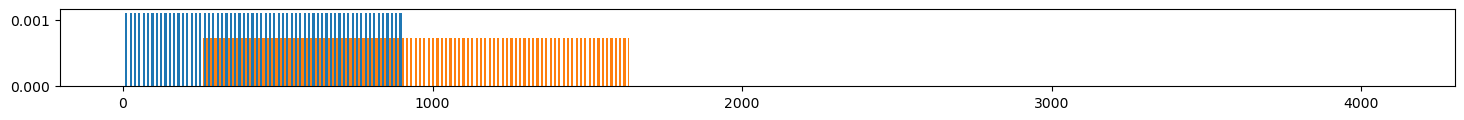

In [57]:
fig, ax = plt.subplots(figsize=(18, 1))
ax.bar(np.arange(2**n_dz[0]),ground_truth(well_formed_set,dev)[order].to('cpu').numpy(),width=0.5,align='edge')
ax.bar(np.arange(2**n_dz[0])+0.5,ground_truth(overlap_set,dev)[order].to('cpu').numpy(),width=0.5,align='edge')
plt.show()

## Model

In [28]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

In [29]:
structure = [12,10,8,6,3,1]
n_dz = torch.tensor(structure)
n_dz

tensor([12, 10,  8,  6,  3,  1])

In [30]:
n_layer = len(n_dz)
n_layer

6

In [31]:
n_d = n_dz[0]
n_d

tensor(12)

In [32]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [33]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [34]:
Phi,Theta = para_init(n_dz)
Phi

{'Phi_01': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0'),
 'Phi_12': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 

In [35]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [36]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

In [37]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785], device='cuda:0')

In [38]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Recog_D_KL_Layer_0')
for i in range(n_layer-1):
    if i > 0:
        col_list.append('Recog_H_Layer_'+str(i))
        col_list.append('Recog_I_Layer_'+str(i))
        col_list.append('Recog_D_KL_Layer_'+str(i))
    col_list.append('Gen_H_Layer_'+str(i))
    col_list.append('Gen_I_Layer_'+str(i))
    col_list.append('Gen_D_KL_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Recog_D_KL_Layer_0',
 'Gen_H_Layer_0',
 'Gen_I_Layer_0',
 'Gen_D_KL_Layer_0',
 'Recog_H_Layer_1',
 'Recog_I_Layer_1',
 'Recog_D_KL_Layer_1',
 'Gen_H_Layer_1',
 'Gen_I_Layer_1',
 'Gen_D_KL_Layer_1',
 'Recog_H_Layer_2',
 'Recog_I_Layer_2',
 'Recog_D_KL_Layer_2',
 'Gen_H_Layer_2',
 'Gen_I_Layer_2',
 'Gen_D_KL_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_3',
 'Recog_D_KL_Layer_3',
 'Gen_H_Layer_3',
 'Gen_I_Layer_3',
 'Gen_D_KL_Layer_3',
 'Recog_H_Layer_4',
 'Recog_I_Layer_4',
 'Recog_D_KL_Layer_4',
 'Gen_H_Layer_4',
 'Gen_I_Layer_4',
 'Gen_D_KL_Layer_4']

In [39]:
len(col_list)

37

### Train with Batch

In [61]:
# Analytic_ws_batch = pd.DataFrame(columns=col_list)
# Analytic_ws_batch

Empty DataFrame
Columns: [Phi_Loss_Layer_1, Phi_Loss_Layer_2, Phi_Loss_Layer_3, Phi_Loss_Layer_4, Theta_Loss_Layer_0, Theta_Loss_Layer_1, Theta_Loss_Layer_2, Theta_Loss_Layer_3, Theta_Loss_Layer_4, Recog_D_KL_Layer_0, Gen_H_Layer_0, Gen_I_Layer_0, Gen_D_KL_Layer_0, Recog_H_Layer_1, Recog_I_Layer_1, Recog_D_KL_Layer_1, Gen_H_Layer_1, Gen_I_Layer_1, Gen_D_KL_Layer_1, Recog_H_Layer_2, Recog_I_Layer_2, Recog_D_KL_Layer_2, Gen_H_Layer_2, Gen_I_Layer_2, Gen_D_KL_Layer_2, Recog_H_Layer_3, Recog_I_Layer_3, Recog_D_KL_Layer_3, Gen_H_Layer_3, Gen_I_Layer_3, Gen_D_KL_Layer_3, Recog_H_Layer_4, Recog_I_Layer_4, Recog_D_KL_Layer_4, Gen_H_Layer_4, Gen_I_Layer_4, Gen_D_KL_Layer_4]
Index: []

[0 rows x 37 columns]

In [62]:
# Phi,Theta = para_init(n_dz)

In [33]:
Analytic_ws_batch = pd.read_csv('Analytic_ws_batch.csv', sep=",")
Analytic_ws_batch

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0             0.693147          0.693147          0.693147          0.693147   
1             0.691468          0.693039          0.693183          0.693046   
2             0.689466          0.693011          0.693128          0.692630   
3             0.688073          0.693303          0.692915          0.693097   
4             0.684058          0.691606          0.692689          0.693507   
...                ...               ...               ...               ...   
2196          0.265112          0.514316          0.487237          0.391851   
2197          0.260851          0.528620          0.500634          0.416142   
2198          0.273934          0.516208          0.486625          0.407732   
2199          0.273755          0.529722          0.496625          0.409228   
2200          0.271380          0.521549          0.494629          0.404094   

      Theta_Loss_Layer_0  Theta_Loss_Layer_1  Theta_Loss_Layer_2  \
0               0.693147            0.693147            0.693147   
1               0.616928            0.692587            0.693104   
2               0.614550            0.689150            0.693249   
3               0.614205            0.686890            0.691830   
4               0.614066            0.687006            0.691499   
...                  ...                 ...                 ...   
2196            0.345046            0.479688            0.557601   
2197            0.350034            0.481594            0.563655   
2198            0.346137            0.476487            0.565469   
2199            0.346964            0.485345            0.562294   
2200            0.342596            0.470797            0.565000   

      Theta_Loss_Layer_3  Theta_Loss_Layer_4  Recog_D_KL_Layer_0  ...  \
0               0.693147            0.693147           68.994232  ...   
1               0.693093            0.693318           33.012474  ...   
2               0.692969            0.693229           31.326004  ...   
3               0.692660            0.692917           30.740173  ...   
4               0.692571            0.692510           30.498985  ...   
...                  ...                 ...                 ...  ...   
2196            0.532164            0.466547            6.710065  ...   
2197            0.519253            0.465670            6.712999  ...   
2198            0.516958            0.478469            6.719982  ...   
2199            0.529739            0.471317            6.709084  ...   
2200            0.523591            0.475820            6.711415  ...   

      Recog_D_KL_Layer_3  Gen_H_Layer_3  Gen_I_Layer_3  Gen_D_KL_Layer_3  \
0               0.000012       4.158881   9.536743e-07          0.000012   
1               0.000131       4.158812   6.628036e-05          0.000130   
2               0.000017       4.158498   1.745224e-04          0.000016   
3               0.000145       4.158237   3.027916e-04          0.000145   
4               0.000229       4.157988   3.771782e-04          0.000229   
...                  ...            ...            ...               ...   
2196            0.000447       3.369449   1.912861e-01          0.000443   
2197            0.000339       3.356569   1.914661e-01          0.000334   
2198            0.000366       3.352261   1.908796e-01          0.000359   
2199            0.000311       3.359583   1.914580e-01          0.000305   
2200            0.000348       3.353837   1.906011e-01          0.000343   

      Recog_H_Layer_4  Recog_I_Layer_4  Recog_D_KL_Layer_4  Gen_H_Layer_4  \
0            2.079438     9.536743e-07            0.000007       2.079439   
1            2.079191     8.130074e-05            0.000086       2.079327   
2            2.079260     9.799004e-05            0.000026       2.079244   
3            2.079297     1.435280e-04            0.000003       2.079253   
4            2.079173     1.442432e-04            0.0

In [131]:
para = np.load('Parameters_ws_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [254]:
batch_size = n_data
data = well_formed_set
lr = 0.1
epoch = 1000

In [255]:
for e in range(epoch):
    Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
    print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
    if e % 100 == 0:
        stat = []
        stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
        stat = stat + list((Loss_sleep).to('cpu').numpy())
        wake_ct = {}
        sleep_ct = {}
        wake_ct['Layer 0: dist'] = data_dist
        dist_ct_pre_s = torch.ones(1,device=dev)
        dist_ct_pre_w = data_dist
        for i in range(n_layer-1):
            prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
            sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
            sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
            dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']

            if i < n_layer-2:
                prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
                wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
                wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)
                dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']
        for i in range(n_layer-1):
            dist_w = wake_ct['Layer '+str(i)+': dist']
            dist_s = sleep_ct['Layer '+str(i)+': dist']
            if i == 0:
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            if i > 0:
                H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
                stat.append(H_Y_w)
                H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
                I_w = H_Y_w - H_YX_w
                stat.append(I_w)
                D_KL_w = KL_divergence(dist_s,dist_w).item()
                stat.append(D_KL_w)
            H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
            stat.append(H_Y_s)
            H_YX_s = sleep_ct['Layer '+str(i)+': H_YX'].item()
            I_s = H_Y_s - H_YX_s
            stat.append(I_s)
            D_KL_s = KL_divergence(dist_w,dist_s).item()
            stat.append(D_KL_s)
        Analytic_ws_batch.loc[len(Analytic_ws_batch)] = stat

Loss_wake: tensor([0.0000, 0.2693, 0.5215, 0.4943, 0.4005])     Loss_sleep: tensor([0.3536, 0.4769, 0.5608, 0.5320, 0.4541])
Loss_wake: tensor([0.0000, 0.2703, 0.5262, 0.5085, 0.4045])     Loss_sleep: tensor([0.3461, 0.4916, 0.5639, 0.5387, 0.4785])
Loss_wake: tensor([0.0000, 0.2737, 0.5279, 0.4971, 0.4047])     Loss_sleep: tensor([0.3450, 0.4905, 0.5631, 0.5358, 0.4631])
Loss_wake: tensor([0.0000, 0.2761, 0.5280, 0.5113, 0.4327])     Loss_sleep: tensor([0.3481, 0.4863, 0.5607, 0.5372, 0.4707])
Loss_wake: tensor([0.0000, 0.2731, 0.5219, 0.5000, 0.3978])     Loss_sleep: tensor([0.3492, 0.4787, 0.5604, 0.5344, 0.4717])
Loss_wake: tensor([0.0000, 0.2716, 0.5162, 0.5039, 0.4173])     Loss_sleep: tensor([0.3548, 0.4748, 0.5615, 0.5311, 0.4410])
Loss_wake: tensor([0.0000, 0.2801, 0.5247, 0.4970, 0.3867])     Loss_sleep: tensor([0.3479, 0.4776, 0.5646, 0.5333, 0.4573])
Loss_wake: tensor([0.0000, 0.2724, 0.5352, 0.5035, 0.3994])     Loss_sleep: tensor([0.3541, 0.4838, 0.5674, 0.5403, 0.4831])


Loss_wake: tensor([0.0000, 0.2722, 0.5209, 0.4911, 0.3963])     Loss_sleep: tensor([0.3531, 0.4780, 0.5638, 0.5395, 0.4609])
Loss_wake: tensor([0.0000, 0.2753, 0.5249, 0.4864, 0.4097])     Loss_sleep: tensor([0.3483, 0.4866, 0.5626, 0.5273, 0.4519])
Loss_wake: tensor([0.0000, 0.2820, 0.5212, 0.4998, 0.3970])     Loss_sleep: tensor([0.3481, 0.4815, 0.5548, 0.5297, 0.4702])
Loss_wake: tensor([0.0000, 0.2698, 0.5324, 0.5018, 0.4055])     Loss_sleep: tensor([0.3440, 0.4817, 0.5633, 0.5343, 0.4640])
Loss_wake: tensor([0.0000, 0.2790, 0.5279, 0.5107, 0.3984])     Loss_sleep: tensor([0.3491, 0.4783, 0.5712, 0.5339, 0.4651])
Loss_wake: tensor([0.0000, 0.2754, 0.5242, 0.4987, 0.4030])     Loss_sleep: tensor([0.3473, 0.4804, 0.5620, 0.5449, 0.4600])
Loss_wake: tensor([0.0000, 0.2771, 0.5246, 0.5054, 0.4053])     Loss_sleep: tensor([0.3479, 0.4815, 0.5623, 0.5316, 0.4788])
Loss_wake: tensor([0.0000, 0.2719, 0.5297, 0.4954, 0.3978])     Loss_sleep: tensor([0.3405, 0.4846, 0.5571, 0.5469, 0.4605])


Loss_wake: tensor([0.0000, 0.2789, 0.5271, 0.4996, 0.4091])     Loss_sleep: tensor([0.3525, 0.4757, 0.5593, 0.5300, 0.4629])
Loss_wake: tensor([0.0000, 0.2725, 0.5353, 0.4911, 0.4093])     Loss_sleep: tensor([0.3544, 0.4791, 0.5688, 0.5254, 0.4518])
Loss_wake: tensor([0.0000, 0.2727, 0.5133, 0.5020, 0.4110])     Loss_sleep: tensor([0.3526, 0.4781, 0.5640, 0.5283, 0.4662])
Loss_wake: tensor([0.0000, 0.2723, 0.5233, 0.4899, 0.4105])     Loss_sleep: tensor([0.3414, 0.4871, 0.5648, 0.5406, 0.4685])
Loss_wake: tensor([0.0000, 0.2788, 0.5279, 0.4994, 0.3850])     Loss_sleep: tensor([0.3560, 0.4829, 0.5552, 0.5400, 0.4619])
Loss_wake: tensor([0.0000, 0.2768, 0.5238, 0.5037, 0.3945])     Loss_sleep: tensor([0.3508, 0.4815, 0.5614, 0.5212, 0.4609])
Loss_wake: tensor([0.0000, 0.2734, 0.5286, 0.4923, 0.4056])     Loss_sleep: tensor([0.3525, 0.4736, 0.5668, 0.5390, 0.4609])
Loss_wake: tensor([0.0000, 0.2727, 0.5158, 0.5085, 0.4138])     Loss_sleep: tensor([0.3551, 0.4779, 0.5678, 0.5295, 0.4472])


Loss_wake: tensor([0.0000, 0.2777, 0.5302, 0.4947, 0.4038])     Loss_sleep: tensor([0.3495, 0.4768, 0.5604, 0.5387, 0.4749])
Loss_wake: tensor([0.0000, 0.2796, 0.5274, 0.5096, 0.3714])     Loss_sleep: tensor([0.3502, 0.4861, 0.5599, 0.5371, 0.4585])
Loss_wake: tensor([0.0000, 0.2726, 0.5233, 0.4898, 0.3817])     Loss_sleep: tensor([0.3507, 0.4822, 0.5551, 0.5279, 0.4544])
Loss_wake: tensor([0.0000, 0.2740, 0.5232, 0.5075, 0.4138])     Loss_sleep: tensor([0.3543, 0.4783, 0.5644, 0.5265, 0.4693])
Loss_wake: tensor([0.0000, 0.2678, 0.5234, 0.5014, 0.4008])     Loss_sleep: tensor([0.3505, 0.4813, 0.5689, 0.5253, 0.4681])
Loss_wake: tensor([0.0000, 0.2749, 0.5326, 0.4960, 0.4106])     Loss_sleep: tensor([0.3438, 0.4814, 0.5639, 0.5348, 0.4544])
Loss_wake: tensor([0.0000, 0.2719, 0.5274, 0.4932, 0.3826])     Loss_sleep: tensor([0.3471, 0.4819, 0.5684, 0.5303, 0.4614])
Loss_wake: tensor([0.0000, 0.2777, 0.5299, 0.5033, 0.4057])     Loss_sleep: tensor([0.3475, 0.4833, 0.5684, 0.5281, 0.4651])


Loss_wake: tensor([0.0000, 0.2777, 0.5222, 0.4975, 0.4041])     Loss_sleep: tensor([0.3460, 0.4770, 0.5627, 0.5313, 0.4815])
Loss_wake: tensor([0.0000, 0.2701, 0.5312, 0.4847, 0.4079])     Loss_sleep: tensor([0.3531, 0.4830, 0.5675, 0.5285, 0.4754])
Loss_wake: tensor([0.0000, 0.2764, 0.5317, 0.5068, 0.4190])     Loss_sleep: tensor([0.3473, 0.4792, 0.5557, 0.5290, 0.4715])
Loss_wake: tensor([0.0000, 0.2763, 0.5220, 0.4889, 0.3894])     Loss_sleep: tensor([0.3485, 0.4745, 0.5654, 0.5238, 0.4644])
Loss_wake: tensor([0.0000, 0.2764, 0.5345, 0.4994, 0.3991])     Loss_sleep: tensor([0.3524, 0.4892, 0.5672, 0.5307, 0.4673])
Loss_wake: tensor([0.0000, 0.2749, 0.5308, 0.4969, 0.3966])     Loss_sleep: tensor([0.3500, 0.4866, 0.5657, 0.5354, 0.4674])
Loss_wake: tensor([0.0000, 0.2679, 0.5229, 0.4868, 0.3924])     Loss_sleep: tensor([0.3490, 0.4846, 0.5603, 0.5214, 0.4537])
Loss_wake: tensor([0.0000, 0.2729, 0.5377, 0.5004, 0.4040])     Loss_sleep: tensor([0.3560, 0.4884, 0.5592, 0.5429, 0.4673])


Loss_wake: tensor([0.0000, 0.2749, 0.5308, 0.4965, 0.4134])     Loss_sleep: tensor([0.3494, 0.4863, 0.5639, 0.5320, 0.4623])
Loss_wake: tensor([0.0000, 0.2776, 0.5257, 0.4947, 0.4037])     Loss_sleep: tensor([0.3488, 0.4841, 0.5593, 0.5263, 0.4641])
Loss_wake: tensor([0.0000, 0.2728, 0.5259, 0.4960, 0.4123])     Loss_sleep: tensor([0.3495, 0.4759, 0.5545, 0.5344, 0.4762])
Loss_wake: tensor([0.0000, 0.2723, 0.5315, 0.4957, 0.4228])     Loss_sleep: tensor([0.3476, 0.4835, 0.5617, 0.5332, 0.4725])
Loss_wake: tensor([0.0000, 0.2697, 0.5293, 0.4968, 0.4115])     Loss_sleep: tensor([0.3502, 0.4764, 0.5656, 0.5240, 0.4478])
Loss_wake: tensor([0.0000, 0.2723, 0.5304, 0.5006, 0.4120])     Loss_sleep: tensor([0.3513, 0.4801, 0.5667, 0.5369, 0.4565])
Loss_wake: tensor([0.0000, 0.2797, 0.5227, 0.4925, 0.4025])     Loss_sleep: tensor([0.3537, 0.4846, 0.5662, 0.5290, 0.4751])
Loss_wake: tensor([0.0000, 0.2762, 0.5334, 0.5008, 0.4020])     Loss_sleep: tensor([0.3514, 0.4793, 0.5629, 0.5246, 0.4643])


Loss_wake: tensor([0.0000, 0.2719, 0.5290, 0.4943, 0.4009])     Loss_sleep: tensor([0.3432, 0.4836, 0.5584, 0.5224, 0.4443])
Loss_wake: tensor([0.0000, 0.2806, 0.5269, 0.4988, 0.4008])     Loss_sleep: tensor([0.3406, 0.4820, 0.5613, 0.5310, 0.4659])
Loss_wake: tensor([0.0000, 0.2727, 0.5169, 0.5013, 0.4185])     Loss_sleep: tensor([0.3500, 0.4813, 0.5607, 0.5283, 0.4472])
Loss_wake: tensor([0.0000, 0.2658, 0.5247, 0.4900, 0.4018])     Loss_sleep: tensor([0.3499, 0.4792, 0.5731, 0.5205, 0.4616])
Loss_wake: tensor([0.0000, 0.2774, 0.5281, 0.5001, 0.4136])     Loss_sleep: tensor([0.3502, 0.4787, 0.5579, 0.5363, 0.4521])
Loss_wake: tensor([0.0000, 0.2729, 0.5244, 0.5033, 0.3908])     Loss_sleep: tensor([0.3497, 0.4797, 0.5680, 0.5354, 0.4693])
Loss_wake: tensor([0.0000, 0.2713, 0.5336, 0.5029, 0.4058])     Loss_sleep: tensor([0.3503, 0.4802, 0.5665, 0.5329, 0.4477])
Loss_wake: tensor([0.0000, 0.2687, 0.5217, 0.5116, 0.4039])     Loss_sleep: tensor([0.3502, 0.4872, 0.5601, 0.5325, 0.4678])


Loss_wake: tensor([0.0000, 0.2714, 0.5335, 0.4928, 0.3902])     Loss_sleep: tensor([0.3469, 0.4815, 0.5636, 0.5368, 0.4650])
Loss_wake: tensor([0.0000, 0.2723, 0.5289, 0.4941, 0.3967])     Loss_sleep: tensor([0.3511, 0.4732, 0.5698, 0.5214, 0.4644])
Loss_wake: tensor([0.0000, 0.2741, 0.5281, 0.5046, 0.4114])     Loss_sleep: tensor([0.3494, 0.4847, 0.5526, 0.5390, 0.4720])
Loss_wake: tensor([0.0000, 0.2724, 0.5296, 0.5007, 0.4043])     Loss_sleep: tensor([0.3444, 0.4840, 0.5666, 0.5357, 0.4553])
Loss_wake: tensor([0.0000, 0.2780, 0.5301, 0.4881, 0.3791])     Loss_sleep: tensor([0.3459, 0.4812, 0.5663, 0.5287, 0.4609])
Loss_wake: tensor([0.0000, 0.2739, 0.5232, 0.4981, 0.4082])     Loss_sleep: tensor([0.3526, 0.4806, 0.5715, 0.5276, 0.4660])
Loss_wake: tensor([0.0000, 0.2803, 0.5275, 0.4903, 0.4154])     Loss_sleep: tensor([0.3451, 0.4846, 0.5569, 0.5285, 0.4626])
Loss_wake: tensor([0.0000, 0.2789, 0.5182, 0.4794, 0.4076])     Loss_sleep: tensor([0.3407, 0.4822, 0.5691, 0.5245, 0.4544])


Loss_wake: tensor([0.0000, 0.2759, 0.5191, 0.4913, 0.4041])     Loss_sleep: tensor([0.3498, 0.4897, 0.5624, 0.5227, 0.4629])
Loss_wake: tensor([0.0000, 0.2729, 0.5216, 0.4863, 0.4017])     Loss_sleep: tensor([0.3552, 0.4753, 0.5653, 0.5164, 0.4675])
Loss_wake: tensor([0.0000, 0.2734, 0.5242, 0.4929, 0.3947])     Loss_sleep: tensor([0.3514, 0.4862, 0.5550, 0.5297, 0.4556])
Loss_wake: tensor([0.0000, 0.2665, 0.5228, 0.5038, 0.4067])     Loss_sleep: tensor([0.3472, 0.4805, 0.5611, 0.5189, 0.4637])
Loss_wake: tensor([0.0000, 0.2696, 0.5267, 0.5059, 0.3959])     Loss_sleep: tensor([0.3500, 0.4785, 0.5674, 0.5335, 0.4756])
Loss_wake: tensor([0.0000, 0.2704, 0.5241, 0.5020, 0.3949])     Loss_sleep: tensor([0.3465, 0.4874, 0.5650, 0.5309, 0.4545])
Loss_wake: tensor([0.0000, 0.2720, 0.5259, 0.4908, 0.4003])     Loss_sleep: tensor([0.3536, 0.4804, 0.5632, 0.5300, 0.4526])
Loss_wake: tensor([0.0000, 0.2725, 0.5376, 0.4874, 0.3962])     Loss_sleep: tensor([0.3509, 0.4832, 0.5591, 0.5381, 0.4753])


Loss_wake: tensor([0.0000, 0.2791, 0.5280, 0.4983, 0.3861])     Loss_sleep: tensor([0.3472, 0.4793, 0.5726, 0.5330, 0.4566])
Loss_wake: tensor([0.0000, 0.2774, 0.5331, 0.4996, 0.3917])     Loss_sleep: tensor([0.3476, 0.4773, 0.5574, 0.5153, 0.4451])
Loss_wake: tensor([0.0000, 0.2809, 0.5373, 0.5087, 0.4241])     Loss_sleep: tensor([0.3497, 0.4837, 0.5632, 0.5419, 0.4799])
Loss_wake: tensor([0.0000, 0.2782, 0.5327, 0.5020, 0.4015])     Loss_sleep: tensor([0.3505, 0.4774, 0.5645, 0.5276, 0.4580])
Loss_wake: tensor([0.0000, 0.2752, 0.5290, 0.4967, 0.4067])     Loss_sleep: tensor([0.3481, 0.4753, 0.5679, 0.5393, 0.4840])
Loss_wake: tensor([0.0000, 0.2760, 0.5312, 0.4843, 0.4051])     Loss_sleep: tensor([0.3462, 0.4884, 0.5681, 0.5383, 0.4789])
Loss_wake: tensor([0.0000, 0.2701, 0.5328, 0.4971, 0.3996])     Loss_sleep: tensor([0.3504, 0.4776, 0.5627, 0.5275, 0.4677])
Loss_wake: tensor([0.0000, 0.2662, 0.5276, 0.4936, 0.3957])     Loss_sleep: tensor([0.3590, 0.4860, 0.5672, 0.5393, 0.4654])


Loss_wake: tensor([0.0000, 0.2754, 0.5268, 0.4875, 0.4182])     Loss_sleep: tensor([0.3484, 0.4844, 0.5659, 0.5209, 0.4566])
Loss_wake: tensor([0.0000, 0.2718, 0.5277, 0.5071, 0.3915])     Loss_sleep: tensor([0.3515, 0.4860, 0.5668, 0.5245, 0.4600])
Loss_wake: tensor([0.0000, 0.2695, 0.5261, 0.4965, 0.4097])     Loss_sleep: tensor([0.3439, 0.4797, 0.5626, 0.5289, 0.4703])
Loss_wake: tensor([0.0000, 0.2794, 0.5315, 0.5021, 0.4111])     Loss_sleep: tensor([0.3509, 0.4778, 0.5582, 0.5350, 0.4755])
Loss_wake: tensor([0.0000, 0.2807, 0.5247, 0.4939, 0.3784])     Loss_sleep: tensor([0.3504, 0.4805, 0.5643, 0.5391, 0.4590])
Loss_wake: tensor([0.0000, 0.2759, 0.5324, 0.4898, 0.4191])     Loss_sleep: tensor([0.3525, 0.4829, 0.5618, 0.5269, 0.4638])
Loss_wake: tensor([0.0000, 0.2725, 0.5309, 0.4866, 0.4011])     Loss_sleep: tensor([0.3523, 0.4777, 0.5679, 0.5227, 0.4590])
Loss_wake: tensor([0.0000, 0.2779, 0.5318, 0.4958, 0.4126])     Loss_sleep: tensor([0.3445, 0.4865, 0.5594, 0.5293, 0.4648])


Loss_wake: tensor([0.0000, 0.2687, 0.5276, 0.5043, 0.3873])     Loss_sleep: tensor([0.3482, 0.4843, 0.5668, 0.5257, 0.4616])
Loss_wake: tensor([0.0000, 0.2828, 0.5291, 0.5011, 0.3959])     Loss_sleep: tensor([0.3460, 0.4812, 0.5627, 0.5296, 0.4714])
Loss_wake: tensor([0.0000, 0.2697, 0.5201, 0.4815, 0.3910])     Loss_sleep: tensor([0.3550, 0.4744, 0.5630, 0.5190, 0.4663])
Loss_wake: tensor([0.0000, 0.2756, 0.5293, 0.4885, 0.3991])     Loss_sleep: tensor([0.3474, 0.4785, 0.5663, 0.5293, 0.4679])
Loss_wake: tensor([0.0000, 0.2790, 0.5308, 0.4864, 0.3945])     Loss_sleep: tensor([0.3433, 0.4825, 0.5671, 0.5270, 0.4563])
Loss_wake: tensor([0.0000, 0.2723, 0.5306, 0.5016, 0.4074])     Loss_sleep: tensor([0.3495, 0.4816, 0.5650, 0.5236, 0.4477])
Loss_wake: tensor([0.0000, 0.2770, 0.5287, 0.4969, 0.3959])     Loss_sleep: tensor([0.3479, 0.4854, 0.5650, 0.5395, 0.4648])
Loss_wake: tensor([0.0000, 0.2804, 0.5224, 0.4792, 0.3851])     Loss_sleep: tensor([0.3462, 0.4847, 0.5579, 0.5318, 0.4621])


Loss_wake: tensor([0.0000, 0.2746, 0.5308, 0.4999, 0.3930])     Loss_sleep: tensor([0.3460, 0.4777, 0.5668, 0.5214, 0.4564])
Loss_wake: tensor([0.0000, 0.2814, 0.5259, 0.5025, 0.4008])     Loss_sleep: tensor([0.3491, 0.4745, 0.5648, 0.5383, 0.4427])
Loss_wake: tensor([0.0000, 0.2778, 0.5201, 0.4980, 0.4015])     Loss_sleep: tensor([0.3425, 0.4815, 0.5603, 0.5231, 0.4750])
Loss_wake: tensor([0.0000, 0.2729, 0.5282, 0.4888, 0.3859])     Loss_sleep: tensor([0.3526, 0.4808, 0.5611, 0.5191, 0.4545])
Loss_wake: tensor([0.0000, 0.2784, 0.5181, 0.4895, 0.3989])     Loss_sleep: tensor([0.3501, 0.4770, 0.5573, 0.5312, 0.4506])
Loss_wake: tensor([0.0000, 0.2722, 0.5250, 0.4851, 0.3911])     Loss_sleep: tensor([0.3483, 0.4913, 0.5607, 0.5238, 0.4538])
Loss_wake: tensor([0.0000, 0.2765, 0.5308, 0.4851, 0.3871])     Loss_sleep: tensor([0.3484, 0.4830, 0.5748, 0.5260, 0.4659])
Loss_wake: tensor([0.0000, 0.2698, 0.5184, 0.4847, 0.4004])     Loss_sleep: tensor([0.3492, 0.4780, 0.5659, 0.5374, 0.4444])


Loss_wake: tensor([0.0000, 0.2729, 0.5322, 0.4880, 0.4090])     Loss_sleep: tensor([0.3510, 0.4744, 0.5607, 0.5366, 0.4444])
Loss_wake: tensor([0.0000, 0.2712, 0.5311, 0.4858, 0.3957])     Loss_sleep: tensor([0.3571, 0.4914, 0.5658, 0.5228, 0.4509])
Loss_wake: tensor([0.0000, 0.2728, 0.5277, 0.4931, 0.3743])     Loss_sleep: tensor([0.3530, 0.4812, 0.5657, 0.5207, 0.4461])
Loss_wake: tensor([0.0000, 0.2679, 0.5205, 0.4967, 0.3947])     Loss_sleep: tensor([0.3507, 0.4773, 0.5599, 0.5316, 0.4595])
Loss_wake: tensor([0.0000, 0.2705, 0.5287, 0.4895, 0.3905])     Loss_sleep: tensor([0.3503, 0.4779, 0.5613, 0.5232, 0.4482])
Loss_wake: tensor([0.0000, 0.2731, 0.5261, 0.4840, 0.3933])     Loss_sleep: tensor([0.3478, 0.4865, 0.5601, 0.5237, 0.4715])
Loss_wake: tensor([0.0000, 0.2742, 0.5261, 0.5037, 0.3982])     Loss_sleep: tensor([0.3449, 0.4779, 0.5664, 0.5312, 0.4639])
Loss_wake: tensor([0.0000, 0.2793, 0.5288, 0.4904, 0.4027])     Loss_sleep: tensor([0.3540, 0.4834, 0.5592, 0.5228, 0.4605])


Loss_wake: tensor([0.0000, 0.2771, 0.5225, 0.4876, 0.3948])     Loss_sleep: tensor([0.3456, 0.4849, 0.5622, 0.5155, 0.4555])
Loss_wake: tensor([0.0000, 0.2752, 0.5233, 0.4894, 0.3950])     Loss_sleep: tensor([0.3492, 0.4854, 0.5640, 0.5387, 0.4616])
Loss_wake: tensor([0.0000, 0.2765, 0.5332, 0.4931, 0.4004])     Loss_sleep: tensor([0.3522, 0.4770, 0.5618, 0.5330, 0.4586])
Loss_wake: tensor([0.0000, 0.2707, 0.5341, 0.5020, 0.3887])     Loss_sleep: tensor([0.3489, 0.4791, 0.5615, 0.5313, 0.4644])
Loss_wake: tensor([0.0000, 0.2693, 0.5203, 0.4914, 0.4006])     Loss_sleep: tensor([0.3491, 0.4834, 0.5603, 0.5278, 0.4539])
Loss_wake: tensor([0.0000, 0.2685, 0.5340, 0.4933, 0.4075])     Loss_sleep: tensor([0.3482, 0.4772, 0.5606, 0.5249, 0.4555])
Loss_wake: tensor([0.0000, 0.2694, 0.5218, 0.4966, 0.4108])     Loss_sleep: tensor([0.3551, 0.4792, 0.5673, 0.5268, 0.4654])
Loss_wake: tensor([0.0000, 0.2742, 0.5296, 0.4971, 0.3878])     Loss_sleep: tensor([0.3490, 0.4872, 0.5623, 0.5291, 0.4611])


Loss_wake: tensor([0.0000, 0.2732, 0.5377, 0.4871, 0.4007])     Loss_sleep: tensor([0.3401, 0.4868, 0.5648, 0.5292, 0.4566])
Loss_wake: tensor([0.0000, 0.2763, 0.5274, 0.4874, 0.4042])     Loss_sleep: tensor([0.3460, 0.4764, 0.5676, 0.5407, 0.4666])
Loss_wake: tensor([0.0000, 0.2778, 0.5214, 0.4954, 0.4034])     Loss_sleep: tensor([0.3447, 0.4850, 0.5689, 0.5349, 0.4555])
Loss_wake: tensor([0.0000, 0.2801, 0.5380, 0.4924, 0.3825])     Loss_sleep: tensor([0.3440, 0.4842, 0.5640, 0.5214, 0.4759])
Loss_wake: tensor([0.0000, 0.2726, 0.5370, 0.5059, 0.3910])     Loss_sleep: tensor([0.3474, 0.4807, 0.5718, 0.5300, 0.4667])
Loss_wake: tensor([0.0000, 0.2800, 0.5301, 0.5015, 0.4037])     Loss_sleep: tensor([0.3527, 0.4851, 0.5659, 0.5308, 0.4657])
Loss_wake: tensor([0.0000, 0.2733, 0.5375, 0.4984, 0.4001])     Loss_sleep: tensor([0.3500, 0.4813, 0.5588, 0.5282, 0.4529])
Loss_wake: tensor([0.0000, 0.2745, 0.5298, 0.4956, 0.4000])     Loss_sleep: tensor([0.3499, 0.4772, 0.5679, 0.5335, 0.4458])


Loss_wake: tensor([0.0000, 0.2764, 0.5333, 0.5111, 0.3915])     Loss_sleep: tensor([0.3443, 0.4856, 0.5675, 0.5264, 0.4640])
Loss_wake: tensor([0.0000, 0.2723, 0.5292, 0.5103, 0.4022])     Loss_sleep: tensor([0.3468, 0.4829, 0.5639, 0.5432, 0.4663])
Loss_wake: tensor([0.0000, 0.2806, 0.5248, 0.4873, 0.3945])     Loss_sleep: tensor([0.3472, 0.4774, 0.5665, 0.5256, 0.4734])
Loss_wake: tensor([0.0000, 0.2786, 0.5369, 0.4955, 0.3911])     Loss_sleep: tensor([0.3537, 0.4763, 0.5573, 0.5318, 0.4644])
Loss_wake: tensor([0.0000, 0.2824, 0.5280, 0.5096, 0.4065])     Loss_sleep: tensor([0.3499, 0.4808, 0.5600, 0.5322, 0.4764])
Loss_wake: tensor([0.0000, 0.2771, 0.5299, 0.4864, 0.3914])     Loss_sleep: tensor([0.3519, 0.4810, 0.5614, 0.5370, 0.4701])
Loss_wake: tensor([0.0000, 0.2743, 0.5277, 0.5009, 0.4153])     Loss_sleep: tensor([0.3523, 0.4896, 0.5657, 0.5313, 0.4590])
Loss_wake: tensor([0.0000, 0.2779, 0.5259, 0.5013, 0.3848])     Loss_sleep: tensor([0.3449, 0.4854, 0.5698, 0.5236, 0.4561])


Loss_wake: tensor([0.0000, 0.2694, 0.5305, 0.4983, 0.4036])     Loss_sleep: tensor([0.3485, 0.4807, 0.5623, 0.5330, 0.4724])
Loss_wake: tensor([0.0000, 0.2755, 0.5263, 0.4992, 0.3932])     Loss_sleep: tensor([0.3436, 0.4810, 0.5641, 0.5281, 0.4527])
Loss_wake: tensor([0.0000, 0.2804, 0.5290, 0.5001, 0.3906])     Loss_sleep: tensor([0.3530, 0.4850, 0.5684, 0.5223, 0.4677])
Loss_wake: tensor([0.0000, 0.2653, 0.5280, 0.5016, 0.4018])     Loss_sleep: tensor([0.3502, 0.4847, 0.5670, 0.5400, 0.4710])
Loss_wake: tensor([0.0000, 0.2851, 0.5265, 0.4943, 0.3881])     Loss_sleep: tensor([0.3450, 0.4806, 0.5606, 0.5217, 0.4564])
Loss_wake: tensor([0.0000, 0.2700, 0.5202, 0.5049, 0.4003])     Loss_sleep: tensor([0.3469, 0.4856, 0.5615, 0.5276, 0.4650])
Loss_wake: tensor([0.0000, 0.2785, 0.5224, 0.4945, 0.4000])     Loss_sleep: tensor([0.3505, 0.4825, 0.5660, 0.5353, 0.4559])
Loss_wake: tensor([0.0000, 0.2771, 0.5315, 0.5000, 0.4038])     Loss_sleep: tensor([0.3533, 0.4801, 0.5595, 0.5333, 0.4512])


Loss_wake: tensor([0.0000, 0.2726, 0.5234, 0.4913, 0.4033])     Loss_sleep: tensor([0.3505, 0.4777, 0.5571, 0.5305, 0.4656])
Loss_wake: tensor([0.0000, 0.2814, 0.5214, 0.5033, 0.4061])     Loss_sleep: tensor([0.3472, 0.4865, 0.5578, 0.5311, 0.4588])
Loss_wake: tensor([0.0000, 0.2806, 0.5193, 0.4952, 0.4062])     Loss_sleep: tensor([0.3492, 0.4745, 0.5563, 0.5247, 0.4608])
Loss_wake: tensor([0.0000, 0.2869, 0.5246, 0.5020, 0.3988])     Loss_sleep: tensor([0.3460, 0.4876, 0.5662, 0.5282, 0.4588])
Loss_wake: tensor([0.0000, 0.2761, 0.5261, 0.5010, 0.3911])     Loss_sleep: tensor([0.3461, 0.4845, 0.5634, 0.5386, 0.4477])
Loss_wake: tensor([0.0000, 0.2779, 0.5273, 0.4972, 0.4064])     Loss_sleep: tensor([0.3519, 0.4741, 0.5681, 0.5347, 0.4640])
Loss_wake: tensor([0.0000, 0.2763, 0.5197, 0.5099, 0.4020])     Loss_sleep: tensor([0.3503, 0.4862, 0.5566, 0.5346, 0.4702])
Loss_wake: tensor([0.0000, 0.2749, 0.5279, 0.4889, 0.4173])     Loss_sleep: tensor([0.3460, 0.4848, 0.5663, 0.5257, 0.4705])


Loss_wake: tensor([0.0000, 0.2776, 0.5260, 0.4918, 0.4058])     Loss_sleep: tensor([0.3458, 0.4866, 0.5617, 0.5282, 0.4535])
Loss_wake: tensor([0.0000, 0.2843, 0.5286, 0.4819, 0.3983])     Loss_sleep: tensor([0.3511, 0.4869, 0.5585, 0.5297, 0.4611])
Loss_wake: tensor([0.0000, 0.2774, 0.5321, 0.4994, 0.3867])     Loss_sleep: tensor([0.3480, 0.4844, 0.5574, 0.5255, 0.4552])
Loss_wake: tensor([0.0000, 0.2735, 0.5184, 0.5094, 0.3990])     Loss_sleep: tensor([0.3536, 0.4801, 0.5676, 0.5360, 0.4543])
Loss_wake: tensor([0.0000, 0.2774, 0.5230, 0.4973, 0.3974])     Loss_sleep: tensor([0.3448, 0.4908, 0.5648, 0.5343, 0.4522])
Loss_wake: tensor([0.0000, 0.2769, 0.5405, 0.4884, 0.3817])     Loss_sleep: tensor([0.3494, 0.4874, 0.5553, 0.5283, 0.4518])
Loss_wake: tensor([0.0000, 0.2802, 0.5263, 0.4963, 0.4125])     Loss_sleep: tensor([0.3501, 0.4828, 0.5636, 0.5412, 0.4760])
Loss_wake: tensor([0.0000, 0.2794, 0.5181, 0.5019, 0.4208])     Loss_sleep: tensor([0.3497, 0.4843, 0.5560, 0.5291, 0.4491])


Loss_wake: tensor([0.0000, 0.2800, 0.5237, 0.4895, 0.3758])     Loss_sleep: tensor([0.3468, 0.4868, 0.5575, 0.5366, 0.4619])
Loss_wake: tensor([0.0000, 0.2790, 0.5263, 0.5100, 0.4014])     Loss_sleep: tensor([0.3499, 0.4798, 0.5599, 0.5351, 0.4792])
Loss_wake: tensor([0.0000, 0.2784, 0.5245, 0.4982, 0.3989])     Loss_sleep: tensor([0.3507, 0.4830, 0.5639, 0.5274, 0.4776])
Loss_wake: tensor([0.0000, 0.2780, 0.5181, 0.5059, 0.4047])     Loss_sleep: tensor([0.3465, 0.4854, 0.5578, 0.5296, 0.4558])
Loss_wake: tensor([0.0000, 0.2774, 0.5243, 0.4952, 0.3977])     Loss_sleep: tensor([0.3497, 0.4809, 0.5606, 0.5251, 0.4726])
Loss_wake: tensor([0.0000, 0.2777, 0.5242, 0.5030, 0.4082])     Loss_sleep: tensor([0.3506, 0.4844, 0.5700, 0.5332, 0.4666])
Loss_wake: tensor([0.0000, 0.2744, 0.5205, 0.4990, 0.4172])     Loss_sleep: tensor([0.3515, 0.4858, 0.5626, 0.5319, 0.4837])
Loss_wake: tensor([0.0000, 0.2776, 0.5135, 0.5014, 0.3900])     Loss_sleep: tensor([0.3487, 0.4875, 0.5623, 0.5379, 0.4576])


Loss_wake: tensor([0.0000, 0.2752, 0.5261, 0.4990, 0.4094])     Loss_sleep: tensor([0.3540, 0.4812, 0.5486, 0.5313, 0.4791])
Loss_wake: tensor([0.0000, 0.2804, 0.5252, 0.4964, 0.4112])     Loss_sleep: tensor([0.3465, 0.4859, 0.5589, 0.5307, 0.4658])
Loss_wake: tensor([0.0000, 0.2706, 0.5220, 0.4900, 0.3940])     Loss_sleep: tensor([0.3504, 0.4866, 0.5620, 0.5226, 0.4573])
Loss_wake: tensor([0.0000, 0.2767, 0.5246, 0.4906, 0.3940])     Loss_sleep: tensor([0.3528, 0.4858, 0.5670, 0.5185, 0.4459])
Loss_wake: tensor([0.0000, 0.2735, 0.5261, 0.4973, 0.4061])     Loss_sleep: tensor([0.3390, 0.4840, 0.5651, 0.5335, 0.4632])
Loss_wake: tensor([0.0000, 0.2821, 0.5219, 0.4942, 0.3788])     Loss_sleep: tensor([0.3499, 0.4868, 0.5618, 0.5309, 0.4661])
Loss_wake: tensor([0.0000, 0.2746, 0.5232, 0.4962, 0.4179])     Loss_sleep: tensor([0.3473, 0.4908, 0.5650, 0.5317, 0.4736])
Loss_wake: tensor([0.0000, 0.2834, 0.5270, 0.5018, 0.4088])     Loss_sleep: tensor([0.3469, 0.4865, 0.5595, 0.5306, 0.4560])


Loss_wake: tensor([0.0000, 0.2724, 0.5184, 0.4958, 0.3930])     Loss_sleep: tensor([0.3433, 0.4822, 0.5663, 0.5226, 0.4446])
Loss_wake: tensor([0.0000, 0.2734, 0.5296, 0.4973, 0.3971])     Loss_sleep: tensor([0.3460, 0.4817, 0.5518, 0.5313, 0.4528])
Loss_wake: tensor([0.0000, 0.2783, 0.5232, 0.4993, 0.4026])     Loss_sleep: tensor([0.3471, 0.4798, 0.5640, 0.5271, 0.4499])
Loss_wake: tensor([0.0000, 0.2806, 0.5313, 0.5079, 0.4029])     Loss_sleep: tensor([0.3490, 0.4822, 0.5627, 0.5349, 0.4491])
Loss_wake: tensor([0.0000, 0.2765, 0.5255, 0.4864, 0.4139])     Loss_sleep: tensor([0.3465, 0.4823, 0.5623, 0.5366, 0.4463])
Loss_wake: tensor([0.0000, 0.2774, 0.5269, 0.5062, 0.4013])     Loss_sleep: tensor([0.3483, 0.4817, 0.5673, 0.5238, 0.4519])
Loss_wake: tensor([0.0000, 0.2776, 0.5262, 0.5038, 0.4010])     Loss_sleep: tensor([0.3498, 0.4809, 0.5591, 0.5206, 0.4667])
Loss_wake: tensor([0.0000, 0.2744, 0.5257, 0.4969, 0.3851])     Loss_sleep: tensor([0.3567, 0.4787, 0.5668, 0.5162, 0.4758])


Loss_wake: tensor([0.0000, 0.2746, 0.5306, 0.5057, 0.4152])     Loss_sleep: tensor([0.3457, 0.4804, 0.5652, 0.5279, 0.4710])
Loss_wake: tensor([0.0000, 0.2708, 0.5215, 0.4826, 0.3888])     Loss_sleep: tensor([0.3477, 0.4823, 0.5552, 0.5314, 0.4515])
Loss_wake: tensor([0.0000, 0.2784, 0.5267, 0.4858, 0.4014])     Loss_sleep: tensor([0.3514, 0.4804, 0.5635, 0.5455, 0.4703])
Loss_wake: tensor([0.0000, 0.2767, 0.5288, 0.4912, 0.4129])     Loss_sleep: tensor([0.3531, 0.4779, 0.5590, 0.5199, 0.4628])
Loss_wake: tensor([0.0000, 0.2744, 0.5394, 0.4938, 0.4020])     Loss_sleep: tensor([0.3494, 0.4852, 0.5615, 0.5221, 0.4660])
Loss_wake: tensor([0.0000, 0.2709, 0.5268, 0.5015, 0.4016])     Loss_sleep: tensor([0.3413, 0.4867, 0.5553, 0.5395, 0.4498])
Loss_wake: tensor([0.0000, 0.2772, 0.5241, 0.4892, 0.3967])     Loss_sleep: tensor([0.3505, 0.4785, 0.5559, 0.5370, 0.4652])
Loss_wake: tensor([0.0000, 0.2756, 0.5239, 0.4935, 0.3824])     Loss_sleep: tensor([0.3477, 0.4781, 0.5582, 0.5324, 0.4629])


Loss_wake: tensor([0.0000, 0.2767, 0.5281, 0.4953, 0.4136])     Loss_sleep: tensor([0.3429, 0.4803, 0.5613, 0.5252, 0.4700])
Loss_wake: tensor([0.0000, 0.2766, 0.5278, 0.4775, 0.3988])     Loss_sleep: tensor([0.3476, 0.4865, 0.5553, 0.5356, 0.4567])
Loss_wake: tensor([0.0000, 0.2688, 0.5282, 0.5045, 0.3971])     Loss_sleep: tensor([0.3482, 0.4786, 0.5629, 0.5301, 0.4566])
Loss_wake: tensor([0.0000, 0.2738, 0.5237, 0.4897, 0.3975])     Loss_sleep: tensor([0.3456, 0.4811, 0.5670, 0.5259, 0.4623])
Loss_wake: tensor([0.0000, 0.2710, 0.5266, 0.4821, 0.3860])     Loss_sleep: tensor([0.3568, 0.4814, 0.5501, 0.5202, 0.4472])
Loss_wake: tensor([0.0000, 0.2729, 0.5311, 0.4863, 0.4016])     Loss_sleep: tensor([0.3486, 0.4827, 0.5585, 0.5242, 0.4524])
Loss_wake: tensor([0.0000, 0.2717, 0.5362, 0.4911, 0.4032])     Loss_sleep: tensor([0.3585, 0.4776, 0.5630, 0.5312, 0.4626])
Loss_wake: tensor([0.0000, 0.2790, 0.5256, 0.4976, 0.3933])     Loss_sleep: tensor([0.3485, 0.4722, 0.5688, 0.5240, 0.4675])


Loss_wake: tensor([0.0000, 0.2747, 0.5279, 0.4955, 0.3995])     Loss_sleep: tensor([0.3474, 0.4872, 0.5549, 0.5313, 0.4641])
Loss_wake: tensor([0.0000, 0.2802, 0.5269, 0.4950, 0.3970])     Loss_sleep: tensor([0.3469, 0.4779, 0.5557, 0.5211, 0.4562])
Loss_wake: tensor([0.0000, 0.2707, 0.5184, 0.5015, 0.4095])     Loss_sleep: tensor([0.3466, 0.4813, 0.5604, 0.5298, 0.4710])
Loss_wake: tensor([0.0000, 0.2704, 0.5234, 0.4943, 0.3827])     Loss_sleep: tensor([0.3518, 0.4854, 0.5640, 0.5342, 0.4549])
Loss_wake: tensor([0.0000, 0.2777, 0.5251, 0.4881, 0.3977])     Loss_sleep: tensor([0.3553, 0.4749, 0.5575, 0.5298, 0.4600])
Loss_wake: tensor([0.0000, 0.2745, 0.5263, 0.5004, 0.4149])     Loss_sleep: tensor([0.3467, 0.4804, 0.5640, 0.5386, 0.4599])
Loss_wake: tensor([0.0000, 0.2810, 0.5318, 0.4909, 0.4032])     Loss_sleep: tensor([0.3433, 0.4789, 0.5573, 0.5277, 0.4616])
Loss_wake: tensor([0.0000, 0.2775, 0.5256, 0.4985, 0.4090])     Loss_sleep: tensor([0.3496, 0.4847, 0.5624, 0.5335, 0.4607])


Loss_wake: tensor([0.0000, 0.2738, 0.5210, 0.4878, 0.4040])     Loss_sleep: tensor([0.3485, 0.4793, 0.5535, 0.5316, 0.4702])
Loss_wake: tensor([0.0000, 0.2828, 0.5377, 0.5042, 0.4112])     Loss_sleep: tensor([0.3522, 0.4770, 0.5570, 0.5195, 0.4580])
Loss_wake: tensor([0.0000, 0.2878, 0.5213, 0.5041, 0.4099])     Loss_sleep: tensor([0.3541, 0.4803, 0.5579, 0.5398, 0.4706])
Loss_wake: tensor([0.0000, 0.2725, 0.5299, 0.4982, 0.4106])     Loss_sleep: tensor([0.3440, 0.4790, 0.5610, 0.5376, 0.4682])
Loss_wake: tensor([0.0000, 0.2714, 0.5281, 0.4948, 0.3949])     Loss_sleep: tensor([0.3489, 0.4788, 0.5600, 0.5229, 0.4607])
Loss_wake: tensor([0.0000, 0.2767, 0.5314, 0.4917, 0.4145])     Loss_sleep: tensor([0.3497, 0.4840, 0.5578, 0.5220, 0.4638])
Loss_wake: tensor([0.0000, 0.2826, 0.5210, 0.4931, 0.3905])     Loss_sleep: tensor([0.3501, 0.4793, 0.5630, 0.5224, 0.4651])
Loss_wake: tensor([0.0000, 0.2734, 0.5155, 0.4884, 0.3910])     Loss_sleep: tensor([0.3471, 0.4820, 0.5605, 0.5351, 0.4499])


Loss_wake: tensor([0.0000, 0.2772, 0.5216, 0.4898, 0.3968])     Loss_sleep: tensor([0.3517, 0.4748, 0.5563, 0.5277, 0.4795])
Loss_wake: tensor([0.0000, 0.2786, 0.5284, 0.4875, 0.3888])     Loss_sleep: tensor([0.3494, 0.4808, 0.5549, 0.5312, 0.4548])
Loss_wake: tensor([0.0000, 0.2783, 0.5254, 0.5078, 0.4050])     Loss_sleep: tensor([0.3470, 0.4795, 0.5587, 0.5322, 0.4464])
Loss_wake: tensor([0.0000, 0.2814, 0.5299, 0.4862, 0.4119])     Loss_sleep: tensor([0.3445, 0.4763, 0.5586, 0.5291, 0.4608])
Loss_wake: tensor([0.0000, 0.2770, 0.5210, 0.4953, 0.3862])     Loss_sleep: tensor([0.3445, 0.4817, 0.5583, 0.5227, 0.4600])
Loss_wake: tensor([0.0000, 0.2808, 0.5260, 0.5146, 0.4001])     Loss_sleep: tensor([0.3521, 0.4770, 0.5634, 0.5357, 0.4564])
Loss_wake: tensor([0.0000, 0.2783, 0.5257, 0.4929, 0.3871])     Loss_sleep: tensor([0.3465, 0.4852, 0.5665, 0.5212, 0.4570])
Loss_wake: tensor([0.0000, 0.2743, 0.5274, 0.4915, 0.3946])     Loss_sleep: tensor([0.3482, 0.4905, 0.5607, 0.5270, 0.4425])


Loss_wake: tensor([0.0000, 0.2773, 0.5245, 0.4946, 0.4192])     Loss_sleep: tensor([0.3486, 0.4800, 0.5580, 0.5326, 0.4761])
Loss_wake: tensor([0.0000, 0.2832, 0.5290, 0.4931, 0.3909])     Loss_sleep: tensor([0.3544, 0.4824, 0.5566, 0.5251, 0.4535])
Loss_wake: tensor([0.0000, 0.2747, 0.5224, 0.5086, 0.3990])     Loss_sleep: tensor([0.3546, 0.4895, 0.5589, 0.5249, 0.4613])
Loss_wake: tensor([0.0000, 0.2841, 0.5276, 0.4864, 0.3803])     Loss_sleep: tensor([0.3462, 0.4819, 0.5631, 0.5416, 0.4764])
Loss_wake: tensor([0.0000, 0.2761, 0.5195, 0.4945, 0.4169])     Loss_sleep: tensor([0.3532, 0.4813, 0.5604, 0.5254, 0.4448])
Loss_wake: tensor([0.0000, 0.2738, 0.5243, 0.5005, 0.3951])     Loss_sleep: tensor([0.3537, 0.4868, 0.5666, 0.5235, 0.4599])
Loss_wake: tensor([0.0000, 0.2805, 0.5340, 0.4932, 0.4036])     Loss_sleep: tensor([0.3471, 0.4838, 0.5634, 0.5309, 0.4700])
Loss_wake: tensor([0.0000, 0.2809, 0.5171, 0.4931, 0.4135])     Loss_sleep: tensor([0.3500, 0.4825, 0.5572, 0.5388, 0.4627])


Loss_wake: tensor([0.0000, 0.2743, 0.5208, 0.5069, 0.3912])     Loss_sleep: tensor([0.3467, 0.4884, 0.5642, 0.5354, 0.4609])
Loss_wake: tensor([0.0000, 0.2759, 0.5278, 0.4926, 0.4056])     Loss_sleep: tensor([0.3494, 0.4863, 0.5531, 0.5340, 0.4567])
Loss_wake: tensor([0.0000, 0.2672, 0.5147, 0.4912, 0.4061])     Loss_sleep: tensor([0.3518, 0.4759, 0.5649, 0.5280, 0.4812])
Loss_wake: tensor([0.0000, 0.2718, 0.5289, 0.4952, 0.4085])     Loss_sleep: tensor([0.3531, 0.4826, 0.5581, 0.5355, 0.4561])
Loss_wake: tensor([0.0000, 0.2755, 0.5290, 0.4956, 0.3773])     Loss_sleep: tensor([0.3538, 0.4818, 0.5687, 0.5163, 0.4855])
Loss_wake: tensor([0.0000, 0.2858, 0.5231, 0.4878, 0.3988])     Loss_sleep: tensor([0.3531, 0.4788, 0.5680, 0.5277, 0.4438])
Loss_wake: tensor([0.0000, 0.2751, 0.5236, 0.4965, 0.3992])     Loss_sleep: tensor([0.3521, 0.4803, 0.5553, 0.5227, 0.4559])
Loss_wake: tensor([0.0000, 0.2805, 0.5279, 0.4935, 0.4115])     Loss_sleep: tensor([0.3448, 0.4883, 0.5503, 0.5297, 0.4534])


Loss_wake: tensor([0.0000, 0.2732, 0.5225, 0.5011, 0.4059])     Loss_sleep: tensor([0.3507, 0.4798, 0.5614, 0.5288, 0.4525])
Loss_wake: tensor([0.0000, 0.2748, 0.5219, 0.4832, 0.3980])     Loss_sleep: tensor([0.3458, 0.4804, 0.5597, 0.5147, 0.4610])
Loss_wake: tensor([0.0000, 0.2687, 0.5269, 0.4854, 0.4092])     Loss_sleep: tensor([0.3475, 0.4845, 0.5699, 0.5296, 0.4591])
Loss_wake: tensor([0.0000, 0.2709, 0.5279, 0.4987, 0.4040])     Loss_sleep: tensor([0.3505, 0.4870, 0.5621, 0.5288, 0.4631])
Loss_wake: tensor([0.0000, 0.2712, 0.5314, 0.5035, 0.4114])     Loss_sleep: tensor([0.3551, 0.4806, 0.5550, 0.5276, 0.4705])
Loss_wake: tensor([0.0000, 0.2693, 0.5310, 0.4917, 0.4044])     Loss_sleep: tensor([0.3477, 0.4841, 0.5680, 0.5236, 0.4697])
Loss_wake: tensor([0.0000, 0.2742, 0.5399, 0.4930, 0.3952])     Loss_sleep: tensor([0.3520, 0.4821, 0.5684, 0.5353, 0.4663])
Loss_wake: tensor([0.0000, 0.2777, 0.5194, 0.5003, 0.3949])     Loss_sleep: tensor([0.3496, 0.4884, 0.5603, 0.5222, 0.4549])


Loss_wake: tensor([0.0000, 0.2810, 0.5169, 0.5002, 0.4116])     Loss_sleep: tensor([0.3452, 0.4784, 0.5630, 0.5300, 0.4462])
Loss_wake: tensor([0.0000, 0.2810, 0.5225, 0.4886, 0.4038])     Loss_sleep: tensor([0.3569, 0.4796, 0.5618, 0.5248, 0.4422])
Loss_wake: tensor([0.0000, 0.2917, 0.5342, 0.4975, 0.4059])     Loss_sleep: tensor([0.3532, 0.4856, 0.5642, 0.5280, 0.4706])
Loss_wake: tensor([0.0000, 0.2718, 0.5228, 0.4951, 0.3977])     Loss_sleep: tensor([0.3493, 0.4838, 0.5687, 0.5251, 0.4449])
Loss_wake: tensor([0.0000, 0.2827, 0.5191, 0.4988, 0.4058])     Loss_sleep: tensor([0.3513, 0.4764, 0.5573, 0.5349, 0.4753])
Loss_wake: tensor([0.0000, 0.2738, 0.5197, 0.4964, 0.4090])     Loss_sleep: tensor([0.3485, 0.4803, 0.5621, 0.5144, 0.4471])
Loss_wake: tensor([0.0000, 0.2772, 0.5277, 0.5024, 0.4009])     Loss_sleep: tensor([0.3563, 0.4770, 0.5669, 0.5241, 0.4509])
Loss_wake: tensor([0.0000, 0.2781, 0.5298, 0.4905, 0.3951])     Loss_sleep: tensor([0.3497, 0.4831, 0.5624, 0.5230, 0.4637])


Loss_wake: tensor([0.0000, 0.2842, 0.5244, 0.5018, 0.4032])     Loss_sleep: tensor([0.3542, 0.4830, 0.5597, 0.5438, 0.4654])
Loss_wake: tensor([0.0000, 0.2807, 0.5255, 0.5064, 0.4021])     Loss_sleep: tensor([0.3515, 0.4751, 0.5645, 0.5432, 0.4479])
Loss_wake: tensor([0.0000, 0.2777, 0.5138, 0.5003, 0.4165])     Loss_sleep: tensor([0.3536, 0.4870, 0.5599, 0.5290, 0.4647])
Loss_wake: tensor([0.0000, 0.2705, 0.5316, 0.4982, 0.4112])     Loss_sleep: tensor([0.3518, 0.4766, 0.5647, 0.5124, 0.4588])
Loss_wake: tensor([0.0000, 0.2710, 0.5302, 0.4869, 0.3919])     Loss_sleep: tensor([0.3465, 0.4794, 0.5632, 0.5315, 0.4479])
Loss_wake: tensor([0.0000, 0.2772, 0.5285, 0.4891, 0.3874])     Loss_sleep: tensor([0.3497, 0.4762, 0.5565, 0.5310, 0.4608])
Loss_wake: tensor([0.0000, 0.2676, 0.5333, 0.5016, 0.4129])     Loss_sleep: tensor([0.3547, 0.4813, 0.5611, 0.5334, 0.4593])
Loss_wake: tensor([0.0000, 0.2769, 0.5340, 0.4930, 0.4032])     Loss_sleep: tensor([0.3468, 0.4787, 0.5616, 0.5236, 0.4646])


Loss_wake: tensor([0.0000, 0.2719, 0.5250, 0.5073, 0.3943])     Loss_sleep: tensor([0.3465, 0.4802, 0.5637, 0.5352, 0.4629])
Loss_wake: tensor([0.0000, 0.2728, 0.5152, 0.4954, 0.4002])     Loss_sleep: tensor([0.3450, 0.4786, 0.5627, 0.5354, 0.4519])
Loss_wake: tensor([0.0000, 0.2768, 0.5275, 0.4970, 0.3918])     Loss_sleep: tensor([0.3509, 0.4882, 0.5616, 0.5429, 0.4529])
Loss_wake: tensor([0.0000, 0.2739, 0.5466, 0.5000, 0.4017])     Loss_sleep: tensor([0.3488, 0.4845, 0.5688, 0.5324, 0.4588])
Loss_wake: tensor([0.0000, 0.2734, 0.5236, 0.5177, 0.3987])     Loss_sleep: tensor([0.3512, 0.4859, 0.5617, 0.5198, 0.4410])
Loss_wake: tensor([0.0000, 0.2843, 0.5416, 0.5105, 0.3898])     Loss_sleep: tensor([0.3481, 0.4839, 0.5561, 0.5406, 0.4589])
Loss_wake: tensor([0.0000, 0.2774, 0.5272, 0.4876, 0.3767])     Loss_sleep: tensor([0.3502, 0.4821, 0.5687, 0.5340, 0.4598])
Loss_wake: tensor([0.0000, 0.2741, 0.5330, 0.5029, 0.4014])     Loss_sleep: tensor([0.3518, 0.4807, 0.5527, 0.5358, 0.4655])


Loss_wake: tensor([0.0000, 0.2653, 0.5265, 0.5000, 0.4074])     Loss_sleep: tensor([0.3500, 0.4795, 0.5595, 0.5339, 0.4750])
Loss_wake: tensor([0.0000, 0.2699, 0.5242, 0.4854, 0.4029])     Loss_sleep: tensor([0.3484, 0.4793, 0.5581, 0.5276, 0.4703])
Loss_wake: tensor([0.0000, 0.2807, 0.5314, 0.4969, 0.3665])     Loss_sleep: tensor([0.3514, 0.4778, 0.5624, 0.5226, 0.4642])
Loss_wake: tensor([0.0000, 0.2734, 0.5316, 0.4978, 0.3825])     Loss_sleep: tensor([0.3489, 0.4825, 0.5590, 0.5313, 0.4526])
Loss_wake: tensor([0.0000, 0.2809, 0.5320, 0.4952, 0.4068])     Loss_sleep: tensor([0.3497, 0.4795, 0.5688, 0.5220, 0.4529])
Loss_wake: tensor([0.0000, 0.2755, 0.5299, 0.4954, 0.4151])     Loss_sleep: tensor([0.3463, 0.4849, 0.5688, 0.5377, 0.4560])
Loss_wake: tensor([0.0000, 0.2770, 0.5294, 0.5001, 0.3950])     Loss_sleep: tensor([0.3476, 0.4845, 0.5612, 0.5369, 0.4556])
Loss_wake: tensor([0.0000, 0.2768, 0.5219, 0.4985, 0.3992])     Loss_sleep: tensor([0.3494, 0.4776, 0.5646, 0.5339, 0.4742])


Loss_wake: tensor([0.0000, 0.2749, 0.5247, 0.4880, 0.3959])     Loss_sleep: tensor([0.3495, 0.4737, 0.5664, 0.5318, 0.4582])
Loss_wake: tensor([0.0000, 0.2682, 0.5322, 0.4968, 0.4091])     Loss_sleep: tensor([0.3448, 0.4816, 0.5677, 0.5271, 0.4551])
Loss_wake: tensor([0.0000, 0.2712, 0.5241, 0.5036, 0.4082])     Loss_sleep: tensor([0.3502, 0.4823, 0.5565, 0.5300, 0.4496])
Loss_wake: tensor([0.0000, 0.2778, 0.5285, 0.4890, 0.4156])     Loss_sleep: tensor([0.3511, 0.4802, 0.5592, 0.5235, 0.4445])
Loss_wake: tensor([0.0000, 0.2723, 0.5305, 0.4839, 0.4030])     Loss_sleep: tensor([0.3506, 0.4773, 0.5631, 0.5361, 0.4610])
Loss_wake: tensor([0.0000, 0.2784, 0.5264, 0.5040, 0.3922])     Loss_sleep: tensor([0.3528, 0.4766, 0.5674, 0.5324, 0.4622])
Loss_wake: tensor([0.0000, 0.2698, 0.5302, 0.4981, 0.3884])     Loss_sleep: tensor([0.3561, 0.4786, 0.5635, 0.5309, 0.4602])
Loss_wake: tensor([0.0000, 0.2777, 0.5271, 0.5019, 0.4053])     Loss_sleep: tensor([0.3528, 0.4758, 0.5626, 0.5287, 0.4603])


Loss_wake: tensor([0.0000, 0.2747, 0.5275, 0.5068, 0.3982])     Loss_sleep: tensor([0.3499, 0.4909, 0.5579, 0.5225, 0.4652])
Loss_wake: tensor([0.0000, 0.2689, 0.5248, 0.4898, 0.3827])     Loss_sleep: tensor([0.3510, 0.4761, 0.5694, 0.5302, 0.4653])
Loss_wake: tensor([0.0000, 0.2848, 0.5289, 0.4939, 0.3982])     Loss_sleep: tensor([0.3487, 0.4807, 0.5706, 0.5355, 0.4721])
Loss_wake: tensor([0.0000, 0.2801, 0.5251, 0.4937, 0.4145])     Loss_sleep: tensor([0.3485, 0.4865, 0.5633, 0.5348, 0.4607])
Loss_wake: tensor([0.0000, 0.2713, 0.5287, 0.4840, 0.3793])     Loss_sleep: tensor([0.3476, 0.4863, 0.5649, 0.5373, 0.4683])
Loss_wake: tensor([0.0000, 0.2716, 0.5296, 0.5026, 0.3982])     Loss_sleep: tensor([0.3515, 0.4816, 0.5643, 0.5375, 0.4505])
Loss_wake: tensor([0.0000, 0.2735, 0.5316, 0.5046, 0.4078])     Loss_sleep: tensor([0.3443, 0.4794, 0.5538, 0.5172, 0.4655])
Loss_wake: tensor([0.0000, 0.2746, 0.5349, 0.4937, 0.4024])     Loss_sleep: tensor([0.3486, 0.4832, 0.5613, 0.5318, 0.4610])


Loss_wake: tensor([0.0000, 0.2695, 0.5353, 0.4993, 0.3981])     Loss_sleep: tensor([0.3438, 0.4818, 0.5646, 0.5272, 0.4595])
Loss_wake: tensor([0.0000, 0.2813, 0.5234, 0.4934, 0.4037])     Loss_sleep: tensor([0.3483, 0.4777, 0.5580, 0.5321, 0.4504])
Loss_wake: tensor([0.0000, 0.2774, 0.5160, 0.4956, 0.4140])     Loss_sleep: tensor([0.3488, 0.4777, 0.5657, 0.5324, 0.4549])
Loss_wake: tensor([0.0000, 0.2711, 0.5271, 0.4908, 0.4002])     Loss_sleep: tensor([0.3467, 0.4843, 0.5660, 0.5361, 0.4577])
Loss_wake: tensor([0.0000, 0.2770, 0.5265, 0.4960, 0.3864])     Loss_sleep: tensor([0.3534, 0.4860, 0.5648, 0.5244, 0.4493])
Loss_wake: tensor([0.0000, 0.2786, 0.5271, 0.5037, 0.4029])     Loss_sleep: tensor([0.3475, 0.4794, 0.5601, 0.5282, 0.4741])
Loss_wake: tensor([0.0000, 0.2703, 0.5281, 0.4971, 0.4105])     Loss_sleep: tensor([0.3508, 0.4872, 0.5723, 0.5220, 0.4473])
Loss_wake: tensor([0.0000, 0.2733, 0.5266, 0.5010, 0.4085])     Loss_sleep: tensor([0.3529, 0.4870, 0.5612, 0.5271, 0.4517])


Loss_wake: tensor([0.0000, 0.2729, 0.5229, 0.4872, 0.3847])     Loss_sleep: tensor([0.3488, 0.4739, 0.5591, 0.5272, 0.4529])
Loss_wake: tensor([0.0000, 0.2779, 0.5277, 0.4878, 0.4005])     Loss_sleep: tensor([0.3526, 0.4824, 0.5615, 0.5299, 0.4490])
Loss_wake: tensor([0.0000, 0.2733, 0.5226, 0.4857, 0.4050])     Loss_sleep: tensor([0.3484, 0.4849, 0.5592, 0.5317, 0.4527])
Loss_wake: tensor([0.0000, 0.2807, 0.5269, 0.4961, 0.3997])     Loss_sleep: tensor([0.3438, 0.4817, 0.5618, 0.5298, 0.4535])
Loss_wake: tensor([0.0000, 0.2782, 0.5244, 0.4965, 0.3952])     Loss_sleep: tensor([0.3529, 0.4839, 0.5651, 0.5274, 0.4647])
Loss_wake: tensor([0.0000, 0.2703, 0.5358, 0.5036, 0.4018])     Loss_sleep: tensor([0.3491, 0.4775, 0.5616, 0.5189, 0.4577])
Loss_wake: tensor([0.0000, 0.2814, 0.5320, 0.4895, 0.3950])     Loss_sleep: tensor([0.3455, 0.4788, 0.5677, 0.5400, 0.4498])
Loss_wake: tensor([0.0000, 0.2731, 0.5307, 0.4965, 0.3878])     Loss_sleep: tensor([0.3438, 0.4903, 0.5579, 0.5278, 0.4580])


Loss_wake: tensor([0.0000, 0.2791, 0.5271, 0.4981, 0.3972])     Loss_sleep: tensor([0.3526, 0.4752, 0.5667, 0.5202, 0.4445])
Loss_wake: tensor([0.0000, 0.2672, 0.5176, 0.4905, 0.3919])     Loss_sleep: tensor([0.3568, 0.4860, 0.5635, 0.5298, 0.4593])
Loss_wake: tensor([0.0000, 0.2789, 0.5257, 0.4997, 0.3996])     Loss_sleep: tensor([0.3588, 0.4854, 0.5520, 0.5350, 0.4680])
Loss_wake: tensor([0.0000, 0.2652, 0.5391, 0.5078, 0.4025])     Loss_sleep: tensor([0.3493, 0.4825, 0.5560, 0.5255, 0.4582])
Loss_wake: tensor([0.0000, 0.2749, 0.5202, 0.4712, 0.3864])     Loss_sleep: tensor([0.3543, 0.4783, 0.5664, 0.5303, 0.4453])
Loss_wake: tensor([0.0000, 0.2744, 0.5272, 0.4910, 0.3986])     Loss_sleep: tensor([0.3502, 0.4829, 0.5693, 0.5255, 0.4737])
Loss_wake: tensor([0.0000, 0.2723, 0.5252, 0.4958, 0.3997])     Loss_sleep: tensor([0.3495, 0.4885, 0.5634, 0.5399, 0.4610])
Loss_wake: tensor([0.0000, 0.2822, 0.5323, 0.4934, 0.4003])     Loss_sleep: tensor([0.3587, 0.4807, 0.5601, 0.5290, 0.4536])


Loss_wake: tensor([0.0000, 0.2751, 0.5277, 0.5039, 0.4030])     Loss_sleep: tensor([0.3529, 0.4796, 0.5563, 0.5240, 0.4467])
Loss_wake: tensor([0.0000, 0.2797, 0.5361, 0.4913, 0.3830])     Loss_sleep: tensor([0.3459, 0.4833, 0.5566, 0.5310, 0.4554])
Loss_wake: tensor([0.0000, 0.2739, 0.5285, 0.5036, 0.4097])     Loss_sleep: tensor([0.3484, 0.4839, 0.5637, 0.5389, 0.4746])
Loss_wake: tensor([0.0000, 0.2722, 0.5197, 0.4791, 0.3817])     Loss_sleep: tensor([0.3491, 0.4818, 0.5571, 0.5370, 0.4645])
Loss_wake: tensor([0.0000, 0.2637, 0.5160, 0.4927, 0.3961])     Loss_sleep: tensor([0.3545, 0.4864, 0.5689, 0.5228, 0.4630])
Loss_wake: tensor([0.0000, 0.2760, 0.5289, 0.5036, 0.4040])     Loss_sleep: tensor([0.3488, 0.4862, 0.5650, 0.5333, 0.4654])
Loss_wake: tensor([0.0000, 0.2800, 0.5176, 0.4985, 0.3981])     Loss_sleep: tensor([0.3505, 0.4777, 0.5663, 0.5179, 0.4698])
Loss_wake: tensor([0.0000, 0.2773, 0.5197, 0.5125, 0.4038])     Loss_sleep: tensor([0.3527, 0.4850, 0.5683, 0.5292, 0.4546])


Loss_wake: tensor([0.0000, 0.2794, 0.5253, 0.4800, 0.3864])     Loss_sleep: tensor([0.3462, 0.4828, 0.5600, 0.5214, 0.4526])
Loss_wake: tensor([0.0000, 0.2797, 0.5248, 0.5001, 0.4013])     Loss_sleep: tensor([0.3449, 0.4852, 0.5762, 0.5249, 0.4507])
Loss_wake: tensor([0.0000, 0.2748, 0.5290, 0.5090, 0.3962])     Loss_sleep: tensor([0.3529, 0.4815, 0.5634, 0.5505, 0.4848])
Loss_wake: tensor([0.0000, 0.2775, 0.5326, 0.4901, 0.4129])     Loss_sleep: tensor([0.3527, 0.4797, 0.5591, 0.5298, 0.4540])
Loss_wake: tensor([0.0000, 0.2771, 0.5285, 0.4855, 0.3824])     Loss_sleep: tensor([0.3477, 0.4828, 0.5646, 0.5311, 0.4688])
Loss_wake: tensor([0.0000, 0.2816, 0.5237, 0.4950, 0.4028])     Loss_sleep: tensor([0.3538, 0.4765, 0.5695, 0.5351, 0.4700])
Loss_wake: tensor([0.0000, 0.2720, 0.5259, 0.4936, 0.4003])     Loss_sleep: tensor([0.3467, 0.4810, 0.5634, 0.5278, 0.4565])
Loss_wake: tensor([0.0000, 0.2824, 0.5322, 0.5003, 0.3984])     Loss_sleep: tensor([0.3488, 0.4831, 0.5635, 0.5269, 0.4610])


Loss_wake: tensor([0.0000, 0.2782, 0.5264, 0.4999, 0.4166])     Loss_sleep: tensor([0.3535, 0.4845, 0.5568, 0.5325, 0.4762])
Loss_wake: tensor([0.0000, 0.2785, 0.5279, 0.4926, 0.3903])     Loss_sleep: tensor([0.3473, 0.4849, 0.5565, 0.5389, 0.4602])
Loss_wake: tensor([0.0000, 0.2735, 0.5200, 0.4963, 0.3845])     Loss_sleep: tensor([0.3546, 0.4798, 0.5675, 0.5279, 0.4487])
Loss_wake: tensor([0.0000, 0.2786, 0.5282, 0.5087, 0.3859])     Loss_sleep: tensor([0.3491, 0.4829, 0.5680, 0.5323, 0.4472])
Loss_wake: tensor([0.0000, 0.2775, 0.5195, 0.4904, 0.3809])     Loss_sleep: tensor([0.3461, 0.4876, 0.5536, 0.5233, 0.4565])
Loss_wake: tensor([0.0000, 0.2750, 0.5246, 0.5068, 0.4068])     Loss_sleep: tensor([0.3492, 0.4794, 0.5650, 0.5427, 0.4485])
Loss_wake: tensor([0.0000, 0.2834, 0.5318, 0.5013, 0.3872])     Loss_sleep: tensor([0.3408, 0.4893, 0.5617, 0.5157, 0.4353])
Loss_wake: tensor([0.0000, 0.2785, 0.5365, 0.4952, 0.4183])     Loss_sleep: tensor([0.3447, 0.4804, 0.5547, 0.5321, 0.4717])


Loss_wake: tensor([0.0000, 0.2624, 0.5168, 0.4969, 0.3925])     Loss_sleep: tensor([0.3537, 0.4874, 0.5545, 0.5207, 0.4456])
Loss_wake: tensor([0.0000, 0.2685, 0.5190, 0.4949, 0.3851])     Loss_sleep: tensor([0.3475, 0.4856, 0.5534, 0.5282, 0.4548])
Loss_wake: tensor([0.0000, 0.2846, 0.5211, 0.4902, 0.3885])     Loss_sleep: tensor([0.3513, 0.4805, 0.5592, 0.5284, 0.4526])
Loss_wake: tensor([0.0000, 0.2790, 0.5289, 0.4933, 0.4152])     Loss_sleep: tensor([0.3445, 0.4801, 0.5574, 0.5225, 0.4709])
Loss_wake: tensor([0.0000, 0.2701, 0.5265, 0.5010, 0.3993])     Loss_sleep: tensor([0.3534, 0.4808, 0.5625, 0.5232, 0.4635])
Loss_wake: tensor([0.0000, 0.2738, 0.5284, 0.4830, 0.4063])     Loss_sleep: tensor([0.3495, 0.4806, 0.5560, 0.5298, 0.4796])
Loss_wake: tensor([0.0000, 0.2690, 0.5239, 0.4940, 0.3935])     Loss_sleep: tensor([0.3458, 0.4836, 0.5494, 0.5206, 0.4555])
Loss_wake: tensor([0.0000, 0.2762, 0.5274, 0.4990, 0.4116])     Loss_sleep: tensor([0.3544, 0.4818, 0.5639, 0.5203, 0.4643])


Loss_wake: tensor([0.0000, 0.2716, 0.5275, 0.5011, 0.3983])     Loss_sleep: tensor([0.3551, 0.4761, 0.5544, 0.5223, 0.4583])
Loss_wake: tensor([0.0000, 0.2708, 0.5138, 0.4884, 0.3880])     Loss_sleep: tensor([0.3535, 0.4815, 0.5675, 0.5273, 0.4623])
Loss_wake: tensor([0.0000, 0.2814, 0.5247, 0.4967, 0.3965])     Loss_sleep: tensor([0.3500, 0.4854, 0.5626, 0.5299, 0.4680])
Loss_wake: tensor([0.0000, 0.2819, 0.5194, 0.4888, 0.3919])     Loss_sleep: tensor([0.3503, 0.4699, 0.5621, 0.5375, 0.4671])
Loss_wake: tensor([0.0000, 0.2755, 0.5152, 0.4982, 0.4066])     Loss_sleep: tensor([0.3509, 0.4850, 0.5601, 0.5266, 0.4586])
Loss_wake: tensor([0.0000, 0.2636, 0.5234, 0.4992, 0.3972])     Loss_sleep: tensor([0.3568, 0.4801, 0.5587, 0.5298, 0.4574])
Loss_wake: tensor([0.0000, 0.2763, 0.5332, 0.4970, 0.3952])     Loss_sleep: tensor([0.3520, 0.4891, 0.5592, 0.5326, 0.4431])
Loss_wake: tensor([0.0000, 0.2746, 0.5242, 0.4976, 0.3966])     Loss_sleep: tensor([0.3523, 0.4814, 0.5676, 0.5299, 0.4571])


Loss_wake: tensor([0.0000, 0.2689, 0.5142, 0.4926, 0.4045])     Loss_sleep: tensor([0.3574, 0.4825, 0.5595, 0.5119, 0.4650])
Loss_wake: tensor([0.0000, 0.2663, 0.5295, 0.5009, 0.4112])     Loss_sleep: tensor([0.3522, 0.4818, 0.5566, 0.5350, 0.4580])
Loss_wake: tensor([0.0000, 0.2723, 0.5163, 0.4981, 0.3906])     Loss_sleep: tensor([0.3466, 0.4761, 0.5642, 0.5236, 0.4603])
Loss_wake: tensor([0.0000, 0.2791, 0.5229, 0.4965, 0.4004])     Loss_sleep: tensor([0.3447, 0.4872, 0.5657, 0.5309, 0.4477])
Loss_wake: tensor([0.0000, 0.2782, 0.5238, 0.4907, 0.3934])     Loss_sleep: tensor([0.3427, 0.4836, 0.5693, 0.5378, 0.4643])
Loss_wake: tensor([0.0000, 0.2775, 0.5267, 0.4926, 0.3860])     Loss_sleep: tensor([0.3556, 0.4858, 0.5568, 0.5357, 0.4846])
Loss_wake: tensor([0.0000, 0.2782, 0.5341, 0.4871, 0.3990])     Loss_sleep: tensor([0.3530, 0.4859, 0.5609, 0.5159, 0.4628])
Loss_wake: tensor([0.0000, 0.2838, 0.5225, 0.4858, 0.3980])     Loss_sleep: tensor([0.3490, 0.4737, 0.5582, 0.5270, 0.4282])


Loss_wake: tensor([0.0000, 0.2854, 0.5282, 0.4904, 0.3843])     Loss_sleep: tensor([0.3468, 0.4831, 0.5520, 0.5235, 0.4596])
Loss_wake: tensor([0.0000, 0.2795, 0.5269, 0.4976, 0.3968])     Loss_sleep: tensor([0.3508, 0.4804, 0.5644, 0.5333, 0.4635])
Loss_wake: tensor([0.0000, 0.2750, 0.5272, 0.4787, 0.3831])     Loss_sleep: tensor([0.3460, 0.4806, 0.5606, 0.5231, 0.4532])
Loss_wake: tensor([0.0000, 0.2760, 0.5115, 0.4898, 0.3759])     Loss_sleep: tensor([0.3519, 0.4836, 0.5596, 0.5329, 0.4506])
Loss_wake: tensor([0.0000, 0.2747, 0.5333, 0.4994, 0.4061])     Loss_sleep: tensor([0.3455, 0.4807, 0.5694, 0.5246, 0.4625])
Loss_wake: tensor([0.0000, 0.2824, 0.5216, 0.4861, 0.3762])     Loss_sleep: tensor([0.3562, 0.4864, 0.5563, 0.5164, 0.4404])
Loss_wake: tensor([0.0000, 0.2785, 0.5200, 0.4980, 0.3816])     Loss_sleep: tensor([0.3550, 0.4887, 0.5611, 0.5442, 0.4604])
Loss_wake: tensor([0.0000, 0.2799, 0.5185, 0.5033, 0.4212])     Loss_sleep: tensor([0.3483, 0.4842, 0.5568, 0.5300, 0.4579])


Loss_wake: tensor([0.0000, 0.2858, 0.5405, 0.5001, 0.3950])     Loss_sleep: tensor([0.3507, 0.4852, 0.5559, 0.5219, 0.4511])
Loss_wake: tensor([0.0000, 0.2689, 0.5288, 0.4971, 0.3906])     Loss_sleep: tensor([0.3443, 0.4840, 0.5648, 0.5297, 0.4581])
Loss_wake: tensor([0.0000, 0.2781, 0.5266, 0.4961, 0.4247])     Loss_sleep: tensor([0.3488, 0.4816, 0.5603, 0.5397, 0.4502])
Loss_wake: tensor([0.0000, 0.2711, 0.5280, 0.5027, 0.3789])     Loss_sleep: tensor([0.3498, 0.4875, 0.5519, 0.5354, 0.4746])
Loss_wake: tensor([0.0000, 0.2770, 0.5259, 0.4847, 0.4128])     Loss_sleep: tensor([0.3469, 0.4796, 0.5616, 0.5353, 0.4761])
Loss_wake: tensor([0.0000, 0.2754, 0.5246, 0.4859, 0.3896])     Loss_sleep: tensor([0.3485, 0.4829, 0.5601, 0.5394, 0.4665])
Loss_wake: tensor([0.0000, 0.2771, 0.5329, 0.4978, 0.3836])     Loss_sleep: tensor([0.3524, 0.4770, 0.5642, 0.5258, 0.4593])
Loss_wake: tensor([0.0000, 0.2791, 0.5328, 0.4977, 0.4254])     Loss_sleep: tensor([0.3434, 0.4866, 0.5630, 0.5313, 0.4584])


Loss_wake: tensor([0.0000, 0.2872, 0.5196, 0.4950, 0.3771])     Loss_sleep: tensor([0.3503, 0.4836, 0.5719, 0.5208, 0.4496])
Loss_wake: tensor([0.0000, 0.2752, 0.5281, 0.5108, 0.3837])     Loss_sleep: tensor([0.3486, 0.4843, 0.5662, 0.5374, 0.4587])
Loss_wake: tensor([0.0000, 0.2776, 0.5139, 0.4814, 0.4005])     Loss_sleep: tensor([0.3457, 0.4822, 0.5576, 0.5243, 0.4843])
Loss_wake: tensor([0.0000, 0.2765, 0.5416, 0.4888, 0.4063])     Loss_sleep: tensor([0.3488, 0.4809, 0.5668, 0.5346, 0.4580])
Loss_wake: tensor([0.0000, 0.2692, 0.5266, 0.5043, 0.3984])     Loss_sleep: tensor([0.3543, 0.4840, 0.5706, 0.5424, 0.4629])
Loss_wake: tensor([0.0000, 0.2761, 0.5223, 0.4951, 0.3842])     Loss_sleep: tensor([0.3499, 0.4873, 0.5561, 0.5338, 0.4483])
Loss_wake: tensor([0.0000, 0.2812, 0.5198, 0.5008, 0.3963])     Loss_sleep: tensor([0.3524, 0.4843, 0.5602, 0.5260, 0.4605])
Loss_wake: tensor([0.0000, 0.2805, 0.5271, 0.4984, 0.4010])     Loss_sleep: tensor([0.3531, 0.4835, 0.5649, 0.5244, 0.4488])


Loss_wake: tensor([0.0000, 0.2774, 0.5198, 0.5008, 0.3884])     Loss_sleep: tensor([0.3497, 0.4795, 0.5700, 0.5309, 0.4478])
Loss_wake: tensor([0.0000, 0.2806, 0.5155, 0.4795, 0.3942])     Loss_sleep: tensor([0.3496, 0.4824, 0.5629, 0.5250, 0.4590])
Loss_wake: tensor([0.0000, 0.2718, 0.5313, 0.4980, 0.4004])     Loss_sleep: tensor([0.3440, 0.4903, 0.5589, 0.5341, 0.4701])
Loss_wake: tensor([0.0000, 0.2715, 0.5149, 0.4923, 0.4055])     Loss_sleep: tensor([0.3522, 0.4918, 0.5633, 0.5271, 0.4373])
Loss_wake: tensor([0.0000, 0.2767, 0.5224, 0.5032, 0.4039])     Loss_sleep: tensor([0.3472, 0.4792, 0.5556, 0.5282, 0.4631])
Loss_wake: tensor([0.0000, 0.2730, 0.5274, 0.4868, 0.3864])     Loss_sleep: tensor([0.3457, 0.4795, 0.5670, 0.5413, 0.4586])
Loss_wake: tensor([0.0000, 0.2719, 0.5220, 0.5049, 0.4276])     Loss_sleep: tensor([0.3502, 0.4798, 0.5657, 0.5310, 0.4452])
Loss_wake: tensor([0.0000, 0.2728, 0.5251, 0.4922, 0.4050])     Loss_sleep: tensor([0.3502, 0.4781, 0.5552, 0.5342, 0.4568])


Loss_wake: tensor([0.0000, 0.2703, 0.5272, 0.5002, 0.3968])     Loss_sleep: tensor([0.3494, 0.4814, 0.5600, 0.5343, 0.4566])
Loss_wake: tensor([0.0000, 0.2692, 0.5267, 0.4911, 0.3989])     Loss_sleep: tensor([0.3503, 0.4830, 0.5678, 0.5375, 0.4739])
Loss_wake: tensor([0.0000, 0.2783, 0.5278, 0.5062, 0.4044])     Loss_sleep: tensor([0.3525, 0.4762, 0.5577, 0.5353, 0.4570])
Loss_wake: tensor([0.0000, 0.2633, 0.5142, 0.4857, 0.3871])     Loss_sleep: tensor([0.3501, 0.4856, 0.5626, 0.5303, 0.4654])
Loss_wake: tensor([0.0000, 0.2782, 0.5228, 0.4953, 0.4120])     Loss_sleep: tensor([0.3524, 0.4852, 0.5530, 0.5279, 0.4432])
Loss_wake: tensor([0.0000, 0.2696, 0.5205, 0.4974, 0.3976])     Loss_sleep: tensor([0.3553, 0.4752, 0.5580, 0.5178, 0.4490])
Loss_wake: tensor([0.0000, 0.2772, 0.5215, 0.4822, 0.4002])     Loss_sleep: tensor([0.3436, 0.4808, 0.5660, 0.5295, 0.4500])
Loss_wake: tensor([0.0000, 0.2752, 0.5207, 0.5003, 0.3929])     Loss_sleep: tensor([0.3503, 0.4855, 0.5519, 0.5156, 0.4503])


Loss_wake: tensor([0.0000, 0.2763, 0.5115, 0.4950, 0.3962])     Loss_sleep: tensor([0.3535, 0.4821, 0.5527, 0.5386, 0.4564])
Loss_wake: tensor([0.0000, 0.2789, 0.5142, 0.4933, 0.3923])     Loss_sleep: tensor([0.3518, 0.4824, 0.5580, 0.5258, 0.4441])
Loss_wake: tensor([0.0000, 0.2651, 0.5204, 0.4899, 0.3876])     Loss_sleep: tensor([0.3503, 0.4810, 0.5590, 0.5285, 0.4509])
Loss_wake: tensor([0.0000, 0.2710, 0.5259, 0.4920, 0.4014])     Loss_sleep: tensor([0.3535, 0.4872, 0.5617, 0.5218, 0.4469])
Loss_wake: tensor([0.0000, 0.2756, 0.5151, 0.4749, 0.3972])     Loss_sleep: tensor([0.3509, 0.4802, 0.5622, 0.5328, 0.4625])
Loss_wake: tensor([0.0000, 0.2812, 0.5256, 0.4988, 0.3874])     Loss_sleep: tensor([0.3539, 0.4812, 0.5628, 0.5238, 0.4583])
Loss_wake: tensor([0.0000, 0.2753, 0.5269, 0.4945, 0.3939])     Loss_sleep: tensor([0.3479, 0.4779, 0.5553, 0.5234, 0.4459])
Loss_wake: tensor([0.0000, 0.2827, 0.5248, 0.4977, 0.4019])     Loss_sleep: tensor([0.3469, 0.4796, 0.5628, 0.5390, 0.4517])


Loss_wake: tensor([0.0000, 0.2725, 0.5279, 0.4969, 0.4125])     Loss_sleep: tensor([0.3490, 0.4833, 0.5583, 0.5232, 0.4646])
Loss_wake: tensor([0.0000, 0.2782, 0.5171, 0.4912, 0.3937])     Loss_sleep: tensor([0.3509, 0.4804, 0.5586, 0.5264, 0.4601])
Loss_wake: tensor([0.0000, 0.2728, 0.5255, 0.4957, 0.3960])     Loss_sleep: tensor([0.3496, 0.4735, 0.5595, 0.5219, 0.4521])
Loss_wake: tensor([0.0000, 0.2719, 0.5207, 0.4973, 0.4101])     Loss_sleep: tensor([0.3502, 0.4823, 0.5606, 0.5372, 0.4481])
Loss_wake: tensor([0.0000, 0.2675, 0.5184, 0.4962, 0.3795])     Loss_sleep: tensor([0.3461, 0.4851, 0.5653, 0.5333, 0.4692])
Loss_wake: tensor([0.0000, 0.2697, 0.5164, 0.4932, 0.3960])     Loss_sleep: tensor([0.3473, 0.4776, 0.5643, 0.5373, 0.4565])
Loss_wake: tensor([0.0000, 0.2762, 0.5324, 0.4940, 0.3887])     Loss_sleep: tensor([0.3525, 0.4762, 0.5471, 0.5246, 0.4542])
Loss_wake: tensor([0.0000, 0.2716, 0.5318, 0.4927, 0.4037])     Loss_sleep: tensor([0.3477, 0.4850, 0.5563, 0.5317, 0.4720])


Loss_wake: tensor([0.0000, 0.2717, 0.5225, 0.5005, 0.3872])     Loss_sleep: tensor([0.3438, 0.4849, 0.5533, 0.5265, 0.4586])
Loss_wake: tensor([0.0000, 0.2778, 0.5280, 0.4824, 0.3911])     Loss_sleep: tensor([0.3467, 0.4810, 0.5577, 0.5309, 0.4479])
Loss_wake: tensor([0.0000, 0.2709, 0.5246, 0.4949, 0.3948])     Loss_sleep: tensor([0.3517, 0.4805, 0.5580, 0.5165, 0.4461])
Loss_wake: tensor([0.0000, 0.2727, 0.5337, 0.4941, 0.4068])     Loss_sleep: tensor([0.3491, 0.4873, 0.5658, 0.5269, 0.4579])
Loss_wake: tensor([0.0000, 0.2698, 0.5282, 0.4840, 0.3875])     Loss_sleep: tensor([0.3526, 0.4862, 0.5568, 0.5266, 0.4543])
Loss_wake: tensor([0.0000, 0.2610, 0.5207, 0.5012, 0.3961])     Loss_sleep: tensor([0.3501, 0.4875, 0.5565, 0.5318, 0.4522])
Loss_wake: tensor([0.0000, 0.2787, 0.5209, 0.4950, 0.3980])     Loss_sleep: tensor([0.3492, 0.4737, 0.5526, 0.5275, 0.4661])
Loss_wake: tensor([0.0000, 0.2734, 0.5281, 0.5004, 0.3903])     Loss_sleep: tensor([0.3502, 0.4813, 0.5675, 0.5258, 0.4454])


Loss_wake: tensor([0.0000, 0.2733, 0.5253, 0.5015, 0.4185])     Loss_sleep: tensor([0.3494, 0.4805, 0.5611, 0.5344, 0.4626])
Loss_wake: tensor([0.0000, 0.2704, 0.5234, 0.4888, 0.3897])     Loss_sleep: tensor([0.3466, 0.4814, 0.5499, 0.5370, 0.4650])
Loss_wake: tensor([0.0000, 0.2753, 0.5226, 0.4902, 0.3956])     Loss_sleep: tensor([0.3461, 0.4776, 0.5653, 0.5329, 0.4438])
Loss_wake: tensor([0.0000, 0.2779, 0.5317, 0.4859, 0.3999])     Loss_sleep: tensor([0.3457, 0.4855, 0.5620, 0.5326, 0.4543])
Loss_wake: tensor([0.0000, 0.2774, 0.5226, 0.4908, 0.3954])     Loss_sleep: tensor([0.3462, 0.4881, 0.5654, 0.5224, 0.4606])
Loss_wake: tensor([0.0000, 0.2740, 0.5337, 0.5059, 0.3964])     Loss_sleep: tensor([0.3502, 0.4764, 0.5552, 0.5304, 0.4565])
Loss_wake: tensor([0.0000, 0.2680, 0.5128, 0.4988, 0.4061])     Loss_sleep: tensor([0.3485, 0.4847, 0.5591, 0.5316, 0.4590])
Loss_wake: tensor([0.0000, 0.2712, 0.5315, 0.4959, 0.4087])     Loss_sleep: tensor([0.3462, 0.4830, 0.5579, 0.5252, 0.4583])


Loss_wake: tensor([0.0000, 0.2732, 0.5239, 0.4869, 0.3953])     Loss_sleep: tensor([0.3503, 0.4844, 0.5596, 0.5362, 0.4625])
Loss_wake: tensor([0.0000, 0.2736, 0.5229, 0.4878, 0.4136])     Loss_sleep: tensor([0.3488, 0.4805, 0.5654, 0.5389, 0.4613])
Loss_wake: tensor([0.0000, 0.2736, 0.5167, 0.4897, 0.4076])     Loss_sleep: tensor([0.3490, 0.4796, 0.5622, 0.5188, 0.4617])
Loss_wake: tensor([0.0000, 0.2837, 0.5238, 0.4889, 0.3969])     Loss_sleep: tensor([0.3554, 0.4791, 0.5639, 0.5384, 0.4845])
Loss_wake: tensor([0.0000, 0.2765, 0.5277, 0.4833, 0.3898])     Loss_sleep: tensor([0.3501, 0.4791, 0.5631, 0.5308, 0.4618])
Loss_wake: tensor([0.0000, 0.2662, 0.5250, 0.5004, 0.3976])     Loss_sleep: tensor([0.3427, 0.4845, 0.5587, 0.5218, 0.4584])
Loss_wake: tensor([0.0000, 0.2746, 0.5337, 0.5112, 0.4072])     Loss_sleep: tensor([0.3474, 0.4690, 0.5567, 0.5248, 0.4638])
Loss_wake: tensor([0.0000, 0.2718, 0.5312, 0.4986, 0.4319])     Loss_sleep: tensor([0.3487, 0.4764, 0.5519, 0.5320, 0.4528])


Loss_wake: tensor([0.0000, 0.2751, 0.5239, 0.4988, 0.3814])     Loss_sleep: tensor([0.3540, 0.4775, 0.5722, 0.5301, 0.4657])
Loss_wake: tensor([0.0000, 0.2753, 0.5182, 0.4922, 0.3786])     Loss_sleep: tensor([0.3487, 0.4795, 0.5678, 0.5365, 0.4705])
Loss_wake: tensor([0.0000, 0.2783, 0.5374, 0.4957, 0.4007])     Loss_sleep: tensor([0.3540, 0.4803, 0.5562, 0.5221, 0.4628])
Loss_wake: tensor([0.0000, 0.2679, 0.5352, 0.4994, 0.3913])     Loss_sleep: tensor([0.3469, 0.4769, 0.5673, 0.5330, 0.4547])
Loss_wake: tensor([0.0000, 0.2673, 0.5255, 0.4944, 0.4035])     Loss_sleep: tensor([0.3547, 0.4785, 0.5686, 0.5240, 0.4482])
Loss_wake: tensor([0.0000, 0.2716, 0.5286, 0.5030, 0.4067])     Loss_sleep: tensor([0.3455, 0.4729, 0.5600, 0.5253, 0.4640])
Loss_wake: tensor([0.0000, 0.2881, 0.5244, 0.4861, 0.4108])     Loss_sleep: tensor([0.3546, 0.4747, 0.5728, 0.5262, 0.4705])
Loss_wake: tensor([0.0000, 0.2771, 0.5260, 0.4886, 0.3961])     Loss_sleep: tensor([0.3504, 0.4758, 0.5668, 0.5382, 0.4675])


Loss_wake: tensor([0.0000, 0.2717, 0.5222, 0.5041, 0.4022])     Loss_sleep: tensor([0.3532, 0.4810, 0.5663, 0.5244, 0.4781])
Loss_wake: tensor([0.0000, 0.2658, 0.5262, 0.4874, 0.4059])     Loss_sleep: tensor([0.3462, 0.4797, 0.5597, 0.5338, 0.4588])
Loss_wake: tensor([0.0000, 0.2818, 0.5261, 0.4920, 0.4096])     Loss_sleep: tensor([0.3528, 0.4798, 0.5649, 0.5264, 0.4655])
Loss_wake: tensor([0.0000, 0.2729, 0.5203, 0.4942, 0.3975])     Loss_sleep: tensor([0.3509, 0.4803, 0.5577, 0.5197, 0.4537])
Loss_wake: tensor([0.0000, 0.2708, 0.5312, 0.4889, 0.3897])     Loss_sleep: tensor([0.3517, 0.4812, 0.5718, 0.5289, 0.4685])
Loss_wake: tensor([0.0000, 0.2759, 0.5281, 0.4964, 0.4072])     Loss_sleep: tensor([0.3489, 0.4763, 0.5629, 0.5262, 0.4698])
Loss_wake: tensor([0.0000, 0.2762, 0.5310, 0.4849, 0.3773])     Loss_sleep: tensor([0.3463, 0.4792, 0.5607, 0.5327, 0.4413])
Loss_wake: tensor([0.0000, 0.2783, 0.5263, 0.4956, 0.3879])     Loss_sleep: tensor([0.3513, 0.4805, 0.5665, 0.5215, 0.4450])


Loss_wake: tensor([0.0000, 0.2742, 0.5215, 0.4914, 0.4055])     Loss_sleep: tensor([0.3539, 0.4833, 0.5616, 0.5316, 0.4549])
Loss_wake: tensor([0.0000, 0.2714, 0.5286, 0.4878, 0.4005])     Loss_sleep: tensor([0.3466, 0.4852, 0.5635, 0.5294, 0.4489])
Loss_wake: tensor([0.0000, 0.2752, 0.5231, 0.4916, 0.4030])     Loss_sleep: tensor([0.3516, 0.4811, 0.5550, 0.5307, 0.4608])
Loss_wake: tensor([0.0000, 0.2677, 0.5231, 0.4982, 0.3993])     Loss_sleep: tensor([0.3526, 0.4786, 0.5593, 0.5263, 0.4700])
Loss_wake: tensor([0.0000, 0.2804, 0.5319, 0.4956, 0.4045])     Loss_sleep: tensor([0.3461, 0.4803, 0.5582, 0.5323, 0.4619])
Loss_wake: tensor([0.0000, 0.2792, 0.5305, 0.5007, 0.4071])     Loss_sleep: tensor([0.3459, 0.4801, 0.5628, 0.5212, 0.4705])
Loss_wake: tensor([0.0000, 0.2763, 0.5195, 0.5062, 0.4080])     Loss_sleep: tensor([0.3472, 0.4797, 0.5581, 0.5199, 0.4543])
Loss_wake: tensor([0.0000, 0.2762, 0.5238, 0.4988, 0.4267])     Loss_sleep: tensor([0.3468, 0.4876, 0.5660, 0.5217, 0.4624])


Loss_wake: tensor([0.0000, 0.2756, 0.5141, 0.4916, 0.4102])     Loss_sleep: tensor([0.3574, 0.4796, 0.5690, 0.5239, 0.4599])
Loss_wake: tensor([0.0000, 0.2741, 0.5250, 0.4933, 0.3925])     Loss_sleep: tensor([0.3382, 0.4856, 0.5628, 0.5292, 0.4876])
Loss_wake: tensor([0.0000, 0.2757, 0.5347, 0.4956, 0.4015])     Loss_sleep: tensor([0.3527, 0.4821, 0.5630, 0.5229, 0.4424])
Loss_wake: tensor([0.0000, 0.2756, 0.5306, 0.4853, 0.3908])     Loss_sleep: tensor([0.3491, 0.4777, 0.5598, 0.5327, 0.4687])
Loss_wake: tensor([0.0000, 0.2697, 0.5291, 0.5067, 0.4181])     Loss_sleep: tensor([0.3516, 0.4827, 0.5575, 0.5295, 0.4580])
Loss_wake: tensor([0.0000, 0.2750, 0.5321, 0.4943, 0.3968])     Loss_sleep: tensor([0.3511, 0.4810, 0.5591, 0.5300, 0.4489])
Loss_wake: tensor([0.0000, 0.2667, 0.5263, 0.4869, 0.4057])     Loss_sleep: tensor([0.3478, 0.4791, 0.5643, 0.5331, 0.4662])
Loss_wake: tensor([0.0000, 0.2650, 0.5206, 0.4972, 0.4013])     Loss_sleep: tensor([0.3497, 0.4748, 0.5605, 0.5189, 0.4547])


Loss_wake: tensor([0.0000, 0.2821, 0.5273, 0.4886, 0.3900])     Loss_sleep: tensor([0.3485, 0.4821, 0.5528, 0.5227, 0.4414])
Loss_wake: tensor([0.0000, 0.2707, 0.5289, 0.4916, 0.4169])     Loss_sleep: tensor([0.3559, 0.4701, 0.5489, 0.5291, 0.4721])
Loss_wake: tensor([0.0000, 0.2762, 0.5257, 0.4891, 0.3982])     Loss_sleep: tensor([0.3438, 0.4860, 0.5657, 0.5334, 0.4639])
Loss_wake: tensor([0.0000, 0.2733, 0.5310, 0.4925, 0.4029])     Loss_sleep: tensor([0.3504, 0.4783, 0.5637, 0.5273, 0.4526])
Loss_wake: tensor([0.0000, 0.2680, 0.5366, 0.4734, 0.3948])     Loss_sleep: tensor([0.3499, 0.4839, 0.5690, 0.5293, 0.4754])
Loss_wake: tensor([0.0000, 0.2710, 0.5250, 0.4954, 0.3782])     Loss_sleep: tensor([0.3518, 0.4814, 0.5638, 0.5204, 0.4646])
Loss_wake: tensor([0.0000, 0.2771, 0.5194, 0.4904, 0.4030])     Loss_sleep: tensor([0.3563, 0.4805, 0.5570, 0.5359, 0.4528])
Loss_wake: tensor([0.0000, 0.2789, 0.5200, 0.4779, 0.3922])     Loss_sleep: tensor([0.3559, 0.4806, 0.5531, 0.5182, 0.4571])


Loss_wake: tensor([0.0000, 0.2719, 0.5278, 0.4979, 0.3881])     Loss_sleep: tensor([0.3461, 0.4918, 0.5554, 0.5210, 0.4456])
Loss_wake: tensor([0.0000, 0.2656, 0.5175, 0.4925, 0.3887])     Loss_sleep: tensor([0.3451, 0.4816, 0.5651, 0.5308, 0.4622])
Loss_wake: tensor([0.0000, 0.2818, 0.5270, 0.5006, 0.4018])     Loss_sleep: tensor([0.3529, 0.4806, 0.5651, 0.5296, 0.4581])
Loss_wake: tensor([0.0000, 0.2718, 0.5237, 0.4940, 0.4114])     Loss_sleep: tensor([0.3504, 0.4742, 0.5648, 0.5285, 0.4597])
Loss_wake: tensor([0.0000, 0.2886, 0.5311, 0.5094, 0.4197])     Loss_sleep: tensor([0.3461, 0.4827, 0.5659, 0.5128, 0.4674])
Loss_wake: tensor([0.0000, 0.2716, 0.5357, 0.4806, 0.3946])     Loss_sleep: tensor([0.3490, 0.4796, 0.5656, 0.5296, 0.4612])
Loss_wake: tensor([0.0000, 0.2733, 0.5235, 0.4897, 0.3870])     Loss_sleep: tensor([0.3494, 0.4824, 0.5671, 0.5188, 0.4661])
Loss_wake: tensor([0.0000, 0.2601, 0.5309, 0.4937, 0.3994])     Loss_sleep: tensor([0.3447, 0.4796, 0.5588, 0.5333, 0.4440])


Loss_wake: tensor([0.0000, 0.2738, 0.5303, 0.4893, 0.3909])     Loss_sleep: tensor([0.3459, 0.4826, 0.5565, 0.5205, 0.4524])
Loss_wake: tensor([0.0000, 0.2761, 0.5238, 0.4967, 0.3868])     Loss_sleep: tensor([0.3478, 0.4826, 0.5550, 0.5285, 0.4677])
Loss_wake: tensor([0.0000, 0.2738, 0.5324, 0.4956, 0.3948])     Loss_sleep: tensor([0.3509, 0.4783, 0.5634, 0.5310, 0.4732])
Loss_wake: tensor([0.0000, 0.2669, 0.5326, 0.4992, 0.4023])     Loss_sleep: tensor([0.3463, 0.4811, 0.5633, 0.5342, 0.4753])
Loss_wake: tensor([0.0000, 0.2729, 0.5321, 0.4952, 0.4045])     Loss_sleep: tensor([0.3488, 0.4780, 0.5722, 0.5195, 0.4611])
Loss_wake: tensor([0.0000, 0.2729, 0.5294, 0.5009, 0.3820])     Loss_sleep: tensor([0.3416, 0.4886, 0.5606, 0.5270, 0.4498])
Loss_wake: tensor([0.0000, 0.2721, 0.5241, 0.4913, 0.4018])     Loss_sleep: tensor([0.3531, 0.4806, 0.5629, 0.5290, 0.4359])
Loss_wake: tensor([0.0000, 0.2780, 0.5341, 0.4980, 0.4110])     Loss_sleep: tensor([0.3371, 0.4857, 0.5631, 0.5314, 0.4589])


Loss_wake: tensor([0.0000, 0.2728, 0.5333, 0.4929, 0.3806])     Loss_sleep: tensor([0.3459, 0.4794, 0.5708, 0.5305, 0.4622])
Loss_wake: tensor([0.0000, 0.2726, 0.5322, 0.4890, 0.4154])     Loss_sleep: tensor([0.3406, 0.4811, 0.5669, 0.5304, 0.4647])
Loss_wake: tensor([0.0000, 0.2668, 0.5217, 0.4891, 0.3931])     Loss_sleep: tensor([0.3585, 0.4827, 0.5650, 0.5314, 0.4743])
Loss_wake: tensor([0.0000, 0.2718, 0.5322, 0.4929, 0.3849])     Loss_sleep: tensor([0.3467, 0.4836, 0.5574, 0.5305, 0.4440])
Loss_wake: tensor([0.0000, 0.2691, 0.5262, 0.4839, 0.3864])     Loss_sleep: tensor([0.3455, 0.4899, 0.5638, 0.5152, 0.4625])
Loss_wake: tensor([0.0000, 0.2827, 0.5250, 0.4916, 0.4051])     Loss_sleep: tensor([0.3474, 0.4841, 0.5640, 0.5299, 0.4821])
Loss_wake: tensor([0.0000, 0.2746, 0.5291, 0.4924, 0.4012])     Loss_sleep: tensor([0.3508, 0.4808, 0.5622, 0.5301, 0.4658])
Loss_wake: tensor([0.0000, 0.2726, 0.5245, 0.4956, 0.4164])     Loss_sleep: tensor([0.3507, 0.4789, 0.5671, 0.5261, 0.4835])


Loss_wake: tensor([0.0000, 0.2652, 0.5292, 0.4941, 0.3901])     Loss_sleep: tensor([0.3429, 0.4797, 0.5753, 0.5300, 0.4613])
Loss_wake: tensor([0.0000, 0.2698, 0.5268, 0.5000, 0.4149])     Loss_sleep: tensor([0.3467, 0.4827, 0.5681, 0.5296, 0.4634])
Loss_wake: tensor([0.0000, 0.2729, 0.5231, 0.4858, 0.3961])     Loss_sleep: tensor([0.3474, 0.4745, 0.5668, 0.5220, 0.4671])
Loss_wake: tensor([0.0000, 0.2745, 0.5257, 0.4905, 0.3932])     Loss_sleep: tensor([0.3489, 0.4759, 0.5685, 0.5280, 0.4757])
Loss_wake: tensor([0.0000, 0.2736, 0.5194, 0.4900, 0.4002])     Loss_sleep: tensor([0.3498, 0.4800, 0.5574, 0.5233, 0.4539])
Loss_wake: tensor([0.0000, 0.2742, 0.5216, 0.5002, 0.4092])     Loss_sleep: tensor([0.3550, 0.4767, 0.5621, 0.5311, 0.4576])
Loss_wake: tensor([0.0000, 0.2702, 0.5373, 0.4945, 0.4142])     Loss_sleep: tensor([0.3458, 0.4713, 0.5597, 0.5305, 0.4767])
Loss_wake: tensor([0.0000, 0.2694, 0.5269, 0.4931, 0.4016])     Loss_sleep: tensor([0.3533, 0.4804, 0.5702, 0.5347, 0.4536])


Loss_wake: tensor([0.0000, 0.2692, 0.5278, 0.5037, 0.4197])     Loss_sleep: tensor([0.3462, 0.4867, 0.5684, 0.5309, 0.4566])
Loss_wake: tensor([0.0000, 0.2816, 0.5274, 0.4949, 0.4029])     Loss_sleep: tensor([0.3440, 0.4813, 0.5560, 0.5219, 0.4504])
Loss_wake: tensor([0.0000, 0.2721, 0.5205, 0.4852, 0.3949])     Loss_sleep: tensor([0.3595, 0.4805, 0.5599, 0.5105, 0.4610])
Loss_wake: tensor([0.0000, 0.2808, 0.5247, 0.4971, 0.3926])     Loss_sleep: tensor([0.3501, 0.4661, 0.5618, 0.5288, 0.4629])
Loss_wake: tensor([0.0000, 0.2864, 0.5280, 0.4958, 0.3921])     Loss_sleep: tensor([0.3425, 0.4859, 0.5538, 0.5273, 0.4754])
Loss_wake: tensor([0.0000, 0.2791, 0.5322, 0.4961, 0.4007])     Loss_sleep: tensor([0.3512, 0.4732, 0.5625, 0.5339, 0.4641])
Loss_wake: tensor([0.0000, 0.2713, 0.5179, 0.5008, 0.4149])     Loss_sleep: tensor([0.3475, 0.4767, 0.5576, 0.5262, 0.4657])
Loss_wake: tensor([0.0000, 0.2697, 0.5321, 0.4945, 0.3919])     Loss_sleep: tensor([0.3461, 0.4751, 0.5607, 0.5232, 0.4800])


Loss_wake: tensor([0.0000, 0.2705, 0.5270, 0.4882, 0.4053])     Loss_sleep: tensor([0.3576, 0.4812, 0.5586, 0.5293, 0.4630])
Loss_wake: tensor([0.0000, 0.2759, 0.5263, 0.5056, 0.4162])     Loss_sleep: tensor([0.3445, 0.4772, 0.5638, 0.5267, 0.4687])
Loss_wake: tensor([0.0000, 0.2768, 0.5204, 0.5025, 0.4057])     Loss_sleep: tensor([0.3514, 0.4844, 0.5559, 0.5207, 0.4679])
Loss_wake: tensor([0.0000, 0.2767, 0.5351, 0.4881, 0.4290])     Loss_sleep: tensor([0.3486, 0.4792, 0.5633, 0.5231, 0.4598])
Loss_wake: tensor([0.0000, 0.2805, 0.5199, 0.4836, 0.3873])     Loss_sleep: tensor([0.3517, 0.4838, 0.5632, 0.5288, 0.4659])
Loss_wake: tensor([0.0000, 0.2732, 0.5310, 0.5034, 0.4072])     Loss_sleep: tensor([0.3440, 0.4760, 0.5622, 0.5282, 0.4628])
Loss_wake: tensor([0.0000, 0.2621, 0.5178, 0.4902, 0.4173])     Loss_sleep: tensor([0.3493, 0.4813, 0.5573, 0.5146, 0.4598])
Loss_wake: tensor([0.0000, 0.2660, 0.5231, 0.5010, 0.3836])     Loss_sleep: tensor([0.3515, 0.4821, 0.5508, 0.5324, 0.4776])


Loss_wake: tensor([0.0000, 0.2757, 0.5240, 0.4938, 0.4041])     Loss_sleep: tensor([0.3471, 0.4824, 0.5625, 0.5325, 0.4648])
Loss_wake: tensor([0.0000, 0.2758, 0.5173, 0.4848, 0.4057])     Loss_sleep: tensor([0.3568, 0.4786, 0.5586, 0.5321, 0.4549])
Loss_wake: tensor([0.0000, 0.2764, 0.5329, 0.4954, 0.3979])     Loss_sleep: tensor([0.3489, 0.4712, 0.5604, 0.5270, 0.4772])
Loss_wake: tensor([0.0000, 0.2645, 0.5325, 0.5044, 0.3925])     Loss_sleep: tensor([0.3517, 0.4733, 0.5671, 0.5282, 0.4724])
Loss_wake: tensor([0.0000, 0.2726, 0.5226, 0.4890, 0.4052])     Loss_sleep: tensor([0.3494, 0.4746, 0.5646, 0.5306, 0.4798])
Loss_wake: tensor([0.0000, 0.2787, 0.5191, 0.4850, 0.4104])     Loss_sleep: tensor([0.3504, 0.4826, 0.5607, 0.5236, 0.4604])
Loss_wake: tensor([0.0000, 0.2766, 0.5169, 0.4960, 0.4115])     Loss_sleep: tensor([0.3512, 0.4858, 0.5617, 0.5229, 0.4685])
Loss_wake: tensor([0.0000, 0.2745, 0.5237, 0.4995, 0.3994])     Loss_sleep: tensor([0.3546, 0.4758, 0.5575, 0.5349, 0.4632])


Loss_wake: tensor([0.0000, 0.2801, 0.5314, 0.5048, 0.3905])     Loss_sleep: tensor([0.3477, 0.4819, 0.5756, 0.5312, 0.4775])
Loss_wake: tensor([0.0000, 0.2802, 0.5305, 0.5077, 0.4057])     Loss_sleep: tensor([0.3552, 0.4823, 0.5586, 0.5330, 0.4630])
Loss_wake: tensor([0.0000, 0.2753, 0.5174, 0.5034, 0.3823])     Loss_sleep: tensor([0.3483, 0.4801, 0.5672, 0.5347, 0.4681])
Loss_wake: tensor([0.0000, 0.2813, 0.5308, 0.4889, 0.4018])     Loss_sleep: tensor([0.3521, 0.4864, 0.5511, 0.5292, 0.4728])
Loss_wake: tensor([0.0000, 0.2657, 0.5270, 0.5015, 0.4159])     Loss_sleep: tensor([0.3479, 0.4850, 0.5587, 0.5380, 0.4605])
Loss_wake: tensor([0.0000, 0.2689, 0.5303, 0.4986, 0.4148])     Loss_sleep: tensor([0.3500, 0.4757, 0.5611, 0.5335, 0.4556])
Loss_wake: tensor([0.0000, 0.2842, 0.5318, 0.5076, 0.4103])     Loss_sleep: tensor([0.3515, 0.4712, 0.5646, 0.5383, 0.4909])
Loss_wake: tensor([0.0000, 0.2775, 0.5248, 0.4985, 0.3996])     Loss_sleep: tensor([0.3468, 0.4867, 0.5601, 0.5328, 0.4771])


Loss_wake: tensor([0.0000, 0.2717, 0.5252, 0.5040, 0.4112])     Loss_sleep: tensor([0.3446, 0.4821, 0.5560, 0.5294, 0.4504])
Loss_wake: tensor([0.0000, 0.2786, 0.5309, 0.4852, 0.4021])     Loss_sleep: tensor([0.3446, 0.4777, 0.5670, 0.5383, 0.4824])
Loss_wake: tensor([0.0000, 0.2640, 0.5304, 0.5070, 0.4064])     Loss_sleep: tensor([0.3528, 0.4820, 0.5667, 0.5306, 0.4656])
Loss_wake: tensor([0.0000, 0.2742, 0.5327, 0.4985, 0.4103])     Loss_sleep: tensor([0.3460, 0.4800, 0.5582, 0.5358, 0.4784])
Loss_wake: tensor([0.0000, 0.2740, 0.5152, 0.4970, 0.3918])     Loss_sleep: tensor([0.3531, 0.4765, 0.5743, 0.5329, 0.4681])
Loss_wake: tensor([0.0000, 0.2763, 0.5230, 0.4919, 0.4113])     Loss_sleep: tensor([0.3542, 0.4814, 0.5631, 0.5253, 0.4593])
Loss_wake: tensor([0.0000, 0.2689, 0.5195, 0.5053, 0.4137])     Loss_sleep: tensor([0.3495, 0.4814, 0.5605, 0.5416, 0.4659])
Loss_wake: tensor([0.0000, 0.2827, 0.5284, 0.4955, 0.4015])     Loss_sleep: tensor([0.3505, 0.4743, 0.5553, 0.5276, 0.4739])


Loss_wake: tensor([0.0000, 0.2693, 0.5250, 0.5001, 0.3974])     Loss_sleep: tensor([0.3488, 0.4780, 0.5627, 0.5342, 0.4651])
Loss_wake: tensor([0.0000, 0.2707, 0.5154, 0.4988, 0.4130])     Loss_sleep: tensor([0.3473, 0.4701, 0.5611, 0.5320, 0.4505])
Loss_wake: tensor([0.0000, 0.2669, 0.5306, 0.5062, 0.4249])     Loss_sleep: tensor([0.3507, 0.4717, 0.5658, 0.5308, 0.4456])
Loss_wake: tensor([0.0000, 0.2776, 0.5290, 0.5115, 0.4091])     Loss_sleep: tensor([0.3510, 0.4810, 0.5749, 0.5312, 0.4727])
Loss_wake: tensor([0.0000, 0.2686, 0.5344, 0.4953, 0.4097])     Loss_sleep: tensor([0.3549, 0.4638, 0.5658, 0.5373, 0.4700])
Loss_wake: tensor([0.0000, 0.2785, 0.5312, 0.4851, 0.3973])     Loss_sleep: tensor([0.3542, 0.4781, 0.5611, 0.5377, 0.4708])
Loss_wake: tensor([0.0000, 0.2749, 0.5292, 0.4909, 0.4140])     Loss_sleep: tensor([0.3420, 0.4755, 0.5618, 0.5270, 0.4611])
Loss_wake: tensor([0.0000, 0.2801, 0.5226, 0.4914, 0.4048])     Loss_sleep: tensor([0.3523, 0.4807, 0.5695, 0.5293, 0.4587])


Loss_wake: tensor([0.0000, 0.2725, 0.5204, 0.4997, 0.4214])     Loss_sleep: tensor([0.3467, 0.4784, 0.5646, 0.5343, 0.4557])
Loss_wake: tensor([0.0000, 0.2710, 0.5175, 0.5071, 0.3986])     Loss_sleep: tensor([0.3518, 0.4730, 0.5523, 0.5329, 0.4689])
Loss_wake: tensor([0.0000, 0.2753, 0.5332, 0.4975, 0.4050])     Loss_sleep: tensor([0.3530, 0.4746, 0.5507, 0.5322, 0.4696])
Loss_wake: tensor([0.0000, 0.2724, 0.5199, 0.5033, 0.3919])     Loss_sleep: tensor([0.3461, 0.4826, 0.5576, 0.5297, 0.4602])
Loss_wake: tensor([0.0000, 0.2637, 0.5277, 0.5021, 0.4027])     Loss_sleep: tensor([0.3510, 0.4798, 0.5591, 0.5389, 0.4688])
Loss_wake: tensor([0.0000, 0.2734, 0.5341, 0.4957, 0.4081])     Loss_sleep: tensor([0.3447, 0.4822, 0.5689, 0.5311, 0.4704])
Loss_wake: tensor([0.0000, 0.2610, 0.5262, 0.4984, 0.4084])     Loss_sleep: tensor([0.3484, 0.4795, 0.5648, 0.5324, 0.4584])
Loss_wake: tensor([0.0000, 0.2637, 0.5207, 0.5099, 0.4151])     Loss_sleep: tensor([0.3490, 0.4745, 0.5635, 0.5232, 0.4760])


Loss_wake: tensor([0.0000, 0.2730, 0.5215, 0.5092, 0.4036])     Loss_sleep: tensor([0.3500, 0.4847, 0.5461, 0.5375, 0.4598])
Loss_wake: tensor([0.0000, 0.2768, 0.5316, 0.5116, 0.4063])     Loss_sleep: tensor([0.3506, 0.4712, 0.5486, 0.5355, 0.4677])
Loss_wake: tensor([0.0000, 0.2751, 0.5282, 0.4955, 0.3961])     Loss_sleep: tensor([0.3482, 0.4776, 0.5602, 0.5336, 0.4680])
Loss_wake: tensor([0.0000, 0.2763, 0.5183, 0.5022, 0.4124])     Loss_sleep: tensor([0.3504, 0.4821, 0.5561, 0.5328, 0.4726])
Loss_wake: tensor([0.0000, 0.2872, 0.5219, 0.5011, 0.3889])     Loss_sleep: tensor([0.3526, 0.4820, 0.5468, 0.5266, 0.4725])
Loss_wake: tensor([0.0000, 0.2721, 0.5295, 0.4997, 0.4131])     Loss_sleep: tensor([0.3488, 0.4844, 0.5669, 0.5298, 0.4727])
Loss_wake: tensor([0.0000, 0.2695, 0.5060, 0.4895, 0.4100])     Loss_sleep: tensor([0.3532, 0.4726, 0.5592, 0.5334, 0.4583])
Loss_wake: tensor([0.0000, 0.2648, 0.5187, 0.5031, 0.3963])     Loss_sleep: tensor([0.3498, 0.4796, 0.5537, 0.5280, 0.4582])


Loss_wake: tensor([0.0000, 0.2736, 0.5204, 0.4944, 0.3907])     Loss_sleep: tensor([0.3520, 0.4768, 0.5641, 0.5397, 0.4649])
Loss_wake: tensor([0.0000, 0.2660, 0.5367, 0.4952, 0.4135])     Loss_sleep: tensor([0.3490, 0.4811, 0.5604, 0.5336, 0.4656])
Loss_wake: tensor([0.0000, 0.2634, 0.5209, 0.5010, 0.4054])     Loss_sleep: tensor([0.3511, 0.4719, 0.5615, 0.5338, 0.4701])
Loss_wake: tensor([0.0000, 0.2744, 0.5256, 0.4983, 0.3978])     Loss_sleep: tensor([0.3566, 0.4760, 0.5606, 0.5380, 0.4838])
Loss_wake: tensor([0.0000, 0.2618, 0.5404, 0.4832, 0.4013])     Loss_sleep: tensor([0.3479, 0.4792, 0.5579, 0.5256, 0.4696])
Loss_wake: tensor([0.0000, 0.2724, 0.5182, 0.4982, 0.3931])     Loss_sleep: tensor([0.3525, 0.4852, 0.5616, 0.5437, 0.4556])
Loss_wake: tensor([0.0000, 0.2721, 0.5180, 0.4884, 0.4075])     Loss_sleep: tensor([0.3497, 0.4792, 0.5485, 0.5298, 0.4641])
Loss_wake: tensor([0.0000, 0.2821, 0.5147, 0.5033, 0.3971])     Loss_sleep: tensor([0.3550, 0.4754, 0.5582, 0.5309, 0.4731])


Loss_wake: tensor([0.0000, 0.2720, 0.5222, 0.4942, 0.4210])     Loss_sleep: tensor([0.3497, 0.4794, 0.5606, 0.5362, 0.4795])
Loss_wake: tensor([0.0000, 0.2696, 0.5222, 0.5072, 0.3956])     Loss_sleep: tensor([0.3438, 0.4784, 0.5616, 0.5286, 0.4608])
Loss_wake: tensor([0.0000, 0.2705, 0.5197, 0.4956, 0.4040])     Loss_sleep: tensor([0.3552, 0.4835, 0.5576, 0.5239, 0.4460])
Loss_wake: tensor([0.0000, 0.2774, 0.5128, 0.4954, 0.4007])     Loss_sleep: tensor([0.3503, 0.4821, 0.5649, 0.5275, 0.4745])
Loss_wake: tensor([0.0000, 0.2695, 0.5180, 0.4946, 0.4127])     Loss_sleep: tensor([0.3550, 0.4780, 0.5569, 0.5340, 0.4690])
Loss_wake: tensor([0.0000, 0.2694, 0.5277, 0.4991, 0.3957])     Loss_sleep: tensor([0.3565, 0.4832, 0.5517, 0.5335, 0.4621])
Loss_wake: tensor([0.0000, 0.2817, 0.5271, 0.4862, 0.4039])     Loss_sleep: tensor([0.3481, 0.4828, 0.5648, 0.5276, 0.4657])
Loss_wake: tensor([0.0000, 0.2729, 0.5247, 0.4865, 0.4030])     Loss_sleep: tensor([0.3493, 0.4782, 0.5564, 0.5234, 0.4854])


Loss_wake: tensor([0.0000, 0.2710, 0.5265, 0.4918, 0.4136])     Loss_sleep: tensor([0.3536, 0.4777, 0.5593, 0.5335, 0.4593])
Loss_wake: tensor([0.0000, 0.2794, 0.5186, 0.4884, 0.4007])     Loss_sleep: tensor([0.3500, 0.4811, 0.5508, 0.5253, 0.4612])
Loss_wake: tensor([0.0000, 0.2685, 0.5335, 0.4869, 0.4151])     Loss_sleep: tensor([0.3482, 0.4798, 0.5643, 0.5363, 0.4721])
Loss_wake: tensor([0.0000, 0.2607, 0.5248, 0.4875, 0.4107])     Loss_sleep: tensor([0.3428, 0.4812, 0.5621, 0.5303, 0.4643])
Loss_wake: tensor([0.0000, 0.2717, 0.5235, 0.4905, 0.3939])     Loss_sleep: tensor([0.3567, 0.4774, 0.5528, 0.5317, 0.4678])
Loss_wake: tensor([0.0000, 0.2718, 0.5250, 0.4831, 0.4023])     Loss_sleep: tensor([0.3498, 0.4788, 0.5619, 0.5321, 0.4597])
Loss_wake: tensor([0.0000, 0.2609, 0.5299, 0.4954, 0.4234])     Loss_sleep: tensor([0.3498, 0.4755, 0.5543, 0.5271, 0.4622])
Loss_wake: tensor([0.0000, 0.2723, 0.5248, 0.4857, 0.3946])     Loss_sleep: tensor([0.3479, 0.4791, 0.5615, 0.5365, 0.4633])


Loss_wake: tensor([0.0000, 0.2667, 0.5202, 0.5004, 0.4153])     Loss_sleep: tensor([0.3451, 0.4835, 0.5551, 0.5271, 0.4822])
Loss_wake: tensor([0.0000, 0.2757, 0.5269, 0.4952, 0.3951])     Loss_sleep: tensor([0.3513, 0.4679, 0.5582, 0.5291, 0.4710])
Loss_wake: tensor([0.0000, 0.2747, 0.5177, 0.5040, 0.3970])     Loss_sleep: tensor([0.3477, 0.4784, 0.5558, 0.5322, 0.4634])
Loss_wake: tensor([0.0000, 0.2737, 0.5241, 0.4909, 0.4095])     Loss_sleep: tensor([0.3564, 0.4790, 0.5573, 0.5287, 0.4586])
Loss_wake: tensor([0.0000, 0.2681, 0.5114, 0.4875, 0.4196])     Loss_sleep: tensor([0.3505, 0.4780, 0.5601, 0.5323, 0.4679])
Loss_wake: tensor([0.0000, 0.2677, 0.5332, 0.4905, 0.4015])     Loss_sleep: tensor([0.3479, 0.4792, 0.5655, 0.5307, 0.4601])
Loss_wake: tensor([0.0000, 0.2724, 0.5148, 0.4983, 0.4106])     Loss_sleep: tensor([0.3484, 0.4764, 0.5603, 0.5330, 0.4546])
Loss_wake: tensor([0.0000, 0.2758, 0.5264, 0.4899, 0.4145])     Loss_sleep: tensor([0.3471, 0.4796, 0.5530, 0.5289, 0.4748])


Loss_wake: tensor([0.0000, 0.2734, 0.5170, 0.4987, 0.4081])     Loss_sleep: tensor([0.3546, 0.4833, 0.5559, 0.5205, 0.4617])
Loss_wake: tensor([0.0000, 0.2699, 0.5264, 0.5003, 0.3870])     Loss_sleep: tensor([0.3473, 0.4820, 0.5515, 0.5253, 0.4663])
Loss_wake: tensor([0.0000, 0.2764, 0.5232, 0.5001, 0.4008])     Loss_sleep: tensor([0.3498, 0.4731, 0.5551, 0.5200, 0.4487])
Loss_wake: tensor([0.0000, 0.2702, 0.5217, 0.4914, 0.4085])     Loss_sleep: tensor([0.3487, 0.4873, 0.5566, 0.5211, 0.4626])
Loss_wake: tensor([0.0000, 0.2649, 0.5214, 0.5014, 0.3979])     Loss_sleep: tensor([0.3531, 0.4801, 0.5583, 0.5229, 0.4657])
Loss_wake: tensor([0.0000, 0.2679, 0.5228, 0.5028, 0.4110])     Loss_sleep: tensor([0.3515, 0.4884, 0.5555, 0.5368, 0.4721])
Loss_wake: tensor([0.0000, 0.2749, 0.5147, 0.4877, 0.3897])     Loss_sleep: tensor([0.3532, 0.4716, 0.5619, 0.5348, 0.4639])
Loss_wake: tensor([0.0000, 0.2670, 0.5081, 0.5040, 0.4055])     Loss_sleep: tensor([0.3494, 0.4793, 0.5575, 0.5267, 0.4661])


Loss_wake: tensor([0.0000, 0.2733, 0.5109, 0.4899, 0.3930])     Loss_sleep: tensor([0.3502, 0.4791, 0.5549, 0.5211, 0.4836])
Loss_wake: tensor([0.0000, 0.2671, 0.5260, 0.5030, 0.4083])     Loss_sleep: tensor([0.3496, 0.4833, 0.5723, 0.5309, 0.4864])
Loss_wake: tensor([0.0000, 0.2681, 0.5164, 0.4896, 0.3935])     Loss_sleep: tensor([0.3503, 0.4826, 0.5526, 0.5371, 0.4636])
Loss_wake: tensor([0.0000, 0.2716, 0.5136, 0.5145, 0.4072])     Loss_sleep: tensor([0.3566, 0.4821, 0.5605, 0.5189, 0.4616])
Loss_wake: tensor([0.0000, 0.2729, 0.5246, 0.4938, 0.4065])     Loss_sleep: tensor([0.3525, 0.4771, 0.5588, 0.5269, 0.4728])
Loss_wake: tensor([0.0000, 0.2748, 0.5232, 0.5053, 0.4154])     Loss_sleep: tensor([0.3467, 0.4828, 0.5521, 0.5249, 0.4851])
Loss_wake: tensor([0.0000, 0.2750, 0.5179, 0.4970, 0.3955])     Loss_sleep: tensor([0.3487, 0.4836, 0.5590, 0.5380, 0.4682])
Loss_wake: tensor([0.0000, 0.2710, 0.5169, 0.4869, 0.3978])     Loss_sleep: tensor([0.3532, 0.4776, 0.5619, 0.5319, 0.4466])


Loss_wake: tensor([0.0000, 0.2765, 0.5176, 0.4876, 0.3988])     Loss_sleep: tensor([0.3468, 0.4782, 0.5588, 0.5330, 0.4601])
Loss_wake: tensor([0.0000, 0.2748, 0.5319, 0.4969, 0.4161])     Loss_sleep: tensor([0.3492, 0.4836, 0.5621, 0.5295, 0.4594])
Loss_wake: tensor([0.0000, 0.2787, 0.5289, 0.4970, 0.3915])     Loss_sleep: tensor([0.3448, 0.4751, 0.5604, 0.5271, 0.4743])
Loss_wake: tensor([0.0000, 0.2686, 0.5203, 0.4987, 0.3953])     Loss_sleep: tensor([0.3497, 0.4820, 0.5546, 0.5254, 0.4796])
Loss_wake: tensor([0.0000, 0.2718, 0.5277, 0.4854, 0.4130])     Loss_sleep: tensor([0.3483, 0.4827, 0.5578, 0.5206, 0.4507])
Loss_wake: tensor([0.0000, 0.2730, 0.5262, 0.4992, 0.3910])     Loss_sleep: tensor([0.3425, 0.4688, 0.5621, 0.5335, 0.4459])
Loss_wake: tensor([0.0000, 0.2797, 0.5314, 0.4926, 0.3973])     Loss_sleep: tensor([0.3467, 0.4821, 0.5722, 0.5313, 0.4699])
Loss_wake: tensor([0.0000, 0.2651, 0.5290, 0.4948, 0.3887])     Loss_sleep: tensor([0.3473, 0.4811, 0.5555, 0.5241, 0.4744])


Loss_wake: tensor([0.0000, 0.2715, 0.5223, 0.4875, 0.3885])     Loss_sleep: tensor([0.3515, 0.4734, 0.5603, 0.5332, 0.4791])
Loss_wake: tensor([0.0000, 0.2695, 0.5181, 0.5042, 0.3900])     Loss_sleep: tensor([0.3473, 0.4829, 0.5571, 0.5174, 0.4633])
Loss_wake: tensor([0.0000, 0.2757, 0.5299, 0.4910, 0.3981])     Loss_sleep: tensor([0.3475, 0.4768, 0.5705, 0.5244, 0.4638])
Loss_wake: tensor([0.0000, 0.2679, 0.5280, 0.4832, 0.4088])     Loss_sleep: tensor([0.3498, 0.4820, 0.5578, 0.5376, 0.4716])
Loss_wake: tensor([0.0000, 0.2713, 0.5242, 0.4911, 0.4086])     Loss_sleep: tensor([0.3462, 0.4788, 0.5504, 0.5236, 0.4699])
Loss_wake: tensor([0.0000, 0.2660, 0.5233, 0.4864, 0.4027])     Loss_sleep: tensor([0.3510, 0.4764, 0.5606, 0.5263, 0.4437])
Loss_wake: tensor([0.0000, 0.2645, 0.5333, 0.4927, 0.3984])     Loss_sleep: tensor([0.3462, 0.4743, 0.5658, 0.5346, 0.4656])
Loss_wake: tensor([0.0000, 0.2708, 0.5198, 0.4990, 0.3895])     Loss_sleep: tensor([0.3545, 0.4798, 0.5611, 0.5308, 0.4676])


Loss_wake: tensor([0.0000, 0.2683, 0.5202, 0.4856, 0.4193])     Loss_sleep: tensor([0.3498, 0.4837, 0.5609, 0.5250, 0.4751])
Loss_wake: tensor([0.0000, 0.2815, 0.5244, 0.4919, 0.3925])     Loss_sleep: tensor([0.3490, 0.4763, 0.5582, 0.5376, 0.4533])
Loss_wake: tensor([0.0000, 0.2765, 0.5165, 0.5027, 0.3968])     Loss_sleep: tensor([0.3568, 0.4715, 0.5681, 0.5279, 0.4639])
Loss_wake: tensor([0.0000, 0.2717, 0.5260, 0.5033, 0.4045])     Loss_sleep: tensor([0.3504, 0.4848, 0.5568, 0.5267, 0.4676])
Loss_wake: tensor([0.0000, 0.2760, 0.5308, 0.5034, 0.3996])     Loss_sleep: tensor([0.3554, 0.4825, 0.5585, 0.5316, 0.4732])
Loss_wake: tensor([0.0000, 0.2737, 0.5261, 0.5171, 0.4129])     Loss_sleep: tensor([0.3514, 0.4811, 0.5585, 0.5286, 0.4540])
Loss_wake: tensor([0.0000, 0.2739, 0.5218, 0.5072, 0.4066])     Loss_sleep: tensor([0.3536, 0.4765, 0.5486, 0.5249, 0.4585])
Loss_wake: tensor([0.0000, 0.2723, 0.5148, 0.4958, 0.4065])     Loss_sleep: tensor([0.3533, 0.4725, 0.5484, 0.5322, 0.4627])


Loss_wake: tensor([0.0000, 0.2742, 0.5205, 0.4913, 0.4109])     Loss_sleep: tensor([0.3451, 0.4869, 0.5634, 0.5298, 0.4602])
Loss_wake: tensor([0.0000, 0.2712, 0.5256, 0.5029, 0.4005])     Loss_sleep: tensor([0.3500, 0.4772, 0.5536, 0.5296, 0.4570])
Loss_wake: tensor([0.0000, 0.2660, 0.5317, 0.4948, 0.4314])     Loss_sleep: tensor([0.3459, 0.4753, 0.5568, 0.5268, 0.4646])
Loss_wake: tensor([0.0000, 0.2729, 0.5164, 0.5149, 0.4022])     Loss_sleep: tensor([0.3516, 0.4780, 0.5551, 0.5138, 0.4539])
Loss_wake: tensor([0.0000, 0.2857, 0.5203, 0.4982, 0.4121])     Loss_sleep: tensor([0.3526, 0.4735, 0.5656, 0.5379, 0.4495])
Loss_wake: tensor([0.0000, 0.2711, 0.5216, 0.5053, 0.4018])     Loss_sleep: tensor([0.3423, 0.4822, 0.5536, 0.5333, 0.4601])
Loss_wake: tensor([0.0000, 0.2668, 0.5253, 0.5067, 0.3904])     Loss_sleep: tensor([0.3462, 0.4802, 0.5632, 0.5296, 0.4671])
Loss_wake: tensor([0.0000, 0.2662, 0.5210, 0.4788, 0.4034])     Loss_sleep: tensor([0.3497, 0.4826, 0.5615, 0.5283, 0.4514])


Loss_wake: tensor([0.0000, 0.2654, 0.5216, 0.4983, 0.4147])     Loss_sleep: tensor([0.3502, 0.4710, 0.5563, 0.5285, 0.4704])
Loss_wake: tensor([0.0000, 0.2750, 0.5230, 0.4952, 0.3999])     Loss_sleep: tensor([0.3470, 0.4736, 0.5441, 0.5311, 0.4785])
Loss_wake: tensor([0.0000, 0.2717, 0.5209, 0.4966, 0.3873])     Loss_sleep: tensor([0.3475, 0.4821, 0.5600, 0.5313, 0.4586])
Loss_wake: tensor([0.0000, 0.2715, 0.5220, 0.4868, 0.3972])     Loss_sleep: tensor([0.3461, 0.4839, 0.5658, 0.5417, 0.4659])
Loss_wake: tensor([0.0000, 0.2718, 0.5180, 0.4895, 0.4012])     Loss_sleep: tensor([0.3491, 0.4812, 0.5609, 0.5159, 0.4587])
Loss_wake: tensor([0.0000, 0.2679, 0.5280, 0.4958, 0.4113])     Loss_sleep: tensor([0.3458, 0.4835, 0.5665, 0.5345, 0.4704])
Loss_wake: tensor([0.0000, 0.2728, 0.5259, 0.5008, 0.3949])     Loss_sleep: tensor([0.3442, 0.4730, 0.5532, 0.5344, 0.4579])
Loss_wake: tensor([0.0000, 0.2673, 0.5281, 0.4934, 0.4039])     Loss_sleep: tensor([0.3538, 0.4786, 0.5671, 0.5310, 0.4773])


Loss_wake: tensor([0.0000, 0.2716, 0.5248, 0.4897, 0.3856])     Loss_sleep: tensor([0.3543, 0.4826, 0.5649, 0.5314, 0.4383])
Loss_wake: tensor([0.0000, 0.2817, 0.5228, 0.5002, 0.3807])     Loss_sleep: tensor([0.3463, 0.4778, 0.5640, 0.5371, 0.4515])
Loss_wake: tensor([0.0000, 0.2837, 0.5217, 0.5106, 0.3932])     Loss_sleep: tensor([0.3523, 0.4765, 0.5580, 0.5320, 0.4477])
Loss_wake: tensor([0.0000, 0.2629, 0.5269, 0.4996, 0.4060])     Loss_sleep: tensor([0.3542, 0.4655, 0.5655, 0.5383, 0.4717])
Loss_wake: tensor([0.0000, 0.2729, 0.5261, 0.5075, 0.4148])     Loss_sleep: tensor([0.3512, 0.4801, 0.5579, 0.5308, 0.4538])
Loss_wake: tensor([0.0000, 0.2775, 0.5234, 0.5127, 0.4130])     Loss_sleep: tensor([0.3428, 0.4764, 0.5545, 0.5318, 0.4697])
Loss_wake: tensor([0.0000, 0.2665, 0.5170, 0.4990, 0.4063])     Loss_sleep: tensor([0.3481, 0.4835, 0.5484, 0.5309, 0.4708])
Loss_wake: tensor([0.0000, 0.2734, 0.5356, 0.5069, 0.4019])     Loss_sleep: tensor([0.3494, 0.4792, 0.5601, 0.5376, 0.4813])


Loss_wake: tensor([0.0000, 0.2748, 0.5227, 0.5066, 0.3934])     Loss_sleep: tensor([0.3489, 0.4826, 0.5603, 0.5317, 0.4639])
Loss_wake: tensor([0.0000, 0.2722, 0.5292, 0.5094, 0.3920])     Loss_sleep: tensor([0.3526, 0.4753, 0.5609, 0.5305, 0.4666])
Loss_wake: tensor([0.0000, 0.2716, 0.5367, 0.4961, 0.4031])     Loss_sleep: tensor([0.3426, 0.4801, 0.5642, 0.5305, 0.4617])
Loss_wake: tensor([0.0000, 0.2792, 0.5249, 0.4942, 0.3900])     Loss_sleep: tensor([0.3491, 0.4765, 0.5610, 0.5295, 0.4563])
Loss_wake: tensor([0.0000, 0.2754, 0.5203, 0.4906, 0.4096])     Loss_sleep: tensor([0.3530, 0.4736, 0.5582, 0.5276, 0.4700])
Loss_wake: tensor([0.0000, 0.2763, 0.5334, 0.4919, 0.4019])     Loss_sleep: tensor([0.3495, 0.4733, 0.5765, 0.5325, 0.4653])
Loss_wake: tensor([0.0000, 0.2724, 0.5266, 0.5042, 0.4150])     Loss_sleep: tensor([0.3437, 0.4754, 0.5594, 0.5336, 0.4555])
Loss_wake: tensor([0.0000, 0.2730, 0.5157, 0.4852, 0.3971])     Loss_sleep: tensor([0.3563, 0.4739, 0.5610, 0.5265, 0.4476])


Loss_wake: tensor([0.0000, 0.2581, 0.5259, 0.5008, 0.3981])     Loss_sleep: tensor([0.3551, 0.4704, 0.5549, 0.5256, 0.4763])
Loss_wake: tensor([0.0000, 0.2708, 0.5189, 0.4885, 0.4193])     Loss_sleep: tensor([0.3518, 0.4746, 0.5627, 0.5361, 0.4696])
Loss_wake: tensor([0.0000, 0.2690, 0.5238, 0.4924, 0.4073])     Loss_sleep: tensor([0.3485, 0.4777, 0.5573, 0.5217, 0.4884])
Loss_wake: tensor([0.0000, 0.2740, 0.5244, 0.5080, 0.4048])     Loss_sleep: tensor([0.3474, 0.4746, 0.5634, 0.5210, 0.4702])
Loss_wake: tensor([0.0000, 0.2797, 0.5261, 0.5013, 0.4244])     Loss_sleep: tensor([0.3502, 0.4823, 0.5548, 0.5289, 0.4608])
Loss_wake: tensor([0.0000, 0.2735, 0.5327, 0.5015, 0.3967])     Loss_sleep: tensor([0.3500, 0.4741, 0.5607, 0.5252, 0.4696])
Loss_wake: tensor([0.0000, 0.2664, 0.5223, 0.5049, 0.3996])     Loss_sleep: tensor([0.3473, 0.4826, 0.5674, 0.5251, 0.4557])
Loss_wake: tensor([0.0000, 0.2721, 0.5241, 0.4890, 0.3882])     Loss_sleep: tensor([0.3476, 0.4813, 0.5643, 0.5225, 0.4681])


Loss_wake: tensor([0.0000, 0.2737, 0.5319, 0.4926, 0.3929])     Loss_sleep: tensor([0.3521, 0.4780, 0.5615, 0.5343, 0.4544])
Loss_wake: tensor([0.0000, 0.2782, 0.5347, 0.4981, 0.4029])     Loss_sleep: tensor([0.3512, 0.4826, 0.5654, 0.5327, 0.4610])
Loss_wake: tensor([0.0000, 0.2731, 0.5246, 0.5061, 0.4197])     Loss_sleep: tensor([0.3422, 0.4787, 0.5633, 0.5311, 0.4742])
Loss_wake: tensor([0.0000, 0.2663, 0.5239, 0.4967, 0.3882])     Loss_sleep: tensor([0.3536, 0.4767, 0.5552, 0.5281, 0.4684])
Loss_wake: tensor([0.0000, 0.2675, 0.5333, 0.4954, 0.4231])     Loss_sleep: tensor([0.3507, 0.4755, 0.5672, 0.5308, 0.4824])
Loss_wake: tensor([0.0000, 0.2690, 0.5400, 0.4874, 0.3977])     Loss_sleep: tensor([0.3537, 0.4727, 0.5599, 0.5274, 0.4642])
Loss_wake: tensor([0.0000, 0.2697, 0.5299, 0.4885, 0.4125])     Loss_sleep: tensor([0.3462, 0.4792, 0.5621, 0.5165, 0.4600])
Loss_wake: tensor([0.0000, 0.2734, 0.5234, 0.5087, 0.3975])     Loss_sleep: tensor([0.3428, 0.4784, 0.5589, 0.5308, 0.4890])


Loss_wake: tensor([0.0000, 0.2766, 0.5250, 0.4907, 0.3966])     Loss_sleep: tensor([0.3526, 0.4808, 0.5627, 0.5243, 0.4758])
Loss_wake: tensor([0.0000, 0.2692, 0.5268, 0.4808, 0.4048])     Loss_sleep: tensor([0.3480, 0.4799, 0.5640, 0.5367, 0.4727])
Loss_wake: tensor([0.0000, 0.2698, 0.5206, 0.4879, 0.4069])     Loss_sleep: tensor([0.3449, 0.4793, 0.5706, 0.5300, 0.4671])
Loss_wake: tensor([0.0000, 0.2751, 0.5233, 0.4936, 0.4054])     Loss_sleep: tensor([0.3488, 0.4807, 0.5687, 0.5262, 0.4747])
Loss_wake: tensor([0.0000, 0.2781, 0.5239, 0.4866, 0.4024])     Loss_sleep: tensor([0.3468, 0.4793, 0.5555, 0.5353, 0.4514])
Loss_wake: tensor([0.0000, 0.2641, 0.5257, 0.5062, 0.4161])     Loss_sleep: tensor([0.3506, 0.4827, 0.5594, 0.5336, 0.4713])
Loss_wake: tensor([0.0000, 0.2740, 0.5364, 0.4869, 0.4137])     Loss_sleep: tensor([0.3479, 0.4780, 0.5572, 0.5276, 0.4734])
Loss_wake: tensor([0.0000, 0.2685, 0.5221, 0.5043, 0.3912])     Loss_sleep: tensor([0.3477, 0.4821, 0.5677, 0.5329, 0.4774])


Loss_wake: tensor([0.0000, 0.2700, 0.5269, 0.4994, 0.3860])     Loss_sleep: tensor([0.3496, 0.4747, 0.5594, 0.5317, 0.4728])
Loss_wake: tensor([0.0000, 0.2744, 0.5214, 0.4977, 0.4087])     Loss_sleep: tensor([0.3522, 0.4814, 0.5623, 0.5276, 0.4709])
Loss_wake: tensor([0.0000, 0.2787, 0.5246, 0.5047, 0.4264])     Loss_sleep: tensor([0.3528, 0.4826, 0.5624, 0.5282, 0.4624])
Loss_wake: tensor([0.0000, 0.2742, 0.5225, 0.5021, 0.4029])     Loss_sleep: tensor([0.3457, 0.4720, 0.5532, 0.5300, 0.4577])
Loss_wake: tensor([0.0000, 0.2758, 0.5148, 0.4876, 0.4095])     Loss_sleep: tensor([0.3506, 0.4735, 0.5551, 0.5347, 0.4585])
Loss_wake: tensor([0.0000, 0.2758, 0.5122, 0.4898, 0.4219])     Loss_sleep: tensor([0.3491, 0.4782, 0.5579, 0.5189, 0.4609])
Loss_wake: tensor([0.0000, 0.2609, 0.5285, 0.4914, 0.4000])     Loss_sleep: tensor([0.3494, 0.4777, 0.5650, 0.5224, 0.4645])
Loss_wake: tensor([0.0000, 0.2681, 0.5192, 0.5066, 0.3909])     Loss_sleep: tensor([0.3534, 0.4802, 0.5670, 0.5327, 0.4546])


Loss_wake: tensor([0.0000, 0.2612, 0.5189, 0.5020, 0.4148])     Loss_sleep: tensor([0.3468, 0.4781, 0.5631, 0.5227, 0.4752])
Loss_wake: tensor([0.0000, 0.2716, 0.5218, 0.4912, 0.4084])     Loss_sleep: tensor([0.3514, 0.4864, 0.5661, 0.5286, 0.4477])
Loss_wake: tensor([0.0000, 0.2721, 0.5277, 0.4869, 0.3884])     Loss_sleep: tensor([0.3556, 0.4773, 0.5708, 0.5349, 0.4602])
Loss_wake: tensor([0.0000, 0.2811, 0.5166, 0.5062, 0.3955])     Loss_sleep: tensor([0.3541, 0.4728, 0.5561, 0.5309, 0.4560])
Loss_wake: tensor([0.0000, 0.2774, 0.5245, 0.5040, 0.4143])     Loss_sleep: tensor([0.3504, 0.4765, 0.5557, 0.5411, 0.4681])
Loss_wake: tensor([0.0000, 0.2759, 0.5308, 0.5023, 0.4152])     Loss_sleep: tensor([0.3433, 0.4744, 0.5626, 0.5369, 0.4607])
Loss_wake: tensor([0.0000, 0.2778, 0.5200, 0.5036, 0.4120])     Loss_sleep: tensor([0.3486, 0.4778, 0.5632, 0.5353, 0.4866])
Loss_wake: tensor([0.0000, 0.2702, 0.5379, 0.5019, 0.4147])     Loss_sleep: tensor([0.3456, 0.4788, 0.5698, 0.5377, 0.4644])


Loss_wake: tensor([0.0000, 0.2769, 0.5274, 0.5006, 0.3868])     Loss_sleep: tensor([0.3517, 0.4752, 0.5715, 0.5298, 0.4636])
Loss_wake: tensor([0.0000, 0.2778, 0.5288, 0.4931, 0.4067])     Loss_sleep: tensor([0.3534, 0.4784, 0.5656, 0.5284, 0.4552])
Loss_wake: tensor([0.0000, 0.2728, 0.5275, 0.4910, 0.3967])     Loss_sleep: tensor([0.3466, 0.4728, 0.5580, 0.5216, 0.4674])
Loss_wake: tensor([0.0000, 0.2671, 0.5256, 0.4912, 0.4029])     Loss_sleep: tensor([0.3548, 0.4800, 0.5676, 0.5250, 0.4527])
Loss_wake: tensor([0.0000, 0.2719, 0.5236, 0.4925, 0.4149])     Loss_sleep: tensor([0.3560, 0.4741, 0.5641, 0.5214, 0.4710])
Loss_wake: tensor([0.0000, 0.2724, 0.5260, 0.5009, 0.4139])     Loss_sleep: tensor([0.3513, 0.4728, 0.5620, 0.5261, 0.4697])
Loss_wake: tensor([0.0000, 0.2755, 0.5259, 0.4926, 0.3975])     Loss_sleep: tensor([0.3477, 0.4757, 0.5646, 0.5249, 0.4595])
Loss_wake: tensor([0.0000, 0.2830, 0.5205, 0.5014, 0.4205])     Loss_sleep: tensor([0.3547, 0.4746, 0.5619, 0.5306, 0.4589])


Loss_wake: tensor([0.0000, 0.2814, 0.5215, 0.4817, 0.4213])     Loss_sleep: tensor([0.3462, 0.4820, 0.5650, 0.5266, 0.4670])
Loss_wake: tensor([0.0000, 0.2642, 0.5247, 0.4879, 0.4194])     Loss_sleep: tensor([0.3555, 0.4805, 0.5665, 0.5284, 0.4574])
Loss_wake: tensor([0.0000, 0.2672, 0.5395, 0.4926, 0.4083])     Loss_sleep: tensor([0.3464, 0.4873, 0.5719, 0.5161, 0.4683])
Loss_wake: tensor([0.0000, 0.2774, 0.5283, 0.5081, 0.4196])     Loss_sleep: tensor([0.3527, 0.4787, 0.5594, 0.5253, 0.4764])
Loss_wake: tensor([0.0000, 0.2736, 0.5162, 0.4782, 0.3889])     Loss_sleep: tensor([0.3512, 0.4775, 0.5624, 0.5318, 0.4780])
Loss_wake: tensor([0.0000, 0.2808, 0.5223, 0.4933, 0.3974])     Loss_sleep: tensor([0.3547, 0.4797, 0.5643, 0.5274, 0.4694])
Loss_wake: tensor([0.0000, 0.2738, 0.5209, 0.4919, 0.3924])     Loss_sleep: tensor([0.3517, 0.4767, 0.5664, 0.5261, 0.4934])
Loss_wake: tensor([0.0000, 0.2732, 0.5178, 0.5111, 0.4072])     Loss_sleep: tensor([0.3453, 0.4780, 0.5550, 0.5180, 0.4604])


Loss_wake: tensor([0.0000, 0.2811, 0.5234, 0.4968, 0.4104])     Loss_sleep: tensor([0.3449, 0.4765, 0.5626, 0.5296, 0.4544])
Loss_wake: tensor([0.0000, 0.2721, 0.5267, 0.4961, 0.4172])     Loss_sleep: tensor([0.3491, 0.4706, 0.5693, 0.5196, 0.4754])
Loss_wake: tensor([0.0000, 0.2701, 0.5285, 0.4907, 0.3902])     Loss_sleep: tensor([0.3449, 0.4834, 0.5612, 0.5275, 0.4639])
Loss_wake: tensor([0.0000, 0.2815, 0.5220, 0.4925, 0.4142])     Loss_sleep: tensor([0.3481, 0.4743, 0.5657, 0.5212, 0.4724])
Loss_wake: tensor([0.0000, 0.2764, 0.5274, 0.4853, 0.4019])     Loss_sleep: tensor([0.3437, 0.4880, 0.5626, 0.5332, 0.4826])
Loss_wake: tensor([0.0000, 0.2738, 0.5266, 0.4890, 0.4054])     Loss_sleep: tensor([0.3457, 0.4781, 0.5564, 0.5283, 0.4708])
Loss_wake: tensor([0.0000, 0.2671, 0.5265, 0.4993, 0.4096])     Loss_sleep: tensor([0.3508, 0.4766, 0.5657, 0.5297, 0.4679])
Loss_wake: tensor([0.0000, 0.2755, 0.5231, 0.4923, 0.3944])     Loss_sleep: tensor([0.3525, 0.4750, 0.5643, 0.5232, 0.4731])


Loss_wake: tensor([0.0000, 0.2726, 0.5309, 0.4987, 0.3988])     Loss_sleep: tensor([0.3511, 0.4791, 0.5593, 0.5281, 0.4980])
Loss_wake: tensor([0.0000, 0.2693, 0.5309, 0.4993, 0.4219])     Loss_sleep: tensor([0.3511, 0.4788, 0.5677, 0.5233, 0.4759])
Loss_wake: tensor([0.0000, 0.2677, 0.5254, 0.5078, 0.3986])     Loss_sleep: tensor([0.3446, 0.4761, 0.5634, 0.5291, 0.4581])
Loss_wake: tensor([0.0000, 0.2717, 0.5298, 0.5048, 0.3992])     Loss_sleep: tensor([0.3532, 0.4878, 0.5648, 0.5116, 0.4465])
Loss_wake: tensor([0.0000, 0.2703, 0.5251, 0.4954, 0.4180])     Loss_sleep: tensor([0.3492, 0.4799, 0.5573, 0.5351, 0.4706])
Loss_wake: tensor([0.0000, 0.2682, 0.5282, 0.4930, 0.4023])     Loss_sleep: tensor([0.3503, 0.4817, 0.5707, 0.5210, 0.4622])
Loss_wake: tensor([0.0000, 0.2686, 0.5292, 0.4972, 0.4067])     Loss_sleep: tensor([0.3442, 0.4829, 0.5719, 0.5153, 0.4674])
Loss_wake: tensor([0.0000, 0.2660, 0.5244, 0.4912, 0.4146])     Loss_sleep: tensor([0.3514, 0.4755, 0.5646, 0.5290, 0.4652])


Loss_wake: tensor([0.0000, 0.2784, 0.5428, 0.4897, 0.4162])     Loss_sleep: tensor([0.3546, 0.4684, 0.5643, 0.5303, 0.4635])
Loss_wake: tensor([0.0000, 0.2650, 0.5350, 0.5005, 0.4141])     Loss_sleep: tensor([0.3518, 0.4726, 0.5681, 0.5331, 0.4747])
Loss_wake: tensor([0.0000, 0.2697, 0.5369, 0.5021, 0.4059])     Loss_sleep: tensor([0.3474, 0.4808, 0.5693, 0.5311, 0.4748])
Loss_wake: tensor([0.0000, 0.2735, 0.5370, 0.4960, 0.3967])     Loss_sleep: tensor([0.3489, 0.4770, 0.5716, 0.5258, 0.4735])
Loss_wake: tensor([0.0000, 0.2685, 0.5345, 0.4925, 0.4270])     Loss_sleep: tensor([0.3549, 0.4824, 0.5605, 0.5279, 0.4773])
Loss_wake: tensor([0.0000, 0.2794, 0.5301, 0.5001, 0.3927])     Loss_sleep: tensor([0.3546, 0.4731, 0.5646, 0.5232, 0.4786])
Loss_wake: tensor([0.0000, 0.2772, 0.5283, 0.4973, 0.4114])     Loss_sleep: tensor([0.3532, 0.4790, 0.5666, 0.5293, 0.4760])
Loss_wake: tensor([0.0000, 0.2754, 0.5206, 0.5120, 0.4201])     Loss_sleep: tensor([0.3540, 0.4702, 0.5662, 0.5261, 0.4741])


Loss_wake: tensor([0.0000, 0.2665, 0.5282, 0.4915, 0.3991])     Loss_sleep: tensor([0.3425, 0.4811, 0.5612, 0.5287, 0.4563])
Loss_wake: tensor([0.0000, 0.2785, 0.5253, 0.4895, 0.4167])     Loss_sleep: tensor([0.3467, 0.4771, 0.5560, 0.5152, 0.4615])
Loss_wake: tensor([0.0000, 0.2687, 0.5153, 0.4934, 0.3882])     Loss_sleep: tensor([0.3540, 0.4799, 0.5678, 0.5363, 0.4889])
Loss_wake: tensor([0.0000, 0.2686, 0.5210, 0.4906, 0.3988])     Loss_sleep: tensor([0.3490, 0.4778, 0.5583, 0.5367, 0.4757])
Loss_wake: tensor([0.0000, 0.2717, 0.5280, 0.4904, 0.4132])     Loss_sleep: tensor([0.3480, 0.4780, 0.5580, 0.5196, 0.4733])
Loss_wake: tensor([0.0000, 0.2759, 0.5326, 0.4824, 0.4062])     Loss_sleep: tensor([0.3475, 0.4830, 0.5660, 0.5247, 0.4717])
Loss_wake: tensor([0.0000, 0.2808, 0.5320, 0.4960, 0.4093])     Loss_sleep: tensor([0.3454, 0.4755, 0.5630, 0.5205, 0.4611])
Loss_wake: tensor([0.0000, 0.2735, 0.5266, 0.4959, 0.4232])     Loss_sleep: tensor([0.3464, 0.4756, 0.5698, 0.5345, 0.4847])


Loss_wake: tensor([0.0000, 0.2631, 0.5272, 0.5005, 0.3895])     Loss_sleep: tensor([0.3487, 0.4796, 0.5667, 0.5288, 0.4744])
Loss_wake: tensor([0.0000, 0.2793, 0.5226, 0.5018, 0.4022])     Loss_sleep: tensor([0.3493, 0.4755, 0.5663, 0.5331, 0.4927])
Loss_wake: tensor([0.0000, 0.2704, 0.5190, 0.4901, 0.3952])     Loss_sleep: tensor([0.3474, 0.4781, 0.5555, 0.5180, 0.4780])
Loss_wake: tensor([0.0000, 0.2672, 0.5231, 0.4928, 0.4042])     Loss_sleep: tensor([0.3437, 0.4733, 0.5669, 0.5299, 0.4616])
Loss_wake: tensor([0.0000, 0.2658, 0.5233, 0.4849, 0.4029])     Loss_sleep: tensor([0.3535, 0.4778, 0.5630, 0.5321, 0.4783])
Loss_wake: tensor([0.0000, 0.2685, 0.5206, 0.4962, 0.4273])     Loss_sleep: tensor([0.3518, 0.4740, 0.5538, 0.5291, 0.4796])
Loss_wake: tensor([0.0000, 0.2719, 0.5322, 0.4963, 0.3965])     Loss_sleep: tensor([0.3401, 0.4763, 0.5666, 0.5238, 0.4827])
Loss_wake: tensor([0.0000, 0.2757, 0.5175, 0.4966, 0.4100])     Loss_sleep: tensor([0.3527, 0.4769, 0.5772, 0.5271, 0.4560])


Loss_wake: tensor([0.0000, 0.2796, 0.5275, 0.4965, 0.4093])     Loss_sleep: tensor([0.3506, 0.4708, 0.5625, 0.5339, 0.4692])
Loss_wake: tensor([0.0000, 0.2717, 0.5259, 0.4985, 0.3964])     Loss_sleep: tensor([0.3485, 0.4832, 0.5622, 0.5256, 0.4520])
Loss_wake: tensor([0.0000, 0.2740, 0.5309, 0.4855, 0.4181])     Loss_sleep: tensor([0.3497, 0.4809, 0.5659, 0.5285, 0.4789])
Loss_wake: tensor([0.0000, 0.2721, 0.5204, 0.5025, 0.4193])     Loss_sleep: tensor([0.3552, 0.4722, 0.5518, 0.5219, 0.4588])
Loss_wake: tensor([0.0000, 0.2685, 0.5314, 0.4902, 0.4157])     Loss_sleep: tensor([0.3538, 0.4832, 0.5588, 0.5282, 0.4824])
Loss_wake: tensor([0.0000, 0.2692, 0.5135, 0.5082, 0.4184])     Loss_sleep: tensor([0.3459, 0.4737, 0.5751, 0.5316, 0.4612])
Loss_wake: tensor([0.0000, 0.2725, 0.5278, 0.5007, 0.4020])     Loss_sleep: tensor([0.3523, 0.4761, 0.5564, 0.5256, 0.4856])
Loss_wake: tensor([0.0000, 0.2701, 0.5289, 0.4973, 0.4007])     Loss_sleep: tensor([0.3550, 0.4785, 0.5658, 0.5244, 0.4653])


Loss_wake: tensor([0.0000, 0.2712, 0.5317, 0.5090, 0.4109])     Loss_sleep: tensor([0.3456, 0.4772, 0.5629, 0.5282, 0.4599])
Loss_wake: tensor([0.0000, 0.2675, 0.5190, 0.4837, 0.4007])     Loss_sleep: tensor([0.3491, 0.4761, 0.5623, 0.5260, 0.4626])
Loss_wake: tensor([0.0000, 0.2695, 0.5257, 0.4998, 0.4099])     Loss_sleep: tensor([0.3509, 0.4790, 0.5622, 0.5296, 0.4615])
Loss_wake: tensor([0.0000, 0.2752, 0.5251, 0.5088, 0.4052])     Loss_sleep: tensor([0.3488, 0.4821, 0.5690, 0.5318, 0.4754])
Loss_wake: tensor([0.0000, 0.2785, 0.5288, 0.5033, 0.4102])     Loss_sleep: tensor([0.3516, 0.4798, 0.5574, 0.5199, 0.4768])
Loss_wake: tensor([0.0000, 0.2659, 0.5265, 0.4982, 0.4099])     Loss_sleep: tensor([0.3494, 0.4777, 0.5623, 0.5335, 0.4662])
Loss_wake: tensor([0.0000, 0.2632, 0.5265, 0.5124, 0.4095])     Loss_sleep: tensor([0.3487, 0.4738, 0.5729, 0.5296, 0.4907])
Loss_wake: tensor([0.0000, 0.2652, 0.5237, 0.4923, 0.4047])     Loss_sleep: tensor([0.3461, 0.4806, 0.5671, 0.5295, 0.4885])


Loss_wake: tensor([0.0000, 0.2639, 0.5267, 0.5000, 0.4219])     Loss_sleep: tensor([0.3412, 0.4796, 0.5571, 0.5261, 0.4859])
Loss_wake: tensor([0.0000, 0.2740, 0.5295, 0.4994, 0.4002])     Loss_sleep: tensor([0.3500, 0.4672, 0.5586, 0.5360, 0.4714])
Loss_wake: tensor([0.0000, 0.2707, 0.5315, 0.5136, 0.4303])     Loss_sleep: tensor([0.3496, 0.4749, 0.5632, 0.5243, 0.4857])
Loss_wake: tensor([0.0000, 0.2707, 0.5277, 0.4895, 0.4114])     Loss_sleep: tensor([0.3451, 0.4792, 0.5585, 0.5222, 0.4714])
Loss_wake: tensor([0.0000, 0.2760, 0.5204, 0.4943, 0.4180])     Loss_sleep: tensor([0.3505, 0.4756, 0.5612, 0.5325, 0.4774])
Loss_wake: tensor([0.0000, 0.2666, 0.5148, 0.5035, 0.4049])     Loss_sleep: tensor([0.3502, 0.4762, 0.5678, 0.5297, 0.4653])
Loss_wake: tensor([0.0000, 0.2773, 0.5308, 0.5080, 0.3986])     Loss_sleep: tensor([0.3523, 0.4767, 0.5747, 0.5349, 0.4609])
Loss_wake: tensor([0.0000, 0.2682, 0.5212, 0.5031, 0.4095])     Loss_sleep: tensor([0.3457, 0.4831, 0.5636, 0.5397, 0.4854])


Loss_wake: tensor([0.0000, 0.2665, 0.5264, 0.4952, 0.4185])     Loss_sleep: tensor([0.3548, 0.4745, 0.5598, 0.5216, 0.4749])
Loss_wake: tensor([0.0000, 0.2641, 0.5198, 0.4945, 0.3939])     Loss_sleep: tensor([0.3484, 0.4743, 0.5618, 0.5290, 0.4764])
Loss_wake: tensor([0.0000, 0.2771, 0.5316, 0.4971, 0.4073])     Loss_sleep: tensor([0.3491, 0.4825, 0.5673, 0.5349, 0.4666])
Loss_wake: tensor([0.0000, 0.2742, 0.5199, 0.4976, 0.4023])     Loss_sleep: tensor([0.3424, 0.4773, 0.5653, 0.5218, 0.4538])
Loss_wake: tensor([0.0000, 0.2659, 0.5233, 0.4936, 0.4135])     Loss_sleep: tensor([0.3493, 0.4889, 0.5581, 0.5339, 0.4666])
Loss_wake: tensor([0.0000, 0.2764, 0.5283, 0.4970, 0.4309])     Loss_sleep: tensor([0.3495, 0.4753, 0.5592, 0.5264, 0.4813])
Loss_wake: tensor([0.0000, 0.2723, 0.5258, 0.5053, 0.3991])     Loss_sleep: tensor([0.3494, 0.4797, 0.5573, 0.5370, 0.4696])
Loss_wake: tensor([0.0000, 0.2724, 0.5193, 0.4868, 0.3970])     Loss_sleep: tensor([0.3464, 0.4823, 0.5590, 0.5376, 0.4758])


Loss_wake: tensor([0.0000, 0.2760, 0.5271, 0.4994, 0.4402])     Loss_sleep: tensor([0.3588, 0.4784, 0.5645, 0.5297, 0.4628])
Loss_wake: tensor([0.0000, 0.2732, 0.5230, 0.5013, 0.4141])     Loss_sleep: tensor([0.3438, 0.4803, 0.5600, 0.5294, 0.4795])
Loss_wake: tensor([0.0000, 0.2787, 0.5299, 0.4936, 0.3988])     Loss_sleep: tensor([0.3477, 0.4783, 0.5636, 0.5281, 0.4707])
Loss_wake: tensor([0.0000, 0.2687, 0.5228, 0.4993, 0.4021])     Loss_sleep: tensor([0.3504, 0.4759, 0.5698, 0.5420, 0.4812])
Loss_wake: tensor([0.0000, 0.2679, 0.5239, 0.5082, 0.4107])     Loss_sleep: tensor([0.3483, 0.4831, 0.5623, 0.5223, 0.4793])
Loss_wake: tensor([0.0000, 0.2673, 0.5230, 0.5025, 0.4010])     Loss_sleep: tensor([0.3443, 0.4725, 0.5539, 0.5338, 0.4734])
Loss_wake: tensor([0.0000, 0.2725, 0.5274, 0.4790, 0.4176])     Loss_sleep: tensor([0.3465, 0.4823, 0.5610, 0.5231, 0.4668])
Loss_wake: tensor([0.0000, 0.2656, 0.5183, 0.4913, 0.4119])     Loss_sleep: tensor([0.3441, 0.4853, 0.5644, 0.5226, 0.4779])


Loss_wake: tensor([0.0000, 0.2741, 0.5265, 0.5202, 0.4017])     Loss_sleep: tensor([0.3525, 0.4851, 0.5620, 0.5361, 0.4826])
Loss_wake: tensor([0.0000, 0.2809, 0.5281, 0.4968, 0.3988])     Loss_sleep: tensor([0.3516, 0.4788, 0.5693, 0.5413, 0.4729])
Loss_wake: tensor([0.0000, 0.2731, 0.5397, 0.5055, 0.4270])     Loss_sleep: tensor([0.3481, 0.4781, 0.5690, 0.5452, 0.4738])
Loss_wake: tensor([0.0000, 0.2745, 0.5284, 0.5037, 0.4036])     Loss_sleep: tensor([0.3516, 0.4779, 0.5753, 0.5395, 0.4922])
Loss_wake: tensor([0.0000, 0.2708, 0.5321, 0.5020, 0.4114])     Loss_sleep: tensor([0.3453, 0.4832, 0.5543, 0.5299, 0.4691])
Loss_wake: tensor([0.0000, 0.2821, 0.5207, 0.5022, 0.4045])     Loss_sleep: tensor([0.3511, 0.4744, 0.5615, 0.5276, 0.4695])
Loss_wake: tensor([0.0000, 0.2668, 0.5233, 0.5041, 0.4085])     Loss_sleep: tensor([0.3463, 0.4795, 0.5542, 0.5239, 0.4584])
Loss_wake: tensor([0.0000, 0.2779, 0.5277, 0.4951, 0.4185])     Loss_sleep: tensor([0.3467, 0.4809, 0.5634, 0.5290, 0.4705])


Loss_wake: tensor([0.0000, 0.2731, 0.5230, 0.5056, 0.4161])     Loss_sleep: tensor([0.3566, 0.4729, 0.5587, 0.5343, 0.4639])
Loss_wake: tensor([0.0000, 0.2670, 0.5236, 0.5072, 0.3985])     Loss_sleep: tensor([0.3479, 0.4757, 0.5663, 0.5216, 0.4705])
Loss_wake: tensor([0.0000, 0.2787, 0.5305, 0.4922, 0.4144])     Loss_sleep: tensor([0.3515, 0.4754, 0.5566, 0.5366, 0.4759])
Loss_wake: tensor([0.0000, 0.2681, 0.5256, 0.4973, 0.4035])     Loss_sleep: tensor([0.3535, 0.4709, 0.5514, 0.5240, 0.4690])
Loss_wake: tensor([0.0000, 0.2784, 0.5161, 0.5037, 0.4166])     Loss_sleep: tensor([0.3439, 0.4800, 0.5760, 0.5317, 0.4711])
Loss_wake: tensor([0.0000, 0.2654, 0.5264, 0.4936, 0.4068])     Loss_sleep: tensor([0.3489, 0.4835, 0.5549, 0.5304, 0.4728])
Loss_wake: tensor([0.0000, 0.2813, 0.5236, 0.4996, 0.4066])     Loss_sleep: tensor([0.3476, 0.4834, 0.5562, 0.5336, 0.4700])
Loss_wake: tensor([0.0000, 0.2732, 0.5260, 0.4845, 0.4129])     Loss_sleep: tensor([0.3448, 0.4805, 0.5652, 0.5364, 0.4807])


Loss_wake: tensor([0.0000, 0.2744, 0.5278, 0.5024, 0.4024])     Loss_sleep: tensor([0.3524, 0.4739, 0.5663, 0.5324, 0.4792])
Loss_wake: tensor([0.0000, 0.2695, 0.5154, 0.5059, 0.4090])     Loss_sleep: tensor([0.3555, 0.4738, 0.5655, 0.5311, 0.4674])
Loss_wake: tensor([0.0000, 0.2690, 0.5246, 0.4951, 0.4057])     Loss_sleep: tensor([0.3509, 0.4844, 0.5727, 0.5260, 0.4646])
Loss_wake: tensor([0.0000, 0.2704, 0.5239, 0.5125, 0.4205])     Loss_sleep: tensor([0.3495, 0.4786, 0.5626, 0.5231, 0.4685])
Loss_wake: tensor([0.0000, 0.2798, 0.5245, 0.4976, 0.4002])     Loss_sleep: tensor([0.3482, 0.4757, 0.5612, 0.5379, 0.4745])
Loss_wake: tensor([0.0000, 0.2706, 0.5272, 0.5047, 0.4248])     Loss_sleep: tensor([0.3534, 0.4734, 0.5535, 0.5330, 0.4845])
Loss_wake: tensor([0.0000, 0.2742, 0.5166, 0.4924, 0.4072])     Loss_sleep: tensor([0.3531, 0.4828, 0.5641, 0.5298, 0.4738])
Loss_wake: tensor([0.0000, 0.2790, 0.5242, 0.4845, 0.4155])     Loss_sleep: tensor([0.3464, 0.4755, 0.5580, 0.5400, 0.4685])


Loss_wake: tensor([0.0000, 0.2636, 0.5335, 0.4954, 0.4296])     Loss_sleep: tensor([0.3490, 0.4758, 0.5650, 0.5358, 0.4879])
Loss_wake: tensor([0.0000, 0.2762, 0.5206, 0.5034, 0.4128])     Loss_sleep: tensor([0.3499, 0.4795, 0.5721, 0.5396, 0.4843])
Loss_wake: tensor([0.0000, 0.2747, 0.5303, 0.5022, 0.4073])     Loss_sleep: tensor([0.3526, 0.4772, 0.5627, 0.5431, 0.4766])
Loss_wake: tensor([0.0000, 0.2685, 0.5253, 0.4944, 0.4197])     Loss_sleep: tensor([0.3544, 0.4730, 0.5650, 0.5378, 0.4729])
Loss_wake: tensor([0.0000, 0.2652, 0.5246, 0.5021, 0.4135])     Loss_sleep: tensor([0.3547, 0.4768, 0.5641, 0.5372, 0.4758])
Loss_wake: tensor([0.0000, 0.2718, 0.5252, 0.4994, 0.4182])     Loss_sleep: tensor([0.3542, 0.4707, 0.5657, 0.5277, 0.4780])
Loss_wake: tensor([0.0000, 0.2671, 0.5335, 0.5000, 0.4038])     Loss_sleep: tensor([0.3490, 0.4807, 0.5566, 0.5222, 0.4803])
Loss_wake: tensor([0.0000, 0.2712, 0.5143, 0.4984, 0.3830])     Loss_sleep: tensor([0.3488, 0.4700, 0.5753, 0.5322, 0.4665])


Loss_wake: tensor([0.0000, 0.2771, 0.5223, 0.5074, 0.4162])     Loss_sleep: tensor([0.3501, 0.4822, 0.5707, 0.5349, 0.4613])
Loss_wake: tensor([0.0000, 0.2692, 0.5347, 0.5026, 0.4021])     Loss_sleep: tensor([0.3518, 0.4786, 0.5565, 0.5326, 0.4846])
Loss_wake: tensor([0.0000, 0.2684, 0.5291, 0.4873, 0.4287])     Loss_sleep: tensor([0.3465, 0.4773, 0.5675, 0.5227, 0.4566])
Loss_wake: tensor([0.0000, 0.2736, 0.5222, 0.4934, 0.3917])     Loss_sleep: tensor([0.3480, 0.4758, 0.5627, 0.5196, 0.4912])
Loss_wake: tensor([0.0000, 0.2766, 0.5284, 0.5113, 0.3984])     Loss_sleep: tensor([0.3505, 0.4802, 0.5594, 0.5396, 0.4635])
Loss_wake: tensor([0.0000, 0.2719, 0.5226, 0.5040, 0.4179])     Loss_sleep: tensor([0.3497, 0.4857, 0.5649, 0.5276, 0.4636])
Loss_wake: tensor([0.0000, 0.2653, 0.5292, 0.5177, 0.4170])     Loss_sleep: tensor([0.3545, 0.4749, 0.5596, 0.5333, 0.4654])
Loss_wake: tensor([0.0000, 0.2702, 0.5202, 0.4996, 0.3976])     Loss_sleep: tensor([0.3476, 0.4747, 0.5761, 0.5300, 0.4670])


Loss_wake: tensor([0.0000, 0.2675, 0.5269, 0.5000, 0.4200])     Loss_sleep: tensor([0.3490, 0.4769, 0.5580, 0.5297, 0.4477])
Loss_wake: tensor([0.0000, 0.2694, 0.5228, 0.4958, 0.4043])     Loss_sleep: tensor([0.3526, 0.4844, 0.5628, 0.5270, 0.4842])
Loss_wake: tensor([0.0000, 0.2766, 0.5263, 0.4984, 0.4122])     Loss_sleep: tensor([0.3491, 0.4854, 0.5577, 0.5339, 0.4818])
Loss_wake: tensor([0.0000, 0.2776, 0.5296, 0.4953, 0.4175])     Loss_sleep: tensor([0.3479, 0.4825, 0.5626, 0.5314, 0.4910])
Loss_wake: tensor([0.0000, 0.2626, 0.5215, 0.5024, 0.4244])     Loss_sleep: tensor([0.3491, 0.4819, 0.5631, 0.5162, 0.4851])
Loss_wake: tensor([0.0000, 0.2694, 0.5336, 0.4963, 0.4249])     Loss_sleep: tensor([0.3517, 0.4721, 0.5588, 0.5283, 0.4804])
Loss_wake: tensor([0.0000, 0.2752, 0.5253, 0.4997, 0.4051])     Loss_sleep: tensor([0.3518, 0.4728, 0.5511, 0.5293, 0.4746])
Loss_wake: tensor([0.0000, 0.2784, 0.5213, 0.4830, 0.4121])     Loss_sleep: tensor([0.3501, 0.4774, 0.5641, 0.5259, 0.4639])


Loss_wake: tensor([0.0000, 0.2710, 0.5237, 0.5031, 0.4055])     Loss_sleep: tensor([0.3469, 0.4794, 0.5696, 0.5306, 0.4827])
Loss_wake: tensor([0.0000, 0.2733, 0.5264, 0.5103, 0.3970])     Loss_sleep: tensor([0.3508, 0.4684, 0.5643, 0.5353, 0.4677])
Loss_wake: tensor([0.0000, 0.2710, 0.5224, 0.4846, 0.4248])     Loss_sleep: tensor([0.3514, 0.4746, 0.5668, 0.5283, 0.4738])
Loss_wake: tensor([0.0000, 0.2763, 0.5269, 0.5042, 0.3893])     Loss_sleep: tensor([0.3560, 0.4780, 0.5705, 0.5364, 0.4736])
Loss_wake: tensor([0.0000, 0.2756, 0.5369, 0.4988, 0.4038])     Loss_sleep: tensor([0.3550, 0.4815, 0.5539, 0.5276, 0.4744])
Loss_wake: tensor([0.0000, 0.2739, 0.5323, 0.4942, 0.4037])     Loss_sleep: tensor([0.3541, 0.4731, 0.5624, 0.5210, 0.4745])
Loss_wake: tensor([0.0000, 0.2734, 0.5259, 0.4929, 0.3864])     Loss_sleep: tensor([0.3488, 0.4803, 0.5671, 0.5234, 0.4864])
Loss_wake: tensor([0.0000, 0.2776, 0.5334, 0.5135, 0.4093])     Loss_sleep: tensor([0.3455, 0.4805, 0.5688, 0.5298, 0.4698])


Loss_wake: tensor([0.0000, 0.2721, 0.5227, 0.4870, 0.4064])     Loss_sleep: tensor([0.3520, 0.4805, 0.5552, 0.5334, 0.4886])
Loss_wake: tensor([0.0000, 0.2811, 0.5290, 0.4890, 0.4037])     Loss_sleep: tensor([0.3550, 0.4740, 0.5571, 0.5317, 0.4876])
Loss_wake: tensor([0.0000, 0.2681, 0.5300, 0.4961, 0.3979])     Loss_sleep: tensor([0.3461, 0.4801, 0.5614, 0.5261, 0.4619])
Loss_wake: tensor([0.0000, 0.2759, 0.5307, 0.5026, 0.4034])     Loss_sleep: tensor([0.3482, 0.4771, 0.5653, 0.5297, 0.4729])
Loss_wake: tensor([0.0000, 0.2775, 0.5194, 0.4943, 0.4191])     Loss_sleep: tensor([0.3538, 0.4751, 0.5645, 0.5338, 0.4742])
Loss_wake: tensor([0.0000, 0.2718, 0.5231, 0.4926, 0.4252])     Loss_sleep: tensor([0.3550, 0.4797, 0.5626, 0.5365, 0.4734])
Loss_wake: tensor([0.0000, 0.2666, 0.5192, 0.4955, 0.3922])     Loss_sleep: tensor([0.3503, 0.4809, 0.5742, 0.5318, 0.4619])
Loss_wake: tensor([0.0000, 0.2679, 0.5248, 0.4856, 0.3950])     Loss_sleep: tensor([0.3543, 0.4765, 0.5524, 0.5289, 0.4602])


Loss_wake: tensor([0.0000, 0.2754, 0.5184, 0.4993, 0.4017])     Loss_sleep: tensor([0.3494, 0.4801, 0.5674, 0.5337, 0.4748])
Loss_wake: tensor([0.0000, 0.2674, 0.5288, 0.4886, 0.4035])     Loss_sleep: tensor([0.3556, 0.4755, 0.5587, 0.5334, 0.4829])
Loss_wake: tensor([0.0000, 0.2754, 0.5277, 0.4991, 0.3942])     Loss_sleep: tensor([0.3564, 0.4727, 0.5626, 0.5243, 0.4824])
Loss_wake: tensor([0.0000, 0.2738, 0.5164, 0.4971, 0.4203])     Loss_sleep: tensor([0.3478, 0.4714, 0.5583, 0.5258, 0.4657])
Loss_wake: tensor([0.0000, 0.2728, 0.5252, 0.4924, 0.4144])     Loss_sleep: tensor([0.3472, 0.4743, 0.5626, 0.5306, 0.4843])
Loss_wake: tensor([0.0000, 0.2721, 0.5241, 0.4962, 0.4103])     Loss_sleep: tensor([0.3471, 0.4849, 0.5686, 0.5252, 0.4715])
Loss_wake: tensor([0.0000, 0.2682, 0.5169, 0.5007, 0.4307])     Loss_sleep: tensor([0.3506, 0.4806, 0.5630, 0.5161, 0.4662])
Loss_wake: tensor([0.0000, 0.2728, 0.5235, 0.4943, 0.4155])     Loss_sleep: tensor([0.3500, 0.4812, 0.5520, 0.5416, 0.4773])


Loss_wake: tensor([0.0000, 0.2750, 0.5193, 0.4870, 0.4139])     Loss_sleep: tensor([0.3453, 0.4816, 0.5605, 0.5274, 0.4664])
Loss_wake: tensor([0.0000, 0.2755, 0.5297, 0.4939, 0.4105])     Loss_sleep: tensor([0.3531, 0.4776, 0.5632, 0.5226, 0.4790])
Loss_wake: tensor([0.0000, 0.2681, 0.5194, 0.4903, 0.4098])     Loss_sleep: tensor([0.3578, 0.4842, 0.5595, 0.5298, 0.4793])
Loss_wake: tensor([0.0000, 0.2745, 0.5213, 0.4968, 0.4045])     Loss_sleep: tensor([0.3510, 0.4798, 0.5553, 0.5280, 0.4563])
Loss_wake: tensor([0.0000, 0.2756, 0.5309, 0.4945, 0.4129])     Loss_sleep: tensor([0.3482, 0.4780, 0.5643, 0.5305, 0.4704])
Loss_wake: tensor([0.0000, 0.2692, 0.5214, 0.4955, 0.4071])     Loss_sleep: tensor([0.3487, 0.4897, 0.5569, 0.5316, 0.4505])
Loss_wake: tensor([0.0000, 0.2656, 0.5328, 0.5027, 0.4107])     Loss_sleep: tensor([0.3463, 0.4726, 0.5613, 0.5284, 0.4642])
Loss_wake: tensor([0.0000, 0.2700, 0.5255, 0.4954, 0.4007])     Loss_sleep: tensor([0.3480, 0.4720, 0.5640, 0.5369, 0.4817])


Loss_wake: tensor([0.0000, 0.2698, 0.5174, 0.4986, 0.4114])     Loss_sleep: tensor([0.3547, 0.4759, 0.5564, 0.5272, 0.4837])
Loss_wake: tensor([0.0000, 0.2669, 0.5256, 0.5035, 0.4074])     Loss_sleep: tensor([0.3489, 0.4780, 0.5612, 0.5276, 0.4869])
Loss_wake: tensor([0.0000, 0.2799, 0.5286, 0.4873, 0.4135])     Loss_sleep: tensor([0.3516, 0.4754, 0.5513, 0.5340, 0.4759])
Loss_wake: tensor([0.0000, 0.2688, 0.5295, 0.4944, 0.4059])     Loss_sleep: tensor([0.3539, 0.4740, 0.5599, 0.5401, 0.4643])
Loss_wake: tensor([0.0000, 0.2705, 0.5216, 0.4969, 0.4284])     Loss_sleep: tensor([0.3540, 0.4698, 0.5601, 0.5338, 0.4727])
Loss_wake: tensor([0.0000, 0.2735, 0.5313, 0.4926, 0.4121])     Loss_sleep: tensor([0.3467, 0.4767, 0.5672, 0.5166, 0.4785])
Loss_wake: tensor([0.0000, 0.2717, 0.5240, 0.5015, 0.4112])     Loss_sleep: tensor([0.3415, 0.4836, 0.5574, 0.5352, 0.4744])
Loss_wake: tensor([0.0000, 0.2788, 0.5163, 0.4971, 0.4120])     Loss_sleep: tensor([0.3519, 0.4814, 0.5590, 0.5346, 0.4706])


Loss_wake: tensor([0.0000, 0.2677, 0.5204, 0.4935, 0.4005])     Loss_sleep: tensor([0.3503, 0.4853, 0.5623, 0.5364, 0.4716])
Loss_wake: tensor([0.0000, 0.2710, 0.5256, 0.4970, 0.4140])     Loss_sleep: tensor([0.3451, 0.4788, 0.5618, 0.5250, 0.4753])
Loss_wake: tensor([0.0000, 0.2749, 0.5204, 0.4995, 0.4023])     Loss_sleep: tensor([0.3507, 0.4795, 0.5589, 0.5300, 0.4581])
Loss_wake: tensor([0.0000, 0.2743, 0.5341, 0.5121, 0.4140])     Loss_sleep: tensor([0.3524, 0.4704, 0.5593, 0.5380, 0.4741])
Loss_wake: tensor([0.0000, 0.2749, 0.5257, 0.5112, 0.3997])     Loss_sleep: tensor([0.3443, 0.4725, 0.5601, 0.5295, 0.4858])
Loss_wake: tensor([0.0000, 0.2766, 0.5192, 0.4955, 0.3919])     Loss_sleep: tensor([0.3431, 0.4863, 0.5589, 0.5388, 0.4940])
Loss_wake: tensor([0.0000, 0.2752, 0.5264, 0.4992, 0.4007])     Loss_sleep: tensor([0.3517, 0.4763, 0.5602, 0.5228, 0.4619])
Loss_wake: tensor([0.0000, 0.2720, 0.5219, 0.5081, 0.3927])     Loss_sleep: tensor([0.3484, 0.4766, 0.5583, 0.5409, 0.4636])


Loss_wake: tensor([0.0000, 0.2725, 0.5280, 0.5077, 0.4055])     Loss_sleep: tensor([0.3516, 0.4787, 0.5614, 0.5305, 0.4794])
Loss_wake: tensor([0.0000, 0.2795, 0.5238, 0.5016, 0.4001])     Loss_sleep: tensor([0.3536, 0.4805, 0.5664, 0.5273, 0.4783])
Loss_wake: tensor([0.0000, 0.2696, 0.5224, 0.4915, 0.4048])     Loss_sleep: tensor([0.3470, 0.4777, 0.5576, 0.5348, 0.4859])
Loss_wake: tensor([0.0000, 0.2732, 0.5221, 0.4989, 0.4044])     Loss_sleep: tensor([0.3473, 0.4778, 0.5629, 0.5354, 0.4758])
Loss_wake: tensor([0.0000, 0.2709, 0.5255, 0.4921, 0.4208])     Loss_sleep: tensor([0.3494, 0.4751, 0.5578, 0.5311, 0.4744])
Loss_wake: tensor([0.0000, 0.2746, 0.5201, 0.5071, 0.4384])     Loss_sleep: tensor([0.3514, 0.4782, 0.5607, 0.5294, 0.4742])
Loss_wake: tensor([0.0000, 0.2733, 0.5283, 0.4996, 0.4221])     Loss_sleep: tensor([0.3595, 0.4793, 0.5484, 0.5206, 0.4741])
Loss_wake: tensor([0.0000, 0.2796, 0.5261, 0.4868, 0.4082])     Loss_sleep: tensor([0.3509, 0.4799, 0.5585, 0.5324, 0.4795])


Loss_wake: tensor([0.0000, 0.2729, 0.5243, 0.4984, 0.4084])     Loss_sleep: tensor([0.3441, 0.4738, 0.5611, 0.5209, 0.4681])
Loss_wake: tensor([0.0000, 0.2768, 0.5179, 0.4987, 0.4167])     Loss_sleep: tensor([0.3495, 0.4761, 0.5657, 0.5291, 0.4558])
Loss_wake: tensor([0.0000, 0.2707, 0.5245, 0.4976, 0.4037])     Loss_sleep: tensor([0.3488, 0.4884, 0.5577, 0.5322, 0.4694])
Loss_wake: tensor([0.0000, 0.2715, 0.5229, 0.5013, 0.3864])     Loss_sleep: tensor([0.3532, 0.4757, 0.5578, 0.5273, 0.4925])
Loss_wake: tensor([0.0000, 0.2721, 0.5213, 0.4993, 0.3962])     Loss_sleep: tensor([0.3485, 0.4757, 0.5564, 0.5373, 0.4913])
Loss_wake: tensor([0.0000, 0.2686, 0.5349, 0.4915, 0.4103])     Loss_sleep: tensor([0.3488, 0.4845, 0.5679, 0.5385, 0.4669])
Loss_wake: tensor([0.0000, 0.2654, 0.5257, 0.5086, 0.4199])     Loss_sleep: tensor([0.3471, 0.4784, 0.5644, 0.5297, 0.4694])
Loss_wake: tensor([0.0000, 0.2712, 0.5283, 0.5002, 0.4115])     Loss_sleep: tensor([0.3473, 0.4871, 0.5626, 0.5270, 0.4817])


Loss_wake: tensor([0.0000, 0.2701, 0.5190, 0.4974, 0.4123])     Loss_sleep: tensor([0.3477, 0.4792, 0.5569, 0.5290, 0.4651])
Loss_wake: tensor([0.0000, 0.2817, 0.5202, 0.4991, 0.4066])     Loss_sleep: tensor([0.3451, 0.4842, 0.5659, 0.5268, 0.4672])
Loss_wake: tensor([0.0000, 0.2763, 0.5290, 0.4903, 0.4064])     Loss_sleep: tensor([0.3525, 0.4813, 0.5601, 0.5309, 0.4691])
Loss_wake: tensor([0.0000, 0.2683, 0.5213, 0.5040, 0.4148])     Loss_sleep: tensor([0.3461, 0.4813, 0.5602, 0.5228, 0.4874])
Loss_wake: tensor([0.0000, 0.2690, 0.5242, 0.4906, 0.3866])     Loss_sleep: tensor([0.3453, 0.4868, 0.5603, 0.5349, 0.4948])
Loss_wake: tensor([0.0000, 0.2794, 0.5180, 0.5058, 0.4006])     Loss_sleep: tensor([0.3450, 0.4753, 0.5695, 0.5304, 0.4657])
Loss_wake: tensor([0.0000, 0.2694, 0.5217, 0.5052, 0.4062])     Loss_sleep: tensor([0.3433, 0.4816, 0.5620, 0.5341, 0.4754])
Loss_wake: tensor([0.0000, 0.2751, 0.5299, 0.5022, 0.3954])     Loss_sleep: tensor([0.3497, 0.4776, 0.5624, 0.5297, 0.4647])


Loss_wake: tensor([0.0000, 0.2766, 0.5218, 0.4995, 0.4008])     Loss_sleep: tensor([0.3437, 0.4765, 0.5639, 0.5283, 0.4705])
Loss_wake: tensor([0.0000, 0.2800, 0.5311, 0.5049, 0.4073])     Loss_sleep: tensor([0.3473, 0.4802, 0.5591, 0.5398, 0.4808])
Loss_wake: tensor([0.0000, 0.2736, 0.5208, 0.4957, 0.4138])     Loss_sleep: tensor([0.3474, 0.4840, 0.5721, 0.5320, 0.4731])
Loss_wake: tensor([0.0000, 0.2749, 0.5254, 0.5025, 0.4137])     Loss_sleep: tensor([0.3431, 0.4703, 0.5617, 0.5287, 0.4635])
Loss_wake: tensor([0.0000, 0.2779, 0.5283, 0.5084, 0.4094])     Loss_sleep: tensor([0.3478, 0.4832, 0.5697, 0.5388, 0.4576])
Loss_wake: tensor([0.0000, 0.2706, 0.5264, 0.4983, 0.4165])     Loss_sleep: tensor([0.3502, 0.4795, 0.5592, 0.5296, 0.4586])
Loss_wake: tensor([0.0000, 0.2742, 0.5198, 0.5044, 0.3963])     Loss_sleep: tensor([0.3540, 0.4748, 0.5631, 0.5338, 0.4656])
Loss_wake: tensor([0.0000, 0.2704, 0.5214, 0.4880, 0.4101])     Loss_sleep: tensor([0.3511, 0.4788, 0.5600, 0.5369, 0.4729])


Loss_wake: tensor([0.0000, 0.2710, 0.5174, 0.4914, 0.4026])     Loss_sleep: tensor([0.3439, 0.4818, 0.5618, 0.5238, 0.4575])
Loss_wake: tensor([0.0000, 0.2734, 0.5218, 0.5066, 0.3976])     Loss_sleep: tensor([0.3405, 0.4789, 0.5688, 0.5297, 0.4823])
Loss_wake: tensor([0.0000, 0.2711, 0.5282, 0.4966, 0.4439])     Loss_sleep: tensor([0.3545, 0.4776, 0.5611, 0.5336, 0.4584])
Loss_wake: tensor([0.0000, 0.2753, 0.5274, 0.4922, 0.4057])     Loss_sleep: tensor([0.3530, 0.4790, 0.5622, 0.5381, 0.4662])
Loss_wake: tensor([0.0000, 0.2796, 0.5322, 0.4963, 0.4077])     Loss_sleep: tensor([0.3488, 0.4808, 0.5569, 0.5495, 0.4852])
Loss_wake: tensor([0.0000, 0.2738, 0.5245, 0.5025, 0.4128])     Loss_sleep: tensor([0.3486, 0.4789, 0.5605, 0.5335, 0.4795])
Loss_wake: tensor([0.0000, 0.2751, 0.5293, 0.5037, 0.3926])     Loss_sleep: tensor([0.3541, 0.4792, 0.5621, 0.5439, 0.4798])
Loss_wake: tensor([0.0000, 0.2762, 0.5220, 0.4902, 0.4162])     Loss_sleep: tensor([0.3513, 0.4899, 0.5613, 0.5381, 0.4715])


Loss_wake: tensor([0.0000, 0.2778, 0.5203, 0.5001, 0.4072])     Loss_sleep: tensor([0.3500, 0.4748, 0.5688, 0.5375, 0.4558])
Loss_wake: tensor([0.0000, 0.2750, 0.5275, 0.5093, 0.4218])     Loss_sleep: tensor([0.3471, 0.4823, 0.5679, 0.5336, 0.4634])
Loss_wake: tensor([0.0000, 0.2716, 0.5216, 0.4998, 0.4088])     Loss_sleep: tensor([0.3507, 0.4762, 0.5655, 0.5297, 0.4533])
Loss_wake: tensor([0.0000, 0.2748, 0.5235, 0.5099, 0.4190])     Loss_sleep: tensor([0.3457, 0.4739, 0.5613, 0.5374, 0.4625])
Loss_wake: tensor([0.0000, 0.2667, 0.5311, 0.4969, 0.3889])     Loss_sleep: tensor([0.3505, 0.4718, 0.5647, 0.5281, 0.4741])
Loss_wake: tensor([0.0000, 0.2630, 0.5207, 0.4916, 0.3874])     Loss_sleep: tensor([0.3514, 0.4759, 0.5544, 0.5327, 0.4724])
Loss_wake: tensor([0.0000, 0.2732, 0.5252, 0.5093, 0.4120])     Loss_sleep: tensor([0.3510, 0.4767, 0.5700, 0.5334, 0.4533])
Loss_wake: tensor([0.0000, 0.2670, 0.5184, 0.5047, 0.4024])     Loss_sleep: tensor([0.3513, 0.4789, 0.5568, 0.5405, 0.4720])


Loss_wake: tensor([0.0000, 0.2700, 0.5212, 0.4858, 0.3967])     Loss_sleep: tensor([0.3480, 0.4821, 0.5613, 0.5335, 0.4731])
Loss_wake: tensor([0.0000, 0.2765, 0.5315, 0.5003, 0.4099])     Loss_sleep: tensor([0.3471, 0.4849, 0.5654, 0.5221, 0.4721])
Loss_wake: tensor([0.0000, 0.2693, 0.5249, 0.4910, 0.4147])     Loss_sleep: tensor([0.3527, 0.4765, 0.5630, 0.5367, 0.4798])
Loss_wake: tensor([0.0000, 0.2779, 0.5338, 0.5009, 0.4231])     Loss_sleep: tensor([0.3451, 0.4780, 0.5572, 0.5298, 0.4569])
Loss_wake: tensor([0.0000, 0.2812, 0.5293, 0.4940, 0.3965])     Loss_sleep: tensor([0.3496, 0.4798, 0.5558, 0.5230, 0.4732])
Loss_wake: tensor([0.0000, 0.2730, 0.5294, 0.5055, 0.4182])     Loss_sleep: tensor([0.3434, 0.4745, 0.5582, 0.5342, 0.4820])
Loss_wake: tensor([0.0000, 0.2708, 0.5221, 0.4965, 0.3979])     Loss_sleep: tensor([0.3518, 0.4786, 0.5634, 0.5297, 0.4740])
Loss_wake: tensor([0.0000, 0.2794, 0.5385, 0.5094, 0.4195])     Loss_sleep: tensor([0.3433, 0.4713, 0.5455, 0.5333, 0.4696])


Loss_wake: tensor([0.0000, 0.2746, 0.5292, 0.5081, 0.3977])     Loss_sleep: tensor([0.3484, 0.4767, 0.5616, 0.5304, 0.4644])
Loss_wake: tensor([0.0000, 0.2690, 0.5262, 0.5047, 0.4272])     Loss_sleep: tensor([0.3520, 0.4838, 0.5694, 0.5312, 0.4642])
Loss_wake: tensor([0.0000, 0.2689, 0.5267, 0.4903, 0.4033])     Loss_sleep: tensor([0.3476, 0.4772, 0.5670, 0.5190, 0.4517])
Loss_wake: tensor([0.0000, 0.2786, 0.5295, 0.4930, 0.4150])     Loss_sleep: tensor([0.3538, 0.4731, 0.5663, 0.5406, 0.4755])
Loss_wake: tensor([0.0000, 0.2762, 0.5155, 0.5088, 0.4088])     Loss_sleep: tensor([0.3463, 0.4817, 0.5613, 0.5264, 0.4735])
Loss_wake: tensor([0.0000, 0.2703, 0.5278, 0.4949, 0.4303])     Loss_sleep: tensor([0.3470, 0.4787, 0.5554, 0.5330, 0.4626])
Loss_wake: tensor([0.0000, 0.2755, 0.5216, 0.5064, 0.4017])     Loss_sleep: tensor([0.3566, 0.4768, 0.5512, 0.5408, 0.4964])
Loss_wake: tensor([0.0000, 0.2740, 0.5179, 0.4916, 0.3927])     Loss_sleep: tensor([0.3541, 0.4789, 0.5615, 0.5213, 0.4612])


Loss_wake: tensor([0.0000, 0.2764, 0.5254, 0.4930, 0.3981])     Loss_sleep: tensor([0.3508, 0.4710, 0.5573, 0.5203, 0.4557])
Loss_wake: tensor([0.0000, 0.2754, 0.5224, 0.4972, 0.4010])     Loss_sleep: tensor([0.3470, 0.4841, 0.5592, 0.5280, 0.4629])
Loss_wake: tensor([0.0000, 0.2727, 0.5306, 0.4999, 0.4057])     Loss_sleep: tensor([0.3483, 0.4860, 0.5688, 0.5355, 0.4688])
Loss_wake: tensor([0.0000, 0.2717, 0.5389, 0.4944, 0.4203])     Loss_sleep: tensor([0.3401, 0.4822, 0.5640, 0.5212, 0.4760])
Loss_wake: tensor([0.0000, 0.2704, 0.5274, 0.5187, 0.4045])     Loss_sleep: tensor([0.3519, 0.4789, 0.5597, 0.5246, 0.4912])
Loss_wake: tensor([0.0000, 0.2737, 0.5297, 0.4974, 0.3958])     Loss_sleep: tensor([0.3442, 0.4760, 0.5611, 0.5283, 0.4677])
Loss_wake: tensor([0.0000, 0.2749, 0.5275, 0.5014, 0.4213])     Loss_sleep: tensor([0.3476, 0.4810, 0.5597, 0.5335, 0.4713])
Loss_wake: tensor([0.0000, 0.2727, 0.5285, 0.5012, 0.4006])     Loss_sleep: tensor([0.3474, 0.4813, 0.5657, 0.5245, 0.4709])


Loss_wake: tensor([0.0000, 0.2722, 0.5350, 0.4896, 0.3980])     Loss_sleep: tensor([0.3499, 0.4743, 0.5614, 0.5163, 0.4519])
Loss_wake: tensor([0.0000, 0.2725, 0.5284, 0.5069, 0.4113])     Loss_sleep: tensor([0.3499, 0.4801, 0.5541, 0.5178, 0.4582])
Loss_wake: tensor([0.0000, 0.2733, 0.5275, 0.4988, 0.4098])     Loss_sleep: tensor([0.3464, 0.4777, 0.5557, 0.5305, 0.4698])
Loss_wake: tensor([0.0000, 0.2667, 0.5202, 0.4992, 0.4026])     Loss_sleep: tensor([0.3478, 0.4829, 0.5650, 0.5305, 0.4614])
Loss_wake: tensor([0.0000, 0.2716, 0.5233, 0.4790, 0.3946])     Loss_sleep: tensor([0.3497, 0.4822, 0.5621, 0.5229, 0.4807])
Loss_wake: tensor([0.0000, 0.2807, 0.5252, 0.5039, 0.3993])     Loss_sleep: tensor([0.3470, 0.4852, 0.5643, 0.5329, 0.4804])
Loss_wake: tensor([0.0000, 0.2787, 0.5288, 0.5075, 0.4184])     Loss_sleep: tensor([0.3449, 0.4807, 0.5534, 0.5219, 0.4695])
Loss_wake: tensor([0.0000, 0.2701, 0.5177, 0.5031, 0.4123])     Loss_sleep: tensor([0.3483, 0.4852, 0.5701, 0.5289, 0.4730])


Loss_wake: tensor([0.0000, 0.2726, 0.5320, 0.4988, 0.3963])     Loss_sleep: tensor([0.3487, 0.4812, 0.5590, 0.5270, 0.4637])
Loss_wake: tensor([0.0000, 0.2670, 0.5322, 0.4959, 0.4074])     Loss_sleep: tensor([0.3457, 0.4765, 0.5607, 0.5302, 0.4588])
Loss_wake: tensor([0.0000, 0.2737, 0.5279, 0.5029, 0.4269])     Loss_sleep: tensor([0.3536, 0.4758, 0.5571, 0.5304, 0.4561])
Loss_wake: tensor([0.0000, 0.2714, 0.5331, 0.4944, 0.4159])     Loss_sleep: tensor([0.3397, 0.4766, 0.5605, 0.5383, 0.4871])
Loss_wake: tensor([0.0000, 0.2803, 0.5236, 0.4923, 0.3982])     Loss_sleep: tensor([0.3517, 0.4777, 0.5662, 0.5292, 0.4760])
Loss_wake: tensor([0.0000, 0.2705, 0.5190, 0.4842, 0.4136])     Loss_sleep: tensor([0.3473, 0.4793, 0.5685, 0.5402, 0.4597])
Loss_wake: tensor([0.0000, 0.2707, 0.5369, 0.4992, 0.4066])     Loss_sleep: tensor([0.3570, 0.4761, 0.5604, 0.5277, 0.4629])
Loss_wake: tensor([0.0000, 0.2732, 0.5371, 0.5053, 0.4084])     Loss_sleep: tensor([0.3481, 0.4807, 0.5703, 0.5403, 0.4876])


Loss_wake: tensor([0.0000, 0.2715, 0.5439, 0.4921, 0.3973])     Loss_sleep: tensor([0.3478, 0.4834, 0.5675, 0.5296, 0.4590])
Loss_wake: tensor([0.0000, 0.2694, 0.5194, 0.4914, 0.3876])     Loss_sleep: tensor([0.3469, 0.4737, 0.5658, 0.5288, 0.4786])
Loss_wake: tensor([0.0000, 0.2718, 0.5236, 0.5130, 0.4141])     Loss_sleep: tensor([0.3494, 0.4780, 0.5644, 0.5310, 0.4755])
Loss_wake: tensor([0.0000, 0.2714, 0.5331, 0.4967, 0.4061])     Loss_sleep: tensor([0.3551, 0.4749, 0.5656, 0.5231, 0.4593])
Loss_wake: tensor([0.0000, 0.2641, 0.5296, 0.4928, 0.3952])     Loss_sleep: tensor([0.3503, 0.4775, 0.5653, 0.5181, 0.4678])
Loss_wake: tensor([0.0000, 0.2762, 0.5284, 0.4996, 0.3964])     Loss_sleep: tensor([0.3401, 0.4831, 0.5593, 0.5229, 0.4864])
Loss_wake: tensor([0.0000, 0.2682, 0.5290, 0.4940, 0.4021])     Loss_sleep: tensor([0.3441, 0.4750, 0.5676, 0.5341, 0.4782])
Loss_wake: tensor([0.0000, 0.2678, 0.5282, 0.4983, 0.4094])     Loss_sleep: tensor([0.3396, 0.4781, 0.5655, 0.5333, 0.4874])


Loss_wake: tensor([0.0000, 0.2771, 0.5323, 0.4899, 0.4086])     Loss_sleep: tensor([0.3488, 0.4799, 0.5617, 0.5368, 0.4627])
Loss_wake: tensor([0.0000, 0.2670, 0.5384, 0.4972, 0.4066])     Loss_sleep: tensor([0.3423, 0.4815, 0.5610, 0.5248, 0.4756])
Loss_wake: tensor([0.0000, 0.2657, 0.5264, 0.4898, 0.3979])     Loss_sleep: tensor([0.3495, 0.4735, 0.5635, 0.5371, 0.4716])
Loss_wake: tensor([0.0000, 0.2760, 0.5236, 0.5028, 0.4056])     Loss_sleep: tensor([0.3479, 0.4828, 0.5622, 0.5307, 0.4633])
Loss_wake: tensor([0.0000, 0.2626, 0.5209, 0.5000, 0.3857])     Loss_sleep: tensor([0.3522, 0.4783, 0.5720, 0.5260, 0.4589])
Loss_wake: tensor([0.0000, 0.2716, 0.5269, 0.5083, 0.4167])     Loss_sleep: tensor([0.3523, 0.4717, 0.5635, 0.5248, 0.4754])
Loss_wake: tensor([0.0000, 0.2711, 0.5280, 0.4882, 0.4074])     Loss_sleep: tensor([0.3459, 0.4751, 0.5603, 0.5235, 0.4622])
Loss_wake: tensor([0.0000, 0.2715, 0.5389, 0.4781, 0.3991])     Loss_sleep: tensor([0.3425, 0.4738, 0.5656, 0.5183, 0.4805])


Loss_wake: tensor([0.0000, 0.2777, 0.5319, 0.5037, 0.4112])     Loss_sleep: tensor([0.3479, 0.4789, 0.5628, 0.5223, 0.4854])
Loss_wake: tensor([0.0000, 0.2745, 0.5282, 0.4968, 0.4019])     Loss_sleep: tensor([0.3456, 0.4825, 0.5702, 0.5271, 0.4763])
Loss_wake: tensor([0.0000, 0.2782, 0.5403, 0.4969, 0.4002])     Loss_sleep: tensor([0.3513, 0.4813, 0.5651, 0.5207, 0.4518])
Loss_wake: tensor([0.0000, 0.2752, 0.5157, 0.5027, 0.3957])     Loss_sleep: tensor([0.3476, 0.4767, 0.5706, 0.5321, 0.4525])
Loss_wake: tensor([0.0000, 0.2709, 0.5262, 0.4941, 0.4160])     Loss_sleep: tensor([0.3508, 0.4815, 0.5708, 0.5297, 0.4641])
Loss_wake: tensor([0.0000, 0.2748, 0.5252, 0.5048, 0.3935])     Loss_sleep: tensor([0.3501, 0.4764, 0.5517, 0.5323, 0.4752])
Loss_wake: tensor([0.0000, 0.2645, 0.5303, 0.5049, 0.4117])     Loss_sleep: tensor([0.3498, 0.4792, 0.5592, 0.5295, 0.4634])
Loss_wake: tensor([0.0000, 0.2691, 0.5268, 0.4927, 0.3878])     Loss_sleep: tensor([0.3422, 0.4812, 0.5669, 0.5260, 0.4721])


Loss_wake: tensor([0.0000, 0.2732, 0.5298, 0.4933, 0.3972])     Loss_sleep: tensor([0.3542, 0.4714, 0.5599, 0.5281, 0.4554])
Loss_wake: tensor([0.0000, 0.2710, 0.5216, 0.4956, 0.4075])     Loss_sleep: tensor([0.3486, 0.4802, 0.5723, 0.5276, 0.4557])
Loss_wake: tensor([0.0000, 0.2780, 0.5228, 0.4851, 0.3952])     Loss_sleep: tensor([0.3478, 0.4815, 0.5625, 0.5325, 0.4672])
Loss_wake: tensor([0.0000, 0.2713, 0.5283, 0.5024, 0.4041])     Loss_sleep: tensor([0.3509, 0.4809, 0.5588, 0.5306, 0.4645])
Loss_wake: tensor([0.0000, 0.2712, 0.5277, 0.5033, 0.4042])     Loss_sleep: tensor([0.3504, 0.4760, 0.5648, 0.5236, 0.4586])
Loss_wake: tensor([0.0000, 0.2769, 0.5242, 0.5105, 0.3939])     Loss_sleep: tensor([0.3455, 0.4805, 0.5665, 0.5372, 0.4672])
Loss_wake: tensor([0.0000, 0.2678, 0.5198, 0.4860, 0.3948])     Loss_sleep: tensor([0.3547, 0.4824, 0.5692, 0.5342, 0.4601])
Loss_wake: tensor([0.0000, 0.2738, 0.5271, 0.5029, 0.4381])     Loss_sleep: tensor([0.3497, 0.4800, 0.5620, 0.5314, 0.4603])


Loss_wake: tensor([0.0000, 0.2780, 0.5287, 0.4978, 0.4137])     Loss_sleep: tensor([0.3482, 0.4837, 0.5615, 0.5286, 0.4672])
Loss_wake: tensor([0.0000, 0.2717, 0.5270, 0.4955, 0.3965])     Loss_sleep: tensor([0.3499, 0.4844, 0.5591, 0.5304, 0.4618])
Loss_wake: tensor([0.0000, 0.2720, 0.5217, 0.5020, 0.3898])     Loss_sleep: tensor([0.3449, 0.4743, 0.5632, 0.5268, 0.4605])
Loss_wake: tensor([0.0000, 0.2694, 0.5384, 0.5045, 0.4029])     Loss_sleep: tensor([0.3458, 0.4768, 0.5600, 0.5243, 0.4768])
Loss_wake: tensor([0.0000, 0.2715, 0.5277, 0.4892, 0.3878])     Loss_sleep: tensor([0.3543, 0.4807, 0.5621, 0.5161, 0.4665])
Loss_wake: tensor([0.0000, 0.2713, 0.5221, 0.4797, 0.4017])     Loss_sleep: tensor([0.3453, 0.4795, 0.5622, 0.5290, 0.4745])
Loss_wake: tensor([0.0000, 0.2634, 0.5263, 0.5064, 0.4084])     Loss_sleep: tensor([0.3451, 0.4830, 0.5656, 0.5368, 0.4706])
Loss_wake: tensor([0.0000, 0.2726, 0.5297, 0.5062, 0.4074])     Loss_sleep: tensor([0.3493, 0.4815, 0.5609, 0.5269, 0.4585])


Loss_wake: tensor([0.0000, 0.2704, 0.5319, 0.4908, 0.4019])     Loss_sleep: tensor([0.3472, 0.4803, 0.5672, 0.5109, 0.4691])
Loss_wake: tensor([0.0000, 0.2739, 0.5210, 0.5034, 0.4079])     Loss_sleep: tensor([0.3507, 0.4834, 0.5644, 0.5291, 0.4529])
Loss_wake: tensor([0.0000, 0.2752, 0.5278, 0.4851, 0.3888])     Loss_sleep: tensor([0.3445, 0.4796, 0.5657, 0.5333, 0.4552])
Loss_wake: tensor([0.0000, 0.2668, 0.5237, 0.4833, 0.3952])     Loss_sleep: tensor([0.3438, 0.4817, 0.5733, 0.5252, 0.4599])
Loss_wake: tensor([0.0000, 0.2675, 0.5243, 0.4943, 0.4089])     Loss_sleep: tensor([0.3466, 0.4802, 0.5678, 0.5317, 0.4683])
Loss_wake: tensor([0.0000, 0.2664, 0.5305, 0.4985, 0.4013])     Loss_sleep: tensor([0.3475, 0.4865, 0.5715, 0.5280, 0.4718])
Loss_wake: tensor([0.0000, 0.2697, 0.5286, 0.4935, 0.3860])     Loss_sleep: tensor([0.3458, 0.4852, 0.5690, 0.5257, 0.4636])
Loss_wake: tensor([0.0000, 0.2702, 0.5380, 0.4922, 0.3831])     Loss_sleep: tensor([0.3373, 0.4763, 0.5582, 0.5321, 0.4564])


Loss_wake: tensor([0.0000, 0.2686, 0.5261, 0.4978, 0.3961])     Loss_sleep: tensor([0.3489, 0.4824, 0.5643, 0.5282, 0.4493])
Loss_wake: tensor([0.0000, 0.2735, 0.5302, 0.4787, 0.4087])     Loss_sleep: tensor([0.3477, 0.4823, 0.5687, 0.5196, 0.4717])
Loss_wake: tensor([0.0000, 0.2669, 0.5292, 0.5025, 0.4057])     Loss_sleep: tensor([0.3455, 0.4854, 0.5632, 0.5320, 0.4782])
Loss_wake: tensor([0.0000, 0.2801, 0.5322, 0.5012, 0.3953])     Loss_sleep: tensor([0.3471, 0.4760, 0.5628, 0.5235, 0.4732])
Loss_wake: tensor([0.0000, 0.2741, 0.5354, 0.4928, 0.3998])     Loss_sleep: tensor([0.3446, 0.4764, 0.5697, 0.5290, 0.4674])
Loss_wake: tensor([0.0000, 0.2703, 0.5319, 0.4998, 0.4029])     Loss_sleep: tensor([0.3495, 0.4852, 0.5656, 0.5335, 0.4756])
Loss_wake: tensor([0.0000, 0.2747, 0.5354, 0.4975, 0.3900])     Loss_sleep: tensor([0.3522, 0.4759, 0.5672, 0.5325, 0.4663])
Loss_wake: tensor([0.0000, 0.2691, 0.5367, 0.4917, 0.4133])     Loss_sleep: tensor([0.3492, 0.4841, 0.5695, 0.5304, 0.4606])


Loss_wake: tensor([0.0000, 0.2627, 0.5367, 0.4885, 0.4224])     Loss_sleep: tensor([0.3483, 0.4836, 0.5714, 0.5419, 0.4749])
Loss_wake: tensor([0.0000, 0.2720, 0.5272, 0.4922, 0.4010])     Loss_sleep: tensor([0.3489, 0.4681, 0.5689, 0.5167, 0.4594])
Loss_wake: tensor([0.0000, 0.2674, 0.5250, 0.4944, 0.4069])     Loss_sleep: tensor([0.3482, 0.4759, 0.5657, 0.5238, 0.4828])
Loss_wake: tensor([0.0000, 0.2821, 0.5359, 0.4973, 0.3881])     Loss_sleep: tensor([0.3570, 0.4686, 0.5559, 0.5284, 0.4656])
Loss_wake: tensor([0.0000, 0.2693, 0.5233, 0.4977, 0.4053])     Loss_sleep: tensor([0.3441, 0.4858, 0.5581, 0.5227, 0.4556])
Loss_wake: tensor([0.0000, 0.2633, 0.5238, 0.5008, 0.4077])     Loss_sleep: tensor([0.3473, 0.4756, 0.5547, 0.5179, 0.4759])
Loss_wake: tensor([0.0000, 0.2678, 0.5380, 0.4853, 0.3842])     Loss_sleep: tensor([0.3495, 0.4759, 0.5654, 0.5294, 0.4494])
Loss_wake: tensor([0.0000, 0.2659, 0.5271, 0.4876, 0.3870])     Loss_sleep: tensor([0.3530, 0.4727, 0.5652, 0.5315, 0.4713])


Loss_wake: tensor([0.0000, 0.2670, 0.5346, 0.4973, 0.3964])     Loss_sleep: tensor([0.3467, 0.4818, 0.5556, 0.5226, 0.4578])
Loss_wake: tensor([0.0000, 0.2652, 0.5256, 0.4959, 0.4194])     Loss_sleep: tensor([0.3439, 0.4803, 0.5629, 0.5328, 0.4686])
Loss_wake: tensor([0.0000, 0.2718, 0.5253, 0.5004, 0.4134])     Loss_sleep: tensor([0.3483, 0.4795, 0.5651, 0.5252, 0.4546])
Loss_wake: tensor([0.0000, 0.2637, 0.5313, 0.5008, 0.4028])     Loss_sleep: tensor([0.3449, 0.4763, 0.5627, 0.5275, 0.4870])
Loss_wake: tensor([0.0000, 0.2744, 0.5298, 0.4955, 0.3981])     Loss_sleep: tensor([0.3503, 0.4829, 0.5743, 0.5298, 0.4774])
Loss_wake: tensor([0.0000, 0.2638, 0.5229, 0.4835, 0.4268])     Loss_sleep: tensor([0.3498, 0.4880, 0.5651, 0.5246, 0.4650])
Loss_wake: tensor([0.0000, 0.2805, 0.5365, 0.4939, 0.3975])     Loss_sleep: tensor([0.3471, 0.4832, 0.5732, 0.5255, 0.4775])
Loss_wake: tensor([0.0000, 0.2693, 0.5356, 0.4986, 0.3987])     Loss_sleep: tensor([0.3470, 0.4757, 0.5672, 0.5381, 0.4680])


Loss_wake: tensor([0.0000, 0.2716, 0.5231, 0.4922, 0.3932])     Loss_sleep: tensor([0.3485, 0.4745, 0.5713, 0.5323, 0.4743])
Loss_wake: tensor([0.0000, 0.2648, 0.5371, 0.4950, 0.3954])     Loss_sleep: tensor([0.3441, 0.4841, 0.5622, 0.5317, 0.4620])
Loss_wake: tensor([0.0000, 0.2713, 0.5365, 0.4912, 0.4131])     Loss_sleep: tensor([0.3448, 0.4840, 0.5637, 0.5298, 0.4681])
Loss_wake: tensor([0.0000, 0.2734, 0.5422, 0.5034, 0.3979])     Loss_sleep: tensor([0.3513, 0.4764, 0.5679, 0.5319, 0.4711])
Loss_wake: tensor([0.0000, 0.2670, 0.5239, 0.5001, 0.3986])     Loss_sleep: tensor([0.3497, 0.4783, 0.5639, 0.5335, 0.4619])
Loss_wake: tensor([0.0000, 0.2714, 0.5279, 0.4977, 0.4112])     Loss_sleep: tensor([0.3544, 0.4768, 0.5647, 0.5314, 0.4715])
Loss_wake: tensor([0.0000, 0.2795, 0.5267, 0.4899, 0.3992])     Loss_sleep: tensor([0.3533, 0.4823, 0.5703, 0.5227, 0.4698])
Loss_wake: tensor([0.0000, 0.2700, 0.5403, 0.4924, 0.3964])     Loss_sleep: tensor([0.3468, 0.4710, 0.5629, 0.5297, 0.4719])


Loss_wake: tensor([0.0000, 0.2763, 0.5337, 0.4984, 0.3945])     Loss_sleep: tensor([0.3506, 0.4810, 0.5669, 0.5394, 0.4583])
Loss_wake: tensor([0.0000, 0.2723, 0.5211, 0.5013, 0.3973])     Loss_sleep: tensor([0.3431, 0.4719, 0.5585, 0.5232, 0.4629])
Loss_wake: tensor([0.0000, 0.2767, 0.5333, 0.4897, 0.3886])     Loss_sleep: tensor([0.3471, 0.4752, 0.5610, 0.5318, 0.4462])
Loss_wake: tensor([0.0000, 0.2785, 0.5211, 0.4856, 0.3872])     Loss_sleep: tensor([0.3501, 0.4734, 0.5603, 0.5247, 0.4598])
Loss_wake: tensor([0.0000, 0.2694, 0.5317, 0.4915, 0.4132])     Loss_sleep: tensor([0.3490, 0.4834, 0.5619, 0.5281, 0.4714])
Loss_wake: tensor([0.0000, 0.2743, 0.5298, 0.4862, 0.3934])     Loss_sleep: tensor([0.3491, 0.4791, 0.5646, 0.5347, 0.4633])
Loss_wake: tensor([0.0000, 0.2667, 0.5237, 0.4979, 0.3962])     Loss_sleep: tensor([0.3485, 0.4803, 0.5595, 0.5232, 0.4584])
Loss_wake: tensor([0.0000, 0.2609, 0.5352, 0.4989, 0.4063])     Loss_sleep: tensor([0.3512, 0.4728, 0.5719, 0.5285, 0.4803])


Loss_wake: tensor([0.0000, 0.2785, 0.5246, 0.5025, 0.4114])     Loss_sleep: tensor([0.3509, 0.4788, 0.5679, 0.5312, 0.4722])
Loss_wake: tensor([0.0000, 0.2725, 0.5336, 0.4965, 0.4137])     Loss_sleep: tensor([0.3447, 0.4802, 0.5615, 0.5239, 0.4604])
Loss_wake: tensor([0.0000, 0.2746, 0.5334, 0.5009, 0.4183])     Loss_sleep: tensor([0.3469, 0.4759, 0.5740, 0.5359, 0.4747])
Loss_wake: tensor([0.0000, 0.2660, 0.5216, 0.4957, 0.4062])     Loss_sleep: tensor([0.3496, 0.4780, 0.5659, 0.5335, 0.4898])
Loss_wake: tensor([0.0000, 0.2742, 0.5399, 0.4932, 0.3953])     Loss_sleep: tensor([0.3472, 0.4824, 0.5662, 0.5313, 0.4617])
Loss_wake: tensor([0.0000, 0.2719, 0.5290, 0.4941, 0.3985])     Loss_sleep: tensor([0.3523, 0.4832, 0.5577, 0.5352, 0.4741])
Loss_wake: tensor([0.0000, 0.2712, 0.5214, 0.4946, 0.4116])     Loss_sleep: tensor([0.3467, 0.4800, 0.5699, 0.5232, 0.4744])
Loss_wake: tensor([0.0000, 0.2735, 0.5228, 0.4995, 0.4128])     Loss_sleep: tensor([0.3532, 0.4830, 0.5660, 0.5311, 0.4787])


Loss_wake: tensor([0.0000, 0.2739, 0.5300, 0.4966, 0.4111])     Loss_sleep: tensor([0.3429, 0.4807, 0.5633, 0.5288, 0.4692])
Loss_wake: tensor([0.0000, 0.2704, 0.5250, 0.4932, 0.3947])     Loss_sleep: tensor([0.3505, 0.4740, 0.5645, 0.5281, 0.4740])
Loss_wake: tensor([0.0000, 0.2739, 0.5259, 0.4953, 0.4019])     Loss_sleep: tensor([0.3442, 0.4826, 0.5637, 0.5285, 0.4640])
Loss_wake: tensor([0.0000, 0.2706, 0.5357, 0.5102, 0.4035])     Loss_sleep: tensor([0.3532, 0.4779, 0.5677, 0.5320, 0.4713])
Loss_wake: tensor([0.0000, 0.2676, 0.5361, 0.5000, 0.4148])     Loss_sleep: tensor([0.3511, 0.4789, 0.5643, 0.5214, 0.4571])
Loss_wake: tensor([0.0000, 0.2689, 0.5256, 0.5059, 0.3987])     Loss_sleep: tensor([0.3420, 0.4761, 0.5589, 0.5242, 0.4676])
Loss_wake: tensor([0.0000, 0.2724, 0.5166, 0.4980, 0.4116])     Loss_sleep: tensor([0.3383, 0.4827, 0.5720, 0.5267, 0.4753])
Loss_wake: tensor([0.0000, 0.2710, 0.5229, 0.4831, 0.4027])     Loss_sleep: tensor([0.3410, 0.4856, 0.5670, 0.5288, 0.4665])


Loss_wake: tensor([0.0000, 0.2688, 0.5206, 0.4982, 0.4025])     Loss_sleep: tensor([0.3457, 0.4831, 0.5718, 0.5287, 0.4661])
Loss_wake: tensor([0.0000, 0.2753, 0.5298, 0.4965, 0.3967])     Loss_sleep: tensor([0.3416, 0.4749, 0.5584, 0.5273, 0.4591])
Loss_wake: tensor([0.0000, 0.2776, 0.5318, 0.4915, 0.3977])     Loss_sleep: tensor([0.3483, 0.4789, 0.5596, 0.5294, 0.4725])
Loss_wake: tensor([0.0000, 0.2720, 0.5268, 0.4977, 0.4019])     Loss_sleep: tensor([0.3486, 0.4785, 0.5612, 0.5237, 0.4706])
Loss_wake: tensor([0.0000, 0.2616, 0.5232, 0.4952, 0.4099])     Loss_sleep: tensor([0.3444, 0.4781, 0.5621, 0.5335, 0.4834])
Loss_wake: tensor([0.0000, 0.2674, 0.5183, 0.4965, 0.4044])     Loss_sleep: tensor([0.3475, 0.4805, 0.5619, 0.5377, 0.4832])
Loss_wake: tensor([0.0000, 0.2699, 0.5279, 0.4975, 0.4167])     Loss_sleep: tensor([0.3543, 0.4727, 0.5711, 0.5296, 0.4746])
Loss_wake: tensor([0.0000, 0.2751, 0.5250, 0.4899, 0.4100])     Loss_sleep: tensor([0.3503, 0.4828, 0.5683, 0.5323, 0.4749])


Loss_wake: tensor([0.0000, 0.2689, 0.5289, 0.5029, 0.4064])     Loss_sleep: tensor([0.3500, 0.4792, 0.5623, 0.5290, 0.4812])
Loss_wake: tensor([0.0000, 0.2702, 0.5320, 0.5017, 0.4100])     Loss_sleep: tensor([0.3465, 0.4796, 0.5586, 0.5315, 0.4692])
Loss_wake: tensor([0.0000, 0.2735, 0.5380, 0.4878, 0.4134])     Loss_sleep: tensor([0.3433, 0.4889, 0.5689, 0.5299, 0.4555])
Loss_wake: tensor([0.0000, 0.2659, 0.5276, 0.5059, 0.4059])     Loss_sleep: tensor([0.3455, 0.4809, 0.5556, 0.5356, 0.4802])
Loss_wake: tensor([0.0000, 0.2713, 0.5198, 0.4963, 0.3812])     Loss_sleep: tensor([0.3543, 0.4759, 0.5578, 0.5306, 0.4723])
Loss_wake: tensor([0.0000, 0.2616, 0.5225, 0.5020, 0.3999])     Loss_sleep: tensor([0.3489, 0.4827, 0.5627, 0.5259, 0.4771])
Loss_wake: tensor([0.0000, 0.2732, 0.5265, 0.5127, 0.4020])     Loss_sleep: tensor([0.3439, 0.4742, 0.5661, 0.5272, 0.4562])
Loss_wake: tensor([0.0000, 0.2717, 0.5192, 0.4936, 0.4249])     Loss_sleep: tensor([0.3492, 0.4809, 0.5659, 0.5227, 0.4549])


Loss_wake: tensor([0.0000, 0.2752, 0.5287, 0.5050, 0.4091])     Loss_sleep: tensor([0.3536, 0.4750, 0.5697, 0.5434, 0.4705])
Loss_wake: tensor([0.0000, 0.2720, 0.5347, 0.5003, 0.4146])     Loss_sleep: tensor([0.3502, 0.4798, 0.5622, 0.5193, 0.4703])
Loss_wake: tensor([0.0000, 0.2733, 0.5280, 0.4923, 0.4143])     Loss_sleep: tensor([0.3542, 0.4753, 0.5728, 0.5288, 0.4674])
Loss_wake: tensor([0.0000, 0.2697, 0.5268, 0.4961, 0.4029])     Loss_sleep: tensor([0.3509, 0.4770, 0.5672, 0.5184, 0.4749])
Loss_wake: tensor([0.0000, 0.2672, 0.5298, 0.4880, 0.3928])     Loss_sleep: tensor([0.3426, 0.4813, 0.5630, 0.5320, 0.4666])
Loss_wake: tensor([0.0000, 0.2722, 0.5294, 0.4984, 0.4251])     Loss_sleep: tensor([0.3501, 0.4780, 0.5661, 0.5433, 0.4854])
Loss_wake: tensor([0.0000, 0.2686, 0.5265, 0.4952, 0.4120])     Loss_sleep: tensor([0.3516, 0.4684, 0.5613, 0.5235, 0.4797])
Loss_wake: tensor([0.0000, 0.2639, 0.5213, 0.4833, 0.4085])     Loss_sleep: tensor([0.3480, 0.4773, 0.5803, 0.5354, 0.4687])


Loss_wake: tensor([0.0000, 0.2727, 0.5343, 0.5029, 0.4281])     Loss_sleep: tensor([0.3507, 0.4775, 0.5749, 0.5208, 0.4688])
Loss_wake: tensor([0.0000, 0.2678, 0.5340, 0.5042, 0.4122])     Loss_sleep: tensor([0.3481, 0.4776, 0.5659, 0.5378, 0.4618])
Loss_wake: tensor([0.0000, 0.2734, 0.5250, 0.5006, 0.4125])     Loss_sleep: tensor([0.3416, 0.4774, 0.5570, 0.5266, 0.4657])
Loss_wake: tensor([0.0000, 0.2651, 0.5143, 0.4872, 0.3919])     Loss_sleep: tensor([0.3450, 0.4797, 0.5576, 0.5322, 0.4665])
Loss_wake: tensor([0.0000, 0.2667, 0.5230, 0.5066, 0.4084])     Loss_sleep: tensor([0.3461, 0.4795, 0.5665, 0.5363, 0.4532])
Loss_wake: tensor([0.0000, 0.2674, 0.5239, 0.4947, 0.3992])     Loss_sleep: tensor([0.3497, 0.4744, 0.5658, 0.5334, 0.4665])
Loss_wake: tensor([0.0000, 0.2773, 0.5239, 0.5039, 0.4066])     Loss_sleep: tensor([0.3517, 0.4799, 0.5617, 0.5169, 0.4729])
Loss_wake: tensor([0.0000, 0.2698, 0.5269, 0.4967, 0.4283])     Loss_sleep: tensor([0.3494, 0.4744, 0.5602, 0.5293, 0.4829])


Loss_wake: tensor([0.0000, 0.2745, 0.5315, 0.4924, 0.4126])     Loss_sleep: tensor([0.3553, 0.4796, 0.5595, 0.5338, 0.4672])
Loss_wake: tensor([0.0000, 0.2721, 0.5280, 0.5029, 0.3978])     Loss_sleep: tensor([0.3545, 0.4853, 0.5618, 0.5245, 0.4656])
Loss_wake: tensor([0.0000, 0.2722, 0.5141, 0.4979, 0.4069])     Loss_sleep: tensor([0.3449, 0.4863, 0.5559, 0.5276, 0.4889])
Loss_wake: tensor([0.0000, 0.2740, 0.5316, 0.4951, 0.4147])     Loss_sleep: tensor([0.3505, 0.4841, 0.5605, 0.5229, 0.4601])
Loss_wake: tensor([0.0000, 0.2738, 0.5319, 0.4934, 0.3932])     Loss_sleep: tensor([0.3477, 0.4788, 0.5540, 0.5339, 0.4802])
Loss_wake: tensor([0.0000, 0.2699, 0.5335, 0.5010, 0.4042])     Loss_sleep: tensor([0.3473, 0.4782, 0.5600, 0.5353, 0.4764])
Loss_wake: tensor([0.0000, 0.2675, 0.5264, 0.5004, 0.4170])     Loss_sleep: tensor([0.3502, 0.4793, 0.5603, 0.5380, 0.4885])
Loss_wake: tensor([0.0000, 0.2704, 0.5205, 0.4885, 0.4244])     Loss_sleep: tensor([0.3518, 0.4770, 0.5698, 0.5257, 0.4753])


Loss_wake: tensor([0.0000, 0.2737, 0.5280, 0.5099, 0.4286])     Loss_sleep: tensor([0.3546, 0.4745, 0.5602, 0.5306, 0.4659])
Loss_wake: tensor([0.0000, 0.2824, 0.5258, 0.5046, 0.4049])     Loss_sleep: tensor([0.3494, 0.4801, 0.5631, 0.5324, 0.4829])
Loss_wake: tensor([0.0000, 0.2715, 0.5262, 0.4970, 0.4112])     Loss_sleep: tensor([0.3531, 0.4791, 0.5560, 0.5238, 0.4702])
Loss_wake: tensor([0.0000, 0.2771, 0.5299, 0.4864, 0.3704])     Loss_sleep: tensor([0.3519, 0.4781, 0.5598, 0.5224, 0.4746])
Loss_wake: tensor([0.0000, 0.2819, 0.5218, 0.4904, 0.4150])     Loss_sleep: tensor([0.3521, 0.4737, 0.5638, 0.5249, 0.4755])
Loss_wake: tensor([0.0000, 0.2676, 0.5274, 0.4923, 0.4074])     Loss_sleep: tensor([0.3426, 0.4744, 0.5553, 0.5307, 0.4744])
Loss_wake: tensor([0.0000, 0.2747, 0.5265, 0.4947, 0.3996])     Loss_sleep: tensor([0.3451, 0.4786, 0.5721, 0.5385, 0.4708])
Loss_wake: tensor([0.0000, 0.2757, 0.5343, 0.4891, 0.4024])     Loss_sleep: tensor([0.3498, 0.4778, 0.5610, 0.5353, 0.4654])


Loss_wake: tensor([0.0000, 0.2701, 0.5247, 0.4818, 0.4099])     Loss_sleep: tensor([0.3468, 0.4780, 0.5669, 0.5234, 0.4691])
Loss_wake: tensor([0.0000, 0.2671, 0.5316, 0.4819, 0.4004])     Loss_sleep: tensor([0.3476, 0.4808, 0.5651, 0.5255, 0.4615])
Loss_wake: tensor([0.0000, 0.2768, 0.5339, 0.4980, 0.3921])     Loss_sleep: tensor([0.3482, 0.4768, 0.5597, 0.5237, 0.4721])
Loss_wake: tensor([0.0000, 0.2694, 0.5242, 0.4942, 0.4082])     Loss_sleep: tensor([0.3484, 0.4792, 0.5621, 0.5264, 0.4666])
Loss_wake: tensor([0.0000, 0.2731, 0.5284, 0.4962, 0.3971])     Loss_sleep: tensor([0.3460, 0.4826, 0.5592, 0.5232, 0.4565])
Loss_wake: tensor([0.0000, 0.2739, 0.5162, 0.4866, 0.4077])     Loss_sleep: tensor([0.3461, 0.4765, 0.5655, 0.5170, 0.4785])
Loss_wake: tensor([0.0000, 0.2672, 0.5242, 0.5143, 0.4079])     Loss_sleep: tensor([0.3500, 0.4755, 0.5666, 0.5218, 0.4761])
Loss_wake: tensor([0.0000, 0.2669, 0.5228, 0.4911, 0.4022])     Loss_sleep: tensor([0.3438, 0.4841, 0.5530, 0.5328, 0.4899])


Loss_wake: tensor([0.0000, 0.2776, 0.5298, 0.4941, 0.4047])     Loss_sleep: tensor([0.3460, 0.4765, 0.5565, 0.5276, 0.4672])
Loss_wake: tensor([0.0000, 0.2724, 0.5309, 0.4985, 0.4174])     Loss_sleep: tensor([0.3467, 0.4788, 0.5619, 0.5161, 0.4866])
Loss_wake: tensor([0.0000, 0.2626, 0.5261, 0.4926, 0.4119])     Loss_sleep: tensor([0.3439, 0.4819, 0.5728, 0.5361, 0.4775])
Loss_wake: tensor([0.0000, 0.2760, 0.5365, 0.4994, 0.3988])     Loss_sleep: tensor([0.3444, 0.4765, 0.5725, 0.5283, 0.4638])
Loss_wake: tensor([0.0000, 0.2741, 0.5191, 0.4889, 0.3926])     Loss_sleep: tensor([0.3470, 0.4836, 0.5644, 0.5257, 0.4672])
Loss_wake: tensor([0.0000, 0.2648, 0.5253, 0.4924, 0.4093])     Loss_sleep: tensor([0.3451, 0.4770, 0.5630, 0.5364, 0.4685])
Loss_wake: tensor([0.0000, 0.2705, 0.5272, 0.4994, 0.4059])     Loss_sleep: tensor([0.3453, 0.4715, 0.5573, 0.5315, 0.4834])
Loss_wake: tensor([0.0000, 0.2820, 0.5280, 0.5068, 0.4157])     Loss_sleep: tensor([0.3484, 0.4819, 0.5609, 0.5146, 0.4653])


Loss_wake: tensor([0.0000, 0.2696, 0.5215, 0.4908, 0.4203])     Loss_sleep: tensor([0.3444, 0.4733, 0.5693, 0.5375, 0.4763])
Loss_wake: tensor([0.0000, 0.2644, 0.5197, 0.5054, 0.4207])     Loss_sleep: tensor([0.3555, 0.4835, 0.5512, 0.5265, 0.4644])
Loss_wake: tensor([0.0000, 0.2771, 0.5249, 0.4965, 0.4267])     Loss_sleep: tensor([0.3463, 0.4820, 0.5621, 0.5326, 0.4759])
Loss_wake: tensor([0.0000, 0.2724, 0.5290, 0.4920, 0.3970])     Loss_sleep: tensor([0.3511, 0.4816, 0.5574, 0.5279, 0.4688])
Loss_wake: tensor([0.0000, 0.2725, 0.5246, 0.5040, 0.4212])     Loss_sleep: tensor([0.3499, 0.4854, 0.5678, 0.5345, 0.4641])
Loss_wake: tensor([0.0000, 0.2685, 0.5258, 0.5104, 0.4153])     Loss_sleep: tensor([0.3571, 0.4751, 0.5577, 0.5180, 0.4790])
Loss_wake: tensor([0.0000, 0.2639, 0.5245, 0.4884, 0.3886])     Loss_sleep: tensor([0.3509, 0.4864, 0.5579, 0.5301, 0.4610])
Loss_wake: tensor([0.0000, 0.2658, 0.5311, 0.5026, 0.4115])     Loss_sleep: tensor([0.3482, 0.4809, 0.5633, 0.5292, 0.4724])


Loss_wake: tensor([0.0000, 0.2758, 0.5227, 0.4934, 0.4065])     Loss_sleep: tensor([0.3503, 0.4704, 0.5642, 0.5207, 0.4720])
Loss_wake: tensor([0.0000, 0.2672, 0.5204, 0.4944, 0.4038])     Loss_sleep: tensor([0.3484, 0.4819, 0.5652, 0.5306, 0.4669])
Loss_wake: tensor([0.0000, 0.2685, 0.5306, 0.5010, 0.4157])     Loss_sleep: tensor([0.3518, 0.4763, 0.5539, 0.5255, 0.4704])
Loss_wake: tensor([0.0000, 0.2714, 0.5215, 0.4946, 0.4041])     Loss_sleep: tensor([0.3426, 0.4708, 0.5650, 0.5236, 0.4758])


In [256]:
Analytic_ws_batch

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0             0.693147          0.693147          0.693147          0.693147   
1             0.691468          0.693039          0.693183          0.693046   
2             0.689466          0.693011          0.693128          0.692630   
3             0.688073          0.693303          0.692915          0.693097   
4             0.684058          0.691606          0.692689          0.693507   
...                ...               ...               ...               ...   
2196          0.265112          0.514316          0.487237          0.391851   
2197          0.260851          0.528620          0.500634          0.416142   
2198          0.273934          0.516208          0.486625          0.407732   
2199          0.273755          0.529722          0.496625          0.409228   
2200          0.271380          0.521549          0.494629          0.404094   

      Theta_Loss_Layer_0  Theta_Loss_Layer_1  Theta_Loss_Layer_2  \
0               0.693147            0.693147            0.693147   
1               0.616928            0.692587            0.693104   
2               0.614550            0.689150            0.693249   
3               0.614205            0.686890            0.691830   
4               0.614066            0.687006            0.691499   
...                  ...                 ...                 ...   
2196            0.345046            0.479688            0.557601   
2197            0.350034            0.481594            0.563655   
2198            0.346137            0.476487            0.565469   
2199            0.346964            0.485345            0.562294   
2200            0.342596            0.470797            0.565000   

      Theta_Loss_Layer_3  Theta_Loss_Layer_4  Recog_D_KL_Layer_0  ...  \
0               0.693147            0.693147           68.994232  ...   
1               0.693093            0.693318           33.012474  ...   
2               0.692969            0.693229           31.326004  ...   
3               0.692660            0.692917           30.740173  ...   
4               0.692571            0.692510           30.498985  ...   
...                  ...                 ...                 ...  ...   
2196            0.532164            0.466547            6.710065  ...   
2197            0.519253            0.465670            6.712999  ...   
2198            0.516958            0.478469            6.719982  ...   
2199            0.529739            0.471317            6.709084  ...   
2200            0.523591            0.475820            6.711415  ...   

      Recog_D_KL_Layer_3  Gen_H_Layer_3  Gen_I_Layer_3  Gen_D_KL_Layer_3  \
0               0.000012       4.158881   9.536743e-07          0.000012   
1               0.000131       4.158812   6.628036e-05          0.000130   
2               0.000017       4.158498   1.745224e-04          0.000016   
3               0.000145       4.158237   3.027916e-04          0.000145   
4               0.000229       4.157988   3.771782e-04          0.000229   
...                  ...            ...            ...               ...   
2196            0.000447       3.369449   1.912861e-01          0.000443   
2197            0.000339       3.356569   1.914661e-01          0.000334   
2198            0.000366       3.352261   1.908796e-01          0.000359   
2199            0.000311       3.359583   1.914580e-01          0.000305   
2200            0.000348       3.353837   1.906011e-01          0.000343   

      Recog_H_Layer_4  Recog_I_Layer_4  Recog_D_KL_Layer_4  Gen_H_Layer_4  \
0            2.079438     9.536743e-07            0.000007       2.079439   
1            2.079191     8.130074e-05            0.000086       2.079327   
2            2.079260     9.799004e-05            0.000026       2.079244   
3            2.079297     1.435280e-04            0.000003       2.079253   
4            2.079173     1.442432e-04            0.0

In [83]:
# Analytic_ws_online.dtypes

In [257]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [258]:
# np.save('Parameters_ws_batch',parameters)

In [259]:
# Analytic_ws_batch.to_csv('Analytic_ws_batch.csv', index = False)

In [135]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
wake_ct['Layer 0: H_Y'] = entropy(data_dist)
wake_ft['Layer 0: dist'] = data_dist_ft
wake_ft['Layer 0: H_Y'] = entropy_bernoulli(data_dist_ft)
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

Layer 0 Data_dist D_KL: 6.7114 H(Y): 6.8079
Layer 0 Gen_dist D_KL: 0.1176 H(Y): 6.9581
Layer 1 Recognition Distribution D_KL: 0.0077 H(Y): 5.4575 H(Y|X): 2.7084 I_XY: 2.7491
Layer 1 Generative  Distribution D_KL: 0.0072 H(Y): 6.9581 H(Y|X): 4.194 I_XY: 2.7641
Layer 2 Recognition Distribution D_KL: 0.0009 H(Y): 4.8741 H(Y|X): 4.1935 I_XY: 0.6806
Layer 2 Generative  Distribution D_KL: 0.0009 H(Y): 5.47 H(Y|X): 4.7875 I_XY: 0.6825
Layer 3 Recognition Distribution D_KL: 0.0003 H(Y): 3.3529 H(Y|X): 2.9683 I_XY: 0.3846
Layer 3 Generative  Distribution D_KL: 0.0003 H(Y): 4.8814 H(Y|X): 4.4973 I_XY: 0.3841
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 1.4148 H(Y|X): 1.225 I_XY: 0.1898
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 3.3538 H(Y|X): 3.1632 I_XY: 0.1906


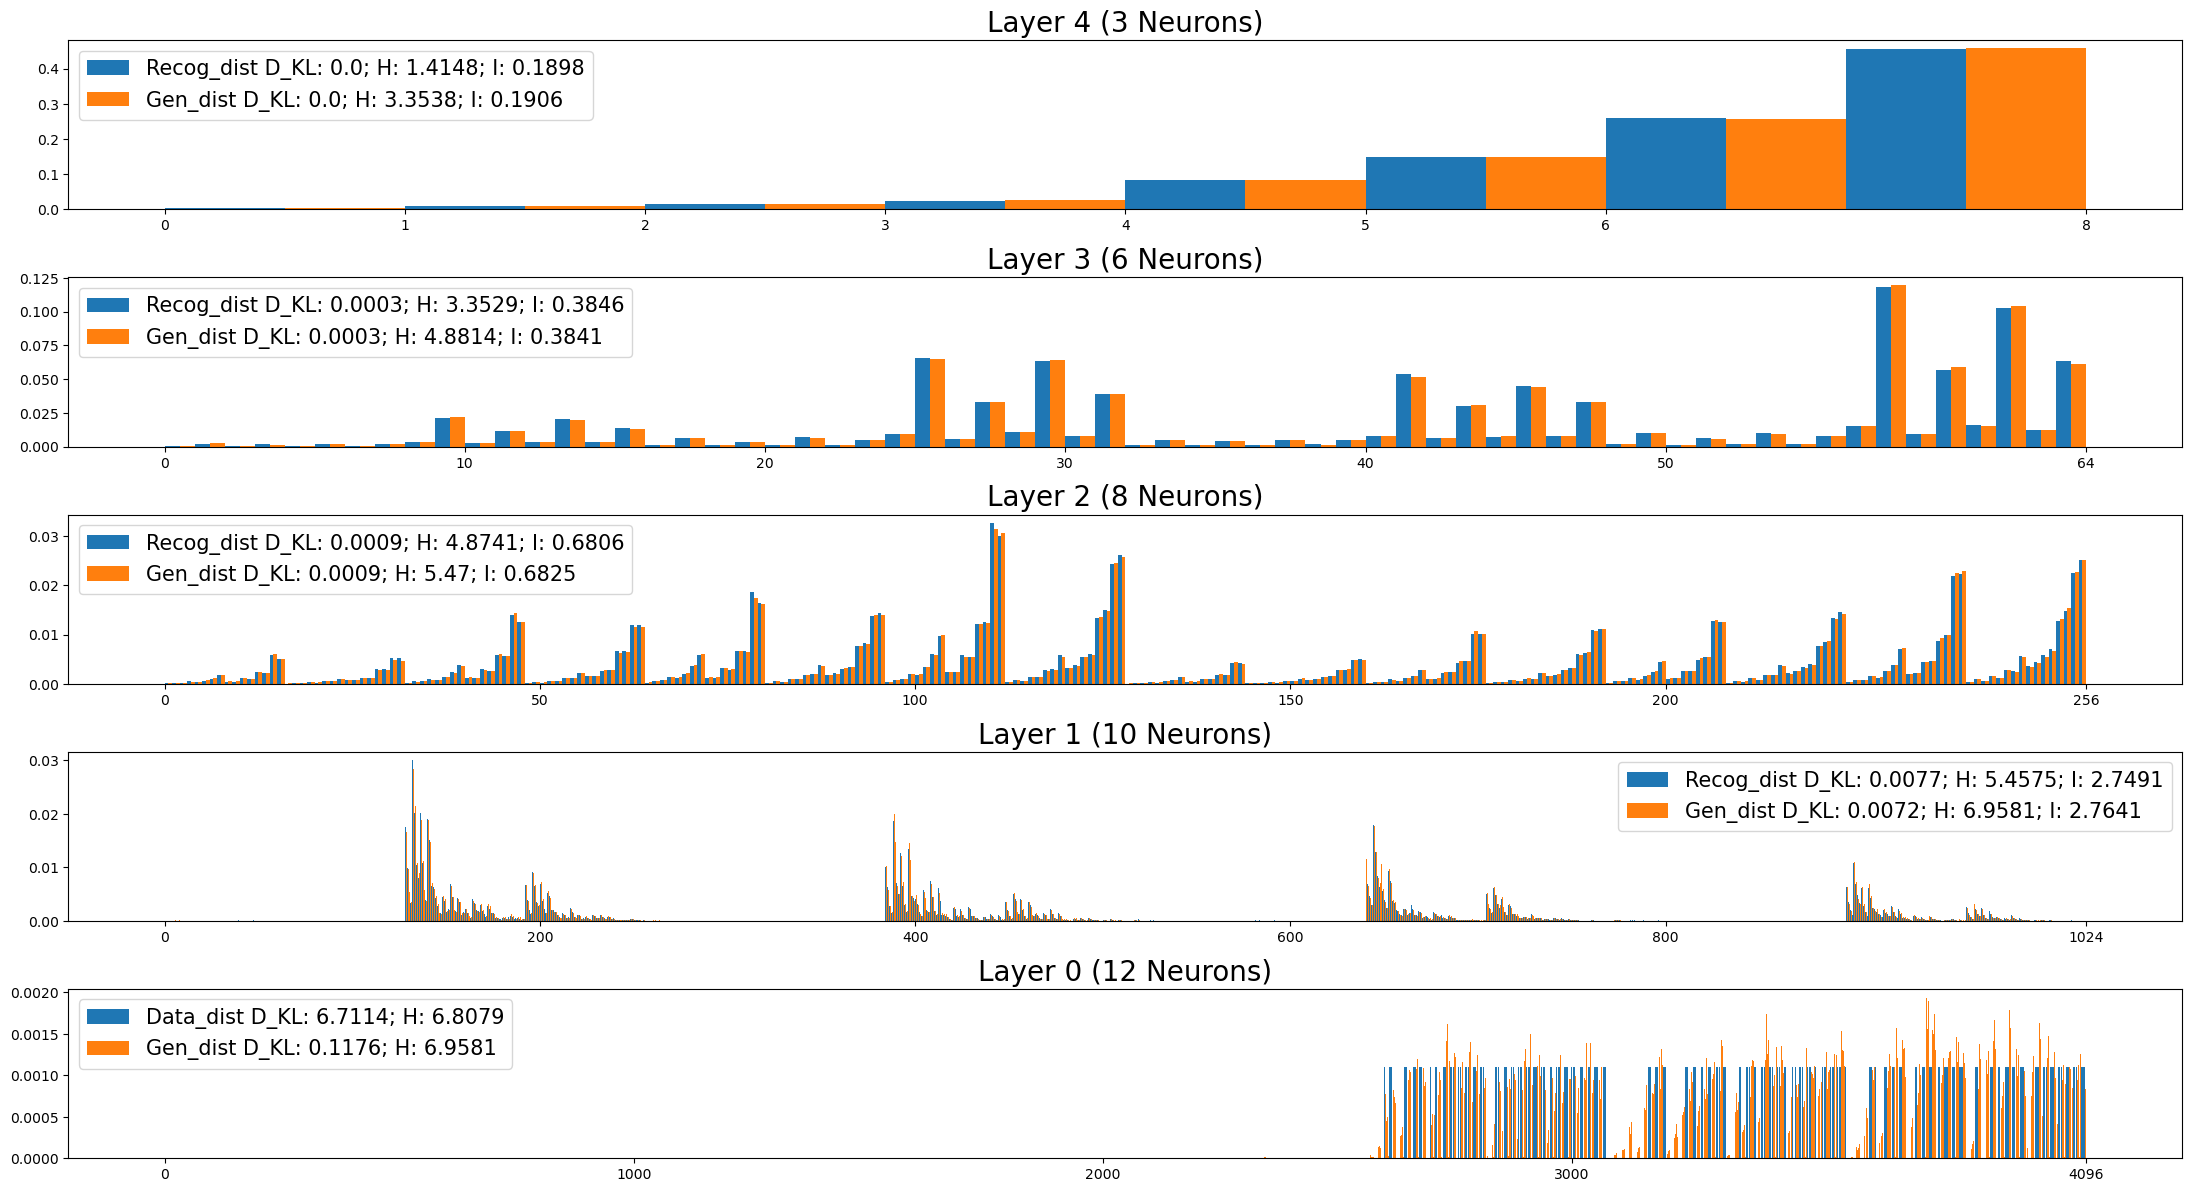

In [136]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    

plt.tight_layout(pad=1)    
plt.show()

Layer 0 Data_dist D_KL: 0.0008 H(Y): 7.3327
Layer 0 Gen_dist D_KL: 0.0001 H(Y): 7.333
Layer 1 Recognition Distribution D_KL: 0.0 H(Y): 5.5111 H(Y|X): 2.7084 I_XY: 2.8027
Layer 1 Generative  Distribution D_KL: 0.0 H(Y): 7.333 H(Y|X): 4.194 I_XY: 3.139
Layer 2 Recognition Distribution D_KL: 0.0001 H(Y): 4.8955 H(Y|X): 4.1935 I_XY: 0.702
Layer 2 Generative  Distribution D_KL: 0.0001 H(Y): 5.511 H(Y|X): 4.7875 I_XY: 0.7234
Layer 3 Recognition Distribution D_KL: 0.0 H(Y): 3.3625 H(Y|X): 2.9683 I_XY: 0.3942
Layer 3 Generative  Distribution D_KL: 0.0 H(Y): 4.9012 H(Y|X): 4.4973 I_XY: 0.4039
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 1.4149 H(Y|X): 1.225 I_XY: 0.1898
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 3.3637 H(Y|X): 3.1632 I_XY: 0.2004


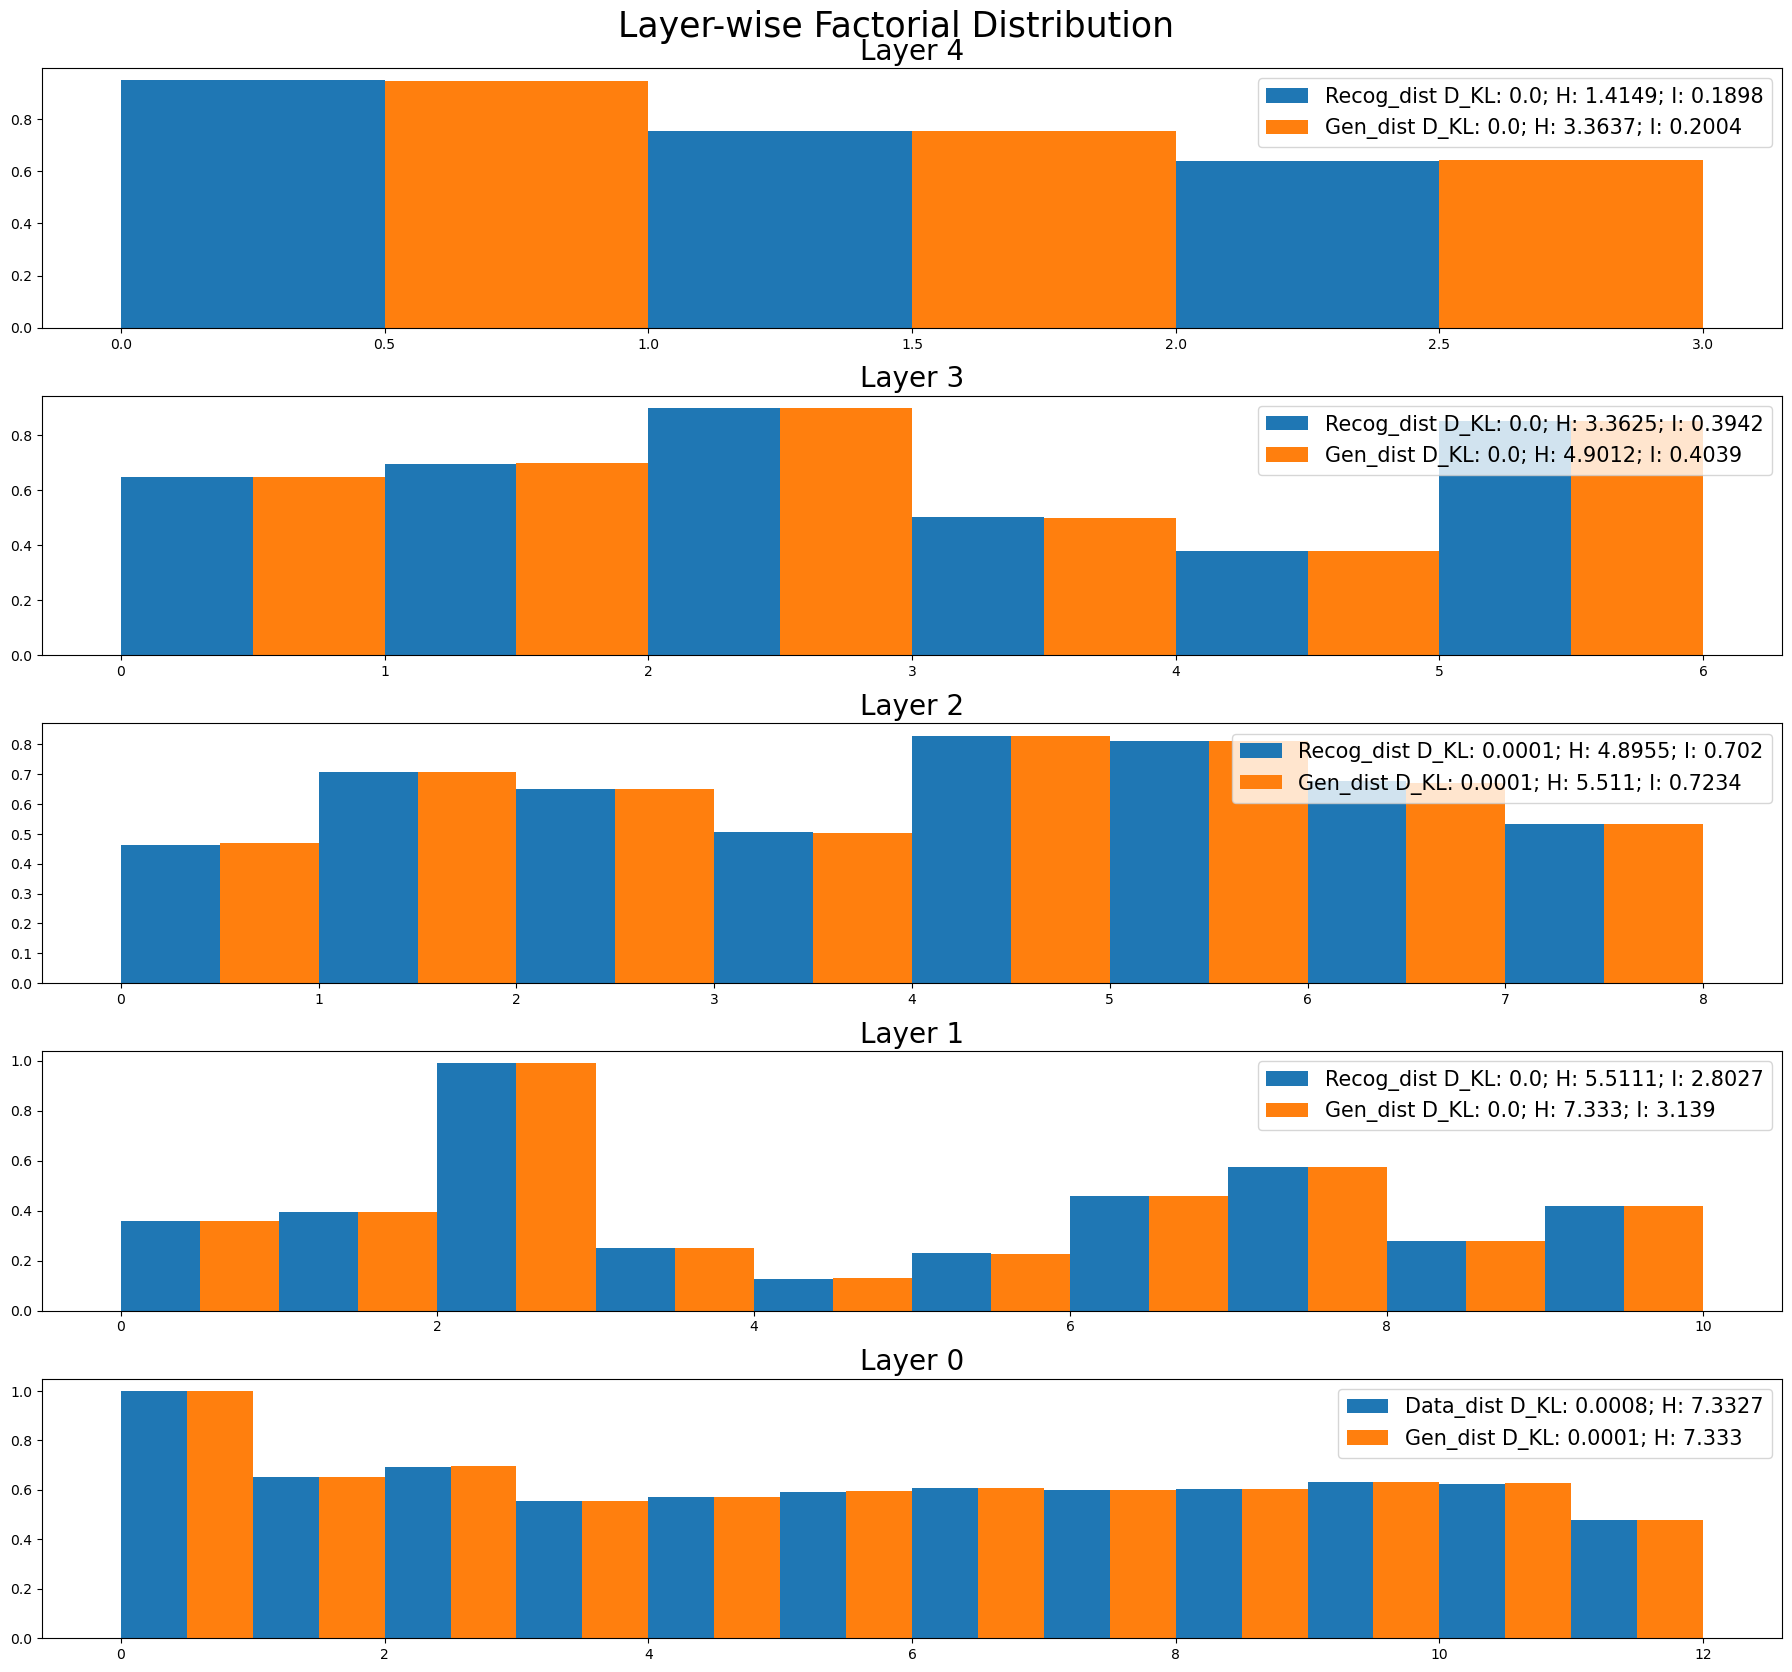

In [134]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig_ct.suptitle("Layer-wise Factorial Distribution",fontsize=25)
for i in range(n_layer-1):
    dist_s = sleep_ft['Layer '+str(i)+': dist']
    dist_w = wake_ft['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ft['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
           
        H_Y_s = sleep_ft['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ft['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
        H_Y_w = wake_ft['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
        H_Y_s = sleep_ft['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)

plt.tight_layout(pad=1)    
plt.show()

In [138]:
def causal(n_dz, Theta, cause_layer, cause_indices, dev):
    """
    Arguments:
    n_dz -- structure of the Hemholtz machine, torch tensor of shape (n_layer, )
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    cause_layer -- layer number of the cause. Integer
    cause_indices -- the indices of the causes out of 2^n_x in its layer. Torch tensor of shape (n_cause, )
    dev -- torch device
    
    Returns:
    causal_dist -- dictionary of causal ditributions, of length cause_layer.
    """
    causal_dist = {}
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[cause_layer], Theta["Theta_" + str(cause_layer) + str(cause_layer-1)], dev) # (2**n_z, 2**n_{z-1})
    dist_ct_pre = prob_ct[cause_indices,:]
    causal_dist['Layer '+str(cause_layer-1)+': dist'] = dist_ct_pre
    for i in range(1,cause_layer):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[cause_layer-i], Theta["Theta_" + str(cause_layer-i) + str(cause_layer-i-1)],dev)
        causal_dist['Layer '+str(cause_layer-i-1)+': dist'], causal_dist['Layer '+str(cause_layer-i-1)+': H_Y'], \
        causal_dist['Layer '+str(cause_layer-i-1)+': H_YX'] = prob_matrix_ct(dist_ct_pre, prob_ct)
        dist_ct_pre = causal_dist['Layer '+str(cause_layer-i-1)+': dist']
    return causal_dist

In [139]:
cause_layer = 4
cause_indices = torch.arange(2**n_dz[cause_layer])
causal_dist = causal(n_dz, Theta, cause_layer, cause_indices, dev)
causal_dist

{'Layer 3: dist': tensor([[1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02,
          1.5625e-02, 1.5625e-02, 1.5625e-02, 1.5625e-02],
         [8.6053e-03, 1.6621e-02, 4.9294e-03, 9.5208e-03, 4.1435e-03, 8.0030e-03,
          2.3735e-03, 

In [140]:
bnr = binarilize(cause_indices,n_dz[cause_layer],dev).to('cpu').numpy()
bnr

array([[0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 0, 1]], dtype=int64)

In [287]:
# fig, ax = plt.subplots(cause_layer*int(len(cause_indices)/2+0.5), 2, figsize=(18, 30))
# fig.suptitle("Causal Distributions",fontsize=25)
# for j in range(len(cause_indices)):
#     row_ind = int(j/2)*cause_layer
#     col_ind = j%2
#     for i in range(cause_layer-1,-1,-1):
#         dist = causal_dist['Layer '+str(i)+': dist'][j,:]
#         ax[row_ind+cause_layer-1-i, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',\
#                                label = "Data Distribution")
#         ax[row_ind+cause_layer-1-i, col_ind].set_title("Layer "+str(i)+'('+''.join(bnr[:,j].reshape(n_dz[cause_layer],).astype(str))+')',fontsize=20)
    
# #     H_Y = causal_dist['Layer '+str(i)+': H_Y'].item()
# #     H_YX = causal_dist['Layer '+str(i)+': H_YX'].item()
# #     I = H_Y - H_YX
# #     ax[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
# #                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
# #                                str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
# #     ax[n_layer-2-i].legend(fontsize=15)
    
# plt.tight_layout(pad=1)    
# plt.show()

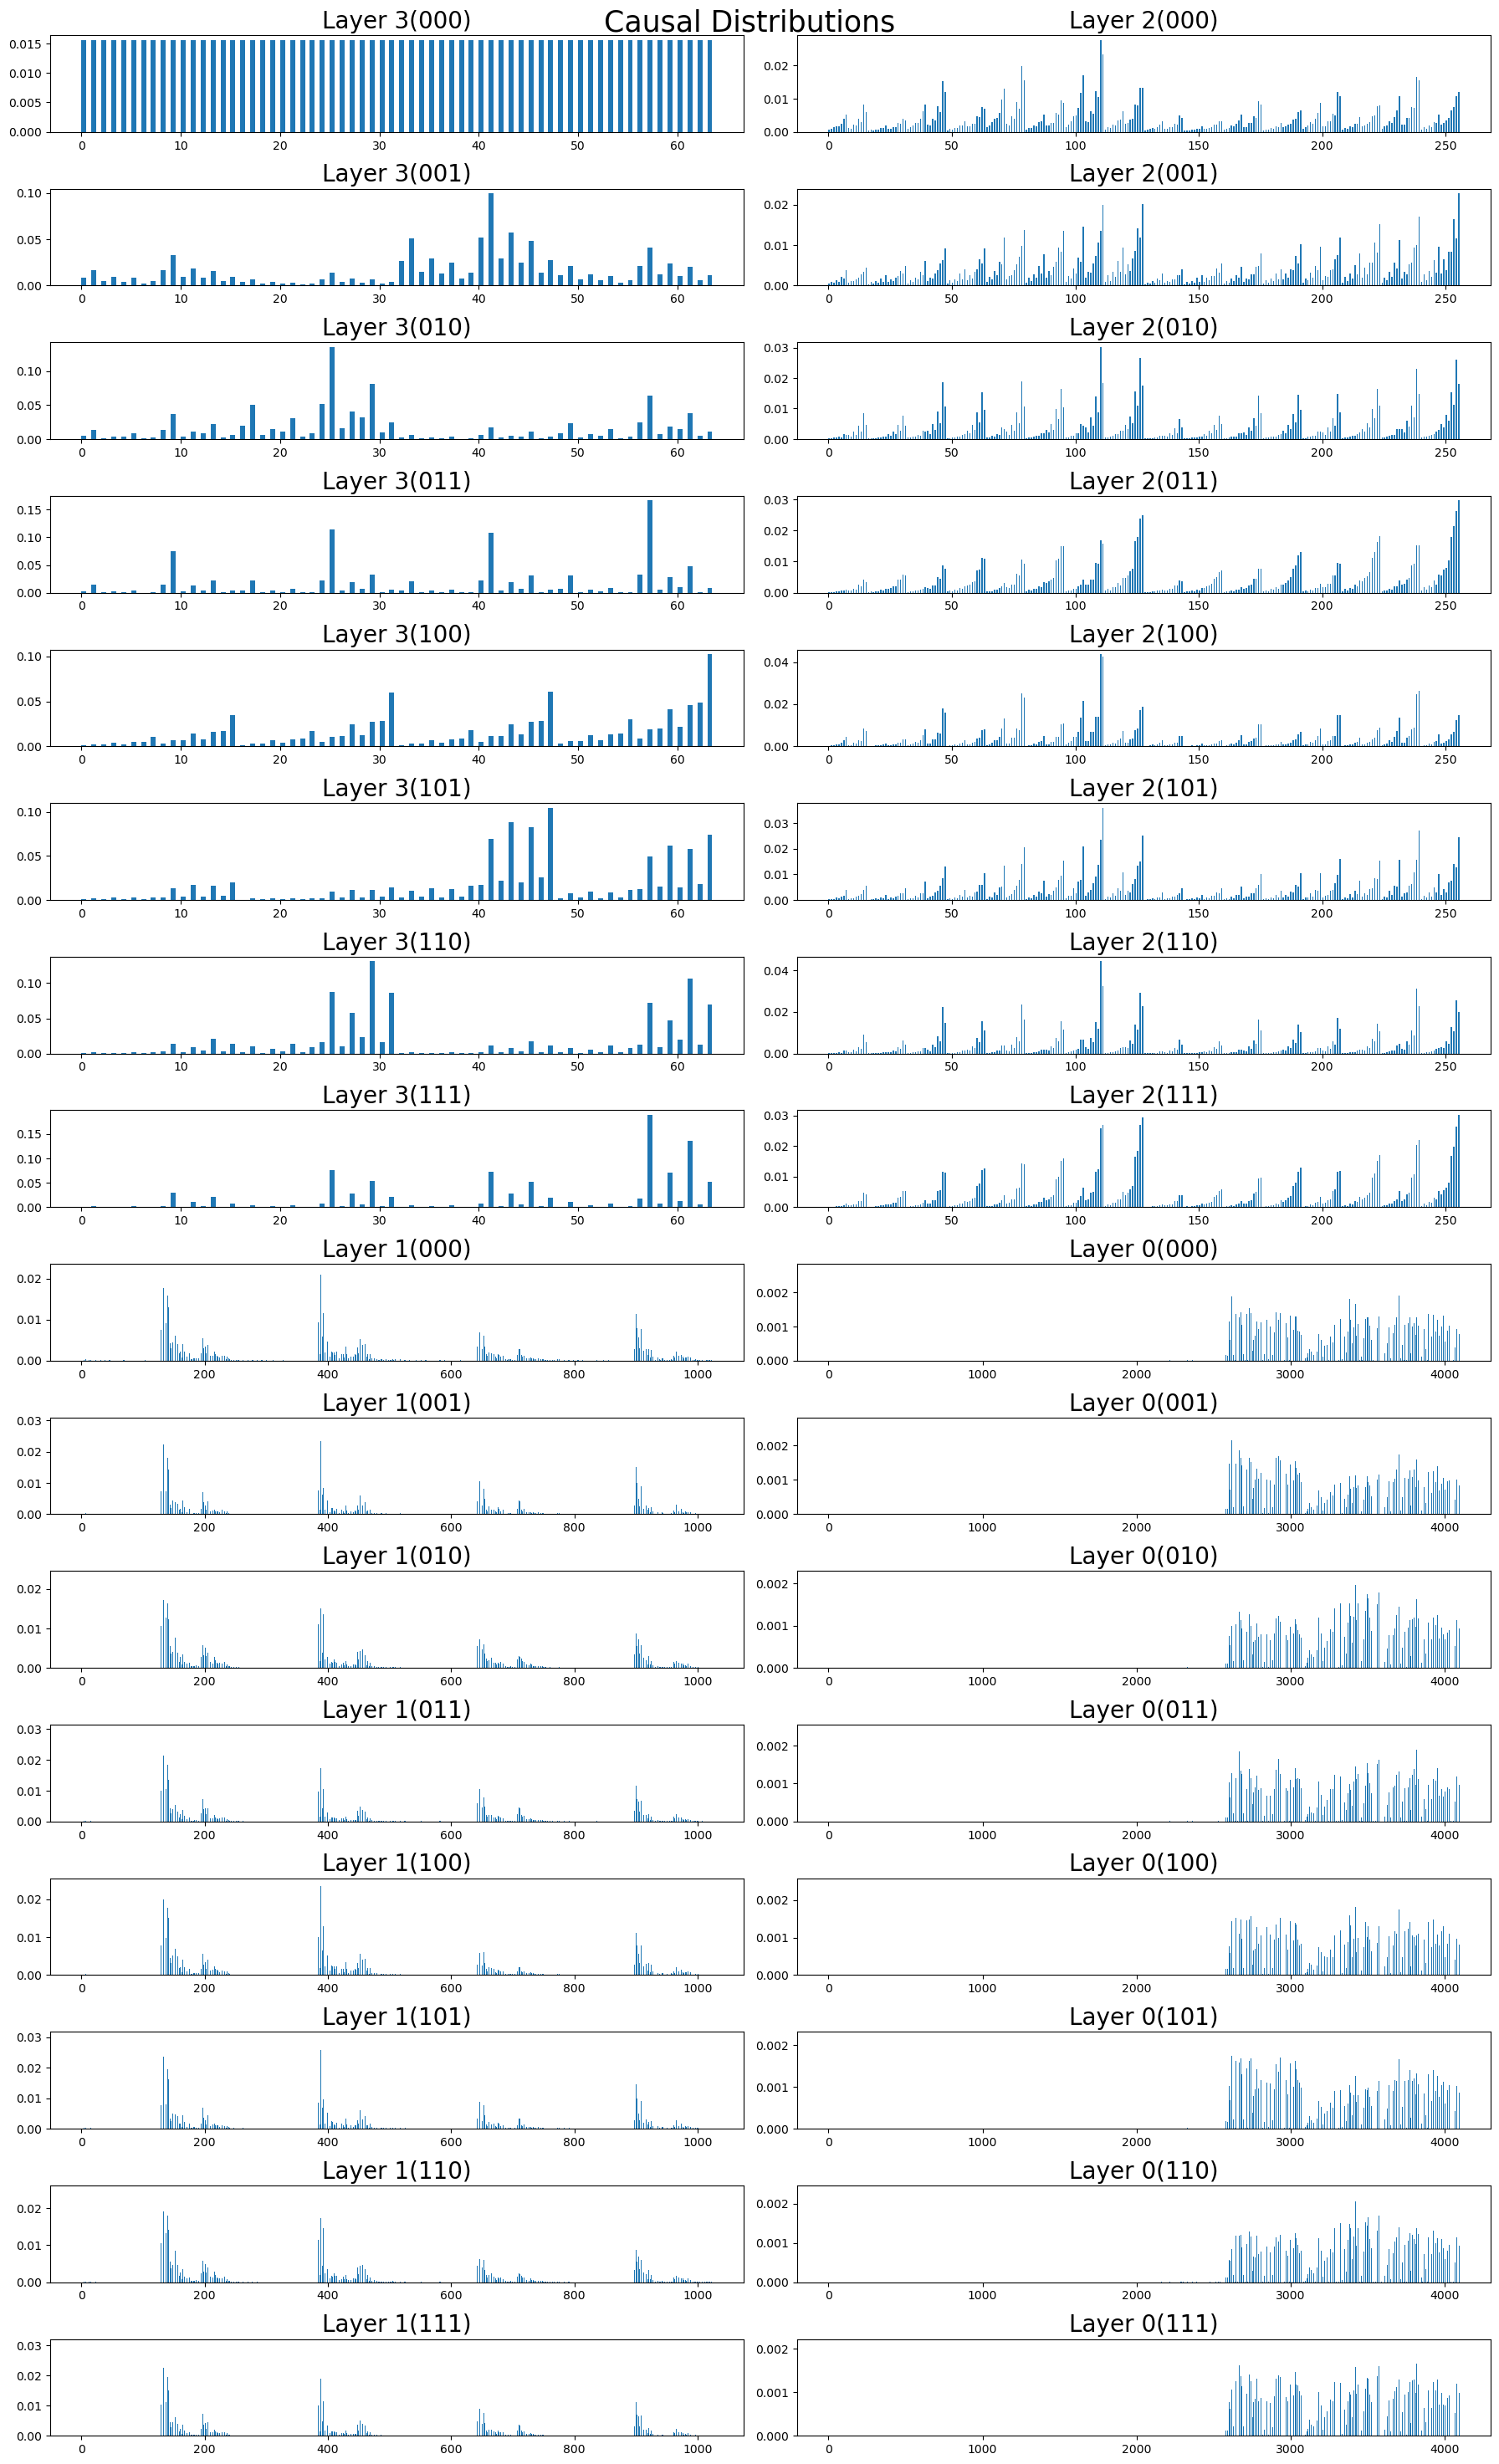

In [141]:
fig, ax = plt.subplots(cause_layer*int(len(cause_indices)/2+0.5), 2, figsize=(18, 30))
fig.suptitle("Causal Distributions",fontsize=25)
for i in range(cause_layer-1,-1,-1):
    row_ind = int((cause_layer-1-i)/2)*len(cause_indices)
    col_ind = (cause_layer-1-i)%2
    for j in range(len(cause_indices)):
        dist = causal_dist['Layer '+str(i)+': dist'][j,:]
        ax[row_ind+j, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',\
                               label = "Data Distribution")
        ax[row_ind+j, col_ind].set_title("Layer "+str(i)+'('+''.join(bnr[:,j].reshape(n_dz[cause_layer],).astype(str))+')',fontsize=20)
plt.tight_layout(pad=1)    
plt.show()

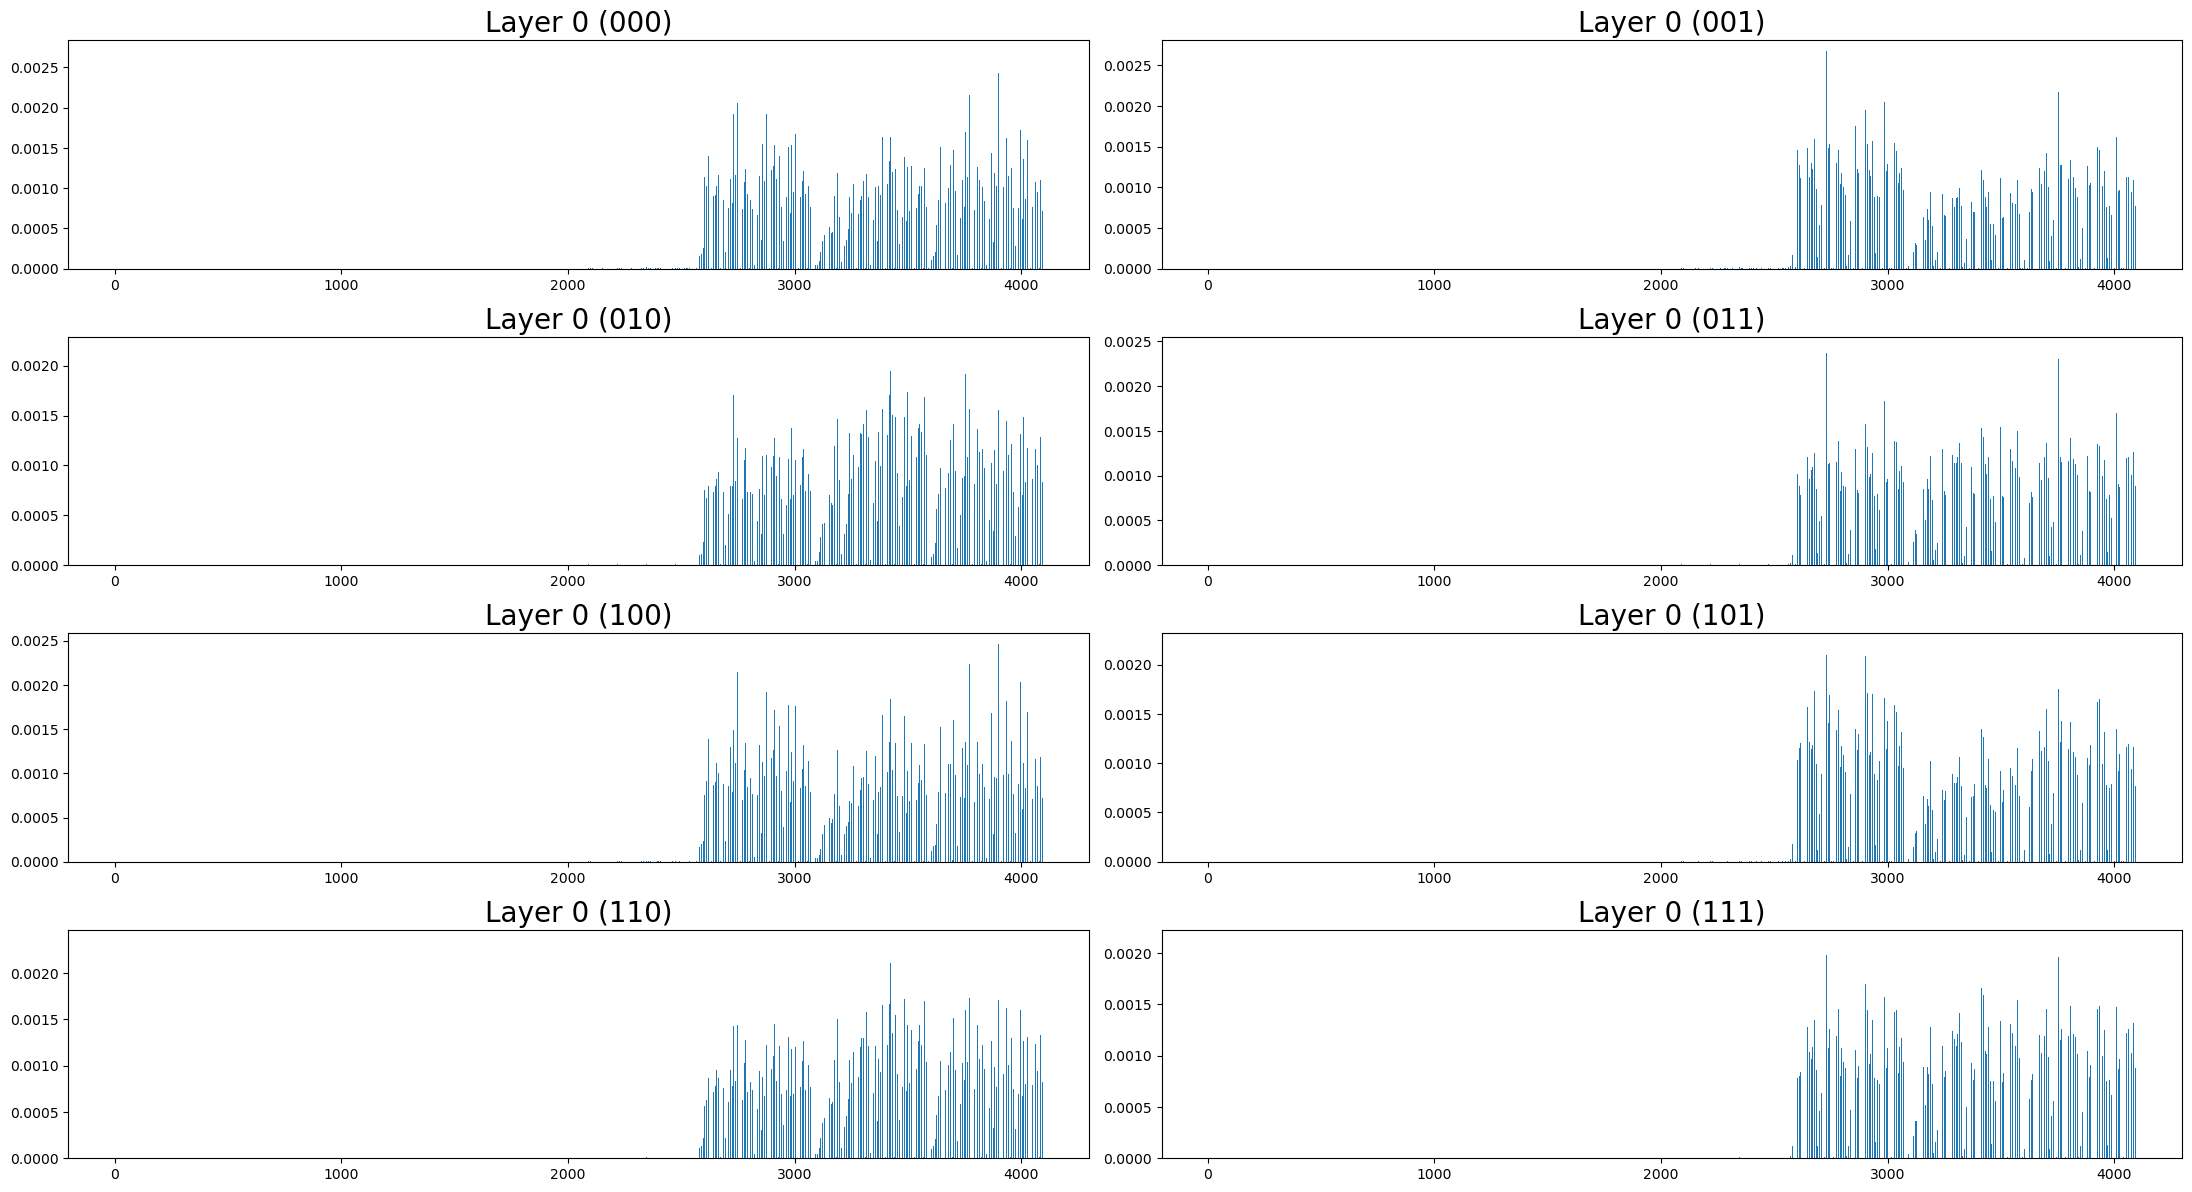

In [145]:
fig, ax = plt.subplots(int(len(cause_indices)/2+0.5), 2, figsize=(22, 12))
# fig.suptitle("Causal Distributions",fontsize=25)
i = cause_layer-4
for j in range(len(cause_indices)):
    dist = causal_dist['Layer '+str(i)+': dist'][j,:]
    row_ind = int(j/2)
    col_ind = j%2
    ax[row_ind, col_ind].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.5,align='edge',label = "Data Distribution")
    ax[row_ind, col_ind].set_title("Layer "+str(i)+' ('+''.join(bnr[:,j].reshape(n_dz[cause_layer],).astype(str))+')',fontsize=20)
plt.tight_layout(pad=1)    
plt.show()

In [293]:
anti_data_dist = (data_dist == 0).long()/(data_dist == 0).long().sum()
anti_data_dist

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

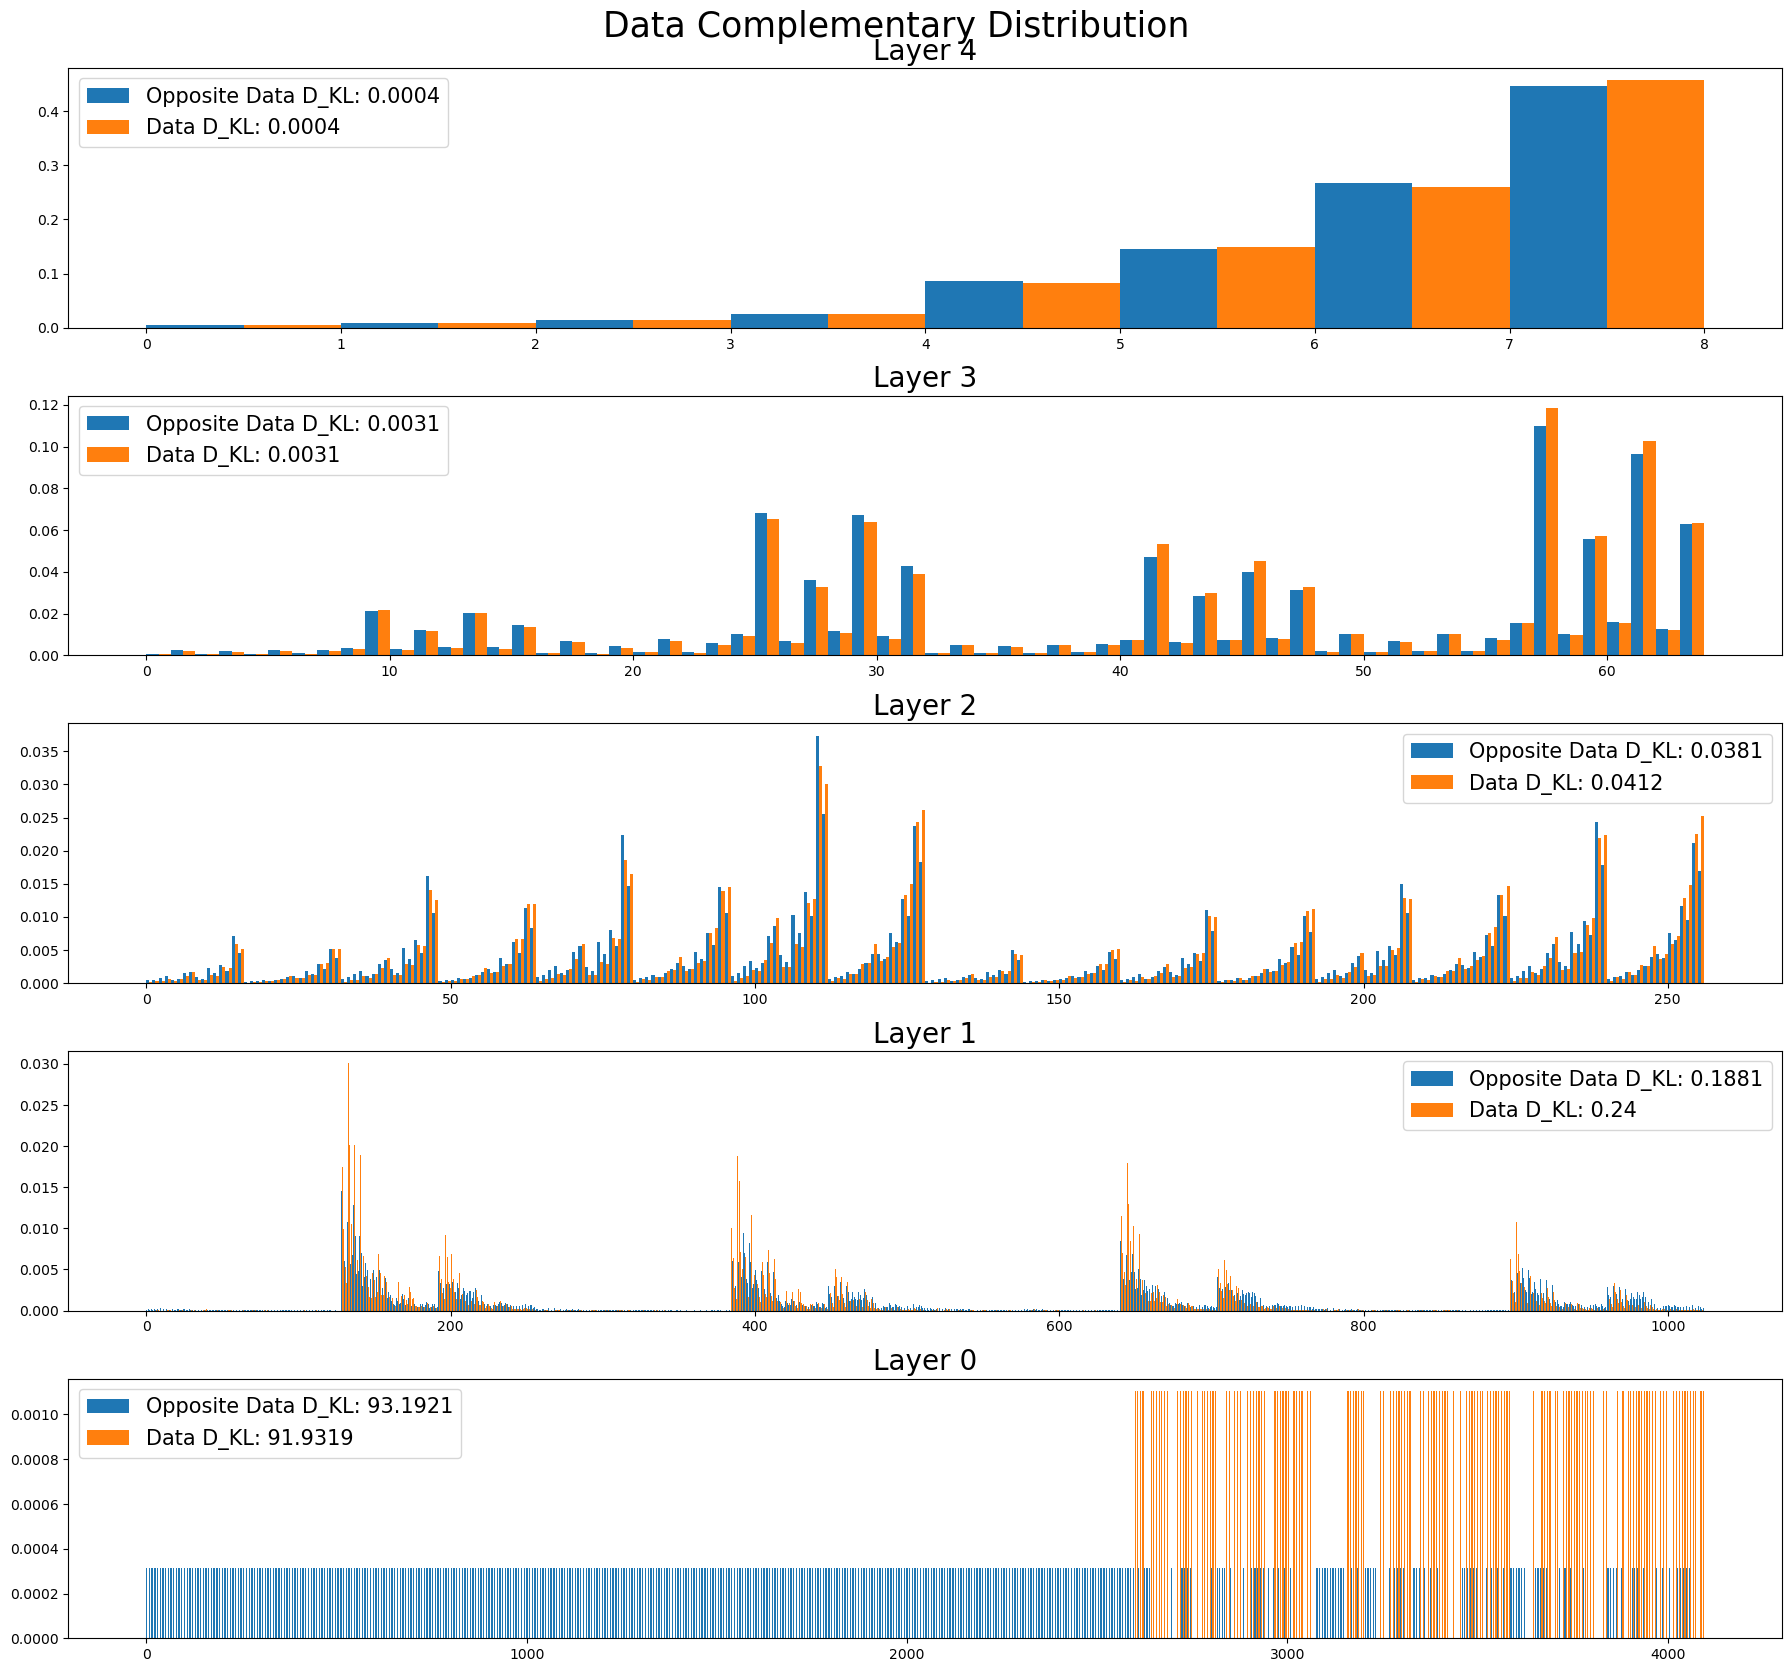

In [300]:
fig, ax = plt.subplots(n_layer-1, 1, figsize=(18, 17))
fig.suptitle("Data Complementary Distribution",fontsize=25)
dist_ct_pre = anti_data_dist
for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    D_KL_opp = KL_divergence(dist_w, dist_ct_pre).item()
    D_KL = KL_divergence(dist_ct_pre,dist_w).item()
    
    ax[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_ct_pre.to('cpu').numpy(),width=0.5,align='edge',\
                        label='Opposite Data D_KL: '+ str(np.around(D_KL_opp,4)))
    ax[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                        label = "Data D_KL: "+ str(np.around(D_KL,4)))
    ax[n_layer-2-i].set_title("Layer "+str(i),fontsize=20)
    ax[n_layer-2-i].legend(fontsize=15)
    
    if i < n_layer-2:
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        dist_ct_pre = torch.matmul(dist_ct_pre, prob_ct)
    
plt.tight_layout(pad=1)    
plt.show()

### Plot Analytic

In [72]:
# Analytic_ws_batch['Index'] = Analytic_ws_batch.index

In [ ]:
# for i in range(len(col_list)):
#     Analytic_ws_batch.plot(x='Index',y=col_list[i],kind='line',legend=True)
# plt.close()

In [2]:
Analytic_ws_batch = pd.read_csv('Analytic_ws_batch.csv', sep=",")
Analytic_ws_batch

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0             0.693147          0.693147          0.693147          0.693147   
1             0.691468          0.693039          0.693183          0.693046   
2             0.689466          0.693011          0.693128          0.692630   
3             0.688073          0.693303          0.692915          0.693097   
4             0.684058          0.691606          0.692689          0.693507   
...                ...               ...               ...               ...   
2196          0.265112          0.514316          0.487237          0.391851   
2197          0.260851          0.528620          0.500634          0.416142   
2198          0.273934          0.516208          0.486625          0.407732   
2199          0.273755          0.529722          0.496625          0.409228   
2200          0.271380          0.521549          0.494629          0.404094   

      Theta_Loss_Layer_0  Theta_Loss_Layer_1  Theta_Loss_Layer_2  \
0               0.693147            0.693147            0.693147   
1               0.616928            0.692587            0.693104   
2               0.614550            0.689150            0.693249   
3               0.614205            0.686890            0.691830   
4               0.614066            0.687006            0.691499   
...                  ...                 ...                 ...   
2196            0.345046            0.479688            0.557601   
2197            0.350034            0.481594            0.563655   
2198            0.346137            0.476487            0.565469   
2199            0.346964            0.485345            0.562294   
2200            0.342596            0.470797            0.565000   

      Theta_Loss_Layer_3  Theta_Loss_Layer_4  Recog_D_KL_Layer_0  ...  \
0               0.693147            0.693147           68.994232  ...   
1               0.693093            0.693318           33.012474  ...   
2               0.692969            0.693229           31.326004  ...   
3               0.692660            0.692917           30.740173  ...   
4               0.692571            0.692510           30.498985  ...   
...                  ...                 ...                 ...  ...   
2196            0.532164            0.466547            6.710065  ...   
2197            0.519253            0.465670            6.712999  ...   
2198            0.516958            0.478469            6.719982  ...   
2199            0.529739            0.471317            6.709084  ...   
2200            0.523591            0.475820            6.711415  ...   

      Recog_D_KL_Layer_3  Gen_H_Layer_3  Gen_I_Layer_3  Gen_D_KL_Layer_3  \
0               0.000012       4.158881   9.536743e-07          0.000012   
1               0.000131       4.158812   6.628036e-05          0.000130   
2               0.000017       4.158498   1.745224e-04          0.000016   
3               0.000145       4.158237   3.027916e-04          0.000145   
4               0.000229       4.157988   3.771782e-04          0.000229   
...                  ...            ...            ...               ...   
2196            0.000447       3.369449   1.912861e-01          0.000443   
2197            0.000339       3.356569   1.914661e-01          0.000334   
2198            0.000366       3.352261   1.908796e-01          0.000359   
2199            0.000311       3.359583   1.914580e-01          0.000305   
2200            0.000348       3.353837   1.906011e-01          0.000343   

      Recog_H_Layer_4  Recog_I_Layer_4  Recog_D_KL_Layer_4  Gen_H_Layer_4  \
0            2.079438     9.536743e-07            0.000007       2.079439   
1            2.079191     8.130074e-05            0.000086       2.079327   
2            2.079260     9.799004e-05            0.000026       2.079244   
3            2.079297     1.435280e-04            0.000003       2.079253   
4            2.079173     1.442432e-04            0.0

In [3]:
x = np.arange(len(Analytic_ws_batch))

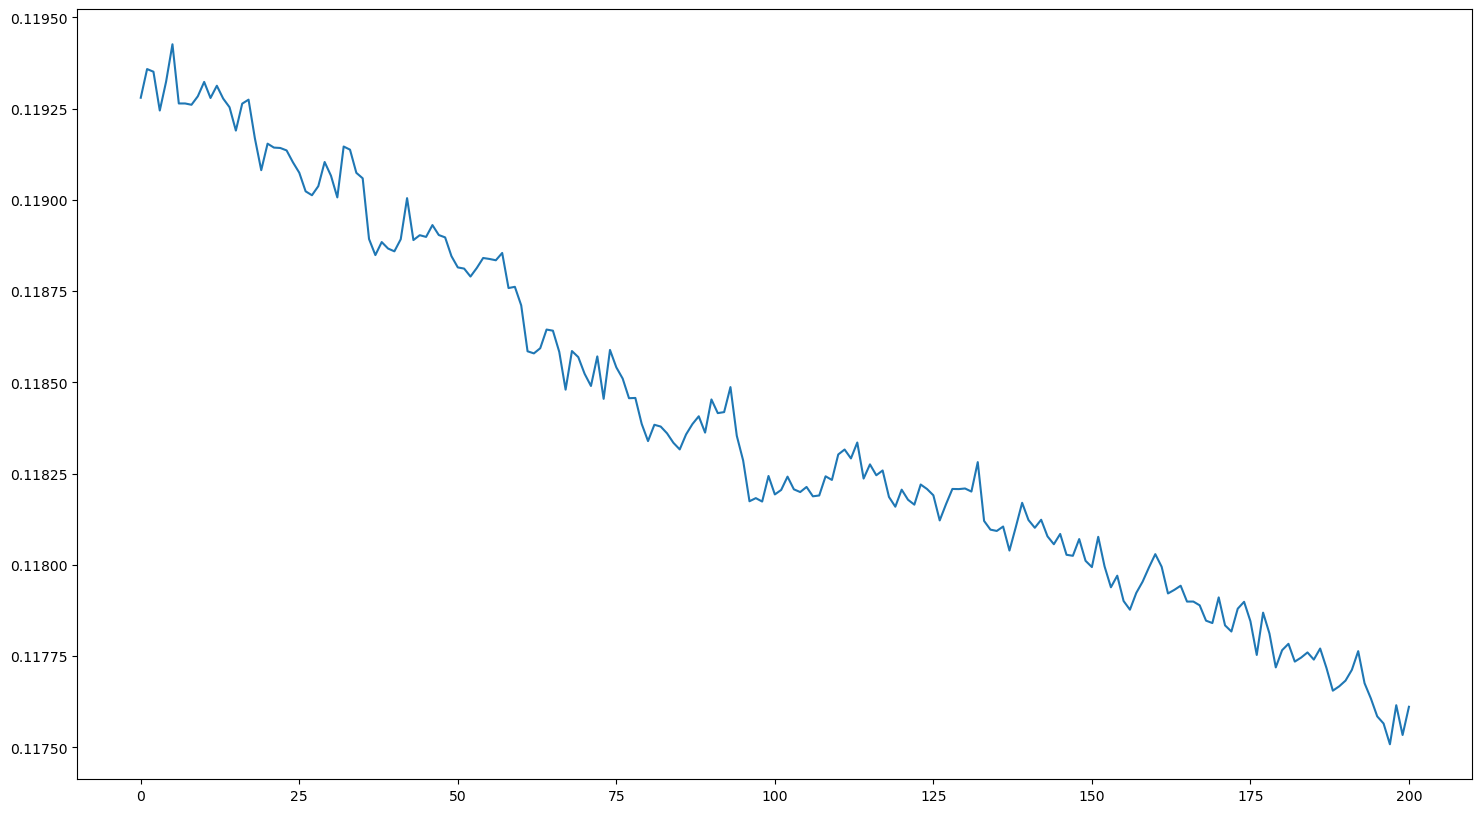

In [11]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic_ws_batch['Gen_D_KL_Layer_'+str(0)])[2000:])
plt.show()

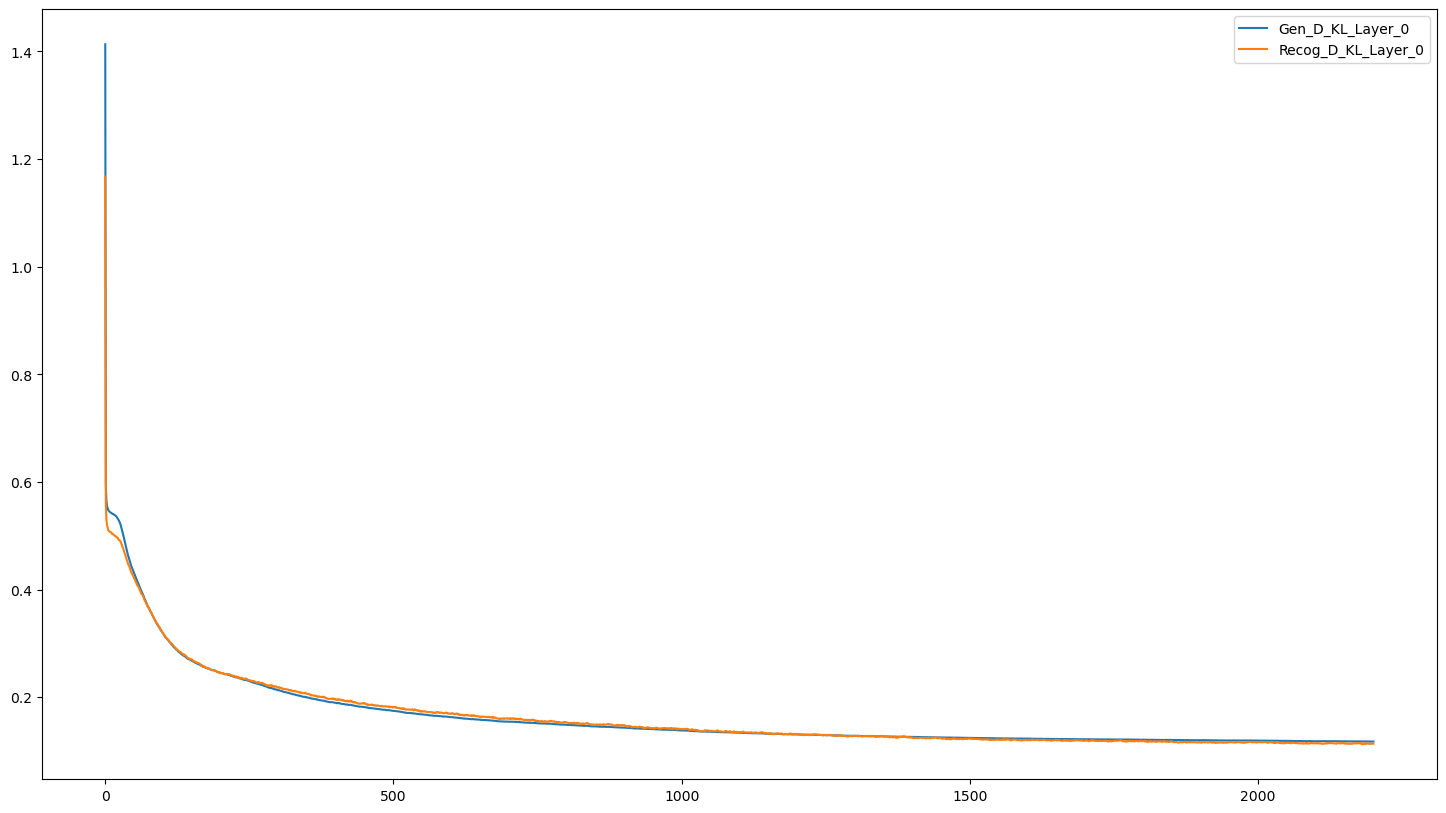

In [7]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_batch['Gen_D_KL_Layer_'+str(0)]),label = 'Gen_D_KL_Layer_'+str(0))
ax.plot(x, np.array(Analytic_ws_batch['Recog_D_KL_Layer_'+str(0)])/np.array(Analytic_ws_batch['Recog_D_KL_Layer_'+str(0)]).mean()*np.array(Analytic_ws_batch['Gen_D_KL_Layer_'+str(0)]).mean(),label = 'Recog_D_KL_Layer_'+str(0))
# ax.plot(x, np.array(Analytic_ws_batch['Recog_D_KL_Layer_'+str(0)]),label = 'Recog_D_KL_Layer_'+str(0))
ax.legend()
plt.show()

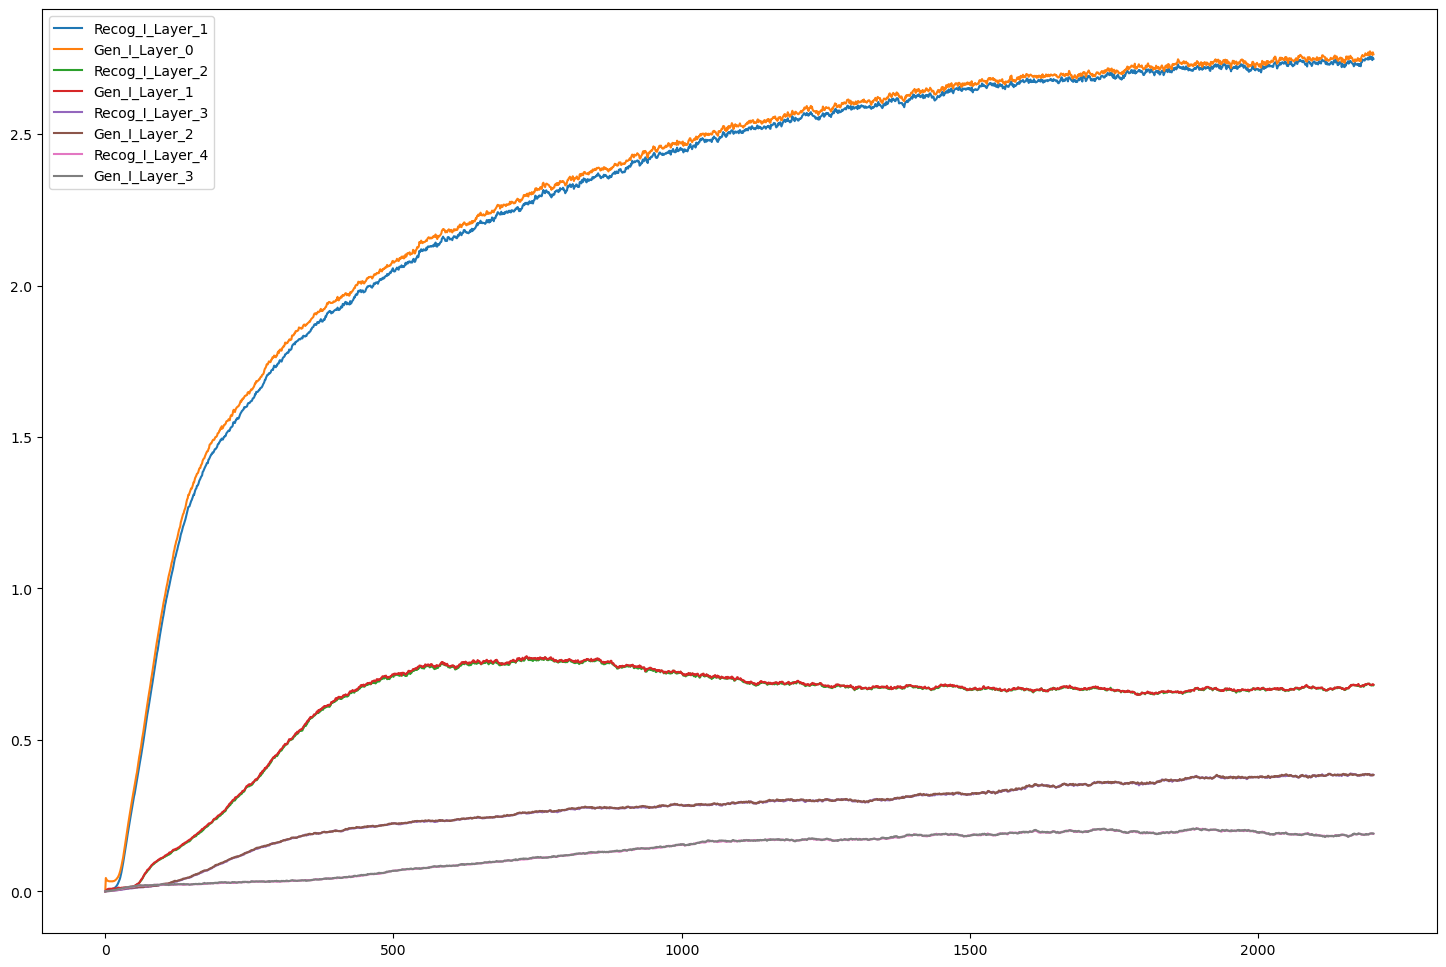

In [264]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(n_layer-2):
    ax.plot(x, np.array(Analytic_ws_batch['Recog_I_Layer_'+str(i+1)]),label = 'Recog_I_Layer_'+str(i+1))
    ax.plot(x, np.array(Analytic_ws_batch['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

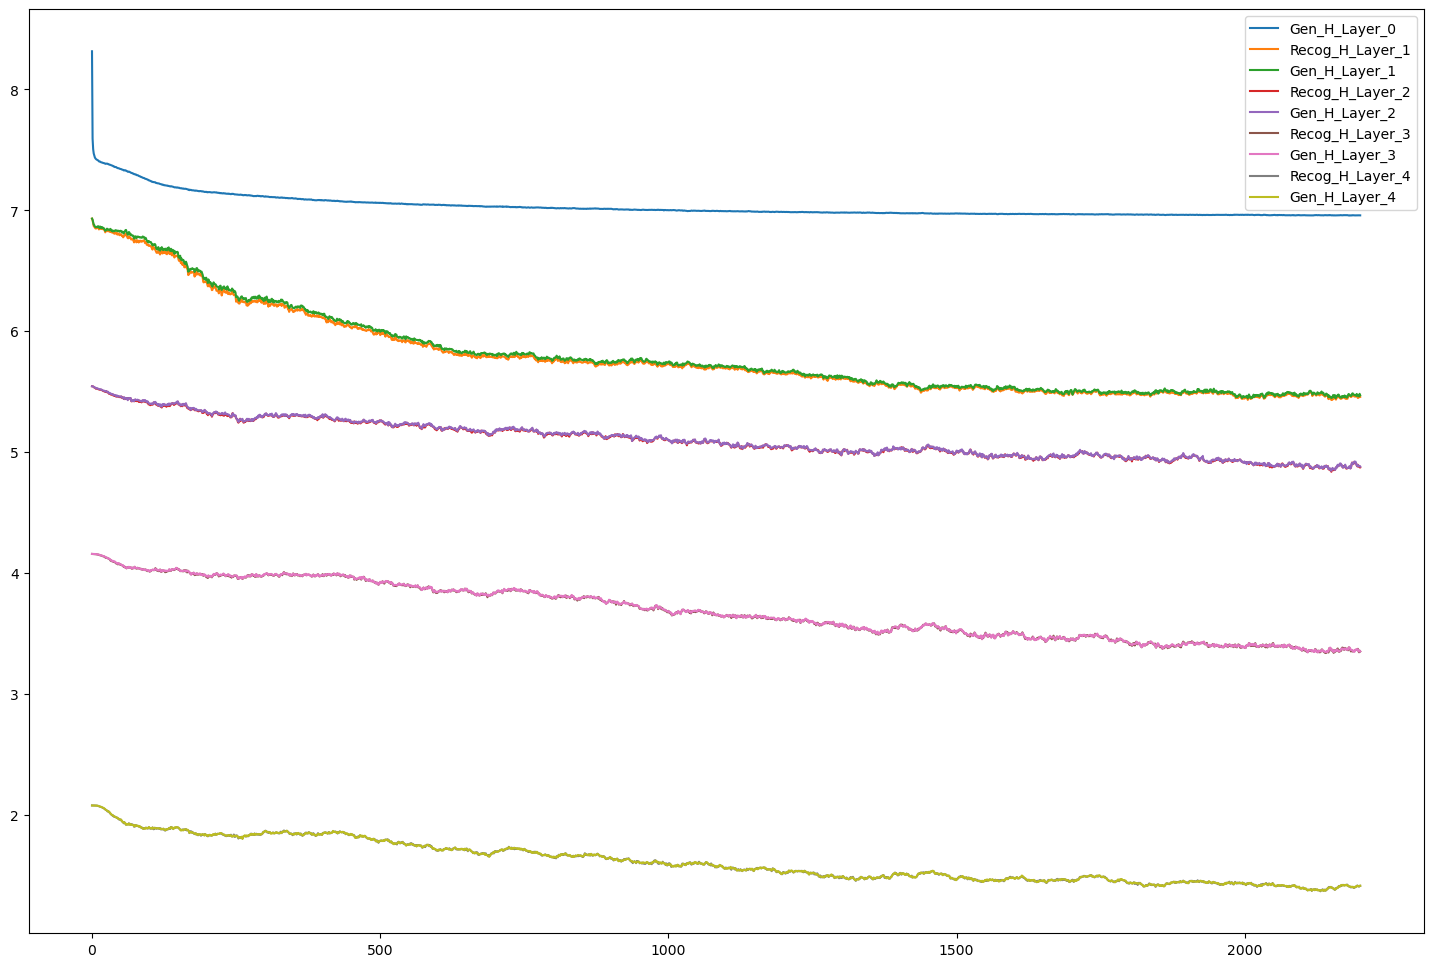

In [265]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(x, np.array(Analytic_ws_batch['Gen_H_Layer_'+str(0)]),label = 'Gen_H_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_batch['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_batch['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

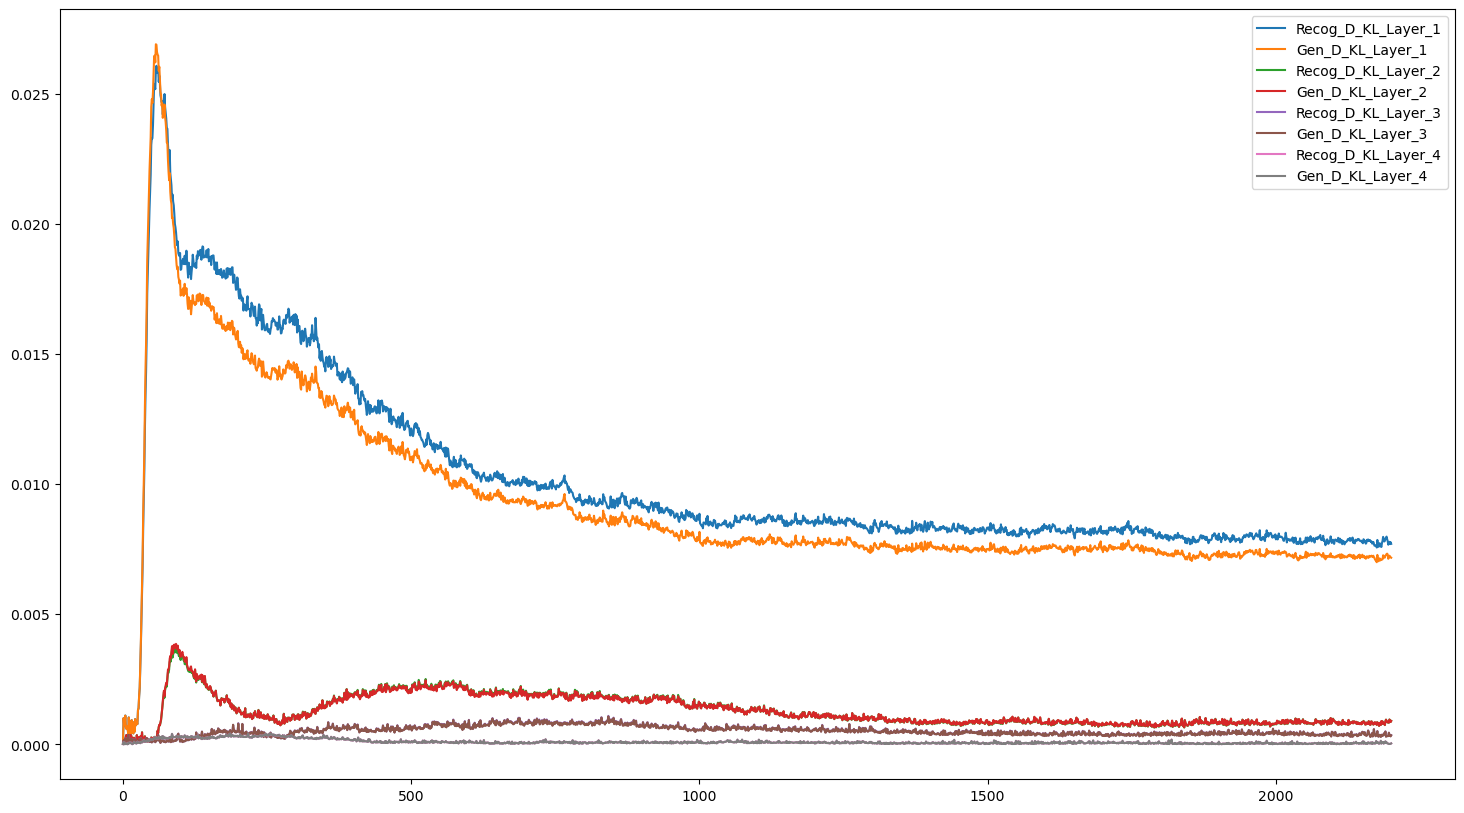

In [266]:
fig, ax = plt.subplots(figsize=(18, 10))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_batch['Recog_D_KL_Layer_'+str(i)]),label = 'Recog_D_KL_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_batch['Gen_D_KL_Layer_'+str(i)]),label = 'Gen_D_KL_Layer_'+str(i))
ax.legend()
plt.show()

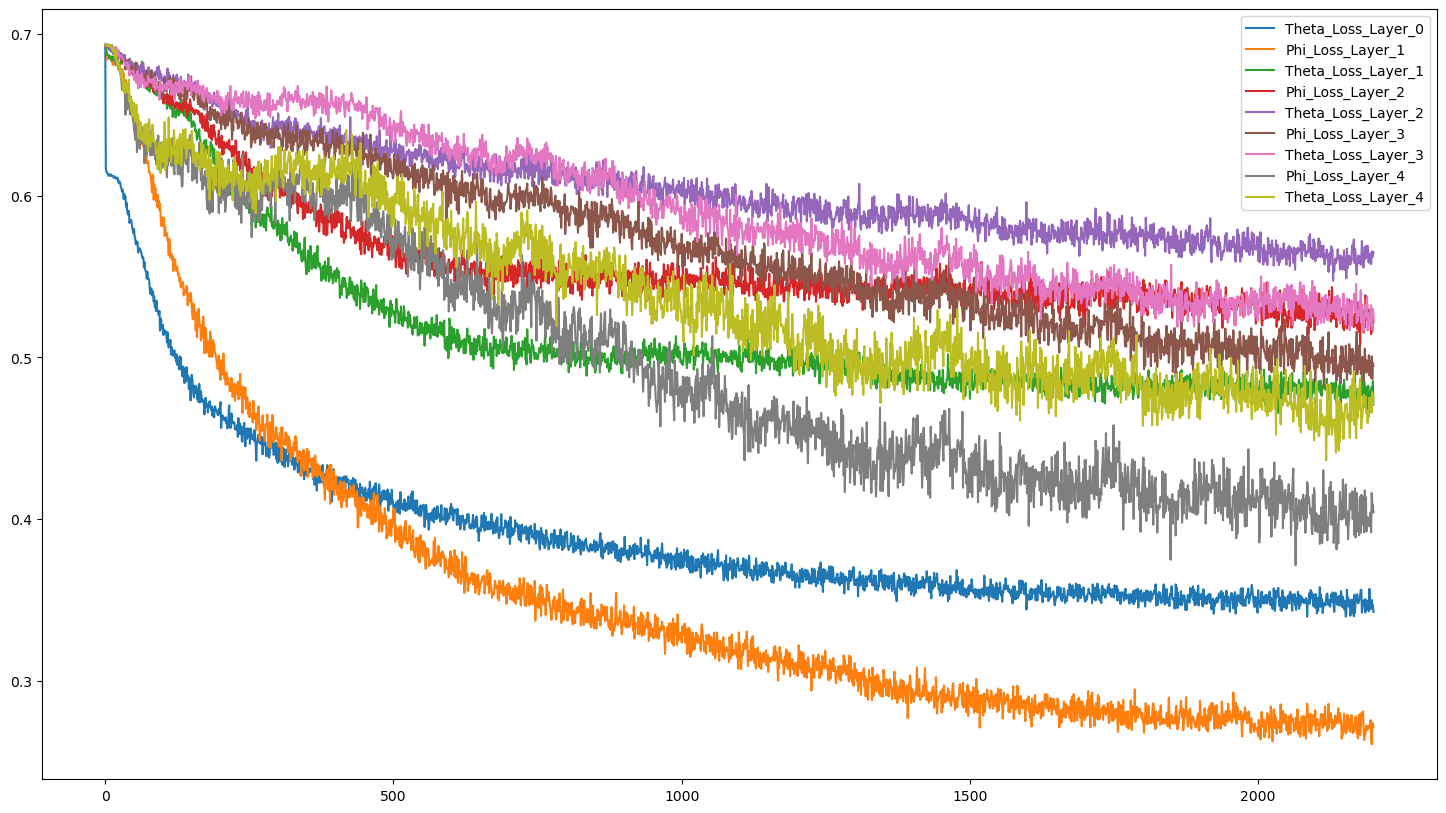

In [267]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(x, np.array(Analytic_ws_batch['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(x, np.array(Analytic_ws_batch['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(x, np.array(Analytic_ws_batch['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

### Train with Predictive Processing

In [146]:
para = np.load('Parameters_ws_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [147]:
def pp_dist(Theta,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    dev -- torch device
    Returns:
    pp_dict -- pp distribution dictionary, of length n_layer-1
    """
    pp_dict = {}
    dist_pre = torch.ones(1,device=dev)
    for i in range(len(Theta),0,-1):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Theta["Theta_" + str(i) + str(i-1)],dev)
        dist_pre = torch.matmul(dist_pre,prob_ct)
        pp_dict['Layer_'+str(i-1)] = dist_pre
    return pp_dict

In [148]:
pp_dict = pp_dist(Theta,dev)

In [149]:
def ground_truth(dataset,dev):
    """
    Arguments:
    dataset -- data, torch tensor of shape (n_d,n_data)
    dev -- torch device
    Returns:
    data_dist -- data distribution. Torch tensor of shape (2**n_d,)
    """
    data_dcm = decimalize(dataset,dev)
    values_d,counts_d = torch.unique(data_dcm,return_counts=True)
    data_dist = torch.zeros(2**dataset.shape[0],device=dev)
    data_dist[values_d]=counts_d/dataset.shape[1]
    return data_dist

In [61]:
entire_set = binarilize(np.arange(2**n_d),n_d,dev)
entire_set

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 1, 0, 1]], device='cuda:0')

In [150]:
def wake_dist_pp(Phi, data_dist, n_dz, pp_dict, dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data_dist -- data distribution with max entry as 1. Torch tensor of shape (2**n_d,)
    n_dz -- Helmholtz machine structure. Torch tensor of shape (n_layer,)
    pp_dict -- pp distribution dictionary, of length n_layer-1
    dev -- torch device
    Returns:
    
    """
    cause_dist = {}
    cause_dist_pp = {}
    dist_pre = data_dist
    cause_dist['Layer_0'] = dist_pre
    dist_pre_pp = data_dist * pp_dict['Layer_0']
    dist_pre_pp = dist_pre_pp/dist_pre_pp.sum()
    cause_dist_pp['Layer_0'] = dist_pre_pp
    for i in range(n_layer-2):
        prob_ft, prob_ct = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        dist_pre = torch.matmul(dist_pre, prob_ct)
        cause_dist['Layer_'+str(i+1)] = dist_pre
        
        dist_pre_pp = torch.matmul(dist_pre_pp, prob_ct) * pp_dict['Layer_'+str(i+1)]
        dist_pre_pp = dist_pre_pp/dist_pre_pp.sum()
        cause_dist_pp['Layer_'+str(i+1)] = dist_pre_pp
    return cause_dist, cause_dist_pp

In [63]:
test_dist = ground_truth(entire_set,dev)
test_dist

tensor([0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002], device='cuda:0')

In [67]:
cause_dist, cause_dist_pp = wake_dist_pp(Phi, test_dist, n_dz, pp_dict, dev)

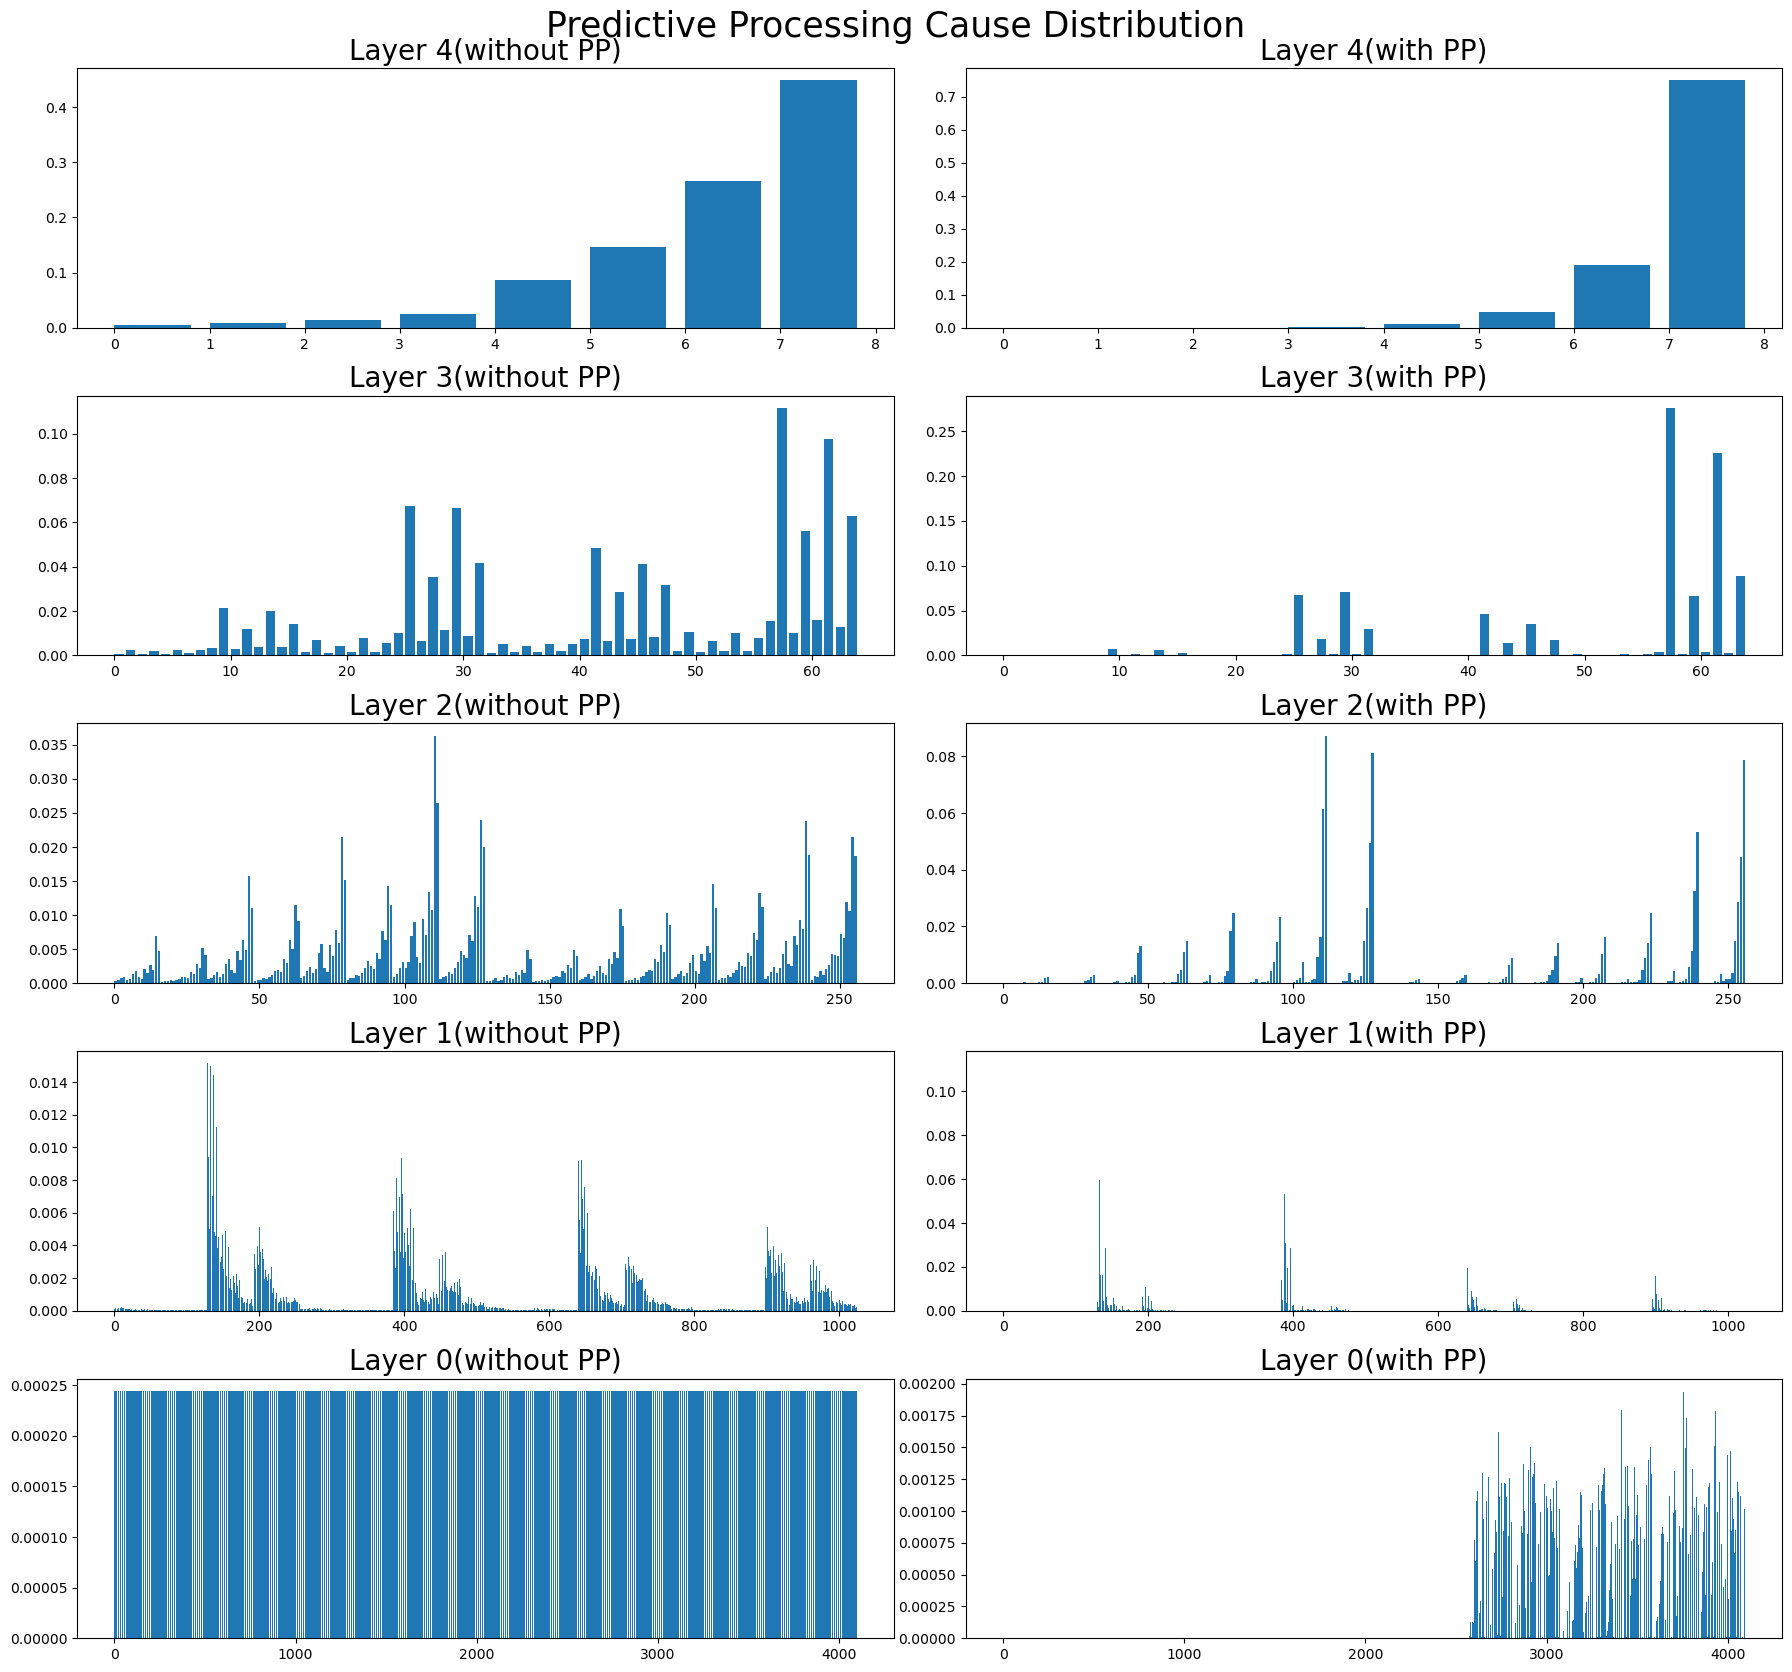

In [68]:
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 17))
fig.suptitle("Predictive Processing Cause Distribution",fontsize=25)
for i in range(n_layer-1):
    dist = cause_dist['Layer_'+str(i)]
    dist_pp = cause_dist_pp['Layer_'+str(i)]
    
    ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,0].set_title("Layer "+str(i)+'(without PP)',fontsize=20)
    ax[n_layer-2-i,1].set_title("Layer "+str(i)+'(with PP)',fontsize=20)

plt.tight_layout(pad=1)    
plt.show()

In [43]:
test_dist = ground_truth(well_formed_set,dev)
test_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

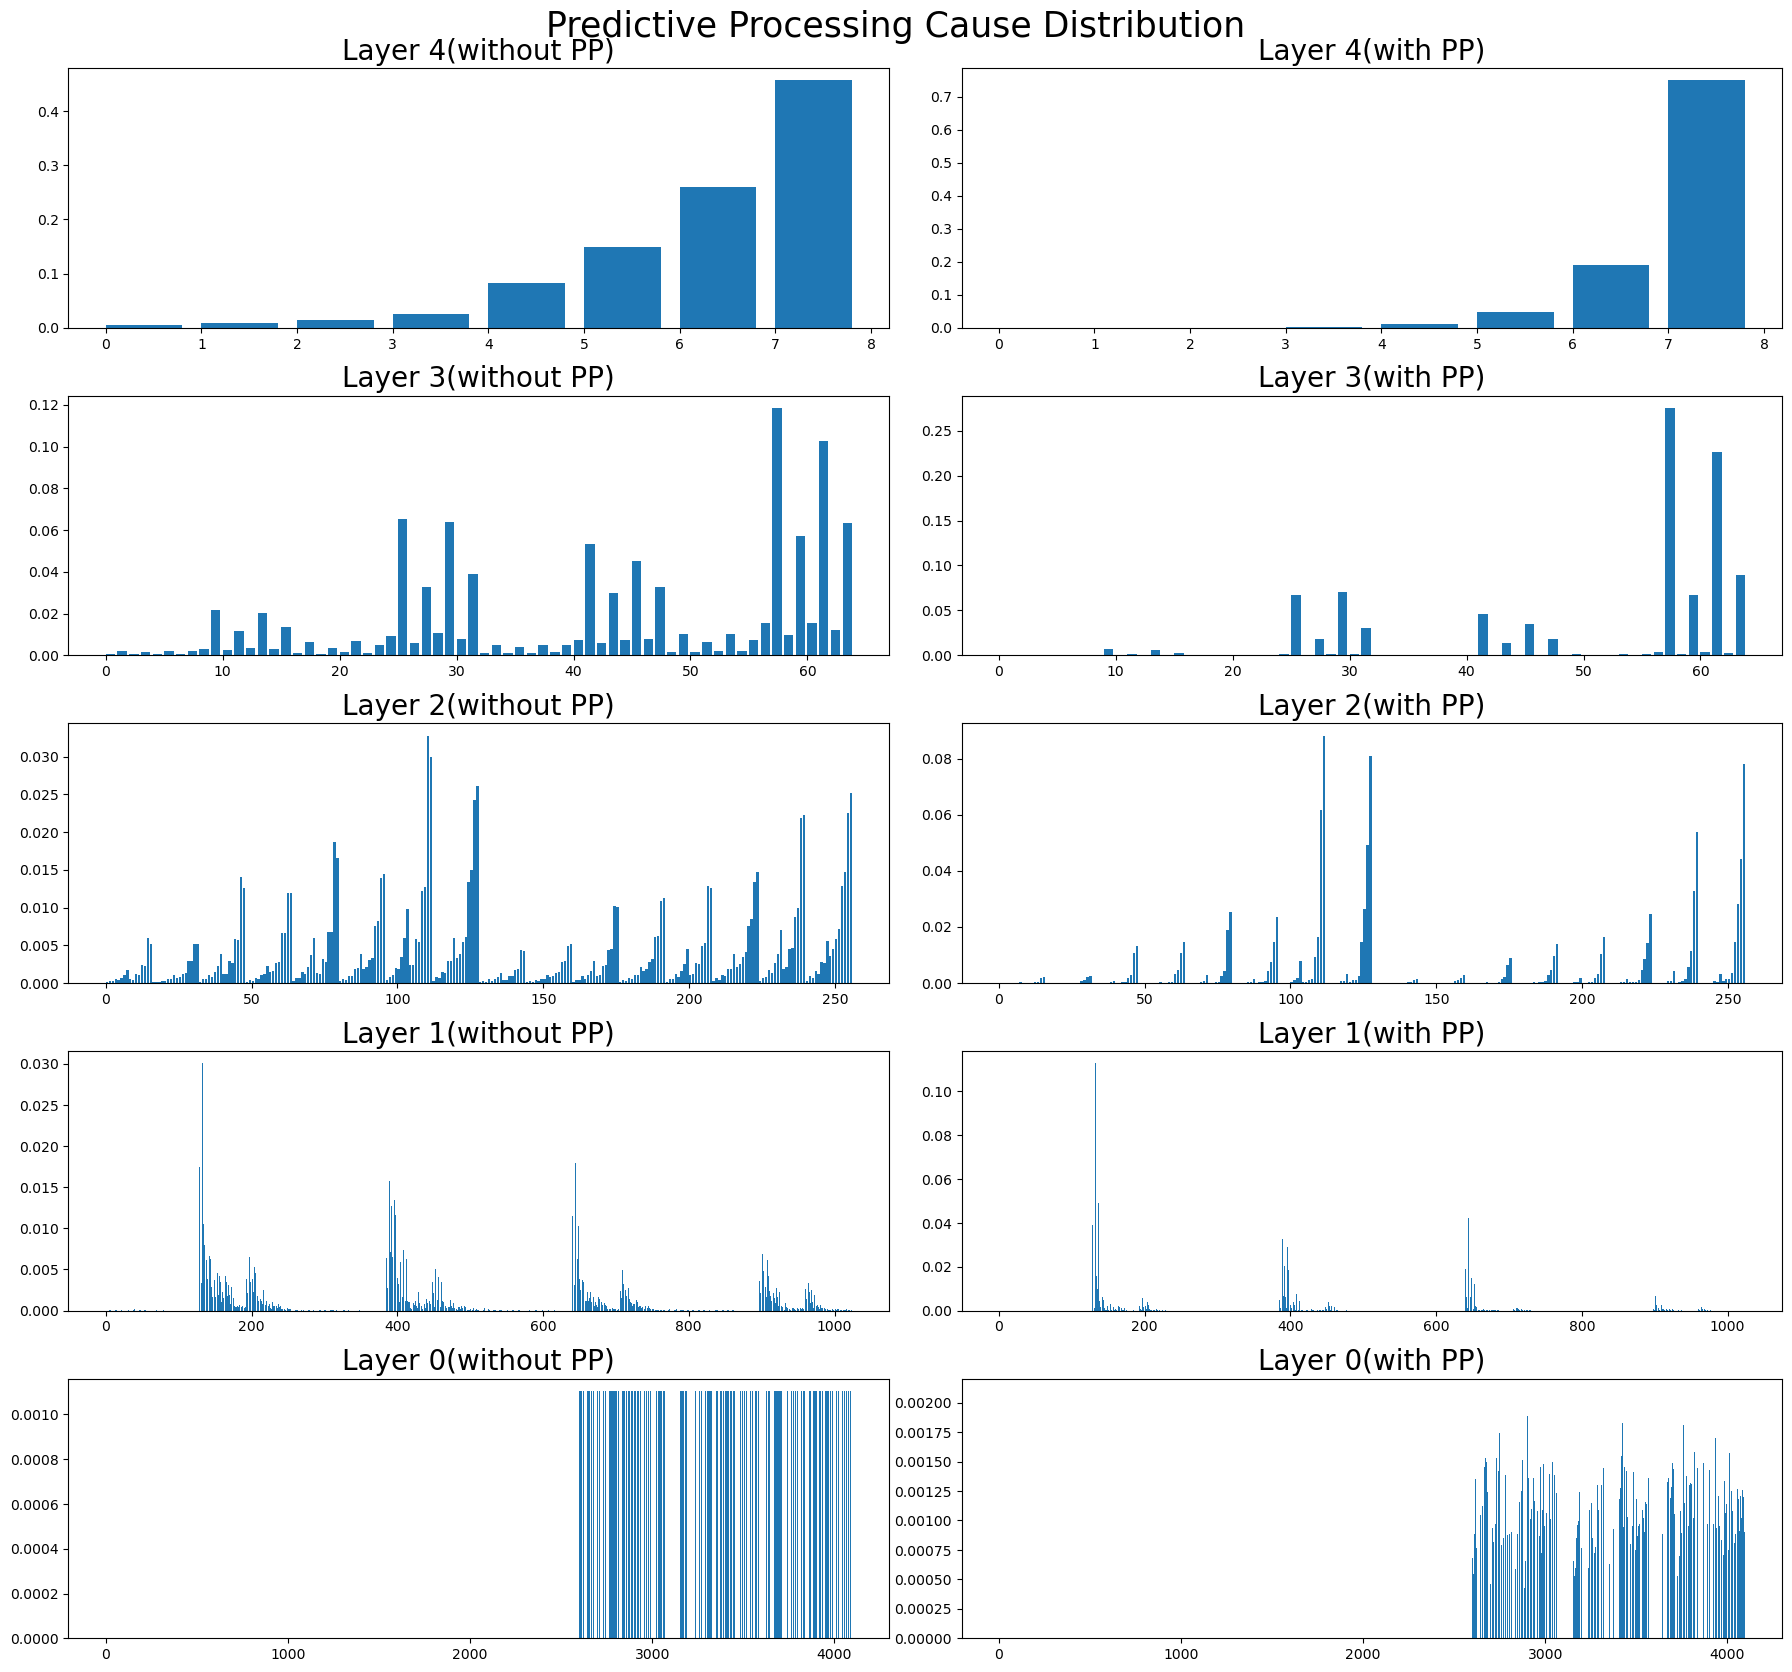

In [44]:
cause_dist, cause_dist_pp = wake_dist_pp(Phi, test_dist, n_dz, pp_dict, dev)
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 17))
fig.suptitle("Predictive Processing Cause Distribution",fontsize=25)
for i in range(n_layer-1):
    dist = cause_dist['Layer_'+str(i)]
    dist_pp = cause_dist_pp['Layer_'+str(i)]
    
    ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=0.8,align='edge')
    ax[n_layer-2-i,0].set_title("Layer "+str(i)+'(without PP)',fontsize=20)
    ax[n_layer-2-i,1].set_title("Layer "+str(i)+'(with PP)',fontsize=20)

plt.tight_layout(pad=1)    
plt.show()

In [45]:
# anti-data
data_dist = ground_truth(well_formed_set,dev)
test_dist = (data_dist == 0).long()/(data_dist == 0).long().sum()
test_dist

tensor([0.0003, 0.0003, 0.0003,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

In [289]:
test_dist = torch.zeros(2**n_d,device=dev)
well_formed_dcm = decimalize(well_formed_set,dev)
test_dist[well_formed_dcm[100]] = 1

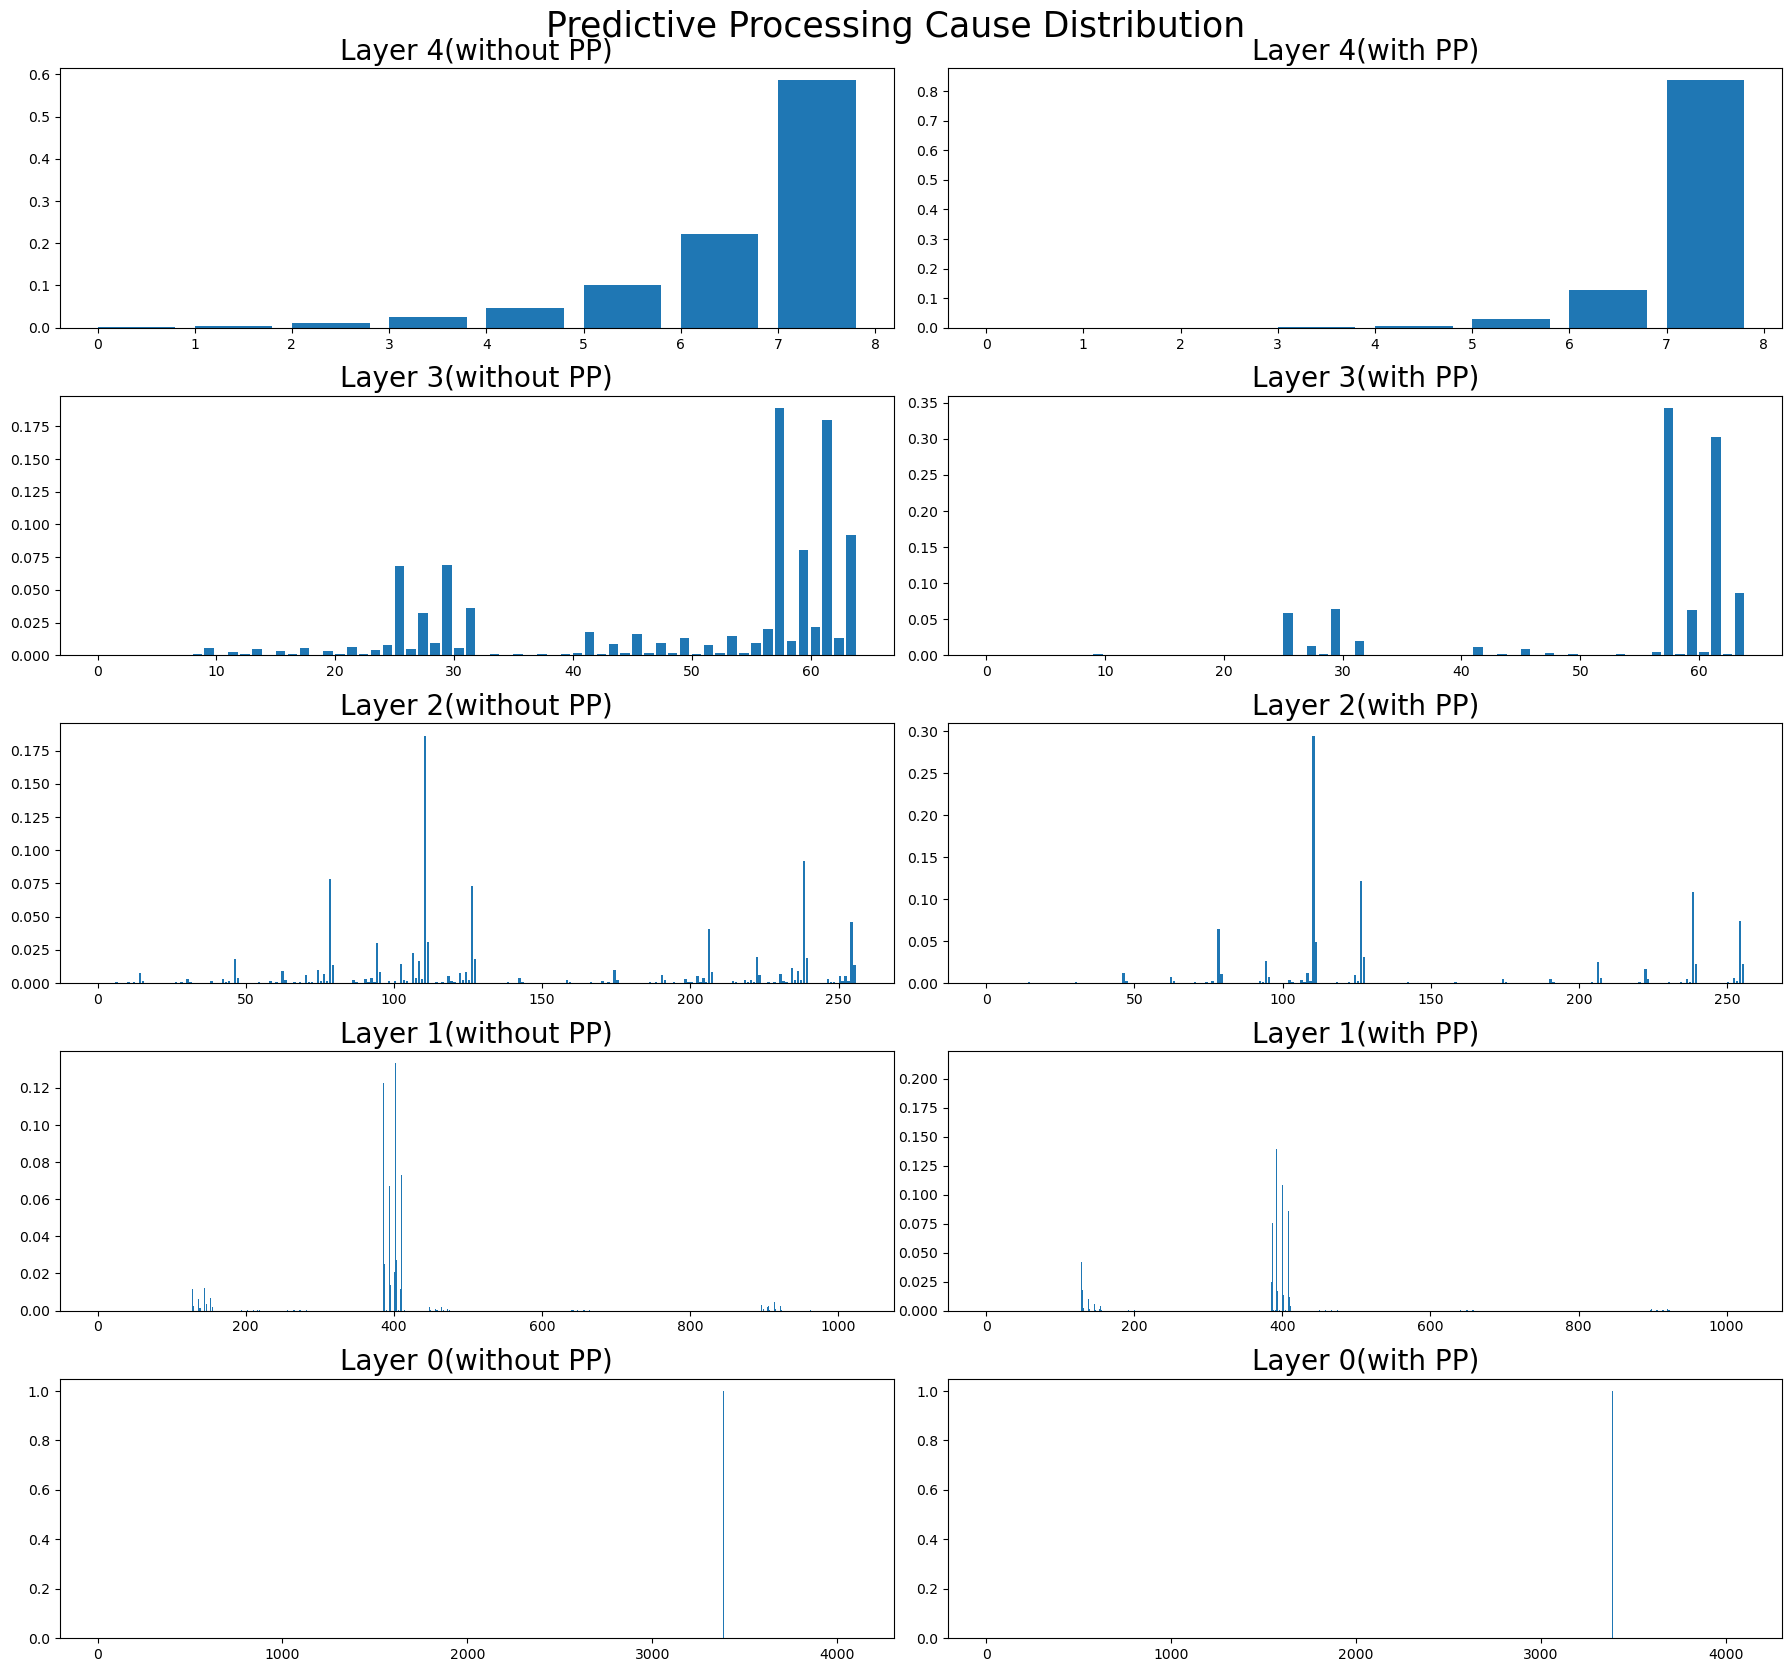

In [290]:
cause_dist, cause_dist_pp = wake_dist_pp(Phi, test_dist, n_dz, pp_dict, dev)
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 17))
fig.suptitle("Predictive Processing Cause Distribution",fontsize=25)
for i in range(n_layer-1):
    dist = cause_dist['Layer_'+str(i)]
    dist_pp = cause_dist_pp['Layer_'+str(i)]
    
    if i > 0:
        ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=0.8,align='edge')
        ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=0.8,align='edge')
    else:
        ax[n_layer-2-i,0].bar(np.arange(2**n_dz[i]),dist.to('cpu').numpy(),width=5,align='edge')
        ax[n_layer-2-i,1].bar(np.arange(2**n_dz[i]),dist_pp.to('cpu').numpy(),width=5,align='edge')
    ax[n_layer-2-i,0].set_title("Layer "+str(i)+'(without PP)',fontsize=20)
    ax[n_layer-2-i,1].set_title("Layer "+str(i)+'(with PP)',fontsize=20)

plt.tight_layout(pad=1)    
plt.show()

In [47]:
def random_generate(k,n,n_data):
    """
    The dataset is generated in a favor of Bayesian mixure of Gaussians. Given k mixture Gaussian components, we sample their 
    means u_1...u_k uniformly from [0,1]. Then we randomly assign each data to one of the components, and sample from its 
    Gaussian distribution (u_k, sigma). sigma is a hyperparameter, we default it to 1.
    
    The "Bayesian mixure of Gaussians" generation is just a way to generate dataset with non-singular distributions. The 
    generated data distribution is not identified with the mixure of Gaussian distributions that generated it. In other words, 
    the data is treated as sole evidence without any prior on how it's been generated thus its reconstruction is not convolved 
    with it's generative distributions, which is a major difference from varietional inference.
        
    Arguments:
    k -- number of Gaussian components
    n -- length of input layer (single data point)
    n_data -- number of datapoints to generate
    value_set -- list or array [a,b], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    
    Returns:
    random_set -- generated dataset, numpy array of shape (n,n_data), n_data is the number of datapoints in the generated dataset
    """
    u = np.random.rand(n,k)
    c = np.random.randint(k, size=(n_data,))
    data_mean = u[:,c]
    prob = np.random.randn(n,n_data) + data_mean
    random_set = (prob>0.5).astype(int)
    
    values_c, counts_c = np.unique(c,return_counts=True)
    component_p = counts_c/n_data
    
    return random_set,u,component_p

In [49]:
random_set,u,component_p = random_generate(5,n_d,n_data)
random_set = torch.from_numpy(random_set).type(torch.int64).to(dev)
random_set

tensor([[1, 1, 1,  ..., 0, 1, 0],
        [0, 1, 1,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 1],
        [1, 1, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0]], device='cuda:0')

### Learn random set with PP

In [211]:
para = np.load('Parameters_ws_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']
org_Dist = pp_dist(Theta,dev)

In [152]:
def cat_prob(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    prob_ct -- categorical probability, torch tensor of shape (2**n_y,batch_size)
    """
    n_y = q.shape[0]
    batch_size = q.shape[1]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_y, batch_size, device=dev)
    for i in range(batch_size):
        prob_ct[:,i] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    return prob_ct

In [153]:
def one_step_forward_pp(x, param, pp_dist,dev):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    pp_dist -- predictive distribution at output layer. Torch tensor of shape (2**n_y,)
    dev -- torch device
    
    Returns:
    precision -- weight of each sample at layer Y. Torch tensor of shape (batch_size,)
    sample_mtx -- sampled assignments at layer Y. Torch tensor of shape (n_y,batch_size)
    """
    n_y = param.shape[0]
    q = one_step_forward(x,param) # (n_y,batch_size)
    prob_ct = cat_prob(q)      # (2**n_y,batch_size)
    dist = prob_ct * pp_dist.reshape(-1,1)   # (2**n_y,batch_size)
    precision = dist.sum(axis=0)/dist.sum(axis=0).max() # (batch_size,)
    sample_index = torch.multinomial(dist.t(), 1).reshape(-1,)  # (batch_size,)
    sample_s = binarilize(sample_index,n_y,dev) # (n_y,batch_size)
    return precision, sample_s

In [154]:
def one_step_update_pp(x,y,param,precision,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    precision -- weight of each sample at layer Y. Torch tensor of shape (batch_size,)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul((q-y)* precision.reshape(1,-1),torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [155]:
def layer_wise_train_pp(input_x,param_xy,param_yx,pp_dist,precision_prod,lr,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    pp_dist -- predictive distribution at output layer Y. Torch tensor of shape (2**n_y,)
    precision_prod -- product of precisions from previous layers. Torch tensor of shape (batch_size,)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    precision -- weight of each sample at layer Y. Torch tensor of shape (batch_size,)
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    precision_prod -- product of precisions from previous layers. Torch tensor of shape (batch_size,)
    """
    precision, output_y = one_step_forward_pp(input_x, param_xy, pp_dist,dev)
#     print('precision',precision)
    
    # train the opposite phase from x to y
    precision_prod = precision_prod * precision
    param_yx, grad, loss = one_step_update_pp(output_y,input_x,param_yx,precision_prod,lr)
    
    return output_y, param_yx, grad, loss, precision_prod

In [156]:
def wake_phase_pp(Phi,Theta,data,pp_dict,precision_data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    pp_dict -- pp distribution dictionary, of length n_layer-1
    precision_data -- precision weights of data points. Torch tensor of shape (batch_size,)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    precision_prod -- product of precisions from previous layers. Torch tensor of shape (batch_size,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    precision_prod = precision_data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i],precision_prod = layer_wise_train_pp(input_x,\
           Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],pp_dict['Layer_'+str(i+1)],precision_prod,lr,dev)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = one_step_update_pp(\
      torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],precision_prod,lr)
    return Theta, Loss, precision_prod

In [210]:
data = overlap_set
batch_num = 200
batch_size = int(data.shape[1]/batch_num)
lr = 0.1
epoch = 50
batch_size

6

In [212]:
pp_dict = pp_dist(Theta,dev)  # attention

In [214]:
for e in range(epoch):
    data_perm = data[:,torch.randperm(data.size()[1])]
    data_dcm = decimalize(data_perm,dev)
    Loss_W = 0
    Loss_S = 0
    for i in range(batch_num):
        batch_set = data_perm[:,i*batch_size:(i+1)*batch_size]
        batch_set_dcm = data_dcm[i*batch_size:(i+1)*batch_size]
        precision_data = pp_dict['Layer_0'][batch_set_dcm]/pp_dict['Layer_0'][batch_set_dcm].max()
#         print('precision_data', precision_data)
        Theta, Loss_sleep,precision_prod = wake_phase_pp(Phi,Theta,batch_set,pp_dict,precision_data,lr,dev)
    #     print('precision_prod', precision_prod)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/batch_num,'    Loss_sleep:',Loss_S/batch_num)

Loss_wake: tensor([0.0000, 0.2354, 0.4447, 0.4324, 0.3628])     Loss_sleep: tensor([1.4356, 0.4463, 0.4191, 0.3454, 0.2609])
Loss_wake: tensor([0.0000, 0.2009, 0.3875, 0.3711, 0.3033])     Loss_sleep: tensor([1.2669, 0.4162, 0.3807, 0.2736, 0.2094])
Loss_wake: tensor([0.0000, 0.1792, 0.3490, 0.2985, 0.2650])     Loss_sleep: tensor([1.1973, 0.4071, 0.3422, 0.2362, 0.1625])
Loss_wake: tensor([0.0000, 0.1553, 0.3001, 0.2626, 0.2340])     Loss_sleep: tensor([1.0697, 0.3748, 0.3055, 0.2093, 0.1513])
Loss_wake: tensor([0.0000, 0.1355, 0.2891, 0.2246, 0.1964])     Loss_sleep: tensor([0.9754, 0.3695, 0.2911, 0.1795, 0.1236])
Loss_wake: tensor([0.0000, 0.1193, 0.2604, 0.2173, 0.1851])     Loss_sleep: tensor([0.9150, 0.3318, 0.2842, 0.1826, 0.1074])
Loss_wake: tensor([0.0000, 0.1165, 0.2673, 0.1904, 0.1653])     Loss_sleep: tensor([0.9576, 0.3320, 0.2859, 0.1562, 0.0877])
Loss_wake: tensor([0.0000, 0.1086, 0.2633, 0.1717, 0.1586])     Loss_sleep: tensor([0.9404, 0.3375, 0.2823, 0.1350, 0.0873])


In [220]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [221]:
np.save('Parameters_pp_batchnum200',parameters)

In [185]:
# para = np.load('Parameters_pp_batchnum10.npy',allow_pickle=True).item()
# Phi = para['Phi']
# Theta = para['Theta']

In [215]:
org_data = well_formed_set
new_data = overlap_set
org_data_dist = ground_truth(org_data,dev)
new_data_dist = ground_truth(new_data,dev)

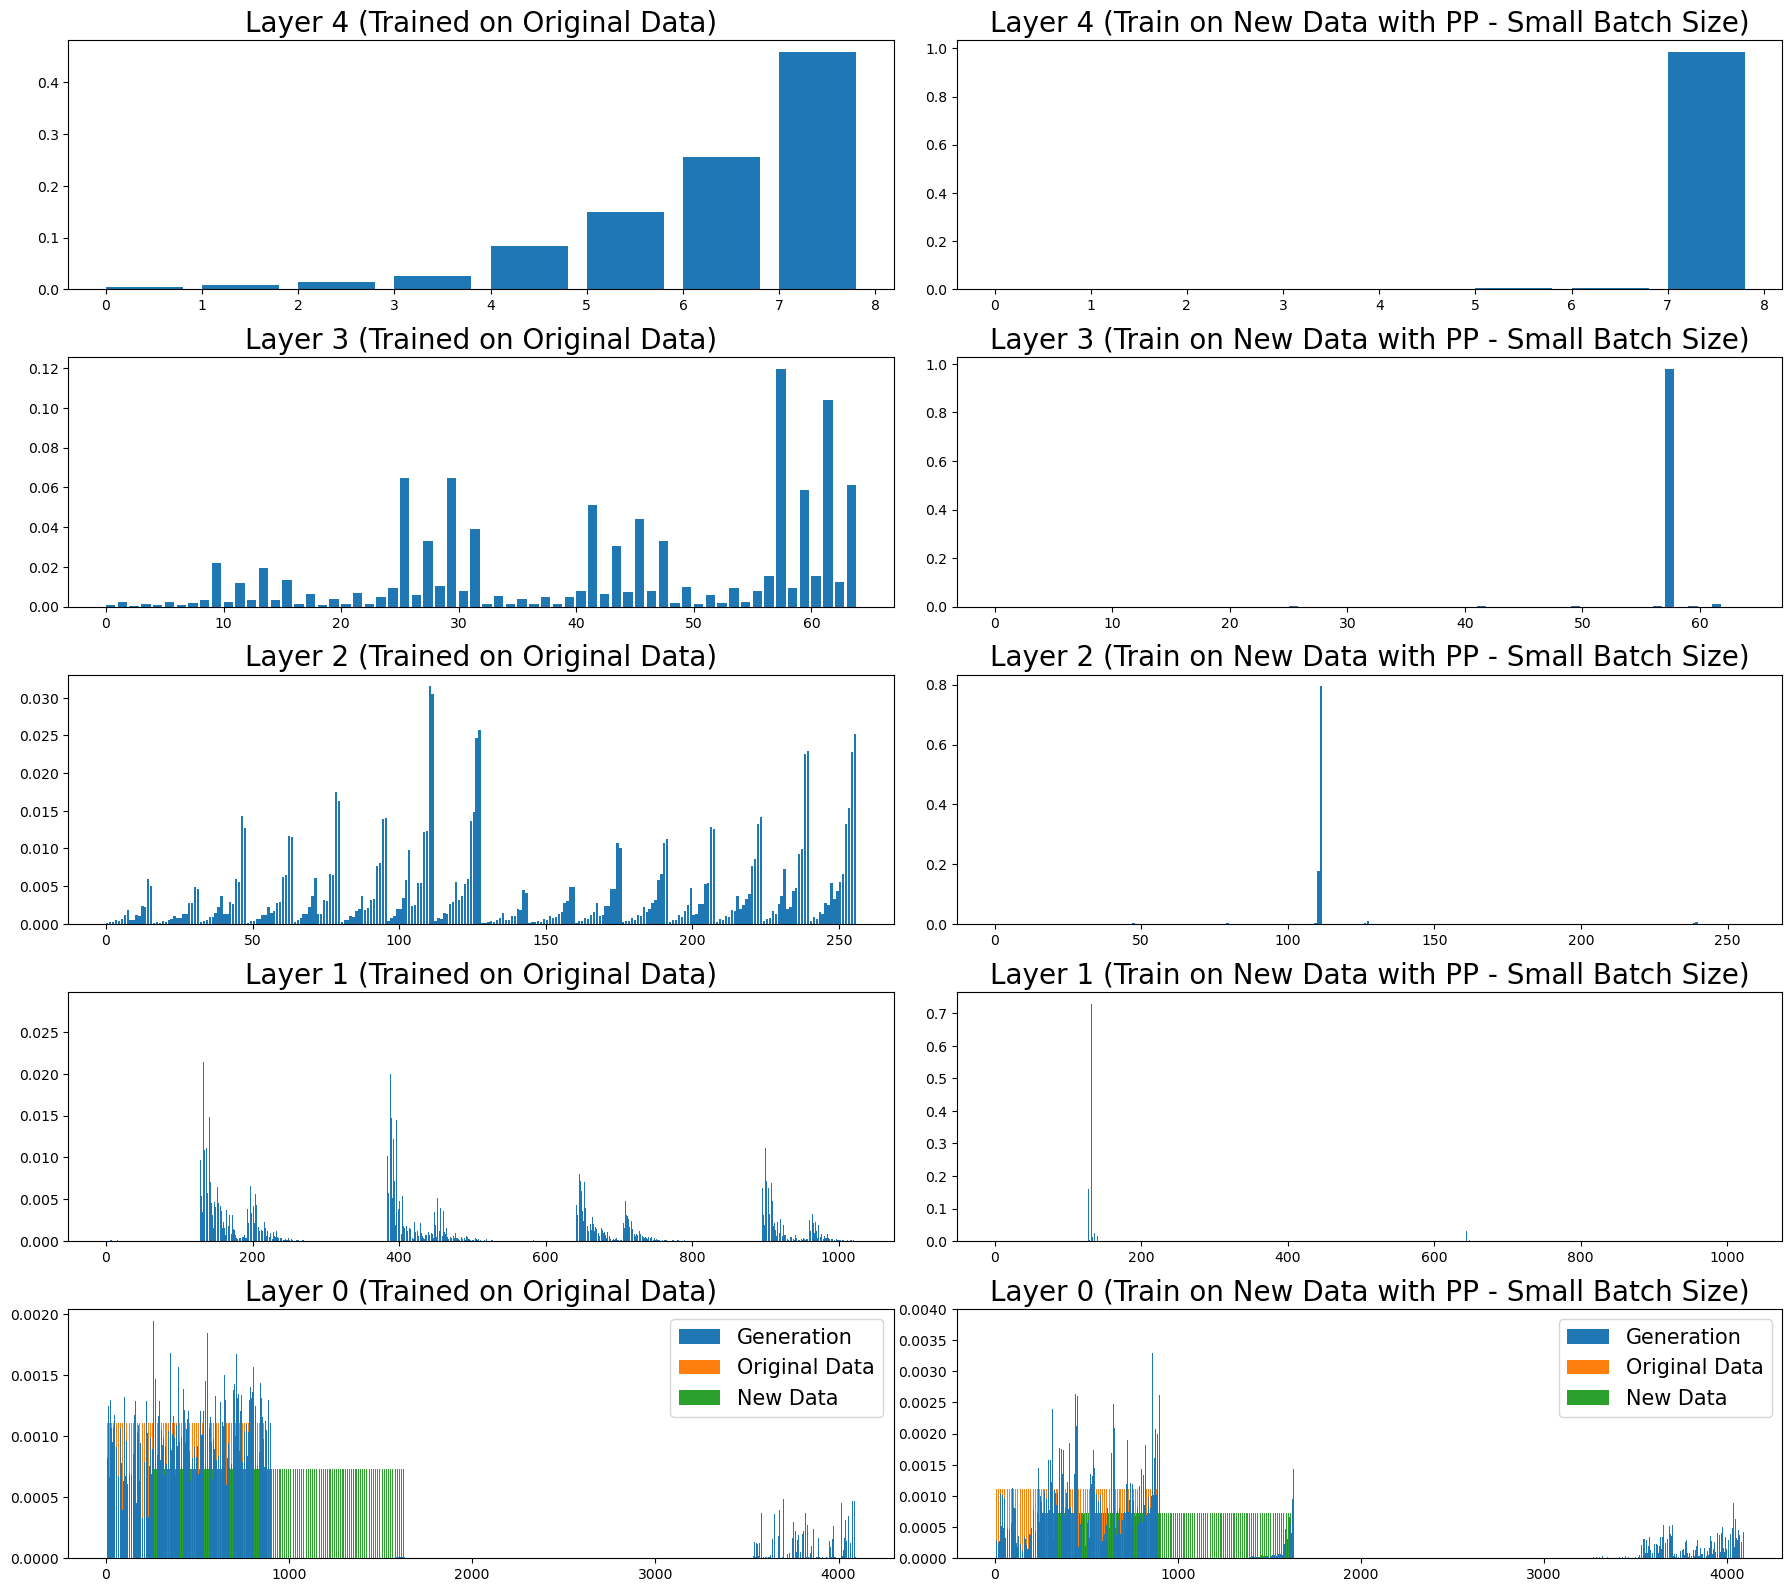

In [219]:
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 16))
# fig.suptitle("Predictive Processing",fontsize=25)

dist_pre = torch.ones(1,device=dev)
for i in range(n_layer-1):
    dist_org = org_Dist['Layer_'+str(n_layer-2-i)]
    
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    dist_pre = torch.matmul(dist_pre, prob_ct)
    dist_train = dist_pre
    if i < n_layer-2:
        ax[i,0].bar(np.arange(2**n_dz[n_layer-2-i]),dist_org.to('cpu').numpy(),width=0.8,align='edge')
        ax[i,1].bar(np.arange(2**n_dz[n_layer-2-i]),dist_train.to('cpu').numpy(),width=0.8,align='edge')
    else:
        ax[i,0].bar(np.arange(2**n_dz[n_layer-2-i]),dist_org[order].to('cpu').numpy(),width=0.8,align='edge',label='Generation',zorder=10)
        ax[i,1].bar(np.arange(2**n_dz[n_layer-2-i]),dist_train[order].to('cpu').numpy(),width=0.8,align='edge',label='Generation',zorder=10)
    ax[i,0].set_title("Layer "+str(n_layer-2-i)+' (Trained on Original Data)',fontsize=20)
    ax[i,1].set_title("Layer "+str(n_layer-2-i)+' (Train on New Data with PP - Small Batch Size)',fontsize=20)
    
ax[n_layer-2,0].bar(np.arange(2**n_dz[0]),org_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='Original Data',zorder=0)
ax[n_layer-2,0].bar(np.arange(2**n_dz[0])+0.5,new_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='New Data',zorder=5)
ax[n_layer-2,1].bar(np.arange(2**n_dz[0]),org_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='Original Data',zorder=0)
ax[n_layer-2,1].bar(np.arange(2**n_dz[0])+0.5,new_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='New Data',zorder=5)
ax[n_layer-2,1].set_ylim(0, 0.004)
ax[n_layer-2,0].legend(fontsize=15)
ax[n_layer-2,1].legend(fontsize=15)
plt.tight_layout(pad=1)    
plt.show()

In [188]:
precision_prod

tensor([9.2349e-02, 2.3781e-06, 2.9814e-07, 1.3963e-01, 1.0410e-06, 9.5505e-06,
        3.0785e-01, 5.8761e-04, 3.2596e-01, 2.8839e-01, 1.6465e-05, 4.9489e-01,
        1.0068e-06, 4.2877e-01, 2.3371e-01, 8.0174e-06, 4.2819e-06, 9.6814e-04,
        2.4698e-06, 7.4286e-07, 7.8737e-02, 1.0430e-01, 1.6018e-06, 5.9917e-07,
        4.0788e-01, 3.0534e-01, 1.6426e-06, 8.7362e-04, 5.2700e-05, 5.7409e-02,
        1.0100e-01, 6.6042e-02, 3.4908e-01, 4.5322e-01, 1.5440e-05, 2.3845e-05,
        3.5474e-06, 4.0094e-01, 3.8659e-06, 2.8888e-01, 3.6615e-01, 3.4832e-05,
        1.4336e-06, 4.7064e-01, 1.5150e-06, 2.4559e-05, 4.2698e-06, 9.2662e-07,
        2.4876e-01, 2.0947e-01, 4.6557e-01, 5.2702e-02, 1.4968e-01, 1.3340e-04,
        1.6150e-07, 3.0057e-03, 1.0718e-05, 2.1759e-04, 1.2745e-01, 3.3523e-01,
        2.5088e-06, 3.8587e-06, 4.3343e-01, 1.2832e-04, 2.0702e-04, 2.6732e-06,
        5.5871e-07, 3.3444e-01, 4.7271e-06, 6.2045e-01, 9.7404e-04, 4.4324e-01,
        2.3563e-07, 1.1596e-01, 5.9675e-

### Train without PP

In [189]:
para = np.load('Parameters_ws_batch.npy',allow_pickle=True).item()
Phi = para['Phi']
Theta = para['Theta']

In [190]:
data = overlap_set
n_data = data.shape[1]
n_data

1375

In [191]:
data_dcm = decimalize(data,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0007, 0.0007, 0.0007], device='cuda:0')

In [192]:
batch_size = n_data
lr = 0.1
epoch = 10000

In [203]:
for e in range(epoch):
    Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
    print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)

Loss_wake: tensor([0.0000, 0.2076, 0.4896, 0.4773, 0.3840])     Loss_sleep: tensor([0.3524, 0.4509, 0.5465, 0.5162, 0.4260])
Loss_wake: tensor([0.0000, 0.2141, 0.4832, 0.4825, 0.3830])     Loss_sleep: tensor([0.3573, 0.4461, 0.5452, 0.5170, 0.4284])
Loss_wake: tensor([0.0000, 0.2094, 0.4942, 0.4800, 0.3876])     Loss_sleep: tensor([0.3566, 0.4506, 0.5463, 0.5312, 0.4349])
Loss_wake: tensor([0.0000, 0.2143, 0.4967, 0.4909, 0.3766])     Loss_sleep: tensor([0.3551, 0.4490, 0.5474, 0.5228, 0.4402])
Loss_wake: tensor([0.0000, 0.2100, 0.4863, 0.4800, 0.3722])     Loss_sleep: tensor([0.3482, 0.4474, 0.5469, 0.5206, 0.4378])
Loss_wake: tensor([0.0000, 0.2163, 0.4889, 0.4827, 0.3890])     Loss_sleep: tensor([0.3569, 0.4455, 0.5422, 0.5272, 0.4290])
Loss_wake: tensor([0.0000, 0.2098, 0.4894, 0.4780, 0.3809])     Loss_sleep: tensor([0.3552, 0.4425, 0.5410, 0.5307, 0.4266])
Loss_wake: tensor([0.0000, 0.2233, 0.4920, 0.4803, 0.3860])     Loss_sleep: tensor([0.3522, 0.4466, 0.5483, 0.5259, 0.4103])


Loss_wake: tensor([0.0000, 0.2106, 0.4891, 0.4880, 0.3995])     Loss_sleep: tensor([0.3525, 0.4542, 0.5471, 0.5203, 0.4390])
Loss_wake: tensor([0.0000, 0.2257, 0.4919, 0.4752, 0.3803])     Loss_sleep: tensor([0.3539, 0.4511, 0.5460, 0.5217, 0.4393])
Loss_wake: tensor([0.0000, 0.2103, 0.4873, 0.4833, 0.3750])     Loss_sleep: tensor([0.3534, 0.4454, 0.5449, 0.5222, 0.4344])
Loss_wake: tensor([0.0000, 0.2102, 0.4878, 0.4854, 0.3694])     Loss_sleep: tensor([0.3537, 0.4491, 0.5519, 0.5342, 0.4277])
Loss_wake: tensor([0.0000, 0.2137, 0.4924, 0.4847, 0.3750])     Loss_sleep: tensor([0.3549, 0.4460, 0.5487, 0.5345, 0.4418])
Loss_wake: tensor([0.0000, 0.2169, 0.4849, 0.4846, 0.3790])     Loss_sleep: tensor([0.3578, 0.4430, 0.5407, 0.5220, 0.4364])
Loss_wake: tensor([0.0000, 0.2091, 0.4903, 0.4770, 0.3947])     Loss_sleep: tensor([0.3547, 0.4517, 0.5456, 0.5112, 0.4271])
Loss_wake: tensor([0.0000, 0.2182, 0.4840, 0.4887, 0.4003])     Loss_sleep: tensor([0.3544, 0.4509, 0.5441, 0.5164, 0.4265])


Loss_wake: tensor([0.0000, 0.2174, 0.4975, 0.4849, 0.3724])     Loss_sleep: tensor([0.3535, 0.4495, 0.5504, 0.5189, 0.4401])
Loss_wake: tensor([0.0000, 0.2116, 0.4880, 0.4849, 0.3699])     Loss_sleep: tensor([0.3578, 0.4500, 0.5516, 0.5146, 0.4302])
Loss_wake: tensor([0.0000, 0.2173, 0.4980, 0.4827, 0.3753])     Loss_sleep: tensor([0.3523, 0.4537, 0.5461, 0.5252, 0.4342])
Loss_wake: tensor([0.0000, 0.2102, 0.4871, 0.4794, 0.3792])     Loss_sleep: tensor([0.3549, 0.4523, 0.5502, 0.5189, 0.4255])
Loss_wake: tensor([0.0000, 0.2167, 0.4906, 0.4794, 0.3727])     Loss_sleep: tensor([0.3539, 0.4427, 0.5432, 0.5198, 0.4263])
Loss_wake: tensor([0.0000, 0.2175, 0.4934, 0.4816, 0.3783])     Loss_sleep: tensor([0.3585, 0.4475, 0.5456, 0.5245, 0.4304])
Loss_wake: tensor([0.0000, 0.2130, 0.4892, 0.4861, 0.3872])     Loss_sleep: tensor([0.3529, 0.4468, 0.5460, 0.5174, 0.4255])
Loss_wake: tensor([0.0000, 0.2169, 0.4928, 0.4746, 0.3793])     Loss_sleep: tensor([0.3571, 0.4543, 0.5497, 0.5217, 0.4510])


Loss_wake: tensor([0.0000, 0.2130, 0.4924, 0.4807, 0.3952])     Loss_sleep: tensor([0.3554, 0.4500, 0.5460, 0.5292, 0.4380])
Loss_wake: tensor([0.0000, 0.2095, 0.5018, 0.4927, 0.3784])     Loss_sleep: tensor([0.3519, 0.4490, 0.5467, 0.5240, 0.4277])
Loss_wake: tensor([0.0000, 0.2165, 0.4869, 0.4745, 0.3752])     Loss_sleep: tensor([0.3500, 0.4548, 0.5468, 0.5261, 0.4447])
Loss_wake: tensor([0.0000, 0.2129, 0.4868, 0.4782, 0.3787])     Loss_sleep: tensor([0.3566, 0.4516, 0.5416, 0.5180, 0.4209])
Loss_wake: tensor([0.0000, 0.2221, 0.4933, 0.4878, 0.3785])     Loss_sleep: tensor([0.3569, 0.4543, 0.5421, 0.5265, 0.4334])
Loss_wake: tensor([0.0000, 0.2095, 0.4807, 0.4835, 0.3855])     Loss_sleep: tensor([0.3510, 0.4516, 0.5450, 0.5193, 0.4351])
Loss_wake: tensor([0.0000, 0.2095, 0.4833, 0.4905, 0.3962])     Loss_sleep: tensor([0.3492, 0.4448, 0.5501, 0.5311, 0.4365])
Loss_wake: tensor([0.0000, 0.2107, 0.4956, 0.4808, 0.3767])     Loss_sleep: tensor([0.3482, 0.4502, 0.5484, 0.5167, 0.4415])


Loss_wake: tensor([0.0000, 0.2197, 0.4965, 0.4813, 0.3890])     Loss_sleep: tensor([0.3564, 0.4485, 0.5457, 0.5168, 0.4351])
Loss_wake: tensor([0.0000, 0.2166, 0.4804, 0.4870, 0.3827])     Loss_sleep: tensor([0.3475, 0.4578, 0.5507, 0.5202, 0.4338])
Loss_wake: tensor([0.0000, 0.2154, 0.4858, 0.4837, 0.3956])     Loss_sleep: tensor([0.3542, 0.4550, 0.5458, 0.5212, 0.4421])
Loss_wake: tensor([0.0000, 0.2176, 0.4868, 0.4783, 0.3767])     Loss_sleep: tensor([0.3506, 0.4476, 0.5384, 0.5056, 0.4278])
Loss_wake: tensor([0.0000, 0.2156, 0.4880, 0.4684, 0.3845])     Loss_sleep: tensor([0.3539, 0.4506, 0.5457, 0.5279, 0.4494])
Loss_wake: tensor([0.0000, 0.2111, 0.4841, 0.4900, 0.3757])     Loss_sleep: tensor([0.3465, 0.4505, 0.5427, 0.5226, 0.4259])
Loss_wake: tensor([0.0000, 0.2215, 0.4810, 0.4703, 0.3729])     Loss_sleep: tensor([0.3518, 0.4488, 0.5473, 0.5119, 0.4324])
Loss_wake: tensor([0.0000, 0.2108, 0.4771, 0.4686, 0.3769])     Loss_sleep: tensor([0.3441, 0.4497, 0.5473, 0.5197, 0.4327])


Loss_wake: tensor([0.0000, 0.2210, 0.4783, 0.4910, 0.3800])     Loss_sleep: tensor([0.3513, 0.4517, 0.5421, 0.5187, 0.4371])
Loss_wake: tensor([0.0000, 0.2112, 0.4959, 0.4873, 0.3918])     Loss_sleep: tensor([0.3493, 0.4517, 0.5392, 0.5143, 0.4383])
Loss_wake: tensor([0.0000, 0.2125, 0.4778, 0.4833, 0.3790])     Loss_sleep: tensor([0.3537, 0.4500, 0.5349, 0.5354, 0.4375])
Loss_wake: tensor([0.0000, 0.2211, 0.4839, 0.4820, 0.3770])     Loss_sleep: tensor([0.3530, 0.4500, 0.5479, 0.5212, 0.4374])
Loss_wake: tensor([0.0000, 0.2065, 0.4971, 0.4753, 0.3787])     Loss_sleep: tensor([0.3549, 0.4500, 0.5486, 0.5233, 0.4264])
Loss_wake: tensor([0.0000, 0.2127, 0.4864, 0.4813, 0.3929])     Loss_sleep: tensor([0.3505, 0.4496, 0.5524, 0.5320, 0.4378])
Loss_wake: tensor([0.0000, 0.2198, 0.4894, 0.4785, 0.3903])     Loss_sleep: tensor([0.3478, 0.4500, 0.5392, 0.5248, 0.4514])
Loss_wake: tensor([0.0000, 0.2088, 0.4822, 0.4887, 0.3819])     Loss_sleep: tensor([0.3517, 0.4516, 0.5395, 0.5262, 0.4348])


Loss_wake: tensor([0.0000, 0.2140, 0.4810, 0.4840, 0.3831])     Loss_sleep: tensor([0.3535, 0.4545, 0.5402, 0.5209, 0.4242])
Loss_wake: tensor([0.0000, 0.2151, 0.4891, 0.4797, 0.3772])     Loss_sleep: tensor([0.3540, 0.4552, 0.5461, 0.5193, 0.4444])
Loss_wake: tensor([0.0000, 0.2130, 0.4901, 0.4761, 0.3801])     Loss_sleep: tensor([0.3444, 0.4526, 0.5446, 0.5177, 0.4275])
Loss_wake: tensor([0.0000, 0.2124, 0.4848, 0.4765, 0.3827])     Loss_sleep: tensor([0.3574, 0.4442, 0.5377, 0.5318, 0.4232])
Loss_wake: tensor([0.0000, 0.2150, 0.4953, 0.4760, 0.3750])     Loss_sleep: tensor([0.3581, 0.4449, 0.5498, 0.5245, 0.4306])
Loss_wake: tensor([0.0000, 0.2144, 0.4818, 0.4865, 0.3770])     Loss_sleep: tensor([0.3489, 0.4488, 0.5420, 0.5170, 0.4396])
Loss_wake: tensor([0.0000, 0.2158, 0.4952, 0.4812, 0.3836])     Loss_sleep: tensor([0.3475, 0.4475, 0.5405, 0.5218, 0.4269])
Loss_wake: tensor([0.0000, 0.2133, 0.4848, 0.4841, 0.3802])     Loss_sleep: tensor([0.3565, 0.4495, 0.5492, 0.5224, 0.4344])


Loss_wake: tensor([0.0000, 0.2190, 0.4930, 0.4940, 0.3941])     Loss_sleep: tensor([0.3473, 0.4453, 0.5443, 0.5304, 0.4473])
Loss_wake: tensor([0.0000, 0.2149, 0.4877, 0.4778, 0.3918])     Loss_sleep: tensor([0.3521, 0.4539, 0.5459, 0.5109, 0.4467])
Loss_wake: tensor([0.0000, 0.2132, 0.4860, 0.4840, 0.3926])     Loss_sleep: tensor([0.3571, 0.4531, 0.5474, 0.5220, 0.4331])
Loss_wake: tensor([0.0000, 0.2122, 0.4937, 0.4831, 0.3929])     Loss_sleep: tensor([0.3540, 0.4448, 0.5434, 0.5199, 0.4287])
Loss_wake: tensor([0.0000, 0.2161, 0.4850, 0.4827, 0.3664])     Loss_sleep: tensor([0.3519, 0.4451, 0.5471, 0.5174, 0.4356])
Loss_wake: tensor([0.0000, 0.2177, 0.4924, 0.4682, 0.3964])     Loss_sleep: tensor([0.3522, 0.4469, 0.5471, 0.5216, 0.4335])
Loss_wake: tensor([0.0000, 0.2113, 0.4943, 0.4731, 0.3799])     Loss_sleep: tensor([0.3456, 0.4543, 0.5402, 0.5175, 0.4240])
Loss_wake: tensor([0.0000, 0.2172, 0.4800, 0.4666, 0.3680])     Loss_sleep: tensor([0.3476, 0.4492, 0.5449, 0.5218, 0.4315])


Loss_wake: tensor([0.0000, 0.2092, 0.4880, 0.4873, 0.3828])     Loss_sleep: tensor([0.3500, 0.4553, 0.5378, 0.5269, 0.4255])
Loss_wake: tensor([0.0000, 0.2057, 0.4950, 0.4775, 0.3853])     Loss_sleep: tensor([0.3515, 0.4482, 0.5476, 0.5214, 0.4296])
Loss_wake: tensor([0.0000, 0.2156, 0.4933, 0.4796, 0.3927])     Loss_sleep: tensor([0.3511, 0.4496, 0.5479, 0.5103, 0.4377])
Loss_wake: tensor([0.0000, 0.2182, 0.4847, 0.4787, 0.3830])     Loss_sleep: tensor([0.3566, 0.4524, 0.5407, 0.5196, 0.4244])
Loss_wake: tensor([0.0000, 0.2078, 0.4855, 0.4797, 0.3892])     Loss_sleep: tensor([0.3471, 0.4448, 0.5500, 0.5196, 0.4268])
Loss_wake: tensor([0.0000, 0.2116, 0.4881, 0.4800, 0.3858])     Loss_sleep: tensor([0.3552, 0.4517, 0.5415, 0.5165, 0.4314])
Loss_wake: tensor([0.0000, 0.2164, 0.4923, 0.4866, 0.3907])     Loss_sleep: tensor([0.3535, 0.4512, 0.5415, 0.5227, 0.4192])
Loss_wake: tensor([0.0000, 0.2178, 0.4830, 0.4897, 0.3947])     Loss_sleep: tensor([0.3539, 0.4508, 0.5508, 0.5244, 0.4378])


Loss_wake: tensor([0.0000, 0.2128, 0.4778, 0.4712, 0.3849])     Loss_sleep: tensor([0.3539, 0.4489, 0.5370, 0.5125, 0.4282])
Loss_wake: tensor([0.0000, 0.2109, 0.4897, 0.4777, 0.3904])     Loss_sleep: tensor([0.3547, 0.4458, 0.5419, 0.5191, 0.4330])
Loss_wake: tensor([0.0000, 0.2201, 0.4959, 0.4909, 0.3979])     Loss_sleep: tensor([0.3435, 0.4526, 0.5493, 0.5217, 0.4326])
Loss_wake: tensor([0.0000, 0.2066, 0.4956, 0.4728, 0.3858])     Loss_sleep: tensor([0.3520, 0.4512, 0.5488, 0.5176, 0.4184])
Loss_wake: tensor([0.0000, 0.2065, 0.4884, 0.4748, 0.3707])     Loss_sleep: tensor([0.3474, 0.4506, 0.5428, 0.5163, 0.4293])
Loss_wake: tensor([0.0000, 0.2216, 0.4942, 0.4760, 0.3729])     Loss_sleep: tensor([0.3491, 0.4510, 0.5480, 0.5283, 0.4288])
Loss_wake: tensor([0.0000, 0.2174, 0.4924, 0.4747, 0.3733])     Loss_sleep: tensor([0.3500, 0.4499, 0.5438, 0.5151, 0.4371])
Loss_wake: tensor([0.0000, 0.2172, 0.4881, 0.4838, 0.3806])     Loss_sleep: tensor([0.3530, 0.4463, 0.5454, 0.5211, 0.4280])


Loss_wake: tensor([0.0000, 0.2169, 0.4866, 0.4798, 0.3624])     Loss_sleep: tensor([0.3553, 0.4547, 0.5442, 0.5227, 0.4374])
Loss_wake: tensor([0.0000, 0.2149, 0.4863, 0.4723, 0.3749])     Loss_sleep: tensor([0.3493, 0.4461, 0.5401, 0.5081, 0.4307])
Loss_wake: tensor([0.0000, 0.2056, 0.4907, 0.4753, 0.3870])     Loss_sleep: tensor([0.3503, 0.4468, 0.5506, 0.5304, 0.4522])
Loss_wake: tensor([0.0000, 0.2213, 0.4911, 0.4703, 0.3860])     Loss_sleep: tensor([0.3538, 0.4481, 0.5371, 0.5190, 0.4342])
Loss_wake: tensor([0.0000, 0.2131, 0.4913, 0.4791, 0.3780])     Loss_sleep: tensor([0.3547, 0.4505, 0.5396, 0.5212, 0.4265])
Loss_wake: tensor([0.0000, 0.2100, 0.4871, 0.4830, 0.4021])     Loss_sleep: tensor([0.3481, 0.4526, 0.5471, 0.5265, 0.4241])
Loss_wake: tensor([0.0000, 0.2092, 0.4877, 0.4825, 0.3763])     Loss_sleep: tensor([0.3561, 0.4507, 0.5443, 0.5191, 0.4355])
Loss_wake: tensor([0.0000, 0.2054, 0.4815, 0.4797, 0.3781])     Loss_sleep: tensor([0.3510, 0.4474, 0.5454, 0.5119, 0.4395])


Loss_wake: tensor([0.0000, 0.2195, 0.4911, 0.4877, 0.3888])     Loss_sleep: tensor([0.3523, 0.4516, 0.5451, 0.5260, 0.4353])
Loss_wake: tensor([0.0000, 0.2129, 0.4909, 0.4847, 0.3945])     Loss_sleep: tensor([0.3546, 0.4455, 0.5458, 0.5190, 0.4384])
Loss_wake: tensor([0.0000, 0.2129, 0.4949, 0.4756, 0.3788])     Loss_sleep: tensor([0.3526, 0.4517, 0.5481, 0.5165, 0.4380])
Loss_wake: tensor([0.0000, 0.2119, 0.4807, 0.4852, 0.3825])     Loss_sleep: tensor([0.3479, 0.4475, 0.5494, 0.5121, 0.4315])
Loss_wake: tensor([0.0000, 0.2105, 0.4933, 0.4785, 0.3839])     Loss_sleep: tensor([0.3559, 0.4484, 0.5410, 0.5186, 0.4316])
Loss_wake: tensor([0.0000, 0.2111, 0.4781, 0.4680, 0.3825])     Loss_sleep: tensor([0.3465, 0.4476, 0.5487, 0.5151, 0.4290])
Loss_wake: tensor([0.0000, 0.2161, 0.4899, 0.4750, 0.3732])     Loss_sleep: tensor([0.3469, 0.4479, 0.5465, 0.5241, 0.4240])
Loss_wake: tensor([0.0000, 0.2288, 0.4933, 0.4790, 0.3810])     Loss_sleep: tensor([0.3501, 0.4466, 0.5482, 0.5229, 0.4399])


Loss_wake: tensor([0.0000, 0.2098, 0.4836, 0.4771, 0.3742])     Loss_sleep: tensor([0.3520, 0.4429, 0.5502, 0.5167, 0.4289])
Loss_wake: tensor([0.0000, 0.2139, 0.4808, 0.4733, 0.3776])     Loss_sleep: tensor([0.3530, 0.4502, 0.5552, 0.5258, 0.4386])
Loss_wake: tensor([0.0000, 0.2140, 0.4971, 0.4822, 0.3862])     Loss_sleep: tensor([0.3461, 0.4507, 0.5463, 0.5217, 0.4393])
Loss_wake: tensor([0.0000, 0.2119, 0.4826, 0.4734, 0.3728])     Loss_sleep: tensor([0.3495, 0.4472, 0.5519, 0.5266, 0.4295])
Loss_wake: tensor([0.0000, 0.2223, 0.4878, 0.4559, 0.3632])     Loss_sleep: tensor([0.3508, 0.4502, 0.5414, 0.5132, 0.4323])
Loss_wake: tensor([0.0000, 0.2146, 0.4888, 0.4854, 0.3909])     Loss_sleep: tensor([0.3490, 0.4425, 0.5353, 0.5279, 0.4365])
Loss_wake: tensor([0.0000, 0.2168, 0.4908, 0.4735, 0.3840])     Loss_sleep: tensor([0.3560, 0.4494, 0.5518, 0.5234, 0.4283])
Loss_wake: tensor([0.0000, 0.2060, 0.4897, 0.4680, 0.3665])     Loss_sleep: tensor([0.3511, 0.4475, 0.5500, 0.5203, 0.4370])


Loss_wake: tensor([0.0000, 0.2176, 0.4924, 0.4768, 0.3764])     Loss_sleep: tensor([0.3568, 0.4450, 0.5496, 0.5115, 0.4482])
Loss_wake: tensor([0.0000, 0.2078, 0.4865, 0.4750, 0.3860])     Loss_sleep: tensor([0.3565, 0.4481, 0.5433, 0.5097, 0.4465])
Loss_wake: tensor([0.0000, 0.2217, 0.4916, 0.4651, 0.3704])     Loss_sleep: tensor([0.3510, 0.4488, 0.5475, 0.5220, 0.4264])
Loss_wake: tensor([0.0000, 0.2114, 0.4910, 0.4763, 0.3750])     Loss_sleep: tensor([0.3558, 0.4454, 0.5472, 0.5205, 0.4258])
Loss_wake: tensor([0.0000, 0.2116, 0.4925, 0.4742, 0.3694])     Loss_sleep: tensor([0.3520, 0.4508, 0.5467, 0.5210, 0.4426])
Loss_wake: tensor([0.0000, 0.2108, 0.4866, 0.4777, 0.3891])     Loss_sleep: tensor([0.3531, 0.4477, 0.5496, 0.5259, 0.4307])
Loss_wake: tensor([0.0000, 0.2185, 0.4868, 0.4777, 0.3877])     Loss_sleep: tensor([0.3519, 0.4433, 0.5518, 0.5151, 0.4393])
Loss_wake: tensor([0.0000, 0.2185, 0.4869, 0.4842, 0.3874])     Loss_sleep: tensor([0.3470, 0.4444, 0.5501, 0.5132, 0.4321])


Loss_wake: tensor([0.0000, 0.2091, 0.4929, 0.4789, 0.3761])     Loss_sleep: tensor([0.3525, 0.4504, 0.5464, 0.5212, 0.4411])
Loss_wake: tensor([0.0000, 0.2128, 0.4958, 0.4757, 0.3883])     Loss_sleep: tensor([0.3511, 0.4499, 0.5505, 0.5190, 0.4243])
Loss_wake: tensor([0.0000, 0.2207, 0.4902, 0.4814, 0.3808])     Loss_sleep: tensor([0.3538, 0.4479, 0.5471, 0.5150, 0.4257])
Loss_wake: tensor([0.0000, 0.2151, 0.4856, 0.4768, 0.3747])     Loss_sleep: tensor([0.3474, 0.4531, 0.5424, 0.5202, 0.4213])
Loss_wake: tensor([0.0000, 0.2132, 0.4868, 0.4842, 0.3855])     Loss_sleep: tensor([0.3526, 0.4525, 0.5502, 0.5182, 0.4404])
Loss_wake: tensor([0.0000, 0.2148, 0.4858, 0.4744, 0.3966])     Loss_sleep: tensor([0.3494, 0.4557, 0.5426, 0.5177, 0.4303])
Loss_wake: tensor([0.0000, 0.2125, 0.4826, 0.4692, 0.3766])     Loss_sleep: tensor([0.3506, 0.4498, 0.5510, 0.5116, 0.4339])
Loss_wake: tensor([0.0000, 0.2192, 0.4925, 0.4816, 0.3876])     Loss_sleep: tensor([0.3473, 0.4462, 0.5547, 0.5183, 0.4175])


Loss_wake: tensor([0.0000, 0.2139, 0.4928, 0.4817, 0.3820])     Loss_sleep: tensor([0.3537, 0.4460, 0.5391, 0.5203, 0.4395])
Loss_wake: tensor([0.0000, 0.2083, 0.4963, 0.4786, 0.3985])     Loss_sleep: tensor([0.3514, 0.4466, 0.5406, 0.5190, 0.4357])
Loss_wake: tensor([0.0000, 0.2068, 0.4871, 0.4762, 0.3672])     Loss_sleep: tensor([0.3567, 0.4512, 0.5406, 0.5236, 0.4299])
Loss_wake: tensor([0.0000, 0.2078, 0.4917, 0.4770, 0.3848])     Loss_sleep: tensor([0.3517, 0.4483, 0.5452, 0.5187, 0.4252])
Loss_wake: tensor([0.0000, 0.2062, 0.4994, 0.4863, 0.3834])     Loss_sleep: tensor([0.3487, 0.4535, 0.5382, 0.5119, 0.4239])
Loss_wake: tensor([0.0000, 0.2193, 0.4928, 0.4722, 0.3764])     Loss_sleep: tensor([0.3513, 0.4531, 0.5445, 0.5194, 0.4334])
Loss_wake: tensor([0.0000, 0.2126, 0.4893, 0.4809, 0.3890])     Loss_sleep: tensor([0.3496, 0.4419, 0.5391, 0.5172, 0.4450])
Loss_wake: tensor([0.0000, 0.2127, 0.4932, 0.4704, 0.3729])     Loss_sleep: tensor([0.3540, 0.4467, 0.5469, 0.5232, 0.4265])


Loss_wake: tensor([0.0000, 0.2118, 0.4887, 0.4882, 0.3844])     Loss_sleep: tensor([0.3513, 0.4496, 0.5376, 0.5244, 0.4440])
Loss_wake: tensor([0.0000, 0.2127, 0.4855, 0.4731, 0.3914])     Loss_sleep: tensor([0.3566, 0.4442, 0.5560, 0.5251, 0.4373])
Loss_wake: tensor([0.0000, 0.2102, 0.4868, 0.4851, 0.3615])     Loss_sleep: tensor([0.3528, 0.4475, 0.5408, 0.5199, 0.4322])
Loss_wake: tensor([0.0000, 0.2208, 0.4914, 0.4774, 0.3828])     Loss_sleep: tensor([0.3465, 0.4499, 0.5497, 0.5062, 0.4257])
Loss_wake: tensor([0.0000, 0.2167, 0.4790, 0.4785, 0.3904])     Loss_sleep: tensor([0.3453, 0.4449, 0.5473, 0.5242, 0.4328])
Loss_wake: tensor([0.0000, 0.2113, 0.4876, 0.4830, 0.3851])     Loss_sleep: tensor([0.3525, 0.4472, 0.5465, 0.5136, 0.4321])
Loss_wake: tensor([0.0000, 0.2186, 0.4894, 0.4802, 0.3886])     Loss_sleep: tensor([0.3511, 0.4432, 0.5428, 0.5138, 0.4417])
Loss_wake: tensor([0.0000, 0.2152, 0.4979, 0.4819, 0.3792])     Loss_sleep: tensor([0.3538, 0.4441, 0.5520, 0.5156, 0.4318])


Loss_wake: tensor([0.0000, 0.2071, 0.4815, 0.4804, 0.3770])     Loss_sleep: tensor([0.3518, 0.4527, 0.5530, 0.5199, 0.4261])
Loss_wake: tensor([0.0000, 0.2148, 0.4910, 0.4784, 0.3988])     Loss_sleep: tensor([0.3534, 0.4487, 0.5405, 0.5226, 0.4365])
Loss_wake: tensor([0.0000, 0.2081, 0.4901, 0.4887, 0.3842])     Loss_sleep: tensor([0.3616, 0.4485, 0.5376, 0.5242, 0.4312])
Loss_wake: tensor([0.0000, 0.2119, 0.4885, 0.4742, 0.3766])     Loss_sleep: tensor([0.3521, 0.4454, 0.5445, 0.5172, 0.4325])
Loss_wake: tensor([0.0000, 0.2192, 0.4919, 0.4896, 0.3831])     Loss_sleep: tensor([0.3513, 0.4482, 0.5451, 0.5145, 0.4150])
Loss_wake: tensor([0.0000, 0.2144, 0.4923, 0.4794, 0.3961])     Loss_sleep: tensor([0.3493, 0.4423, 0.5469, 0.5249, 0.4407])
Loss_wake: tensor([0.0000, 0.2069, 0.4815, 0.4805, 0.3896])     Loss_sleep: tensor([0.3461, 0.4410, 0.5500, 0.5215, 0.4412])
Loss_wake: tensor([0.0000, 0.2143, 0.4820, 0.4848, 0.3742])     Loss_sleep: tensor([0.3512, 0.4445, 0.5398, 0.5145, 0.4146])


Loss_wake: tensor([0.0000, 0.2115, 0.4843, 0.4796, 0.3761])     Loss_sleep: tensor([0.3508, 0.4528, 0.5413, 0.5226, 0.4279])
Loss_wake: tensor([0.0000, 0.2120, 0.4866, 0.4839, 0.3766])     Loss_sleep: tensor([0.3552, 0.4483, 0.5437, 0.5217, 0.4404])
Loss_wake: tensor([0.0000, 0.2093, 0.4843, 0.4916, 0.3832])     Loss_sleep: tensor([0.3536, 0.4455, 0.5502, 0.5163, 0.4396])
Loss_wake: tensor([0.0000, 0.2164, 0.4841, 0.4772, 0.3846])     Loss_sleep: tensor([0.3482, 0.4462, 0.5540, 0.5168, 0.4488])
Loss_wake: tensor([0.0000, 0.2102, 0.4830, 0.4784, 0.3859])     Loss_sleep: tensor([0.3482, 0.4513, 0.5479, 0.5186, 0.4466])
Loss_wake: tensor([0.0000, 0.2110, 0.4902, 0.4800, 0.3868])     Loss_sleep: tensor([0.3505, 0.4470, 0.5364, 0.5110, 0.4365])
Loss_wake: tensor([0.0000, 0.2199, 0.4797, 0.4794, 0.3801])     Loss_sleep: tensor([0.3514, 0.4452, 0.5408, 0.5181, 0.4385])
Loss_wake: tensor([0.0000, 0.2066, 0.4894, 0.4731, 0.3729])     Loss_sleep: tensor([0.3480, 0.4433, 0.5406, 0.5199, 0.4256])


Loss_wake: tensor([0.0000, 0.2063, 0.4872, 0.4775, 0.3749])     Loss_sleep: tensor([0.3482, 0.4503, 0.5392, 0.5324, 0.4378])
Loss_wake: tensor([0.0000, 0.2165, 0.4793, 0.4827, 0.3767])     Loss_sleep: tensor([0.3507, 0.4459, 0.5407, 0.5109, 0.4182])
Loss_wake: tensor([0.0000, 0.2151, 0.4820, 0.4800, 0.3695])     Loss_sleep: tensor([0.3540, 0.4436, 0.5435, 0.5164, 0.4263])
Loss_wake: tensor([0.0000, 0.2075, 0.4918, 0.4756, 0.3890])     Loss_sleep: tensor([0.3511, 0.4492, 0.5455, 0.5161, 0.4269])
Loss_wake: tensor([0.0000, 0.2152, 0.4823, 0.4642, 0.3815])     Loss_sleep: tensor([0.3480, 0.4554, 0.5478, 0.5234, 0.4342])
Loss_wake: tensor([0.0000, 0.2158, 0.4842, 0.4821, 0.3857])     Loss_sleep: tensor([0.3535, 0.4467, 0.5494, 0.5246, 0.4311])
Loss_wake: tensor([0.0000, 0.2157, 0.4914, 0.4809, 0.3821])     Loss_sleep: tensor([0.3511, 0.4410, 0.5445, 0.5181, 0.4184])
Loss_wake: tensor([0.0000, 0.2153, 0.4965, 0.4813, 0.3740])     Loss_sleep: tensor([0.3541, 0.4427, 0.5445, 0.5250, 0.4434])


Loss_wake: tensor([0.0000, 0.2153, 0.4899, 0.4764, 0.3794])     Loss_sleep: tensor([0.3522, 0.4478, 0.5470, 0.5185, 0.4324])
Loss_wake: tensor([0.0000, 0.2078, 0.4945, 0.4897, 0.3853])     Loss_sleep: tensor([0.3580, 0.4510, 0.5461, 0.5248, 0.4338])
Loss_wake: tensor([0.0000, 0.2111, 0.4821, 0.4727, 0.3706])     Loss_sleep: tensor([0.3503, 0.4463, 0.5365, 0.5221, 0.4246])
Loss_wake: tensor([0.0000, 0.2064, 0.4843, 0.4749, 0.3802])     Loss_sleep: tensor([0.3521, 0.4467, 0.5460, 0.5136, 0.4159])
Loss_wake: tensor([0.0000, 0.2122, 0.4847, 0.4766, 0.3820])     Loss_sleep: tensor([0.3535, 0.4509, 0.5536, 0.5306, 0.4351])
Loss_wake: tensor([0.0000, 0.2141, 0.4904, 0.4822, 0.3870])     Loss_sleep: tensor([0.3513, 0.4469, 0.5509, 0.5256, 0.4264])
Loss_wake: tensor([0.0000, 0.2059, 0.4886, 0.4878, 0.3694])     Loss_sleep: tensor([0.3482, 0.4487, 0.5407, 0.5167, 0.4311])
Loss_wake: tensor([0.0000, 0.2132, 0.4820, 0.4820, 0.3880])     Loss_sleep: tensor([0.3460, 0.4481, 0.5434, 0.5278, 0.4155])


Loss_wake: tensor([0.0000, 0.2138, 0.4884, 0.4751, 0.3944])     Loss_sleep: tensor([0.3466, 0.4438, 0.5423, 0.5230, 0.4350])
Loss_wake: tensor([0.0000, 0.2107, 0.4902, 0.4759, 0.3812])     Loss_sleep: tensor([0.3603, 0.4466, 0.5403, 0.5203, 0.4306])
Loss_wake: tensor([0.0000, 0.2083, 0.4898, 0.4791, 0.3901])     Loss_sleep: tensor([0.3590, 0.4521, 0.5434, 0.5166, 0.4325])
Loss_wake: tensor([0.0000, 0.2076, 0.4868, 0.4708, 0.3980])     Loss_sleep: tensor([0.3470, 0.4467, 0.5417, 0.5272, 0.4300])
Loss_wake: tensor([0.0000, 0.2043, 0.4790, 0.4726, 0.3765])     Loss_sleep: tensor([0.3483, 0.4486, 0.5443, 0.5153, 0.4404])
Loss_wake: tensor([0.0000, 0.2078, 0.4881, 0.4814, 0.3724])     Loss_sleep: tensor([0.3525, 0.4472, 0.5458, 0.5211, 0.4347])
Loss_wake: tensor([0.0000, 0.2039, 0.4883, 0.4782, 0.3754])     Loss_sleep: tensor([0.3557, 0.4368, 0.5413, 0.5135, 0.4230])
Loss_wake: tensor([0.0000, 0.2118, 0.4810, 0.4880, 0.3702])     Loss_sleep: tensor([0.3510, 0.4454, 0.5402, 0.5185, 0.4348])


Loss_wake: tensor([0.0000, 0.2069, 0.4829, 0.4811, 0.3849])     Loss_sleep: tensor([0.3512, 0.4482, 0.5415, 0.5157, 0.4235])
Loss_wake: tensor([0.0000, 0.2178, 0.4830, 0.4772, 0.3769])     Loss_sleep: tensor([0.3510, 0.4439, 0.5348, 0.5212, 0.4460])
Loss_wake: tensor([0.0000, 0.2054, 0.4819, 0.4819, 0.3805])     Loss_sleep: tensor([0.3442, 0.4463, 0.5476, 0.5175, 0.4470])
Loss_wake: tensor([0.0000, 0.2139, 0.4843, 0.4762, 0.3908])     Loss_sleep: tensor([0.3497, 0.4476, 0.5429, 0.5248, 0.4325])
Loss_wake: tensor([0.0000, 0.2161, 0.4958, 0.4819, 0.3839])     Loss_sleep: tensor([0.3541, 0.4470, 0.5340, 0.5188, 0.4291])
Loss_wake: tensor([0.0000, 0.2127, 0.4969, 0.4816, 0.3826])     Loss_sleep: tensor([0.3507, 0.4456, 0.5501, 0.5220, 0.4331])
Loss_wake: tensor([0.0000, 0.2067, 0.4857, 0.4767, 0.3923])     Loss_sleep: tensor([0.3491, 0.4482, 0.5455, 0.5212, 0.4254])
Loss_wake: tensor([0.0000, 0.2140, 0.4818, 0.4854, 0.3857])     Loss_sleep: tensor([0.3563, 0.4467, 0.5422, 0.5210, 0.4315])


Loss_wake: tensor([0.0000, 0.2116, 0.4898, 0.4819, 0.3756])     Loss_sleep: tensor([0.3554, 0.4453, 0.5458, 0.5139, 0.4348])
Loss_wake: tensor([0.0000, 0.2223, 0.4952, 0.4905, 0.3797])     Loss_sleep: tensor([0.3514, 0.4444, 0.5517, 0.5337, 0.4433])
Loss_wake: tensor([0.0000, 0.2198, 0.4879, 0.4804, 0.3772])     Loss_sleep: tensor([0.3477, 0.4456, 0.5467, 0.5156, 0.4333])
Loss_wake: tensor([0.0000, 0.2192, 0.4832, 0.4747, 0.3701])     Loss_sleep: tensor([0.3559, 0.4435, 0.5480, 0.5201, 0.4341])
Loss_wake: tensor([0.0000, 0.2134, 0.4876, 0.4878, 0.3938])     Loss_sleep: tensor([0.3488, 0.4464, 0.5468, 0.5213, 0.4347])
Loss_wake: tensor([0.0000, 0.2124, 0.4871, 0.4818, 0.3809])     Loss_sleep: tensor([0.3469, 0.4523, 0.5517, 0.5179, 0.4259])
Loss_wake: tensor([0.0000, 0.2144, 0.4880, 0.4738, 0.3742])     Loss_sleep: tensor([0.3518, 0.4492, 0.5421, 0.5193, 0.4357])
Loss_wake: tensor([0.0000, 0.2073, 0.4958, 0.4928, 0.3859])     Loss_sleep: tensor([0.3524, 0.4493, 0.5444, 0.5209, 0.4386])


Loss_wake: tensor([0.0000, 0.2081, 0.4761, 0.4710, 0.3798])     Loss_sleep: tensor([0.3495, 0.4473, 0.5486, 0.5165, 0.4321])
Loss_wake: tensor([0.0000, 0.2079, 0.4860, 0.4732, 0.3796])     Loss_sleep: tensor([0.3566, 0.4439, 0.5384, 0.5196, 0.4288])
Loss_wake: tensor([0.0000, 0.2131, 0.4930, 0.4742, 0.3823])     Loss_sleep: tensor([0.3520, 0.4411, 0.5529, 0.5225, 0.4176])
Loss_wake: tensor([0.0000, 0.2106, 0.4818, 0.4846, 0.3826])     Loss_sleep: tensor([0.3541, 0.4465, 0.5489, 0.5281, 0.4298])
Loss_wake: tensor([0.0000, 0.2050, 0.4905, 0.4796, 0.3859])     Loss_sleep: tensor([0.3512, 0.4439, 0.5455, 0.5208, 0.4389])
Loss_wake: tensor([0.0000, 0.2091, 0.4764, 0.4817, 0.3847])     Loss_sleep: tensor([0.3499, 0.4510, 0.5493, 0.5229, 0.4276])
Loss_wake: tensor([0.0000, 0.2125, 0.4938, 0.4821, 0.3865])     Loss_sleep: tensor([0.3464, 0.4485, 0.5513, 0.5202, 0.4186])
Loss_wake: tensor([0.0000, 0.2111, 0.4888, 0.4754, 0.3579])     Loss_sleep: tensor([0.3513, 0.4479, 0.5474, 0.5272, 0.4376])


Loss_wake: tensor([0.0000, 0.2167, 0.4879, 0.4822, 0.3737])     Loss_sleep: tensor([0.3500, 0.4558, 0.5462, 0.5227, 0.4293])
Loss_wake: tensor([0.0000, 0.2115, 0.4798, 0.4808, 0.3803])     Loss_sleep: tensor([0.3515, 0.4460, 0.5442, 0.5242, 0.4228])
Loss_wake: tensor([0.0000, 0.2092, 0.4860, 0.4795, 0.3901])     Loss_sleep: tensor([0.3437, 0.4430, 0.5449, 0.5121, 0.4249])
Loss_wake: tensor([0.0000, 0.2140, 0.4902, 0.4825, 0.3803])     Loss_sleep: tensor([0.3479, 0.4509, 0.5504, 0.5287, 0.4444])
Loss_wake: tensor([0.0000, 0.2120, 0.4795, 0.4798, 0.3764])     Loss_sleep: tensor([0.3542, 0.4477, 0.5385, 0.5169, 0.4248])
Loss_wake: tensor([0.0000, 0.2088, 0.4904, 0.4784, 0.3819])     Loss_sleep: tensor([0.3533, 0.4514, 0.5444, 0.5185, 0.4414])
Loss_wake: tensor([0.0000, 0.2103, 0.4916, 0.4725, 0.3793])     Loss_sleep: tensor([0.3469, 0.4471, 0.5461, 0.5277, 0.4282])
Loss_wake: tensor([0.0000, 0.2085, 0.4868, 0.4812, 0.3860])     Loss_sleep: tensor([0.3504, 0.4476, 0.5510, 0.5224, 0.4299])


Loss_wake: tensor([0.0000, 0.2110, 0.4861, 0.4854, 0.3751])     Loss_sleep: tensor([0.3546, 0.4380, 0.5405, 0.5206, 0.4335])
Loss_wake: tensor([0.0000, 0.2063, 0.4902, 0.4806, 0.3802])     Loss_sleep: tensor([0.3507, 0.4533, 0.5472, 0.5189, 0.4430])
Loss_wake: tensor([0.0000, 0.2068, 0.4855, 0.4830, 0.3907])     Loss_sleep: tensor([0.3498, 0.4518, 0.5433, 0.5235, 0.4283])
Loss_wake: tensor([0.0000, 0.2114, 0.4858, 0.4707, 0.3833])     Loss_sleep: tensor([0.3490, 0.4473, 0.5480, 0.5184, 0.4357])
Loss_wake: tensor([0.0000, 0.2098, 0.4863, 0.4816, 0.3863])     Loss_sleep: tensor([0.3528, 0.4480, 0.5429, 0.5112, 0.4263])
Loss_wake: tensor([0.0000, 0.2178, 0.4824, 0.4877, 0.3704])     Loss_sleep: tensor([0.3480, 0.4455, 0.5403, 0.5235, 0.4185])
Loss_wake: tensor([0.0000, 0.2078, 0.4862, 0.4741, 0.3955])     Loss_sleep: tensor([0.3586, 0.4413, 0.5414, 0.5209, 0.4370])
Loss_wake: tensor([0.0000, 0.2102, 0.4876, 0.4867, 0.3795])     Loss_sleep: tensor([0.3471, 0.4484, 0.5436, 0.5242, 0.4336])


Loss_wake: tensor([0.0000, 0.2043, 0.4913, 0.4748, 0.3803])     Loss_sleep: tensor([0.3582, 0.4437, 0.5402, 0.5282, 0.4244])
Loss_wake: tensor([0.0000, 0.2114, 0.4874, 0.4824, 0.3818])     Loss_sleep: tensor([0.3543, 0.4486, 0.5470, 0.5248, 0.4252])
Loss_wake: tensor([0.0000, 0.2028, 0.4840, 0.4725, 0.3791])     Loss_sleep: tensor([0.3537, 0.4456, 0.5487, 0.5166, 0.4364])
Loss_wake: tensor([0.0000, 0.2101, 0.4783, 0.4795, 0.3830])     Loss_sleep: tensor([0.3480, 0.4479, 0.5405, 0.5258, 0.4337])
Loss_wake: tensor([0.0000, 0.2119, 0.4863, 0.4735, 0.3746])     Loss_sleep: tensor([0.3569, 0.4405, 0.5379, 0.5259, 0.4320])
Loss_wake: tensor([0.0000, 0.2034, 0.4773, 0.4759, 0.3652])     Loss_sleep: tensor([0.3538, 0.4435, 0.5410, 0.5158, 0.4345])
Loss_wake: tensor([0.0000, 0.2144, 0.4834, 0.4822, 0.3834])     Loss_sleep: tensor([0.3475, 0.4468, 0.5457, 0.5296, 0.4279])
Loss_wake: tensor([0.0000, 0.2074, 0.4925, 0.4797, 0.3768])     Loss_sleep: tensor([0.3525, 0.4390, 0.5367, 0.5163, 0.4318])


Loss_wake: tensor([0.0000, 0.2143, 0.4820, 0.4785, 0.3912])     Loss_sleep: tensor([0.3546, 0.4530, 0.5428, 0.5184, 0.4408])
Loss_wake: tensor([0.0000, 0.2119, 0.4839, 0.4709, 0.3797])     Loss_sleep: tensor([0.3532, 0.4581, 0.5455, 0.5343, 0.4276])
Loss_wake: tensor([0.0000, 0.2087, 0.4824, 0.4854, 0.3812])     Loss_sleep: tensor([0.3509, 0.4374, 0.5469, 0.5216, 0.4335])
Loss_wake: tensor([0.0000, 0.2088, 0.4796, 0.4727, 0.3790])     Loss_sleep: tensor([0.3508, 0.4475, 0.5413, 0.5156, 0.4293])
Loss_wake: tensor([0.0000, 0.2146, 0.4796, 0.4766, 0.3756])     Loss_sleep: tensor([0.3482, 0.4479, 0.5453, 0.5295, 0.4360])
Loss_wake: tensor([0.0000, 0.2119, 0.4885, 0.4892, 0.3777])     Loss_sleep: tensor([0.3527, 0.4445, 0.5461, 0.5171, 0.4345])
Loss_wake: tensor([0.0000, 0.2054, 0.4835, 0.4796, 0.3793])     Loss_sleep: tensor([0.3493, 0.4481, 0.5451, 0.5150, 0.4242])
Loss_wake: tensor([0.0000, 0.2104, 0.4947, 0.4845, 0.3876])     Loss_sleep: tensor([0.3510, 0.4552, 0.5390, 0.5147, 0.4206])


Loss_wake: tensor([0.0000, 0.2109, 0.4903, 0.4817, 0.3757])     Loss_sleep: tensor([0.3477, 0.4519, 0.5403, 0.5144, 0.4316])
Loss_wake: tensor([0.0000, 0.2159, 0.4849, 0.4723, 0.3668])     Loss_sleep: tensor([0.3503, 0.4450, 0.5463, 0.5195, 0.4294])
Loss_wake: tensor([0.0000, 0.2120, 0.4856, 0.4758, 0.3775])     Loss_sleep: tensor([0.3512, 0.4448, 0.5429, 0.5183, 0.4261])
Loss_wake: tensor([0.0000, 0.2131, 0.4831, 0.4807, 0.3852])     Loss_sleep: tensor([0.3590, 0.4458, 0.5465, 0.5189, 0.4303])
Loss_wake: tensor([0.0000, 0.2068, 0.4934, 0.4864, 0.3845])     Loss_sleep: tensor([0.3523, 0.4491, 0.5464, 0.5249, 0.4487])
Loss_wake: tensor([0.0000, 0.2097, 0.4860, 0.4825, 0.3702])     Loss_sleep: tensor([0.3557, 0.4378, 0.5413, 0.5248, 0.4239])
Loss_wake: tensor([0.0000, 0.2212, 0.4883, 0.4816, 0.3829])     Loss_sleep: tensor([0.3440, 0.4483, 0.5453, 0.5269, 0.4245])
Loss_wake: tensor([0.0000, 0.2062, 0.4905, 0.4954, 0.3864])     Loss_sleep: tensor([0.3475, 0.4506, 0.5483, 0.5171, 0.4308])


Loss_wake: tensor([0.0000, 0.2164, 0.4858, 0.4934, 0.3783])     Loss_sleep: tensor([0.3503, 0.4418, 0.5485, 0.5247, 0.4165])
Loss_wake: tensor([0.0000, 0.2142, 0.4789, 0.4697, 0.3958])     Loss_sleep: tensor([0.3504, 0.4472, 0.5390, 0.5187, 0.4270])
Loss_wake: tensor([0.0000, 0.2155, 0.4945, 0.4699, 0.3686])     Loss_sleep: tensor([0.3454, 0.4537, 0.5449, 0.5184, 0.4431])
Loss_wake: tensor([0.0000, 0.2141, 0.4828, 0.4814, 0.3745])     Loss_sleep: tensor([0.3502, 0.4468, 0.5410, 0.5248, 0.4363])
Loss_wake: tensor([0.0000, 0.2132, 0.4913, 0.4728, 0.3702])     Loss_sleep: tensor([0.3506, 0.4421, 0.5390, 0.5261, 0.4284])
Loss_wake: tensor([0.0000, 0.2095, 0.4727, 0.4921, 0.3779])     Loss_sleep: tensor([0.3472, 0.4455, 0.5395, 0.5279, 0.4374])
Loss_wake: tensor([0.0000, 0.2044, 0.4871, 0.4763, 0.3708])     Loss_sleep: tensor([0.3505, 0.4402, 0.5507, 0.5149, 0.4304])
Loss_wake: tensor([0.0000, 0.2144, 0.4796, 0.4747, 0.4043])     Loss_sleep: tensor([0.3524, 0.4466, 0.5425, 0.5273, 0.4384])


Loss_wake: tensor([0.0000, 0.2147, 0.4930, 0.4813, 0.3762])     Loss_sleep: tensor([0.3482, 0.4487, 0.5455, 0.5214, 0.4410])
Loss_wake: tensor([0.0000, 0.2136, 0.4906, 0.4689, 0.3649])     Loss_sleep: tensor([0.3519, 0.4457, 0.5442, 0.5197, 0.4325])
Loss_wake: tensor([0.0000, 0.2050, 0.4954, 0.4840, 0.3893])     Loss_sleep: tensor([0.3540, 0.4463, 0.5484, 0.5152, 0.4228])
Loss_wake: tensor([0.0000, 0.2118, 0.4918, 0.4791, 0.3846])     Loss_sleep: tensor([0.3510, 0.4456, 0.5400, 0.5164, 0.4259])
Loss_wake: tensor([0.0000, 0.2112, 0.4917, 0.4753, 0.3650])     Loss_sleep: tensor([0.3454, 0.4467, 0.5407, 0.5256, 0.4305])
Loss_wake: tensor([0.0000, 0.2107, 0.4956, 0.4934, 0.3832])     Loss_sleep: tensor([0.3514, 0.4499, 0.5446, 0.5159, 0.4361])
Loss_wake: tensor([0.0000, 0.2183, 0.4808, 0.4800, 0.3749])     Loss_sleep: tensor([0.3555, 0.4431, 0.5438, 0.5267, 0.4368])
Loss_wake: tensor([0.0000, 0.2118, 0.4839, 0.4809, 0.3953])     Loss_sleep: tensor([0.3493, 0.4416, 0.5430, 0.5202, 0.4375])


Loss_wake: tensor([0.0000, 0.2064, 0.4951, 0.4654, 0.3769])     Loss_sleep: tensor([0.3542, 0.4405, 0.5481, 0.5256, 0.4212])
Loss_wake: tensor([0.0000, 0.2091, 0.4844, 0.4706, 0.3717])     Loss_sleep: tensor([0.3481, 0.4514, 0.5474, 0.5172, 0.4289])
Loss_wake: tensor([0.0000, 0.2043, 0.4829, 0.4746, 0.3726])     Loss_sleep: tensor([0.3465, 0.4438, 0.5490, 0.5219, 0.4327])
Loss_wake: tensor([0.0000, 0.2138, 0.4837, 0.4728, 0.3739])     Loss_sleep: tensor([0.3504, 0.4411, 0.5485, 0.5214, 0.4221])
Loss_wake: tensor([0.0000, 0.2112, 0.4849, 0.4875, 0.3742])     Loss_sleep: tensor([0.3478, 0.4403, 0.5447, 0.5187, 0.4385])
Loss_wake: tensor([0.0000, 0.2123, 0.4805, 0.4824, 0.3801])     Loss_sleep: tensor([0.3493, 0.4522, 0.5478, 0.5197, 0.4378])
Loss_wake: tensor([0.0000, 0.2171, 0.4905, 0.4822, 0.4026])     Loss_sleep: tensor([0.3531, 0.4526, 0.5442, 0.5176, 0.4340])
Loss_wake: tensor([0.0000, 0.2074, 0.4918, 0.4694, 0.3807])     Loss_sleep: tensor([0.3512, 0.4448, 0.5483, 0.5133, 0.4350])


Loss_wake: tensor([0.0000, 0.2103, 0.4888, 0.4708, 0.3837])     Loss_sleep: tensor([0.3503, 0.4507, 0.5415, 0.5177, 0.4287])
Loss_wake: tensor([0.0000, 0.2110, 0.4882, 0.4846, 0.3830])     Loss_sleep: tensor([0.3500, 0.4475, 0.5476, 0.5167, 0.4535])
Loss_wake: tensor([0.0000, 0.2069, 0.4909, 0.4837, 0.3689])     Loss_sleep: tensor([0.3530, 0.4411, 0.5524, 0.5204, 0.4289])
Loss_wake: tensor([0.0000, 0.2097, 0.4899, 0.4811, 0.3954])     Loss_sleep: tensor([0.3545, 0.4480, 0.5485, 0.5244, 0.4375])
Loss_wake: tensor([0.0000, 0.2072, 0.4919, 0.4859, 0.3899])     Loss_sleep: tensor([0.3539, 0.4427, 0.5485, 0.5272, 0.4410])
Loss_wake: tensor([0.0000, 0.2104, 0.4869, 0.4752, 0.3745])     Loss_sleep: tensor([0.3491, 0.4450, 0.5379, 0.5154, 0.4369])
Loss_wake: tensor([0.0000, 0.2133, 0.4856, 0.4827, 0.3843])     Loss_sleep: tensor([0.3502, 0.4476, 0.5479, 0.5113, 0.4304])
Loss_wake: tensor([0.0000, 0.2118, 0.4914, 0.4738, 0.3869])     Loss_sleep: tensor([0.3530, 0.4474, 0.5506, 0.5257, 0.4420])


Loss_wake: tensor([0.0000, 0.2206, 0.4836, 0.4801, 0.3748])     Loss_sleep: tensor([0.3524, 0.4411, 0.5477, 0.5236, 0.4352])
Loss_wake: tensor([0.0000, 0.2101, 0.4834, 0.4772, 0.3745])     Loss_sleep: tensor([0.3523, 0.4473, 0.5433, 0.5284, 0.4349])
Loss_wake: tensor([0.0000, 0.2086, 0.4891, 0.4693, 0.3805])     Loss_sleep: tensor([0.3509, 0.4428, 0.5465, 0.5214, 0.4242])
Loss_wake: tensor([0.0000, 0.2126, 0.4891, 0.4777, 0.3758])     Loss_sleep: tensor([0.3484, 0.4433, 0.5451, 0.5248, 0.4366])
Loss_wake: tensor([0.0000, 0.2088, 0.4880, 0.4712, 0.3765])     Loss_sleep: tensor([0.3584, 0.4486, 0.5480, 0.5181, 0.4319])
Loss_wake: tensor([0.0000, 0.2108, 0.4804, 0.4829, 0.3730])     Loss_sleep: tensor([0.3524, 0.4446, 0.5452, 0.5107, 0.4316])
Loss_wake: tensor([0.0000, 0.2198, 0.4909, 0.4699, 0.3857])     Loss_sleep: tensor([0.3465, 0.4436, 0.5449, 0.5258, 0.4231])
Loss_wake: tensor([0.0000, 0.2106, 0.4886, 0.4815, 0.3857])     Loss_sleep: tensor([0.3489, 0.4467, 0.5454, 0.5066, 0.4354])


Loss_wake: tensor([0.0000, 0.2075, 0.4951, 0.4821, 0.3821])     Loss_sleep: tensor([0.3541, 0.4442, 0.5437, 0.5180, 0.4378])
Loss_wake: tensor([0.0000, 0.2127, 0.4925, 0.4759, 0.3815])     Loss_sleep: tensor([0.3484, 0.4477, 0.5448, 0.5199, 0.4314])
Loss_wake: tensor([0.0000, 0.2072, 0.4880, 0.4734, 0.3891])     Loss_sleep: tensor([0.3570, 0.4421, 0.5503, 0.5193, 0.4327])
Loss_wake: tensor([0.0000, 0.2077, 0.4868, 0.4853, 0.3774])     Loss_sleep: tensor([0.3533, 0.4461, 0.5506, 0.5227, 0.4256])
Loss_wake: tensor([0.0000, 0.2103, 0.4816, 0.4833, 0.3741])     Loss_sleep: tensor([0.3537, 0.4435, 0.5410, 0.5169, 0.4313])
Loss_wake: tensor([0.0000, 0.2105, 0.4903, 0.4816, 0.3707])     Loss_sleep: tensor([0.3470, 0.4423, 0.5498, 0.5264, 0.4322])
Loss_wake: tensor([0.0000, 0.2171, 0.4830, 0.4841, 0.3889])     Loss_sleep: tensor([0.3515, 0.4501, 0.5445, 0.5267, 0.4352])
Loss_wake: tensor([0.0000, 0.2187, 0.4932, 0.4890, 0.3827])     Loss_sleep: tensor([0.3473, 0.4461, 0.5447, 0.5222, 0.4354])


Loss_wake: tensor([0.0000, 0.2066, 0.4804, 0.4736, 0.3776])     Loss_sleep: tensor([0.3454, 0.4464, 0.5479, 0.5233, 0.4429])
Loss_wake: tensor([0.0000, 0.2033, 0.4820, 0.4803, 0.3788])     Loss_sleep: tensor([0.3536, 0.4555, 0.5491, 0.5152, 0.4372])
Loss_wake: tensor([0.0000, 0.2038, 0.4930, 0.4857, 0.3855])     Loss_sleep: tensor([0.3514, 0.4413, 0.5466, 0.5159, 0.4445])
Loss_wake: tensor([0.0000, 0.2091, 0.4898, 0.4781, 0.3779])     Loss_sleep: tensor([0.3500, 0.4430, 0.5482, 0.5306, 0.4361])
Loss_wake: tensor([0.0000, 0.2150, 0.5011, 0.4797, 0.3960])     Loss_sleep: tensor([0.3493, 0.4473, 0.5526, 0.5234, 0.4422])
Loss_wake: tensor([0.0000, 0.2111, 0.4828, 0.4756, 0.3785])     Loss_sleep: tensor([0.3501, 0.4451, 0.5475, 0.5226, 0.4380])
Loss_wake: tensor([0.0000, 0.2111, 0.4821, 0.4802, 0.3862])     Loss_sleep: tensor([0.3538, 0.4448, 0.5506, 0.5278, 0.4391])
Loss_wake: tensor([0.0000, 0.2117, 0.4847, 0.4815, 0.3757])     Loss_sleep: tensor([0.3493, 0.4478, 0.5511, 0.5239, 0.4212])


Loss_wake: tensor([0.0000, 0.2212, 0.4898, 0.4769, 0.3778])     Loss_sleep: tensor([0.3509, 0.4449, 0.5493, 0.5180, 0.4388])
Loss_wake: tensor([0.0000, 0.2101, 0.4926, 0.4754, 0.3811])     Loss_sleep: tensor([0.3499, 0.4447, 0.5503, 0.5240, 0.4226])
Loss_wake: tensor([0.0000, 0.2106, 0.4814, 0.4796, 0.3811])     Loss_sleep: tensor([0.3512, 0.4449, 0.5470, 0.5160, 0.4307])
Loss_wake: tensor([0.0000, 0.2158, 0.4903, 0.4865, 0.3788])     Loss_sleep: tensor([0.3506, 0.4488, 0.5480, 0.5299, 0.4259])
Loss_wake: tensor([0.0000, 0.2066, 0.4925, 0.4755, 0.3823])     Loss_sleep: tensor([0.3461, 0.4463, 0.5502, 0.5272, 0.4471])
Loss_wake: tensor([0.0000, 0.2176, 0.4895, 0.4849, 0.3864])     Loss_sleep: tensor([0.3495, 0.4416, 0.5477, 0.5227, 0.4286])
Loss_wake: tensor([0.0000, 0.2066, 0.4817, 0.4821, 0.3908])     Loss_sleep: tensor([0.3498, 0.4472, 0.5489, 0.5223, 0.4414])
Loss_wake: tensor([0.0000, 0.2149, 0.4949, 0.4780, 0.3983])     Loss_sleep: tensor([0.3465, 0.4433, 0.5464, 0.5221, 0.4356])


Loss_wake: tensor([0.0000, 0.2037, 0.4933, 0.4745, 0.3768])     Loss_sleep: tensor([0.3518, 0.4417, 0.5490, 0.5191, 0.4445])
Loss_wake: tensor([0.0000, 0.2148, 0.4977, 0.4758, 0.3726])     Loss_sleep: tensor([0.3437, 0.4495, 0.5437, 0.5200, 0.4352])
Loss_wake: tensor([0.0000, 0.2117, 0.4886, 0.4756, 0.3648])     Loss_sleep: tensor([0.3528, 0.4408, 0.5575, 0.5244, 0.4282])
Loss_wake: tensor([0.0000, 0.2091, 0.4903, 0.4831, 0.3809])     Loss_sleep: tensor([0.3451, 0.4454, 0.5470, 0.5227, 0.4349])
Loss_wake: tensor([0.0000, 0.2075, 0.4895, 0.4756, 0.3785])     Loss_sleep: tensor([0.3522, 0.4464, 0.5408, 0.5177, 0.4388])
Loss_wake: tensor([0.0000, 0.2102, 0.4933, 0.4661, 0.3743])     Loss_sleep: tensor([0.3514, 0.4441, 0.5442, 0.5245, 0.4108])
Loss_wake: tensor([0.0000, 0.2063, 0.4858, 0.4824, 0.3788])     Loss_sleep: tensor([0.3481, 0.4463, 0.5494, 0.5237, 0.4329])
Loss_wake: tensor([0.0000, 0.2159, 0.4867, 0.4794, 0.3918])     Loss_sleep: tensor([0.3558, 0.4417, 0.5415, 0.5176, 0.4434])


Loss_wake: tensor([0.0000, 0.2095, 0.4920, 0.4812, 0.4026])     Loss_sleep: tensor([0.3534, 0.4489, 0.5508, 0.5186, 0.4409])
Loss_wake: tensor([0.0000, 0.2038, 0.4953, 0.4813, 0.3823])     Loss_sleep: tensor([0.3485, 0.4448, 0.5539, 0.5292, 0.4301])
Loss_wake: tensor([0.0000, 0.2064, 0.4835, 0.4825, 0.3727])     Loss_sleep: tensor([0.3522, 0.4492, 0.5459, 0.5270, 0.4356])
Loss_wake: tensor([0.0000, 0.2130, 0.4848, 0.4882, 0.3928])     Loss_sleep: tensor([0.3577, 0.4489, 0.5449, 0.5176, 0.4429])
Loss_wake: tensor([0.0000, 0.2059, 0.4885, 0.4834, 0.3839])     Loss_sleep: tensor([0.3562, 0.4448, 0.5539, 0.5169, 0.4452])
Loss_wake: tensor([0.0000, 0.2149, 0.4873, 0.4824, 0.3857])     Loss_sleep: tensor([0.3471, 0.4491, 0.5537, 0.5305, 0.4526])
Loss_wake: tensor([0.0000, 0.2131, 0.4902, 0.4885, 0.4104])     Loss_sleep: tensor([0.3486, 0.4471, 0.5535, 0.5224, 0.4413])
Loss_wake: tensor([0.0000, 0.2167, 0.4923, 0.4854, 0.3731])     Loss_sleep: tensor([0.3543, 0.4401, 0.5394, 0.5199, 0.4360])


Loss_wake: tensor([0.0000, 0.2108, 0.4924, 0.4861, 0.3975])     Loss_sleep: tensor([0.3489, 0.4449, 0.5446, 0.5186, 0.4311])
Loss_wake: tensor([0.0000, 0.2134, 0.4875, 0.4780, 0.3784])     Loss_sleep: tensor([0.3475, 0.4433, 0.5428, 0.5147, 0.4274])
Loss_wake: tensor([0.0000, 0.2083, 0.4810, 0.4797, 0.3830])     Loss_sleep: tensor([0.3489, 0.4471, 0.5413, 0.5227, 0.4427])
Loss_wake: tensor([0.0000, 0.2076, 0.4876, 0.4795, 0.3871])     Loss_sleep: tensor([0.3517, 0.4491, 0.5450, 0.5278, 0.4385])
Loss_wake: tensor([0.0000, 0.2138, 0.4918, 0.4831, 0.3771])     Loss_sleep: tensor([0.3467, 0.4467, 0.5512, 0.5289, 0.4380])
Loss_wake: tensor([0.0000, 0.2032, 0.4896, 0.4942, 0.3750])     Loss_sleep: tensor([0.3528, 0.4450, 0.5500, 0.5240, 0.4339])
Loss_wake: tensor([0.0000, 0.2124, 0.4843, 0.4854, 0.3706])     Loss_sleep: tensor([0.3476, 0.4500, 0.5487, 0.5219, 0.4352])
Loss_wake: tensor([0.0000, 0.2150, 0.4869, 0.4832, 0.3711])     Loss_sleep: tensor([0.3493, 0.4443, 0.5475, 0.5145, 0.4364])


Loss_wake: tensor([0.0000, 0.2169, 0.4929, 0.4845, 0.3963])     Loss_sleep: tensor([0.3497, 0.4437, 0.5432, 0.5167, 0.4357])
Loss_wake: tensor([0.0000, 0.2036, 0.4831, 0.4866, 0.3838])     Loss_sleep: tensor([0.3469, 0.4493, 0.5492, 0.5194, 0.4266])
Loss_wake: tensor([0.0000, 0.2138, 0.4791, 0.4746, 0.3874])     Loss_sleep: tensor([0.3479, 0.4468, 0.5469, 0.5244, 0.4304])
Loss_wake: tensor([0.0000, 0.2041, 0.5022, 0.4875, 0.3822])     Loss_sleep: tensor([0.3484, 0.4415, 0.5497, 0.5247, 0.4306])
Loss_wake: tensor([0.0000, 0.2085, 0.4871, 0.4808, 0.3811])     Loss_sleep: tensor([0.3432, 0.4490, 0.5450, 0.5228, 0.4264])
Loss_wake: tensor([0.0000, 0.2076, 0.4874, 0.4750, 0.3820])     Loss_sleep: tensor([0.3483, 0.4475, 0.5481, 0.5221, 0.4456])
Loss_wake: tensor([0.0000, 0.2108, 0.4876, 0.4738, 0.3859])     Loss_sleep: tensor([0.3493, 0.4484, 0.5465, 0.5227, 0.4437])
Loss_wake: tensor([0.0000, 0.2109, 0.4865, 0.4802, 0.3986])     Loss_sleep: tensor([0.3516, 0.4497, 0.5388, 0.5246, 0.4414])


Loss_wake: tensor([0.0000, 0.2085, 0.4925, 0.4819, 0.3884])     Loss_sleep: tensor([0.3530, 0.4445, 0.5443, 0.5162, 0.4468])
Loss_wake: tensor([0.0000, 0.2098, 0.4803, 0.4746, 0.3858])     Loss_sleep: tensor([0.3459, 0.4549, 0.5529, 0.5245, 0.4368])
Loss_wake: tensor([0.0000, 0.2101, 0.4814, 0.4775, 0.3809])     Loss_sleep: tensor([0.3572, 0.4452, 0.5525, 0.5155, 0.4389])
Loss_wake: tensor([0.0000, 0.2150, 0.4909, 0.4748, 0.3755])     Loss_sleep: tensor([0.3482, 0.4477, 0.5420, 0.5125, 0.4435])
Loss_wake: tensor([0.0000, 0.2082, 0.4889, 0.4820, 0.3738])     Loss_sleep: tensor([0.3454, 0.4481, 0.5521, 0.5269, 0.4335])
Loss_wake: tensor([0.0000, 0.2157, 0.4850, 0.4788, 0.3766])     Loss_sleep: tensor([0.3436, 0.4432, 0.5414, 0.5325, 0.4389])
Loss_wake: tensor([0.0000, 0.2072, 0.4910, 0.4787, 0.3950])     Loss_sleep: tensor([0.3577, 0.4452, 0.5452, 0.5347, 0.4539])
Loss_wake: tensor([0.0000, 0.2125, 0.4953, 0.4832, 0.3874])     Loss_sleep: tensor([0.3518, 0.4466, 0.5413, 0.5174, 0.4470])


Loss_wake: tensor([0.0000, 0.2075, 0.4900, 0.4782, 0.3965])     Loss_sleep: tensor([0.3588, 0.4474, 0.5378, 0.5247, 0.4406])
Loss_wake: tensor([0.0000, 0.2120, 0.4906, 0.4753, 0.3708])     Loss_sleep: tensor([0.3502, 0.4413, 0.5418, 0.5214, 0.4415])
Loss_wake: tensor([0.0000, 0.2151, 0.4855, 0.4813, 0.3851])     Loss_sleep: tensor([0.3521, 0.4467, 0.5402, 0.5188, 0.4281])
Loss_wake: tensor([0.0000, 0.2131, 0.4897, 0.4931, 0.3868])     Loss_sleep: tensor([0.3517, 0.4448, 0.5475, 0.5278, 0.4474])
Loss_wake: tensor([0.0000, 0.2107, 0.4908, 0.4776, 0.3799])     Loss_sleep: tensor([0.3500, 0.4496, 0.5477, 0.5200, 0.4333])
Loss_wake: tensor([0.0000, 0.2099, 0.4819, 0.4675, 0.3807])     Loss_sleep: tensor([0.3479, 0.4484, 0.5433, 0.5102, 0.4455])
Loss_wake: tensor([0.0000, 0.2154, 0.4885, 0.4755, 0.3805])     Loss_sleep: tensor([0.3560, 0.4493, 0.5479, 0.5197, 0.4368])
Loss_wake: tensor([0.0000, 0.2130, 0.4918, 0.4765, 0.3754])     Loss_sleep: tensor([0.3509, 0.4482, 0.5498, 0.5271, 0.4421])


Loss_wake: tensor([0.0000, 0.2070, 0.4826, 0.4901, 0.3818])     Loss_sleep: tensor([0.3492, 0.4445, 0.5443, 0.5223, 0.4401])
Loss_wake: tensor([0.0000, 0.2087, 0.4855, 0.4832, 0.3813])     Loss_sleep: tensor([0.3491, 0.4454, 0.5372, 0.5123, 0.4319])
Loss_wake: tensor([0.0000, 0.2133, 0.4814, 0.4780, 0.3891])     Loss_sleep: tensor([0.3536, 0.4405, 0.5468, 0.5212, 0.4121])
Loss_wake: tensor([0.0000, 0.2061, 0.4919, 0.4857, 0.3786])     Loss_sleep: tensor([0.3539, 0.4490, 0.5513, 0.5299, 0.4331])
Loss_wake: tensor([0.0000, 0.2121, 0.4910, 0.4793, 0.3757])     Loss_sleep: tensor([0.3483, 0.4385, 0.5413, 0.5187, 0.4421])
Loss_wake: tensor([0.0000, 0.2142, 0.4895, 0.4778, 0.3782])     Loss_sleep: tensor([0.3489, 0.4413, 0.5394, 0.5203, 0.4265])
Loss_wake: tensor([0.0000, 0.2116, 0.4893, 0.4806, 0.3840])     Loss_sleep: tensor([0.3496, 0.4391, 0.5459, 0.5187, 0.4288])
Loss_wake: tensor([0.0000, 0.2140, 0.4823, 0.4733, 0.3767])     Loss_sleep: tensor([0.3528, 0.4452, 0.5459, 0.5157, 0.4358])


Loss_wake: tensor([0.0000, 0.2112, 0.4809, 0.4718, 0.3883])     Loss_sleep: tensor([0.3445, 0.4445, 0.5480, 0.5181, 0.4379])
Loss_wake: tensor([0.0000, 0.2045, 0.4857, 0.4795, 0.3753])     Loss_sleep: tensor([0.3450, 0.4484, 0.5481, 0.5151, 0.4474])
Loss_wake: tensor([0.0000, 0.2109, 0.4846, 0.4816, 0.3869])     Loss_sleep: tensor([0.3549, 0.4471, 0.5465, 0.5177, 0.4602])
Loss_wake: tensor([0.0000, 0.2128, 0.4873, 0.4686, 0.3735])     Loss_sleep: tensor([0.3516, 0.4434, 0.5436, 0.5156, 0.4286])
Loss_wake: tensor([0.0000, 0.2096, 0.4778, 0.4786, 0.3930])     Loss_sleep: tensor([0.3455, 0.4497, 0.5461, 0.5223, 0.4339])
Loss_wake: tensor([0.0000, 0.2101, 0.4839, 0.4823, 0.3904])     Loss_sleep: tensor([0.3519, 0.4397, 0.5565, 0.5163, 0.4436])
Loss_wake: tensor([0.0000, 0.2127, 0.4884, 0.4772, 0.3782])     Loss_sleep: tensor([0.3484, 0.4480, 0.5475, 0.5274, 0.4277])
Loss_wake: tensor([0.0000, 0.2084, 0.4925, 0.4883, 0.3778])     Loss_sleep: tensor([0.3562, 0.4469, 0.5459, 0.5151, 0.4441])


Loss_wake: tensor([0.0000, 0.2102, 0.4739, 0.4826, 0.3962])     Loss_sleep: tensor([0.3506, 0.4509, 0.5470, 0.5224, 0.4224])
Loss_wake: tensor([0.0000, 0.2104, 0.4837, 0.4816, 0.3970])     Loss_sleep: tensor([0.3456, 0.4470, 0.5431, 0.5142, 0.4408])
Loss_wake: tensor([0.0000, 0.2050, 0.4914, 0.4804, 0.3777])     Loss_sleep: tensor([0.3510, 0.4526, 0.5435, 0.5205, 0.4278])
Loss_wake: tensor([0.0000, 0.2112, 0.4899, 0.4724, 0.3942])     Loss_sleep: tensor([0.3523, 0.4393, 0.5488, 0.5201, 0.4232])
Loss_wake: tensor([0.0000, 0.2077, 0.4803, 0.4854, 0.3868])     Loss_sleep: tensor([0.3492, 0.4520, 0.5487, 0.5198, 0.4457])
Loss_wake: tensor([0.0000, 0.2128, 0.4837, 0.4806, 0.3804])     Loss_sleep: tensor([0.3497, 0.4402, 0.5434, 0.5189, 0.4199])
Loss_wake: tensor([0.0000, 0.2081, 0.4810, 0.4809, 0.3809])     Loss_sleep: tensor([0.3541, 0.4409, 0.5475, 0.5241, 0.4371])
Loss_wake: tensor([0.0000, 0.2107, 0.4923, 0.4711, 0.3757])     Loss_sleep: tensor([0.3461, 0.4479, 0.5462, 0.5207, 0.4399])


Loss_wake: tensor([0.0000, 0.2130, 0.4847, 0.4870, 0.3833])     Loss_sleep: tensor([0.3514, 0.4462, 0.5442, 0.5165, 0.4277])
Loss_wake: tensor([0.0000, 0.2083, 0.4835, 0.4818, 0.3837])     Loss_sleep: tensor([0.3475, 0.4497, 0.5443, 0.5165, 0.4270])
Loss_wake: tensor([0.0000, 0.2083, 0.4916, 0.4800, 0.3842])     Loss_sleep: tensor([0.3505, 0.4470, 0.5425, 0.5206, 0.4375])
Loss_wake: tensor([0.0000, 0.2176, 0.4791, 0.4746, 0.3748])     Loss_sleep: tensor([0.3546, 0.4426, 0.5488, 0.5073, 0.4246])
Loss_wake: tensor([0.0000, 0.2047, 0.4821, 0.4800, 0.3887])     Loss_sleep: tensor([0.3520, 0.4402, 0.5484, 0.5177, 0.4130])
Loss_wake: tensor([0.0000, 0.2077, 0.4932, 0.4800, 0.3716])     Loss_sleep: tensor([0.3465, 0.4483, 0.5479, 0.5239, 0.4369])
Loss_wake: tensor([0.0000, 0.2150, 0.4856, 0.4853, 0.3836])     Loss_sleep: tensor([0.3560, 0.4424, 0.5496, 0.5233, 0.4299])
Loss_wake: tensor([0.0000, 0.2040, 0.4915, 0.4851, 0.3828])     Loss_sleep: tensor([0.3497, 0.4483, 0.5431, 0.5228, 0.4254])


Loss_wake: tensor([0.0000, 0.2115, 0.4838, 0.4873, 0.3907])     Loss_sleep: tensor([0.3452, 0.4485, 0.5524, 0.5224, 0.4487])
Loss_wake: tensor([0.0000, 0.2043, 0.4934, 0.4885, 0.3650])     Loss_sleep: tensor([0.3492, 0.4399, 0.5478, 0.5134, 0.4381])
Loss_wake: tensor([0.0000, 0.2155, 0.4903, 0.4835, 0.3695])     Loss_sleep: tensor([0.3544, 0.4420, 0.5436, 0.5202, 0.4302])
Loss_wake: tensor([0.0000, 0.2138, 0.4932, 0.4835, 0.3941])     Loss_sleep: tensor([0.3453, 0.4452, 0.5461, 0.5313, 0.4260])
Loss_wake: tensor([0.0000, 0.2093, 0.4857, 0.4863, 0.3968])     Loss_sleep: tensor([0.3470, 0.4436, 0.5469, 0.5159, 0.4330])
Loss_wake: tensor([0.0000, 0.2071, 0.4875, 0.4781, 0.3730])     Loss_sleep: tensor([0.3535, 0.4419, 0.5442, 0.5321, 0.4496])
Loss_wake: tensor([0.0000, 0.2079, 0.4862, 0.4732, 0.3774])     Loss_sleep: tensor([0.3450, 0.4447, 0.5485, 0.5231, 0.4440])
Loss_wake: tensor([0.0000, 0.2025, 0.5012, 0.4833, 0.3896])     Loss_sleep: tensor([0.3506, 0.4418, 0.5452, 0.5283, 0.4211])


Loss_wake: tensor([0.0000, 0.2161, 0.4958, 0.4736, 0.3906])     Loss_sleep: tensor([0.3504, 0.4441, 0.5514, 0.5277, 0.4358])
Loss_wake: tensor([0.0000, 0.2128, 0.4874, 0.4862, 0.3914])     Loss_sleep: tensor([0.3555, 0.4403, 0.5400, 0.5198, 0.4362])
Loss_wake: tensor([0.0000, 0.2088, 0.4867, 0.4790, 0.3855])     Loss_sleep: tensor([0.3465, 0.4457, 0.5454, 0.5230, 0.4357])
Loss_wake: tensor([0.0000, 0.2107, 0.4896, 0.4821, 0.3777])     Loss_sleep: tensor([0.3545, 0.4503, 0.5545, 0.5239, 0.4592])
Loss_wake: tensor([0.0000, 0.2144, 0.4829, 0.4931, 0.3789])     Loss_sleep: tensor([0.3475, 0.4408, 0.5417, 0.5206, 0.4351])
Loss_wake: tensor([0.0000, 0.2127, 0.4876, 0.4751, 0.3831])     Loss_sleep: tensor([0.3518, 0.4451, 0.5417, 0.5280, 0.4311])
Loss_wake: tensor([0.0000, 0.2063, 0.4899, 0.4745, 0.3820])     Loss_sleep: tensor([0.3532, 0.4439, 0.5522, 0.5203, 0.4241])
Loss_wake: tensor([0.0000, 0.2093, 0.4890, 0.4880, 0.3897])     Loss_sleep: tensor([0.3451, 0.4430, 0.5499, 0.5217, 0.4371])


Loss_wake: tensor([0.0000, 0.2082, 0.4852, 0.4882, 0.3715])     Loss_sleep: tensor([0.3525, 0.4473, 0.5404, 0.5220, 0.4371])
Loss_wake: tensor([0.0000, 0.2111, 0.4908, 0.4847, 0.3854])     Loss_sleep: tensor([0.3448, 0.4465, 0.5478, 0.5146, 0.4508])
Loss_wake: tensor([0.0000, 0.2057, 0.4896, 0.4760, 0.3722])     Loss_sleep: tensor([0.3504, 0.4423, 0.5465, 0.5207, 0.4422])
Loss_wake: tensor([0.0000, 0.2089, 0.4858, 0.4759, 0.3780])     Loss_sleep: tensor([0.3540, 0.4445, 0.5412, 0.5247, 0.4265])
Loss_wake: tensor([0.0000, 0.2107, 0.4929, 0.4808, 0.3870])     Loss_sleep: tensor([0.3499, 0.4453, 0.5471, 0.5251, 0.4378])
Loss_wake: tensor([0.0000, 0.2141, 0.4875, 0.4769, 0.3936])     Loss_sleep: tensor([0.3530, 0.4468, 0.5475, 0.5235, 0.4470])
Loss_wake: tensor([0.0000, 0.2122, 0.4833, 0.4856, 0.3869])     Loss_sleep: tensor([0.3447, 0.4479, 0.5457, 0.5280, 0.4297])
Loss_wake: tensor([0.0000, 0.2182, 0.4911, 0.4773, 0.3794])     Loss_sleep: tensor([0.3571, 0.4443, 0.5515, 0.5221, 0.4333])


Loss_wake: tensor([0.0000, 0.2142, 0.4950, 0.4866, 0.3926])     Loss_sleep: tensor([0.3558, 0.4454, 0.5505, 0.5219, 0.4295])
Loss_wake: tensor([0.0000, 0.2074, 0.4844, 0.4804, 0.3894])     Loss_sleep: tensor([0.3558, 0.4559, 0.5426, 0.5189, 0.4397])
Loss_wake: tensor([0.0000, 0.2014, 0.4888, 0.4795, 0.3704])     Loss_sleep: tensor([0.3478, 0.4482, 0.5458, 0.5224, 0.4393])
Loss_wake: tensor([0.0000, 0.2068, 0.4879, 0.4736, 0.3932])     Loss_sleep: tensor([0.3465, 0.4480, 0.5483, 0.5268, 0.4418])
Loss_wake: tensor([0.0000, 0.2114, 0.4885, 0.4751, 0.3885])     Loss_sleep: tensor([0.3503, 0.4518, 0.5490, 0.5249, 0.4335])
Loss_wake: tensor([0.0000, 0.2161, 0.4907, 0.4840, 0.3976])     Loss_sleep: tensor([0.3508, 0.4434, 0.5468, 0.5164, 0.4343])
Loss_wake: tensor([0.0000, 0.2054, 0.4891, 0.4681, 0.3889])     Loss_sleep: tensor([0.3516, 0.4467, 0.5477, 0.5208, 0.4345])
Loss_wake: tensor([0.0000, 0.2048, 0.4915, 0.4813, 0.3975])     Loss_sleep: tensor([0.3479, 0.4410, 0.5473, 0.5226, 0.4381])


Loss_wake: tensor([0.0000, 0.2056, 0.4916, 0.4810, 0.3936])     Loss_sleep: tensor([0.3482, 0.4409, 0.5560, 0.5266, 0.4287])
Loss_wake: tensor([0.0000, 0.2160, 0.4827, 0.4849, 0.3914])     Loss_sleep: tensor([0.3455, 0.4442, 0.5439, 0.5253, 0.4318])
Loss_wake: tensor([0.0000, 0.2182, 0.4956, 0.4786, 0.3825])     Loss_sleep: tensor([0.3524, 0.4441, 0.5466, 0.5183, 0.4375])
Loss_wake: tensor([0.0000, 0.2026, 0.4776, 0.4742, 0.3875])     Loss_sleep: tensor([0.3467, 0.4453, 0.5455, 0.5164, 0.4284])
Loss_wake: tensor([0.0000, 0.2082, 0.4872, 0.4803, 0.3746])     Loss_sleep: tensor([0.3496, 0.4416, 0.5470, 0.5283, 0.4417])
Loss_wake: tensor([0.0000, 0.2167, 0.4873, 0.4779, 0.3938])     Loss_sleep: tensor([0.3458, 0.4456, 0.5534, 0.5294, 0.4290])
Loss_wake: tensor([0.0000, 0.2145, 0.4903, 0.4642, 0.3854])     Loss_sleep: tensor([0.3448, 0.4407, 0.5487, 0.5259, 0.4340])
Loss_wake: tensor([0.0000, 0.2118, 0.4938, 0.4721, 0.3914])     Loss_sleep: tensor([0.3459, 0.4486, 0.5495, 0.5152, 0.4292])


Loss_wake: tensor([0.0000, 0.2068, 0.4869, 0.4825, 0.3883])     Loss_sleep: tensor([0.3497, 0.4411, 0.5464, 0.5152, 0.4346])
Loss_wake: tensor([0.0000, 0.2120, 0.4861, 0.4820, 0.3886])     Loss_sleep: tensor([0.3501, 0.4449, 0.5507, 0.5252, 0.4242])
Loss_wake: tensor([0.0000, 0.2212, 0.4944, 0.4783, 0.3918])     Loss_sleep: tensor([0.3526, 0.4463, 0.5471, 0.5247, 0.4435])
Loss_wake: tensor([0.0000, 0.2034, 0.4900, 0.4795, 0.3787])     Loss_sleep: tensor([0.3566, 0.4477, 0.5475, 0.5166, 0.4338])
Loss_wake: tensor([0.0000, 0.2074, 0.4806, 0.4774, 0.3909])     Loss_sleep: tensor([0.3506, 0.4499, 0.5474, 0.5312, 0.4157])
Loss_wake: tensor([0.0000, 0.2179, 0.4990, 0.4827, 0.3858])     Loss_sleep: tensor([0.3509, 0.4431, 0.5469, 0.5135, 0.4355])
Loss_wake: tensor([0.0000, 0.2081, 0.4836, 0.4621, 0.3665])     Loss_sleep: tensor([0.3487, 0.4428, 0.5459, 0.5201, 0.4303])
Loss_wake: tensor([0.0000, 0.2159, 0.4911, 0.4797, 0.3927])     Loss_sleep: tensor([0.3535, 0.4473, 0.5477, 0.5305, 0.4333])


Loss_wake: tensor([0.0000, 0.2185, 0.4891, 0.4809, 0.3806])     Loss_sleep: tensor([0.3520, 0.4453, 0.5425, 0.5231, 0.4463])
Loss_wake: tensor([0.0000, 0.2140, 0.4807, 0.4810, 0.3924])     Loss_sleep: tensor([0.3459, 0.4406, 0.5452, 0.5254, 0.4260])
Loss_wake: tensor([0.0000, 0.2109, 0.4911, 0.4811, 0.3797])     Loss_sleep: tensor([0.3515, 0.4461, 0.5508, 0.5266, 0.4473])
Loss_wake: tensor([0.0000, 0.2179, 0.4896, 0.4695, 0.3683])     Loss_sleep: tensor([0.3526, 0.4420, 0.5477, 0.5193, 0.4439])
Loss_wake: tensor([0.0000, 0.2073, 0.4908, 0.4836, 0.3685])     Loss_sleep: tensor([0.3518, 0.4448, 0.5492, 0.5163, 0.4195])
Loss_wake: tensor([0.0000, 0.2147, 0.4935, 0.4798, 0.3773])     Loss_sleep: tensor([0.3517, 0.4373, 0.5537, 0.5263, 0.4302])
Loss_wake: tensor([0.0000, 0.2091, 0.4965, 0.4785, 0.3947])     Loss_sleep: tensor([0.3508, 0.4441, 0.5427, 0.5193, 0.4299])
Loss_wake: tensor([0.0000, 0.2108, 0.4835, 0.4765, 0.4041])     Loss_sleep: tensor([0.3473, 0.4441, 0.5541, 0.5189, 0.4263])


Loss_wake: tensor([0.0000, 0.2087, 0.4952, 0.4745, 0.3772])     Loss_sleep: tensor([0.3479, 0.4457, 0.5463, 0.5200, 0.4335])
Loss_wake: tensor([0.0000, 0.2103, 0.4959, 0.4785, 0.3878])     Loss_sleep: tensor([0.3517, 0.4405, 0.5534, 0.5196, 0.4458])
Loss_wake: tensor([0.0000, 0.2151, 0.4891, 0.4767, 0.3931])     Loss_sleep: tensor([0.3429, 0.4525, 0.5441, 0.5302, 0.4400])
Loss_wake: tensor([0.0000, 0.2120, 0.4871, 0.4800, 0.3826])     Loss_sleep: tensor([0.3447, 0.4486, 0.5480, 0.5190, 0.4485])
Loss_wake: tensor([0.0000, 0.2096, 0.4816, 0.4747, 0.3732])     Loss_sleep: tensor([0.3478, 0.4531, 0.5493, 0.5200, 0.4297])
Loss_wake: tensor([0.0000, 0.2145, 0.4876, 0.4763, 0.3839])     Loss_sleep: tensor([0.3540, 0.4485, 0.5362, 0.5095, 0.4311])
Loss_wake: tensor([0.0000, 0.2178, 0.4947, 0.4757, 0.3726])     Loss_sleep: tensor([0.3495, 0.4469, 0.5423, 0.5168, 0.4359])
Loss_wake: tensor([0.0000, 0.2164, 0.4816, 0.4691, 0.3861])     Loss_sleep: tensor([0.3498, 0.4426, 0.5473, 0.5261, 0.4344])


Loss_wake: tensor([0.0000, 0.2116, 0.4844, 0.4753, 0.3813])     Loss_sleep: tensor([0.3475, 0.4425, 0.5515, 0.5224, 0.4311])
Loss_wake: tensor([0.0000, 0.2137, 0.4863, 0.4815, 0.3885])     Loss_sleep: tensor([0.3464, 0.4440, 0.5457, 0.5223, 0.4517])
Loss_wake: tensor([0.0000, 0.2120, 0.4885, 0.4714, 0.3783])     Loss_sleep: tensor([0.3494, 0.4450, 0.5505, 0.5252, 0.4396])
Loss_wake: tensor([0.0000, 0.2054, 0.4881, 0.4841, 0.3807])     Loss_sleep: tensor([0.3523, 0.4401, 0.5563, 0.5272, 0.4284])
Loss_wake: tensor([0.0000, 0.2207, 0.4852, 0.4721, 0.3806])     Loss_sleep: tensor([0.3494, 0.4459, 0.5495, 0.5191, 0.4373])
Loss_wake: tensor([0.0000, 0.2095, 0.4849, 0.4786, 0.3799])     Loss_sleep: tensor([0.3468, 0.4462, 0.5508, 0.5248, 0.4508])
Loss_wake: tensor([0.0000, 0.2143, 0.4826, 0.4785, 0.3919])     Loss_sleep: tensor([0.3500, 0.4468, 0.5531, 0.5216, 0.4322])
Loss_wake: tensor([0.0000, 0.2093, 0.4787, 0.4707, 0.3812])     Loss_sleep: tensor([0.3479, 0.4462, 0.5477, 0.5246, 0.4400])


Loss_wake: tensor([0.0000, 0.2103, 0.4765, 0.4739, 0.3753])     Loss_sleep: tensor([0.3484, 0.4452, 0.5511, 0.5217, 0.4244])
Loss_wake: tensor([0.0000, 0.2096, 0.4860, 0.4798, 0.3972])     Loss_sleep: tensor([0.3499, 0.4491, 0.5496, 0.5234, 0.4200])
Loss_wake: tensor([0.0000, 0.2279, 0.4825, 0.4825, 0.3769])     Loss_sleep: tensor([0.3503, 0.4431, 0.5473, 0.5209, 0.4456])
Loss_wake: tensor([0.0000, 0.2142, 0.4904, 0.4726, 0.3860])     Loss_sleep: tensor([0.3497, 0.4501, 0.5491, 0.5331, 0.4355])
Loss_wake: tensor([0.0000, 0.2243, 0.4850, 0.4693, 0.3776])     Loss_sleep: tensor([0.3512, 0.4406, 0.5483, 0.5260, 0.4340])
Loss_wake: tensor([0.0000, 0.2096, 0.4938, 0.4772, 0.3704])     Loss_sleep: tensor([0.3525, 0.4514, 0.5455, 0.5251, 0.4406])
Loss_wake: tensor([0.0000, 0.2116, 0.4955, 0.4886, 0.3749])     Loss_sleep: tensor([0.3451, 0.4494, 0.5488, 0.5109, 0.4388])
Loss_wake: tensor([0.0000, 0.2098, 0.4911, 0.4701, 0.3880])     Loss_sleep: tensor([0.3551, 0.4455, 0.5460, 0.5249, 0.4466])


Loss_wake: tensor([0.0000, 0.2086, 0.4919, 0.4628, 0.3739])     Loss_sleep: tensor([0.3464, 0.4430, 0.5456, 0.5201, 0.4373])
Loss_wake: tensor([0.0000, 0.2062, 0.4840, 0.4737, 0.3832])     Loss_sleep: tensor([0.3457, 0.4475, 0.5522, 0.5181, 0.4479])
Loss_wake: tensor([0.0000, 0.2059, 0.4850, 0.4803, 0.3900])     Loss_sleep: tensor([0.3536, 0.4383, 0.5479, 0.5280, 0.4372])
Loss_wake: tensor([0.0000, 0.2081, 0.4869, 0.4772, 0.3934])     Loss_sleep: tensor([0.3505, 0.4461, 0.5450, 0.5255, 0.4345])
Loss_wake: tensor([0.0000, 0.2099, 0.4964, 0.4729, 0.3947])     Loss_sleep: tensor([0.3500, 0.4445, 0.5499, 0.5271, 0.4208])
Loss_wake: tensor([0.0000, 0.2094, 0.4817, 0.4787, 0.3851])     Loss_sleep: tensor([0.3511, 0.4413, 0.5524, 0.5177, 0.4358])
Loss_wake: tensor([0.0000, 0.2128, 0.4829, 0.4761, 0.3846])     Loss_sleep: tensor([0.3410, 0.4459, 0.5486, 0.5096, 0.4320])
Loss_wake: tensor([0.0000, 0.2051, 0.4893, 0.4780, 0.3780])     Loss_sleep: tensor([0.3529, 0.4435, 0.5482, 0.5276, 0.4423])


Loss_wake: tensor([0.0000, 0.2048, 0.4955, 0.4819, 0.3900])     Loss_sleep: tensor([0.3492, 0.4449, 0.5431, 0.5258, 0.4337])
Loss_wake: tensor([0.0000, 0.2116, 0.4868, 0.4826, 0.3839])     Loss_sleep: tensor([0.3501, 0.4466, 0.5505, 0.5262, 0.4275])
Loss_wake: tensor([0.0000, 0.2112, 0.4872, 0.4813, 0.3885])     Loss_sleep: tensor([0.3465, 0.4410, 0.5449, 0.5173, 0.4394])
Loss_wake: tensor([0.0000, 0.2141, 0.4966, 0.4821, 0.3895])     Loss_sleep: tensor([0.3458, 0.4453, 0.5523, 0.5183, 0.4269])
Loss_wake: tensor([0.0000, 0.2058, 0.4967, 0.4776, 0.3845])     Loss_sleep: tensor([0.3502, 0.4427, 0.5423, 0.5229, 0.4359])
Loss_wake: tensor([0.0000, 0.2101, 0.4896, 0.4765, 0.4008])     Loss_sleep: tensor([0.3439, 0.4428, 0.5492, 0.5223, 0.4339])
Loss_wake: tensor([0.0000, 0.2114, 0.4860, 0.4745, 0.3803])     Loss_sleep: tensor([0.3485, 0.4431, 0.5521, 0.5226, 0.4411])
Loss_wake: tensor([0.0000, 0.2047, 0.4907, 0.4728, 0.3825])     Loss_sleep: tensor([0.3530, 0.4444, 0.5504, 0.5220, 0.4281])


Loss_wake: tensor([0.0000, 0.2081, 0.4841, 0.4812, 0.3780])     Loss_sleep: tensor([0.3566, 0.4467, 0.5430, 0.5214, 0.4312])
Loss_wake: tensor([0.0000, 0.2081, 0.4884, 0.4726, 0.3734])     Loss_sleep: tensor([0.3506, 0.4487, 0.5464, 0.5182, 0.4176])
Loss_wake: tensor([0.0000, 0.2107, 0.4869, 0.4700, 0.3744])     Loss_sleep: tensor([0.3510, 0.4444, 0.5394, 0.5165, 0.4339])
Loss_wake: tensor([0.0000, 0.2110, 0.4839, 0.4747, 0.3993])     Loss_sleep: tensor([0.3462, 0.4440, 0.5425, 0.5099, 0.4376])
Loss_wake: tensor([0.0000, 0.2157, 0.4810, 0.4719, 0.3843])     Loss_sleep: tensor([0.3492, 0.4463, 0.5431, 0.5224, 0.4257])
Loss_wake: tensor([0.0000, 0.2066, 0.4832, 0.4695, 0.3741])     Loss_sleep: tensor([0.3473, 0.4507, 0.5483, 0.5172, 0.4464])
Loss_wake: tensor([0.0000, 0.2120, 0.4901, 0.4654, 0.3816])     Loss_sleep: tensor([0.3453, 0.4501, 0.5438, 0.5184, 0.4219])
Loss_wake: tensor([0.0000, 0.2097, 0.4926, 0.4821, 0.3875])     Loss_sleep: tensor([0.3548, 0.4465, 0.5371, 0.5162, 0.4459])


Loss_wake: tensor([0.0000, 0.2142, 0.4882, 0.4842, 0.3816])     Loss_sleep: tensor([0.3459, 0.4462, 0.5363, 0.5175, 0.4303])
Loss_wake: tensor([0.0000, 0.2050, 0.4849, 0.4739, 0.3751])     Loss_sleep: tensor([0.3485, 0.4497, 0.5554, 0.5264, 0.4392])
Loss_wake: tensor([0.0000, 0.2138, 0.4730, 0.4712, 0.3845])     Loss_sleep: tensor([0.3466, 0.4486, 0.5463, 0.5171, 0.4460])
Loss_wake: tensor([0.0000, 0.2094, 0.4898, 0.4818, 0.3801])     Loss_sleep: tensor([0.3470, 0.4479, 0.5429, 0.5283, 0.4328])
Loss_wake: tensor([0.0000, 0.2048, 0.4875, 0.4784, 0.3996])     Loss_sleep: tensor([0.3500, 0.4526, 0.5481, 0.5114, 0.4348])
Loss_wake: tensor([0.0000, 0.2171, 0.4929, 0.4780, 0.3741])     Loss_sleep: tensor([0.3469, 0.4524, 0.5468, 0.5150, 0.4294])
Loss_wake: tensor([0.0000, 0.2055, 0.4820, 0.4679, 0.3783])     Loss_sleep: tensor([0.3470, 0.4436, 0.5453, 0.5181, 0.4345])
Loss_wake: tensor([0.0000, 0.2079, 0.4850, 0.4731, 0.3754])     Loss_sleep: tensor([0.3448, 0.4462, 0.5526, 0.5253, 0.4317])


Loss_wake: tensor([0.0000, 0.2197, 0.4872, 0.4790, 0.3865])     Loss_sleep: tensor([0.3479, 0.4424, 0.5474, 0.5283, 0.4371])
Loss_wake: tensor([0.0000, 0.2207, 0.4865, 0.4831, 0.3894])     Loss_sleep: tensor([0.3511, 0.4466, 0.5487, 0.5260, 0.4364])
Loss_wake: tensor([0.0000, 0.2106, 0.4858, 0.4744, 0.3969])     Loss_sleep: tensor([0.3516, 0.4480, 0.5529, 0.5318, 0.4445])
Loss_wake: tensor([0.0000, 0.2058, 0.4894, 0.4839, 0.3953])     Loss_sleep: tensor([0.3428, 0.4537, 0.5466, 0.5249, 0.4272])
Loss_wake: tensor([0.0000, 0.2156, 0.4836, 0.4748, 0.3789])     Loss_sleep: tensor([0.3510, 0.4456, 0.5491, 0.5241, 0.4241])
Loss_wake: tensor([0.0000, 0.2117, 0.4837, 0.4816, 0.3706])     Loss_sleep: tensor([0.3472, 0.4482, 0.5466, 0.5226, 0.4495])
Loss_wake: tensor([0.0000, 0.2100, 0.4869, 0.4848, 0.3803])     Loss_sleep: tensor([0.3517, 0.4433, 0.5472, 0.5193, 0.4376])
Loss_wake: tensor([0.0000, 0.2110, 0.4891, 0.4766, 0.3822])     Loss_sleep: tensor([0.3509, 0.4484, 0.5470, 0.5276, 0.4332])


Loss_wake: tensor([0.0000, 0.2087, 0.4867, 0.4774, 0.3725])     Loss_sleep: tensor([0.3479, 0.4455, 0.5479, 0.5231, 0.4407])
Loss_wake: tensor([0.0000, 0.2119, 0.4808, 0.4784, 0.3806])     Loss_sleep: tensor([0.3506, 0.4469, 0.5447, 0.5192, 0.4308])
Loss_wake: tensor([0.0000, 0.2174, 0.4833, 0.4752, 0.3862])     Loss_sleep: tensor([0.3485, 0.4512, 0.5521, 0.5188, 0.4193])
Loss_wake: tensor([0.0000, 0.2061, 0.4942, 0.4825, 0.3815])     Loss_sleep: tensor([0.3523, 0.4496, 0.5482, 0.5208, 0.4299])
Loss_wake: tensor([0.0000, 0.2156, 0.4937, 0.4773, 0.3834])     Loss_sleep: tensor([0.3493, 0.4432, 0.5533, 0.5253, 0.4514])
Loss_wake: tensor([0.0000, 0.2141, 0.4953, 0.4857, 0.3902])     Loss_sleep: tensor([0.3523, 0.4431, 0.5543, 0.5266, 0.4495])
Loss_wake: tensor([0.0000, 0.2043, 0.4891, 0.4800, 0.3855])     Loss_sleep: tensor([0.3501, 0.4420, 0.5497, 0.5277, 0.4387])
Loss_wake: tensor([0.0000, 0.2145, 0.4955, 0.4766, 0.3922])     Loss_sleep: tensor([0.3525, 0.4442, 0.5536, 0.5255, 0.4412])


Loss_wake: tensor([0.0000, 0.2084, 0.4842, 0.4725, 0.3834])     Loss_sleep: tensor([0.3505, 0.4470, 0.5406, 0.5261, 0.4421])
Loss_wake: tensor([0.0000, 0.2034, 0.4866, 0.4691, 0.3815])     Loss_sleep: tensor([0.3450, 0.4515, 0.5561, 0.5254, 0.4391])
Loss_wake: tensor([0.0000, 0.2197, 0.4892, 0.4808, 0.3895])     Loss_sleep: tensor([0.3536, 0.4535, 0.5426, 0.5190, 0.4317])
Loss_wake: tensor([0.0000, 0.2088, 0.4911, 0.4731, 0.3669])     Loss_sleep: tensor([0.3499, 0.4469, 0.5471, 0.5233, 0.4471])
Loss_wake: tensor([0.0000, 0.2116, 0.4870, 0.4864, 0.3885])     Loss_sleep: tensor([0.3487, 0.4421, 0.5485, 0.5255, 0.4310])
Loss_wake: tensor([0.0000, 0.2139, 0.4887, 0.4839, 0.3751])     Loss_sleep: tensor([0.3445, 0.4429, 0.5524, 0.5166, 0.4350])
Loss_wake: tensor([0.0000, 0.2065, 0.4858, 0.4729, 0.3798])     Loss_sleep: tensor([0.3493, 0.4462, 0.5458, 0.5256, 0.4331])
Loss_wake: tensor([0.0000, 0.2155, 0.4994, 0.4777, 0.3959])     Loss_sleep: tensor([0.3471, 0.4433, 0.5466, 0.5151, 0.4264])


Loss_wake: tensor([0.0000, 0.2049, 0.4867, 0.4832, 0.3864])     Loss_sleep: tensor([0.3495, 0.4475, 0.5456, 0.5258, 0.4317])
Loss_wake: tensor([0.0000, 0.2050, 0.4864, 0.4856, 0.3807])     Loss_sleep: tensor([0.3372, 0.4408, 0.5493, 0.5273, 0.4360])
Loss_wake: tensor([0.0000, 0.2146, 0.4820, 0.4811, 0.3968])     Loss_sleep: tensor([0.3485, 0.4425, 0.5509, 0.5224, 0.4227])
Loss_wake: tensor([0.0000, 0.2141, 0.4942, 0.4878, 0.3837])     Loss_sleep: tensor([0.3432, 0.4515, 0.5395, 0.5193, 0.4322])
Loss_wake: tensor([0.0000, 0.2108, 0.4835, 0.4789, 0.3833])     Loss_sleep: tensor([0.3506, 0.4534, 0.5400, 0.5190, 0.4236])
Loss_wake: tensor([0.0000, 0.2093, 0.4883, 0.4841, 0.3851])     Loss_sleep: tensor([0.3501, 0.4550, 0.5475, 0.5266, 0.4462])
Loss_wake: tensor([0.0000, 0.2075, 0.4902, 0.4778, 0.3787])     Loss_sleep: tensor([0.3500, 0.4518, 0.5515, 0.5234, 0.4383])
Loss_wake: tensor([0.0000, 0.2120, 0.4808, 0.4752, 0.3786])     Loss_sleep: tensor([0.3454, 0.4523, 0.5442, 0.5190, 0.4420])


Loss_wake: tensor([0.0000, 0.2105, 0.4832, 0.4794, 0.3694])     Loss_sleep: tensor([0.3442, 0.4497, 0.5519, 0.5270, 0.4368])
Loss_wake: tensor([0.0000, 0.2115, 0.4875, 0.4789, 0.3824])     Loss_sleep: tensor([0.3471, 0.4463, 0.5518, 0.5307, 0.4318])
Loss_wake: tensor([0.0000, 0.2098, 0.4823, 0.4772, 0.3891])     Loss_sleep: tensor([0.3448, 0.4483, 0.5532, 0.5231, 0.4338])
Loss_wake: tensor([0.0000, 0.2111, 0.4811, 0.4781, 0.3786])     Loss_sleep: tensor([0.3426, 0.4458, 0.5504, 0.5217, 0.4416])
Loss_wake: tensor([0.0000, 0.2065, 0.4841, 0.4801, 0.3900])     Loss_sleep: tensor([0.3517, 0.4469, 0.5362, 0.5077, 0.4296])
Loss_wake: tensor([0.0000, 0.2091, 0.4838, 0.4792, 0.3931])     Loss_sleep: tensor([0.3503, 0.4493, 0.5451, 0.5155, 0.4362])
Loss_wake: tensor([0.0000, 0.2114, 0.4873, 0.4710, 0.3829])     Loss_sleep: tensor([0.3500, 0.4497, 0.5546, 0.5228, 0.4208])
Loss_wake: tensor([0.0000, 0.2124, 0.4896, 0.4788, 0.3861])     Loss_sleep: tensor([0.3451, 0.4457, 0.5617, 0.5238, 0.4330])


Loss_wake: tensor([0.0000, 0.2168, 0.4916, 0.4819, 0.3922])     Loss_sleep: tensor([0.3465, 0.4450, 0.5473, 0.5183, 0.4304])
Loss_wake: tensor([0.0000, 0.2065, 0.4873, 0.4743, 0.3829])     Loss_sleep: tensor([0.3449, 0.4471, 0.5517, 0.5265, 0.4332])
Loss_wake: tensor([0.0000, 0.2036, 0.4828, 0.4745, 0.3847])     Loss_sleep: tensor([0.3432, 0.4470, 0.5468, 0.5255, 0.4392])
Loss_wake: tensor([0.0000, 0.2042, 0.4845, 0.4698, 0.3810])     Loss_sleep: tensor([0.3470, 0.4360, 0.5512, 0.5212, 0.4305])
Loss_wake: tensor([0.0000, 0.2115, 0.4848, 0.4710, 0.3841])     Loss_sleep: tensor([0.3514, 0.4426, 0.5439, 0.5205, 0.4192])
Loss_wake: tensor([0.0000, 0.2116, 0.4819, 0.4770, 0.3758])     Loss_sleep: tensor([0.3450, 0.4399, 0.5491, 0.5206, 0.4260])
Loss_wake: tensor([0.0000, 0.2058, 0.4992, 0.4712, 0.3656])     Loss_sleep: tensor([0.3487, 0.4457, 0.5476, 0.5221, 0.4202])
Loss_wake: tensor([0.0000, 0.2127, 0.4828, 0.4934, 0.3893])     Loss_sleep: tensor([0.3502, 0.4501, 0.5497, 0.5138, 0.4211])


Loss_wake: tensor([0.0000, 0.2123, 0.4737, 0.4680, 0.3827])     Loss_sleep: tensor([0.3507, 0.4493, 0.5511, 0.5180, 0.4266])
Loss_wake: tensor([0.0000, 0.2094, 0.4878, 0.4893, 0.3760])     Loss_sleep: tensor([0.3498, 0.4464, 0.5454, 0.5297, 0.4413])
Loss_wake: tensor([0.0000, 0.2097, 0.4856, 0.4811, 0.3811])     Loss_sleep: tensor([0.3518, 0.4430, 0.5495, 0.5289, 0.4387])
Loss_wake: tensor([0.0000, 0.2135, 0.4848, 0.4753, 0.3854])     Loss_sleep: tensor([0.3477, 0.4385, 0.5485, 0.5188, 0.4250])
Loss_wake: tensor([0.0000, 0.2090, 0.4914, 0.4858, 0.3834])     Loss_sleep: tensor([0.3480, 0.4413, 0.5434, 0.5294, 0.4482])
Loss_wake: tensor([0.0000, 0.2114, 0.4826, 0.4799, 0.3900])     Loss_sleep: tensor([0.3470, 0.4423, 0.5462, 0.5232, 0.4415])
Loss_wake: tensor([0.0000, 0.2090, 0.4867, 0.4774, 0.3806])     Loss_sleep: tensor([0.3481, 0.4449, 0.5416, 0.5186, 0.4361])
Loss_wake: tensor([0.0000, 0.2091, 0.4913, 0.4828, 0.3794])     Loss_sleep: tensor([0.3425, 0.4513, 0.5479, 0.5226, 0.4349])


Loss_wake: tensor([0.0000, 0.2120, 0.4889, 0.4722, 0.3849])     Loss_sleep: tensor([0.3548, 0.4413, 0.5543, 0.5348, 0.4291])
Loss_wake: tensor([0.0000, 0.2090, 0.4821, 0.4810, 0.3867])     Loss_sleep: tensor([0.3486, 0.4404, 0.5398, 0.5238, 0.4447])
Loss_wake: tensor([0.0000, 0.2033, 0.4827, 0.4787, 0.3949])     Loss_sleep: tensor([0.3501, 0.4424, 0.5451, 0.5318, 0.4421])
Loss_wake: tensor([0.0000, 0.2062, 0.4811, 0.4817, 0.3909])     Loss_sleep: tensor([0.3504, 0.4469, 0.5482, 0.5231, 0.4245])
Loss_wake: tensor([0.0000, 0.2106, 0.4864, 0.4846, 0.3813])     Loss_sleep: tensor([0.3476, 0.4486, 0.5475, 0.5260, 0.4428])
Loss_wake: tensor([0.0000, 0.2062, 0.4852, 0.4763, 0.3873])     Loss_sleep: tensor([0.3491, 0.4424, 0.5427, 0.5158, 0.4426])
Loss_wake: tensor([0.0000, 0.2025, 0.4905, 0.4840, 0.3863])     Loss_sleep: tensor([0.3461, 0.4527, 0.5483, 0.5256, 0.4376])
Loss_wake: tensor([0.0000, 0.2104, 0.4896, 0.4703, 0.3798])     Loss_sleep: tensor([0.3483, 0.4454, 0.5459, 0.5248, 0.4359])


Loss_wake: tensor([0.0000, 0.2113, 0.4839, 0.4790, 0.3989])     Loss_sleep: tensor([0.3521, 0.4425, 0.5375, 0.5170, 0.4291])
Loss_wake: tensor([0.0000, 0.2055, 0.4819, 0.4825, 0.3882])     Loss_sleep: tensor([0.3487, 0.4416, 0.5378, 0.5220, 0.4338])
Loss_wake: tensor([0.0000, 0.2105, 0.4868, 0.4655, 0.3892])     Loss_sleep: tensor([0.3506, 0.4456, 0.5428, 0.5171, 0.4460])
Loss_wake: tensor([0.0000, 0.2083, 0.4933, 0.4723, 0.3685])     Loss_sleep: tensor([0.3457, 0.4479, 0.5490, 0.5281, 0.4538])
Loss_wake: tensor([0.0000, 0.2097, 0.4916, 0.4794, 0.3841])     Loss_sleep: tensor([0.3596, 0.4474, 0.5442, 0.5143, 0.4307])
Loss_wake: tensor([0.0000, 0.2076, 0.4871, 0.4858, 0.3766])     Loss_sleep: tensor([0.3427, 0.4541, 0.5427, 0.5234, 0.4266])
Loss_wake: tensor([0.0000, 0.2126, 0.4917, 0.4821, 0.3723])     Loss_sleep: tensor([0.3442, 0.4480, 0.5454, 0.5269, 0.4336])
Loss_wake: tensor([0.0000, 0.2141, 0.4844, 0.4747, 0.3709])     Loss_sleep: tensor([0.3474, 0.4480, 0.5483, 0.5284, 0.4306])


Loss_wake: tensor([0.0000, 0.2047, 0.4831, 0.4711, 0.3871])     Loss_sleep: tensor([0.3478, 0.4461, 0.5498, 0.5227, 0.4334])
Loss_wake: tensor([0.0000, 0.2120, 0.4849, 0.4775, 0.3661])     Loss_sleep: tensor([0.3475, 0.4460, 0.5411, 0.5121, 0.4347])
Loss_wake: tensor([0.0000, 0.2134, 0.4802, 0.4768, 0.3865])     Loss_sleep: tensor([0.3497, 0.4442, 0.5469, 0.5210, 0.4487])
Loss_wake: tensor([0.0000, 0.2228, 0.4824, 0.4781, 0.3812])     Loss_sleep: tensor([0.3480, 0.4459, 0.5424, 0.5200, 0.4523])
Loss_wake: tensor([0.0000, 0.2054, 0.4818, 0.4686, 0.3955])     Loss_sleep: tensor([0.3503, 0.4481, 0.5549, 0.5254, 0.4293])
Loss_wake: tensor([0.0000, 0.2146, 0.4870, 0.4860, 0.3864])     Loss_sleep: tensor([0.3453, 0.4418, 0.5524, 0.5242, 0.4337])
Loss_wake: tensor([0.0000, 0.2116, 0.4857, 0.4733, 0.3937])     Loss_sleep: tensor([0.3520, 0.4477, 0.5452, 0.5252, 0.4383])
Loss_wake: tensor([0.0000, 0.2115, 0.4842, 0.4823, 0.3839])     Loss_sleep: tensor([0.3468, 0.4426, 0.5455, 0.5255, 0.4402])


Loss_wake: tensor([0.0000, 0.2047, 0.4822, 0.4596, 0.3737])     Loss_sleep: tensor([0.3484, 0.4478, 0.5470, 0.5159, 0.4336])
Loss_wake: tensor([0.0000, 0.2108, 0.4839, 0.4791, 0.3791])     Loss_sleep: tensor([0.3492, 0.4449, 0.5481, 0.5212, 0.4249])
Loss_wake: tensor([0.0000, 0.2052, 0.4920, 0.4748, 0.3840])     Loss_sleep: tensor([0.3500, 0.4457, 0.5516, 0.5198, 0.4448])
Loss_wake: tensor([0.0000, 0.2132, 0.4864, 0.4794, 0.3768])     Loss_sleep: tensor([0.3479, 0.4489, 0.5380, 0.5242, 0.4376])
Loss_wake: tensor([0.0000, 0.2100, 0.4870, 0.4791, 0.3778])     Loss_sleep: tensor([0.3493, 0.4403, 0.5476, 0.5176, 0.4314])
Loss_wake: tensor([0.0000, 0.2129, 0.4859, 0.4778, 0.3875])     Loss_sleep: tensor([0.3484, 0.4487, 0.5492, 0.5205, 0.4445])
Loss_wake: tensor([0.0000, 0.2111, 0.4845, 0.4825, 0.3834])     Loss_sleep: tensor([0.3493, 0.4453, 0.5490, 0.5258, 0.4296])
Loss_wake: tensor([0.0000, 0.2074, 0.4873, 0.4931, 0.3868])     Loss_sleep: tensor([0.3485, 0.4461, 0.5406, 0.5236, 0.4292])


Loss_wake: tensor([0.0000, 0.2168, 0.4804, 0.4745, 0.3867])     Loss_sleep: tensor([0.3431, 0.4434, 0.5395, 0.5291, 0.4414])
Loss_wake: tensor([0.0000, 0.2155, 0.4828, 0.4821, 0.3884])     Loss_sleep: tensor([0.3544, 0.4458, 0.5431, 0.5277, 0.4325])
Loss_wake: tensor([0.0000, 0.2060, 0.4880, 0.4810, 0.3820])     Loss_sleep: tensor([0.3508, 0.4484, 0.5406, 0.5177, 0.4357])
Loss_wake: tensor([0.0000, 0.2039, 0.4861, 0.4731, 0.3738])     Loss_sleep: tensor([0.3464, 0.4436, 0.5431, 0.5150, 0.4458])
Loss_wake: tensor([0.0000, 0.2081, 0.4913, 0.4772, 0.3971])     Loss_sleep: tensor([0.3532, 0.4541, 0.5462, 0.5272, 0.4127])
Loss_wake: tensor([0.0000, 0.2084, 0.4852, 0.4723, 0.3874])     Loss_sleep: tensor([0.3467, 0.4441, 0.5376, 0.5292, 0.4264])
Loss_wake: tensor([0.0000, 0.2052, 0.4866, 0.4829, 0.3766])     Loss_sleep: tensor([0.3477, 0.4507, 0.5454, 0.5293, 0.4446])
Loss_wake: tensor([0.0000, 0.2066, 0.4929, 0.4807, 0.3797])     Loss_sleep: tensor([0.3514, 0.4447, 0.5405, 0.5151, 0.4328])


Loss_wake: tensor([0.0000, 0.2105, 0.4792, 0.4760, 0.3875])     Loss_sleep: tensor([0.3483, 0.4405, 0.5445, 0.5240, 0.4339])
Loss_wake: tensor([0.0000, 0.2082, 0.4875, 0.4813, 0.3731])     Loss_sleep: tensor([0.3462, 0.4428, 0.5454, 0.5281, 0.4353])
Loss_wake: tensor([0.0000, 0.2057, 0.4826, 0.4767, 0.3802])     Loss_sleep: tensor([0.3506, 0.4406, 0.5395, 0.5170, 0.4170])
Loss_wake: tensor([0.0000, 0.2104, 0.4873, 0.4767, 0.3840])     Loss_sleep: tensor([0.3519, 0.4383, 0.5422, 0.5197, 0.4299])
Loss_wake: tensor([0.0000, 0.2157, 0.4822, 0.4843, 0.3827])     Loss_sleep: tensor([0.3514, 0.4384, 0.5445, 0.5191, 0.4546])
Loss_wake: tensor([0.0000, 0.2056, 0.4842, 0.4680, 0.3776])     Loss_sleep: tensor([0.3492, 0.4468, 0.5458, 0.5282, 0.4464])
Loss_wake: tensor([0.0000, 0.2168, 0.4867, 0.4903, 0.3916])     Loss_sleep: tensor([0.3484, 0.4463, 0.5388, 0.5259, 0.4367])
Loss_wake: tensor([0.0000, 0.2125, 0.4830, 0.4789, 0.3833])     Loss_sleep: tensor([0.3502, 0.4452, 0.5406, 0.5212, 0.4459])


Loss_wake: tensor([0.0000, 0.2065, 0.4860, 0.4814, 0.3947])     Loss_sleep: tensor([0.3453, 0.4458, 0.5486, 0.5165, 0.4189])
Loss_wake: tensor([0.0000, 0.2101, 0.4844, 0.4806, 0.3750])     Loss_sleep: tensor([0.3564, 0.4504, 0.5503, 0.5245, 0.4281])
Loss_wake: tensor([0.0000, 0.2153, 0.4840, 0.4731, 0.3783])     Loss_sleep: tensor([0.3497, 0.4440, 0.5480, 0.5244, 0.4335])
Loss_wake: tensor([0.0000, 0.2043, 0.4777, 0.4824, 0.3982])     Loss_sleep: tensor([0.3481, 0.4464, 0.5419, 0.5148, 0.4330])
Loss_wake: tensor([0.0000, 0.2084, 0.4900, 0.4879, 0.3946])     Loss_sleep: tensor([0.3491, 0.4446, 0.5473, 0.5219, 0.4452])
Loss_wake: tensor([0.0000, 0.2120, 0.4865, 0.4739, 0.3777])     Loss_sleep: tensor([0.3493, 0.4414, 0.5418, 0.5210, 0.4257])
Loss_wake: tensor([0.0000, 0.2013, 0.4878, 0.4810, 0.3889])     Loss_sleep: tensor([0.3508, 0.4504, 0.5510, 0.5185, 0.4342])
Loss_wake: tensor([0.0000, 0.2176, 0.4916, 0.4802, 0.3730])     Loss_sleep: tensor([0.3459, 0.4454, 0.5483, 0.5181, 0.4373])


Loss_wake: tensor([0.0000, 0.2112, 0.4842, 0.4836, 0.3886])     Loss_sleep: tensor([0.3474, 0.4428, 0.5482, 0.5225, 0.4268])
Loss_wake: tensor([0.0000, 0.2051, 0.4833, 0.4733, 0.3772])     Loss_sleep: tensor([0.3510, 0.4491, 0.5447, 0.5244, 0.4214])
Loss_wake: tensor([0.0000, 0.2005, 0.4911, 0.4827, 0.3806])     Loss_sleep: tensor([0.3434, 0.4468, 0.5412, 0.5233, 0.4278])
Loss_wake: tensor([0.0000, 0.2093, 0.4900, 0.4696, 0.3838])     Loss_sleep: tensor([0.3481, 0.4468, 0.5465, 0.5215, 0.4366])
Loss_wake: tensor([0.0000, 0.2137, 0.4816, 0.4739, 0.3809])     Loss_sleep: tensor([0.3455, 0.4477, 0.5437, 0.5222, 0.4318])
Loss_wake: tensor([0.0000, 0.2045, 0.4783, 0.4664, 0.3804])     Loss_sleep: tensor([0.3509, 0.4399, 0.5432, 0.5156, 0.4301])
Loss_wake: tensor([0.0000, 0.2089, 0.4837, 0.4799, 0.3858])     Loss_sleep: tensor([0.3470, 0.4482, 0.5500, 0.5193, 0.4337])
Loss_wake: tensor([0.0000, 0.2128, 0.4951, 0.4768, 0.3824])     Loss_sleep: tensor([0.3519, 0.4482, 0.5448, 0.5231, 0.4462])


Loss_wake: tensor([0.0000, 0.2185, 0.4881, 0.4805, 0.3809])     Loss_sleep: tensor([0.3477, 0.4478, 0.5389, 0.5227, 0.4361])
Loss_wake: tensor([0.0000, 0.2030, 0.4911, 0.4860, 0.3713])     Loss_sleep: tensor([0.3454, 0.4442, 0.5488, 0.5193, 0.4286])
Loss_wake: tensor([0.0000, 0.2043, 0.4851, 0.4767, 0.3727])     Loss_sleep: tensor([0.3490, 0.4423, 0.5486, 0.5172, 0.4295])
Loss_wake: tensor([0.0000, 0.2049, 0.4790, 0.4871, 0.3796])     Loss_sleep: tensor([0.3478, 0.4494, 0.5457, 0.5181, 0.4415])
Loss_wake: tensor([0.0000, 0.2119, 0.4828, 0.4726, 0.3863])     Loss_sleep: tensor([0.3535, 0.4446, 0.5478, 0.5186, 0.4365])
Loss_wake: tensor([0.0000, 0.2113, 0.4826, 0.4777, 0.3701])     Loss_sleep: tensor([0.3461, 0.4431, 0.5411, 0.5195, 0.4258])
Loss_wake: tensor([0.0000, 0.2094, 0.4780, 0.4716, 0.3757])     Loss_sleep: tensor([0.3487, 0.4456, 0.5345, 0.5204, 0.4273])
Loss_wake: tensor([0.0000, 0.2138, 0.4941, 0.4762, 0.3750])     Loss_sleep: tensor([0.3394, 0.4412, 0.5478, 0.5179, 0.4228])


Loss_wake: tensor([0.0000, 0.2067, 0.4881, 0.4774, 0.3831])     Loss_sleep: tensor([0.3479, 0.4473, 0.5398, 0.5243, 0.4343])
Loss_wake: tensor([0.0000, 0.2099, 0.4898, 0.4750, 0.3907])     Loss_sleep: tensor([0.3482, 0.4499, 0.5503, 0.5278, 0.4313])
Loss_wake: tensor([0.0000, 0.2147, 0.4873, 0.4837, 0.3886])     Loss_sleep: tensor([0.3506, 0.4452, 0.5473, 0.5197, 0.4366])
Loss_wake: tensor([0.0000, 0.2104, 0.4889, 0.4866, 0.3770])     Loss_sleep: tensor([0.3506, 0.4438, 0.5490, 0.5181, 0.4171])
Loss_wake: tensor([0.0000, 0.2091, 0.4793, 0.4763, 0.3853])     Loss_sleep: tensor([0.3474, 0.4430, 0.5450, 0.5144, 0.4226])
Loss_wake: tensor([0.0000, 0.2062, 0.4842, 0.4815, 0.3796])     Loss_sleep: tensor([0.3466, 0.4492, 0.5438, 0.5234, 0.4291])
Loss_wake: tensor([0.0000, 0.2119, 0.4856, 0.4767, 0.3727])     Loss_sleep: tensor([0.3500, 0.4411, 0.5428, 0.5273, 0.4281])
Loss_wake: tensor([0.0000, 0.2099, 0.4782, 0.4724, 0.3750])     Loss_sleep: tensor([0.3492, 0.4479, 0.5516, 0.5143, 0.4352])


Loss_wake: tensor([0.0000, 0.2099, 0.4816, 0.4760, 0.3790])     Loss_sleep: tensor([0.3506, 0.4498, 0.5497, 0.5360, 0.4285])
Loss_wake: tensor([0.0000, 0.2114, 0.4878, 0.4728, 0.3757])     Loss_sleep: tensor([0.3457, 0.4434, 0.5455, 0.5241, 0.4232])
Loss_wake: tensor([0.0000, 0.2111, 0.4836, 0.4763, 0.3831])     Loss_sleep: tensor([0.3463, 0.4390, 0.5474, 0.5151, 0.4426])
Loss_wake: tensor([0.0000, 0.2135, 0.4753, 0.4826, 0.3863])     Loss_sleep: tensor([0.3491, 0.4417, 0.5366, 0.5161, 0.4165])
Loss_wake: tensor([0.0000, 0.2108, 0.4880, 0.4785, 0.3884])     Loss_sleep: tensor([0.3474, 0.4370, 0.5412, 0.5290, 0.4239])
Loss_wake: tensor([0.0000, 0.2084, 0.4905, 0.4711, 0.3836])     Loss_sleep: tensor([0.3456, 0.4448, 0.5352, 0.5192, 0.4322])
Loss_wake: tensor([0.0000, 0.2061, 0.4901, 0.4866, 0.3896])     Loss_sleep: tensor([0.3486, 0.4424, 0.5428, 0.5259, 0.4278])
Loss_wake: tensor([0.0000, 0.2111, 0.4950, 0.4795, 0.3825])     Loss_sleep: tensor([0.3475, 0.4476, 0.5359, 0.5214, 0.4293])


Loss_wake: tensor([0.0000, 0.2060, 0.4888, 0.4829, 0.3752])     Loss_sleep: tensor([0.3507, 0.4428, 0.5430, 0.5144, 0.4291])
Loss_wake: tensor([0.0000, 0.2052, 0.4799, 0.4799, 0.3837])     Loss_sleep: tensor([0.3472, 0.4455, 0.5403, 0.5179, 0.4312])
Loss_wake: tensor([0.0000, 0.2102, 0.4865, 0.4798, 0.3860])     Loss_sleep: tensor([0.3456, 0.4428, 0.5448, 0.5215, 0.4279])
Loss_wake: tensor([0.0000, 0.2053, 0.4793, 0.4830, 0.3712])     Loss_sleep: tensor([0.3467, 0.4502, 0.5494, 0.5205, 0.4287])
Loss_wake: tensor([0.0000, 0.2055, 0.4835, 0.4891, 0.3790])     Loss_sleep: tensor([0.3439, 0.4461, 0.5414, 0.5236, 0.4253])
Loss_wake: tensor([0.0000, 0.2121, 0.4836, 0.4643, 0.3780])     Loss_sleep: tensor([0.3418, 0.4438, 0.5454, 0.5234, 0.4379])
Loss_wake: tensor([0.0000, 0.2059, 0.4849, 0.4729, 0.3805])     Loss_sleep: tensor([0.3500, 0.4489, 0.5429, 0.5197, 0.4290])
Loss_wake: tensor([0.0000, 0.2124, 0.4865, 0.4751, 0.3657])     Loss_sleep: tensor([0.3462, 0.4443, 0.5408, 0.5184, 0.4334])


Loss_wake: tensor([0.0000, 0.2064, 0.4862, 0.4772, 0.3685])     Loss_sleep: tensor([0.3467, 0.4418, 0.5444, 0.5236, 0.4327])
Loss_wake: tensor([0.0000, 0.2019, 0.4846, 0.4703, 0.3981])     Loss_sleep: tensor([0.3489, 0.4492, 0.5440, 0.5311, 0.4422])
Loss_wake: tensor([0.0000, 0.2053, 0.4720, 0.4824, 0.3847])     Loss_sleep: tensor([0.3465, 0.4452, 0.5522, 0.5199, 0.4439])
Loss_wake: tensor([0.0000, 0.2150, 0.4762, 0.4810, 0.3846])     Loss_sleep: tensor([0.3467, 0.4421, 0.5484, 0.5151, 0.4211])
Loss_wake: tensor([0.0000, 0.2029, 0.4790, 0.4728, 0.3923])     Loss_sleep: tensor([0.3469, 0.4444, 0.5420, 0.5231, 0.4392])
Loss_wake: tensor([0.0000, 0.2134, 0.4816, 0.4743, 0.3686])     Loss_sleep: tensor([0.3502, 0.4439, 0.5493, 0.5291, 0.4476])
Loss_wake: tensor([0.0000, 0.2138, 0.4837, 0.4806, 0.3773])     Loss_sleep: tensor([0.3495, 0.4500, 0.5453, 0.5301, 0.4309])
Loss_wake: tensor([0.0000, 0.2076, 0.4830, 0.4849, 0.3856])     Loss_sleep: tensor([0.3453, 0.4423, 0.5398, 0.5274, 0.4286])


Loss_wake: tensor([0.0000, 0.2119, 0.4880, 0.4809, 0.3900])     Loss_sleep: tensor([0.3480, 0.4458, 0.5503, 0.5206, 0.4473])
Loss_wake: tensor([0.0000, 0.2119, 0.4774, 0.4839, 0.3802])     Loss_sleep: tensor([0.3429, 0.4488, 0.5447, 0.5211, 0.4376])
Loss_wake: tensor([0.0000, 0.2138, 0.4787, 0.4716, 0.3808])     Loss_sleep: tensor([0.3451, 0.4438, 0.5438, 0.5205, 0.4429])
Loss_wake: tensor([0.0000, 0.2066, 0.4927, 0.4769, 0.3795])     Loss_sleep: tensor([0.3479, 0.4494, 0.5470, 0.5177, 0.4207])
Loss_wake: tensor([0.0000, 0.2027, 0.4715, 0.4779, 0.3723])     Loss_sleep: tensor([0.3527, 0.4396, 0.5466, 0.5221, 0.4270])
Loss_wake: tensor([0.0000, 0.2064, 0.4812, 0.4741, 0.3867])     Loss_sleep: tensor([0.3465, 0.4391, 0.5439, 0.5314, 0.4319])
Loss_wake: tensor([0.0000, 0.2032, 0.4858, 0.4774, 0.3908])     Loss_sleep: tensor([0.3498, 0.4464, 0.5477, 0.5203, 0.4303])
Loss_wake: tensor([0.0000, 0.2033, 0.4816, 0.4875, 0.3837])     Loss_sleep: tensor([0.3482, 0.4482, 0.5454, 0.5303, 0.4331])


Loss_wake: tensor([0.0000, 0.2104, 0.4828, 0.4817, 0.3796])     Loss_sleep: tensor([0.3455, 0.4430, 0.5492, 0.5239, 0.4415])
Loss_wake: tensor([0.0000, 0.2129, 0.4850, 0.4695, 0.3906])     Loss_sleep: tensor([0.3470, 0.4433, 0.5489, 0.5217, 0.4372])
Loss_wake: tensor([0.0000, 0.2073, 0.4881, 0.4796, 0.3921])     Loss_sleep: tensor([0.3412, 0.4500, 0.5446, 0.5178, 0.4155])
Loss_wake: tensor([0.0000, 0.2049, 0.4732, 0.4727, 0.3891])     Loss_sleep: tensor([0.3441, 0.4501, 0.5424, 0.5257, 0.4233])
Loss_wake: tensor([0.0000, 0.2132, 0.4891, 0.4745, 0.3870])     Loss_sleep: tensor([0.3487, 0.4429, 0.5390, 0.5227, 0.4169])
Loss_wake: tensor([0.0000, 0.2056, 0.4909, 0.4764, 0.3773])     Loss_sleep: tensor([0.3554, 0.4368, 0.5462, 0.5170, 0.4296])
Loss_wake: tensor([0.0000, 0.2096, 0.4900, 0.4755, 0.3790])     Loss_sleep: tensor([0.3542, 0.4478, 0.5355, 0.5170, 0.4396])
Loss_wake: tensor([0.0000, 0.2132, 0.4891, 0.4807, 0.3823])     Loss_sleep: tensor([0.3511, 0.4382, 0.5469, 0.5240, 0.4227])


Loss_wake: tensor([0.0000, 0.2121, 0.4877, 0.4709, 0.3673])     Loss_sleep: tensor([0.3501, 0.4432, 0.5432, 0.5218, 0.4285])
Loss_wake: tensor([0.0000, 0.2097, 0.4869, 0.4738, 0.3795])     Loss_sleep: tensor([0.3499, 0.4417, 0.5443, 0.5150, 0.4380])
Loss_wake: tensor([0.0000, 0.2098, 0.4934, 0.4836, 0.3781])     Loss_sleep: tensor([0.3422, 0.4470, 0.5480, 0.5218, 0.4465])
Loss_wake: tensor([0.0000, 0.2088, 0.4815, 0.4756, 0.3870])     Loss_sleep: tensor([0.3513, 0.4434, 0.5454, 0.5303, 0.4403])
Loss_wake: tensor([0.0000, 0.2074, 0.4802, 0.4670, 0.3828])     Loss_sleep: tensor([0.3444, 0.4500, 0.5438, 0.5224, 0.4337])
Loss_wake: tensor([0.0000, 0.2049, 0.4712, 0.4706, 0.3863])     Loss_sleep: tensor([0.3495, 0.4439, 0.5442, 0.5308, 0.4482])
Loss_wake: tensor([0.0000, 0.2097, 0.4878, 0.4813, 0.3764])     Loss_sleep: tensor([0.3522, 0.4458, 0.5403, 0.5367, 0.4349])
Loss_wake: tensor([0.0000, 0.2101, 0.4852, 0.4754, 0.3860])     Loss_sleep: tensor([0.3487, 0.4403, 0.5433, 0.5300, 0.4171])


Loss_wake: tensor([0.0000, 0.2099, 0.4841, 0.4772, 0.3806])     Loss_sleep: tensor([0.3482, 0.4430, 0.5427, 0.5262, 0.4367])
Loss_wake: tensor([0.0000, 0.2084, 0.4817, 0.4794, 0.3729])     Loss_sleep: tensor([0.3475, 0.4411, 0.5520, 0.5296, 0.4330])
Loss_wake: tensor([0.0000, 0.2144, 0.4881, 0.4867, 0.3862])     Loss_sleep: tensor([0.3496, 0.4468, 0.5474, 0.5362, 0.4345])
Loss_wake: tensor([0.0000, 0.2063, 0.4847, 0.4762, 0.3799])     Loss_sleep: tensor([0.3500, 0.4414, 0.5409, 0.5259, 0.4299])
Loss_wake: tensor([0.0000, 0.2124, 0.4829, 0.4740, 0.3878])     Loss_sleep: tensor([0.3423, 0.4478, 0.5487, 0.5192, 0.4271])
Loss_wake: tensor([0.0000, 0.2097, 0.4864, 0.4818, 0.3823])     Loss_sleep: tensor([0.3497, 0.4480, 0.5444, 0.5224, 0.4520])
Loss_wake: tensor([0.0000, 0.2118, 0.4908, 0.4797, 0.3709])     Loss_sleep: tensor([0.3542, 0.4395, 0.5530, 0.5178, 0.4418])
Loss_wake: tensor([0.0000, 0.2095, 0.4931, 0.4833, 0.3751])     Loss_sleep: tensor([0.3480, 0.4452, 0.5415, 0.5228, 0.4250])


Loss_wake: tensor([0.0000, 0.2107, 0.4810, 0.4845, 0.3774])     Loss_sleep: tensor([0.3462, 0.4527, 0.5456, 0.5240, 0.4319])
Loss_wake: tensor([0.0000, 0.2079, 0.4805, 0.4791, 0.3902])     Loss_sleep: tensor([0.3473, 0.4403, 0.5506, 0.5327, 0.4233])
Loss_wake: tensor([0.0000, 0.2077, 0.4821, 0.4735, 0.3950])     Loss_sleep: tensor([0.3527, 0.4466, 0.5381, 0.5159, 0.4159])
Loss_wake: tensor([0.0000, 0.2095, 0.4832, 0.4793, 0.3855])     Loss_sleep: tensor([0.3457, 0.4384, 0.5425, 0.5225, 0.4289])
Loss_wake: tensor([0.0000, 0.2153, 0.4832, 0.4839, 0.3802])     Loss_sleep: tensor([0.3475, 0.4421, 0.5436, 0.5257, 0.4249])
Loss_wake: tensor([0.0000, 0.2128, 0.4828, 0.4903, 0.3826])     Loss_sleep: tensor([0.3521, 0.4443, 0.5397, 0.5321, 0.4307])
Loss_wake: tensor([0.0000, 0.2066, 0.4843, 0.4785, 0.3797])     Loss_sleep: tensor([0.3472, 0.4474, 0.5441, 0.5215, 0.4338])
Loss_wake: tensor([0.0000, 0.2112, 0.4885, 0.4754, 0.3803])     Loss_sleep: tensor([0.3482, 0.4411, 0.5499, 0.5252, 0.4326])


Loss_wake: tensor([0.0000, 0.2090, 0.4799, 0.4730, 0.3870])     Loss_sleep: tensor([0.3474, 0.4475, 0.5459, 0.5192, 0.4272])
Loss_wake: tensor([0.0000, 0.2046, 0.4838, 0.4790, 0.3696])     Loss_sleep: tensor([0.3494, 0.4383, 0.5427, 0.5254, 0.4406])
Loss_wake: tensor([0.0000, 0.2152, 0.4852, 0.4757, 0.3861])     Loss_sleep: tensor([0.3558, 0.4436, 0.5464, 0.5209, 0.4296])
Loss_wake: tensor([0.0000, 0.2117, 0.4903, 0.4711, 0.3857])     Loss_sleep: tensor([0.3450, 0.4457, 0.5488, 0.5213, 0.4392])
Loss_wake: tensor([0.0000, 0.2101, 0.4839, 0.4769, 0.3702])     Loss_sleep: tensor([0.3457, 0.4471, 0.5462, 0.5186, 0.4330])
Loss_wake: tensor([0.0000, 0.2161, 0.4800, 0.4787, 0.3886])     Loss_sleep: tensor([0.3498, 0.4449, 0.5474, 0.5167, 0.4363])
Loss_wake: tensor([0.0000, 0.2114, 0.4877, 0.4753, 0.3787])     Loss_sleep: tensor([0.3503, 0.4409, 0.5429, 0.5337, 0.4331])
Loss_wake: tensor([0.0000, 0.2115, 0.4855, 0.4771, 0.3671])     Loss_sleep: tensor([0.3458, 0.4427, 0.5397, 0.5139, 0.4266])


Loss_wake: tensor([0.0000, 0.2113, 0.4885, 0.4827, 0.3738])     Loss_sleep: tensor([0.3480, 0.4443, 0.5463, 0.5217, 0.4245])
Loss_wake: tensor([0.0000, 0.2162, 0.4917, 0.4823, 0.3838])     Loss_sleep: tensor([0.3498, 0.4419, 0.5495, 0.5204, 0.4210])
Loss_wake: tensor([0.0000, 0.2089, 0.4860, 0.4698, 0.3741])     Loss_sleep: tensor([0.3482, 0.4509, 0.5433, 0.5247, 0.4335])
Loss_wake: tensor([0.0000, 0.2065, 0.4868, 0.4764, 0.3790])     Loss_sleep: tensor([0.3489, 0.4415, 0.5405, 0.5249, 0.4429])
Loss_wake: tensor([0.0000, 0.2021, 0.4764, 0.4745, 0.3843])     Loss_sleep: tensor([0.3473, 0.4458, 0.5435, 0.5219, 0.4346])
Loss_wake: tensor([0.0000, 0.2089, 0.4889, 0.4813, 0.3882])     Loss_sleep: tensor([0.3503, 0.4448, 0.5455, 0.5223, 0.4217])
Loss_wake: tensor([0.0000, 0.2012, 0.4803, 0.4800, 0.3893])     Loss_sleep: tensor([0.3504, 0.4489, 0.5499, 0.5216, 0.4240])
Loss_wake: tensor([0.0000, 0.2099, 0.4898, 0.4702, 0.3847])     Loss_sleep: tensor([0.3525, 0.4460, 0.5443, 0.5233, 0.4293])


Loss_wake: tensor([0.0000, 0.2168, 0.4827, 0.4781, 0.3880])     Loss_sleep: tensor([0.3468, 0.4385, 0.5433, 0.5182, 0.4218])
Loss_wake: tensor([0.0000, 0.2048, 0.4935, 0.4717, 0.3803])     Loss_sleep: tensor([0.3519, 0.4426, 0.5533, 0.5266, 0.4174])
Loss_wake: tensor([0.0000, 0.2084, 0.4897, 0.4765, 0.3973])     Loss_sleep: tensor([0.3477, 0.4382, 0.5458, 0.5199, 0.4264])
Loss_wake: tensor([0.0000, 0.2058, 0.4849, 0.4762, 0.3790])     Loss_sleep: tensor([0.3469, 0.4431, 0.5462, 0.5159, 0.4373])
Loss_wake: tensor([0.0000, 0.2038, 0.4811, 0.4757, 0.3820])     Loss_sleep: tensor([0.3503, 0.4424, 0.5384, 0.5199, 0.4418])
Loss_wake: tensor([0.0000, 0.2098, 0.4813, 0.4864, 0.3904])     Loss_sleep: tensor([0.3472, 0.4453, 0.5473, 0.5230, 0.4299])
Loss_wake: tensor([0.0000, 0.2094, 0.4857, 0.4779, 0.3795])     Loss_sleep: tensor([0.3452, 0.4481, 0.5423, 0.5127, 0.4381])
Loss_wake: tensor([0.0000, 0.2070, 0.4856, 0.4748, 0.3835])     Loss_sleep: tensor([0.3452, 0.4448, 0.5487, 0.5343, 0.4322])


Loss_wake: tensor([0.0000, 0.2118, 0.4945, 0.4795, 0.3752])     Loss_sleep: tensor([0.3454, 0.4511, 0.5473, 0.5258, 0.4476])
Loss_wake: tensor([0.0000, 0.2199, 0.4866, 0.4708, 0.3770])     Loss_sleep: tensor([0.3441, 0.4427, 0.5494, 0.5217, 0.4350])
Loss_wake: tensor([0.0000, 0.2134, 0.4836, 0.4769, 0.3930])     Loss_sleep: tensor([0.3425, 0.4459, 0.5465, 0.5215, 0.4385])
Loss_wake: tensor([0.0000, 0.2182, 0.4854, 0.4855, 0.3810])     Loss_sleep: tensor([0.3453, 0.4523, 0.5445, 0.5215, 0.4341])
Loss_wake: tensor([0.0000, 0.2049, 0.4839, 0.4904, 0.3704])     Loss_sleep: tensor([0.3433, 0.4434, 0.5479, 0.5265, 0.4405])
Loss_wake: tensor([0.0000, 0.2129, 0.4877, 0.4786, 0.3753])     Loss_sleep: tensor([0.3413, 0.4487, 0.5473, 0.5233, 0.4378])
Loss_wake: tensor([0.0000, 0.2055, 0.4820, 0.4716, 0.3793])     Loss_sleep: tensor([0.3427, 0.4481, 0.5405, 0.5312, 0.4234])
Loss_wake: tensor([0.0000, 0.2057, 0.4861, 0.4873, 0.3925])     Loss_sleep: tensor([0.3451, 0.4438, 0.5462, 0.5267, 0.4344])


Loss_wake: tensor([0.0000, 0.2026, 0.4911, 0.4769, 0.3811])     Loss_sleep: tensor([0.3482, 0.4470, 0.5474, 0.5178, 0.4289])
Loss_wake: tensor([0.0000, 0.2086, 0.4842, 0.4708, 0.3758])     Loss_sleep: tensor([0.3483, 0.4476, 0.5530, 0.5264, 0.4439])
Loss_wake: tensor([0.0000, 0.2106, 0.4947, 0.4808, 0.3923])     Loss_sleep: tensor([0.3472, 0.4448, 0.5455, 0.5296, 0.4418])
Loss_wake: tensor([0.0000, 0.2081, 0.4845, 0.4722, 0.3830])     Loss_sleep: tensor([0.3476, 0.4470, 0.5470, 0.5315, 0.4415])
Loss_wake: tensor([0.0000, 0.2117, 0.4917, 0.4767, 0.3779])     Loss_sleep: tensor([0.3517, 0.4460, 0.5479, 0.5212, 0.4355])
Loss_wake: tensor([0.0000, 0.2168, 0.4846, 0.4840, 0.3819])     Loss_sleep: tensor([0.3457, 0.4448, 0.5480, 0.5362, 0.4301])
Loss_wake: tensor([0.0000, 0.2133, 0.4809, 0.4772, 0.3797])     Loss_sleep: tensor([0.3459, 0.4461, 0.5539, 0.5303, 0.4304])
Loss_wake: tensor([0.0000, 0.2164, 0.4859, 0.4758, 0.3965])     Loss_sleep: tensor([0.3468, 0.4452, 0.5406, 0.5275, 0.4369])


Loss_wake: tensor([0.0000, 0.2059, 0.4893, 0.4742, 0.3751])     Loss_sleep: tensor([0.3428, 0.4532, 0.5494, 0.5268, 0.4366])
Loss_wake: tensor([0.0000, 0.2084, 0.4885, 0.4853, 0.3760])     Loss_sleep: tensor([0.3432, 0.4471, 0.5426, 0.5255, 0.4326])
Loss_wake: tensor([0.0000, 0.2176, 0.4887, 0.4737, 0.3748])     Loss_sleep: tensor([0.3466, 0.4492, 0.5431, 0.5236, 0.4337])
Loss_wake: tensor([0.0000, 0.2090, 0.4838, 0.4569, 0.3811])     Loss_sleep: tensor([0.3467, 0.4441, 0.5486, 0.5223, 0.4362])
Loss_wake: tensor([0.0000, 0.2118, 0.4923, 0.4755, 0.3764])     Loss_sleep: tensor([0.3465, 0.4381, 0.5494, 0.5206, 0.4341])
Loss_wake: tensor([0.0000, 0.2123, 0.4781, 0.4809, 0.3601])     Loss_sleep: tensor([0.3454, 0.4484, 0.5469, 0.5342, 0.4398])
Loss_wake: tensor([0.0000, 0.2169, 0.4829, 0.4741, 0.3581])     Loss_sleep: tensor([0.3469, 0.4476, 0.5409, 0.5211, 0.4308])
Loss_wake: tensor([0.0000, 0.2142, 0.4913, 0.4816, 0.3919])     Loss_sleep: tensor([0.3500, 0.4471, 0.5523, 0.5213, 0.4317])


Loss_wake: tensor([0.0000, 0.2167, 0.4825, 0.4790, 0.3847])     Loss_sleep: tensor([0.3459, 0.4431, 0.5516, 0.5259, 0.4394])
Loss_wake: tensor([0.0000, 0.2172, 0.4904, 0.4804, 0.3863])     Loss_sleep: tensor([0.3499, 0.4503, 0.5453, 0.5268, 0.4368])
Loss_wake: tensor([0.0000, 0.2023, 0.4985, 0.4823, 0.3851])     Loss_sleep: tensor([0.3506, 0.4510, 0.5508, 0.5290, 0.4354])
Loss_wake: tensor([0.0000, 0.2137, 0.4898, 0.4759, 0.3738])     Loss_sleep: tensor([0.3462, 0.4386, 0.5467, 0.5227, 0.4211])
Loss_wake: tensor([0.0000, 0.2083, 0.4894, 0.4935, 0.3813])     Loss_sleep: tensor([0.3415, 0.4488, 0.5430, 0.5208, 0.4237])
Loss_wake: tensor([0.0000, 0.2105, 0.4877, 0.4680, 0.3825])     Loss_sleep: tensor([0.3526, 0.4480, 0.5472, 0.5325, 0.4288])
Loss_wake: tensor([0.0000, 0.2155, 0.4857, 0.4730, 0.3918])     Loss_sleep: tensor([0.3476, 0.4514, 0.5504, 0.5303, 0.4384])
Loss_wake: tensor([0.0000, 0.2111, 0.4925, 0.4794, 0.3899])     Loss_sleep: tensor([0.3541, 0.4421, 0.5540, 0.5249, 0.4402])


Loss_wake: tensor([0.0000, 0.2149, 0.4851, 0.4868, 0.3973])     Loss_sleep: tensor([0.3463, 0.4457, 0.5420, 0.5283, 0.4235])
Loss_wake: tensor([0.0000, 0.2060, 0.4915, 0.4791, 0.3818])     Loss_sleep: tensor([0.3488, 0.4487, 0.5482, 0.5288, 0.4359])
Loss_wake: tensor([0.0000, 0.2105, 0.4925, 0.4864, 0.3879])     Loss_sleep: tensor([0.3482, 0.4450, 0.5435, 0.5237, 0.4314])
Loss_wake: tensor([0.0000, 0.2162, 0.4908, 0.4843, 0.3822])     Loss_sleep: tensor([0.3446, 0.4450, 0.5521, 0.5239, 0.4275])
Loss_wake: tensor([0.0000, 0.2095, 0.4895, 0.4829, 0.3782])     Loss_sleep: tensor([0.3421, 0.4455, 0.5526, 0.5257, 0.4277])
Loss_wake: tensor([0.0000, 0.2108, 0.4928, 0.4851, 0.3886])     Loss_sleep: tensor([0.3420, 0.4377, 0.5489, 0.5192, 0.4258])
Loss_wake: tensor([0.0000, 0.2057, 0.4854, 0.4822, 0.3868])     Loss_sleep: tensor([0.3430, 0.4466, 0.5477, 0.5246, 0.4435])
Loss_wake: tensor([0.0000, 0.2070, 0.4864, 0.4791, 0.3949])     Loss_sleep: tensor([0.3456, 0.4434, 0.5444, 0.5257, 0.4363])


Loss_wake: tensor([0.0000, 0.2133, 0.4886, 0.4833, 0.3875])     Loss_sleep: tensor([0.3427, 0.4448, 0.5488, 0.5333, 0.4382])
Loss_wake: tensor([0.0000, 0.2081, 0.4872, 0.4887, 0.3784])     Loss_sleep: tensor([0.3528, 0.4441, 0.5488, 0.5192, 0.4260])
Loss_wake: tensor([0.0000, 0.2020, 0.4850, 0.4812, 0.3790])     Loss_sleep: tensor([0.3478, 0.4465, 0.5444, 0.5309, 0.4370])
Loss_wake: tensor([0.0000, 0.2106, 0.4893, 0.4901, 0.3729])     Loss_sleep: tensor([0.3476, 0.4478, 0.5520, 0.5240, 0.4309])
Loss_wake: tensor([0.0000, 0.2129, 0.4865, 0.4727, 0.3881])     Loss_sleep: tensor([0.3442, 0.4451, 0.5438, 0.5317, 0.4355])
Loss_wake: tensor([0.0000, 0.2137, 0.4908, 0.4704, 0.3753])     Loss_sleep: tensor([0.3499, 0.4434, 0.5478, 0.5194, 0.4305])
Loss_wake: tensor([0.0000, 0.2033, 0.4876, 0.4811, 0.3891])     Loss_sleep: tensor([0.3478, 0.4513, 0.5488, 0.5312, 0.4305])
Loss_wake: tensor([0.0000, 0.2110, 0.4836, 0.4697, 0.3773])     Loss_sleep: tensor([0.3467, 0.4473, 0.5538, 0.5258, 0.4396])


Loss_wake: tensor([0.0000, 0.2091, 0.4900, 0.4701, 0.3722])     Loss_sleep: tensor([0.3469, 0.4410, 0.5371, 0.5193, 0.4272])
Loss_wake: tensor([0.0000, 0.2097, 0.4945, 0.4849, 0.4019])     Loss_sleep: tensor([0.3413, 0.4450, 0.5406, 0.5259, 0.4373])
Loss_wake: tensor([0.0000, 0.2174, 0.4893, 0.4739, 0.3825])     Loss_sleep: tensor([0.3470, 0.4470, 0.5531, 0.5232, 0.4355])
Loss_wake: tensor([0.0000, 0.2106, 0.4887, 0.4881, 0.3895])     Loss_sleep: tensor([0.3447, 0.4417, 0.5468, 0.5286, 0.4335])
Loss_wake: tensor([0.0000, 0.2085, 0.4898, 0.4815, 0.3716])     Loss_sleep: tensor([0.3398, 0.4538, 0.5469, 0.5221, 0.4523])
Loss_wake: tensor([0.0000, 0.2087, 0.4867, 0.4711, 0.3946])     Loss_sleep: tensor([0.3430, 0.4466, 0.5541, 0.5272, 0.4318])
Loss_wake: tensor([0.0000, 0.2062, 0.4906, 0.4814, 0.3724])     Loss_sleep: tensor([0.3497, 0.4444, 0.5519, 0.5242, 0.4456])
Loss_wake: tensor([0.0000, 0.2097, 0.4851, 0.4841, 0.3903])     Loss_sleep: tensor([0.3519, 0.4432, 0.5511, 0.5235, 0.4302])


Loss_wake: tensor([0.0000, 0.2072, 0.4884, 0.4925, 0.3817])     Loss_sleep: tensor([0.3474, 0.4432, 0.5465, 0.5319, 0.4319])
Loss_wake: tensor([0.0000, 0.2134, 0.4821, 0.4889, 0.3984])     Loss_sleep: tensor([0.3407, 0.4436, 0.5510, 0.5237, 0.4335])
Loss_wake: tensor([0.0000, 0.2051, 0.4812, 0.4831, 0.3848])     Loss_sleep: tensor([0.3424, 0.4440, 0.5501, 0.5324, 0.4437])
Loss_wake: tensor([0.0000, 0.2099, 0.4876, 0.4839, 0.3876])     Loss_sleep: tensor([0.3476, 0.4439, 0.5482, 0.5247, 0.4326])
Loss_wake: tensor([0.0000, 0.2093, 0.4810, 0.4787, 0.3893])     Loss_sleep: tensor([0.3482, 0.4498, 0.5416, 0.5234, 0.4264])
Loss_wake: tensor([0.0000, 0.2134, 0.4786, 0.4789, 0.3828])     Loss_sleep: tensor([0.3486, 0.4474, 0.5450, 0.5239, 0.4340])
Loss_wake: tensor([0.0000, 0.2134, 0.4806, 0.4802, 0.3864])     Loss_sleep: tensor([0.3499, 0.4427, 0.5485, 0.5193, 0.4252])
Loss_wake: tensor([0.0000, 0.2098, 0.4895, 0.4844, 0.3893])     Loss_sleep: tensor([0.3529, 0.4432, 0.5451, 0.5302, 0.4496])


Loss_wake: tensor([0.0000, 0.2203, 0.4852, 0.4750, 0.3905])     Loss_sleep: tensor([0.3484, 0.4426, 0.5506, 0.5265, 0.4255])
Loss_wake: tensor([0.0000, 0.2104, 0.4822, 0.4845, 0.3813])     Loss_sleep: tensor([0.3427, 0.4473, 0.5402, 0.5213, 0.4546])
Loss_wake: tensor([0.0000, 0.2125, 0.4873, 0.4796, 0.3918])     Loss_sleep: tensor([0.3514, 0.4401, 0.5546, 0.5342, 0.4307])
Loss_wake: tensor([0.0000, 0.2123, 0.4830, 0.4798, 0.3826])     Loss_sleep: tensor([0.3481, 0.4446, 0.5574, 0.5194, 0.4359])
Loss_wake: tensor([0.0000, 0.2113, 0.4914, 0.4786, 0.3893])     Loss_sleep: tensor([0.3504, 0.4405, 0.5498, 0.5296, 0.4447])
Loss_wake: tensor([0.0000, 0.2026, 0.4878, 0.4722, 0.3707])     Loss_sleep: tensor([0.3394, 0.4466, 0.5463, 0.5292, 0.4333])
Loss_wake: tensor([0.0000, 0.2103, 0.4846, 0.4790, 0.3880])     Loss_sleep: tensor([0.3476, 0.4405, 0.5512, 0.5284, 0.4377])
Loss_wake: tensor([0.0000, 0.2005, 0.4960, 0.4835, 0.3936])     Loss_sleep: tensor([0.3513, 0.4503, 0.5511, 0.5282, 0.4331])


Loss_wake: tensor([0.0000, 0.2130, 0.4872, 0.4821, 0.3804])     Loss_sleep: tensor([0.3526, 0.4458, 0.5523, 0.5253, 0.4298])
Loss_wake: tensor([0.0000, 0.2067, 0.4934, 0.4734, 0.3771])     Loss_sleep: tensor([0.3461, 0.4447, 0.5495, 0.5245, 0.4280])
Loss_wake: tensor([0.0000, 0.2037, 0.4900, 0.4870, 0.3921])     Loss_sleep: tensor([0.3458, 0.4461, 0.5363, 0.5246, 0.4179])
Loss_wake: tensor([0.0000, 0.2121, 0.4790, 0.4698, 0.3928])     Loss_sleep: tensor([0.3449, 0.4470, 0.5465, 0.5259, 0.4499])
Loss_wake: tensor([0.0000, 0.2069, 0.4872, 0.4779, 0.3881])     Loss_sleep: tensor([0.3510, 0.4387, 0.5397, 0.5287, 0.4421])
Loss_wake: tensor([0.0000, 0.2118, 0.4871, 0.4796, 0.3902])     Loss_sleep: tensor([0.3429, 0.4472, 0.5524, 0.5183, 0.4343])
Loss_wake: tensor([0.0000, 0.2177, 0.4816, 0.4816, 0.3812])     Loss_sleep: tensor([0.3428, 0.4485, 0.5442, 0.5320, 0.4454])
Loss_wake: tensor([0.0000, 0.2091, 0.4785, 0.4858, 0.3883])     Loss_sleep: tensor([0.3425, 0.4457, 0.5494, 0.5317, 0.4253])


Loss_wake: tensor([0.0000, 0.2003, 0.4774, 0.4787, 0.3832])     Loss_sleep: tensor([0.3444, 0.4445, 0.5436, 0.5205, 0.4266])
Loss_wake: tensor([0.0000, 0.2043, 0.4900, 0.4856, 0.3861])     Loss_sleep: tensor([0.3457, 0.4459, 0.5457, 0.5293, 0.4369])
Loss_wake: tensor([0.0000, 0.2081, 0.4832, 0.4767, 0.3847])     Loss_sleep: tensor([0.3472, 0.4508, 0.5431, 0.5212, 0.4243])
Loss_wake: tensor([0.0000, 0.2062, 0.4858, 0.4774, 0.3698])     Loss_sleep: tensor([0.3432, 0.4447, 0.5409, 0.5260, 0.4196])
Loss_wake: tensor([0.0000, 0.2052, 0.4857, 0.4851, 0.3924])     Loss_sleep: tensor([0.3488, 0.4423, 0.5514, 0.5295, 0.4261])
Loss_wake: tensor([0.0000, 0.2129, 0.4925, 0.4825, 0.3840])     Loss_sleep: tensor([0.3501, 0.4385, 0.5498, 0.5281, 0.4288])
Loss_wake: tensor([0.0000, 0.2103, 0.4812, 0.4766, 0.3958])     Loss_sleep: tensor([0.3462, 0.4480, 0.5476, 0.5266, 0.4393])
Loss_wake: tensor([0.0000, 0.2164, 0.4841, 0.4772, 0.3924])     Loss_sleep: tensor([0.3464, 0.4508, 0.5471, 0.5261, 0.4176])


Loss_wake: tensor([0.0000, 0.2047, 0.4913, 0.4776, 0.3776])     Loss_sleep: tensor([0.3449, 0.4504, 0.5492, 0.5242, 0.4375])
Loss_wake: tensor([0.0000, 0.2104, 0.4910, 0.4843, 0.3882])     Loss_sleep: tensor([0.3429, 0.4476, 0.5516, 0.5236, 0.4193])
Loss_wake: tensor([0.0000, 0.2104, 0.4830, 0.4908, 0.3854])     Loss_sleep: tensor([0.3494, 0.4447, 0.5516, 0.5206, 0.4327])
Loss_wake: tensor([0.0000, 0.2009, 0.4945, 0.4804, 0.3752])     Loss_sleep: tensor([0.3464, 0.4434, 0.5503, 0.5246, 0.4323])
Loss_wake: tensor([0.0000, 0.2032, 0.4954, 0.4779, 0.3705])     Loss_sleep: tensor([0.3485, 0.4518, 0.5424, 0.5258, 0.4422])
Loss_wake: tensor([0.0000, 0.2066, 0.4838, 0.4840, 0.3783])     Loss_sleep: tensor([0.3472, 0.4462, 0.5450, 0.5281, 0.4355])
Loss_wake: tensor([0.0000, 0.2139, 0.4912, 0.4744, 0.3817])     Loss_sleep: tensor([0.3470, 0.4483, 0.5471, 0.5241, 0.4303])
Loss_wake: tensor([0.0000, 0.2101, 0.4869, 0.4843, 0.3816])     Loss_sleep: tensor([0.3461, 0.4408, 0.5499, 0.5235, 0.4359])


Loss_wake: tensor([0.0000, 0.2140, 0.4867, 0.4796, 0.3822])     Loss_sleep: tensor([0.3504, 0.4403, 0.5432, 0.5252, 0.4381])
Loss_wake: tensor([0.0000, 0.2173, 0.4860, 0.4791, 0.3867])     Loss_sleep: tensor([0.3485, 0.4475, 0.5483, 0.5304, 0.4396])
Loss_wake: tensor([0.0000, 0.2072, 0.4900, 0.4821, 0.3677])     Loss_sleep: tensor([0.3429, 0.4437, 0.5389, 0.5252, 0.4289])
Loss_wake: tensor([0.0000, 0.2140, 0.4875, 0.4816, 0.3942])     Loss_sleep: tensor([0.3437, 0.4465, 0.5495, 0.5295, 0.4298])
Loss_wake: tensor([0.0000, 0.2091, 0.4902, 0.4817, 0.3778])     Loss_sleep: tensor([0.3453, 0.4430, 0.5448, 0.5351, 0.4420])
Loss_wake: tensor([0.0000, 0.2093, 0.4851, 0.4789, 0.3912])     Loss_sleep: tensor([0.3492, 0.4412, 0.5433, 0.5287, 0.4387])
Loss_wake: tensor([0.0000, 0.2045, 0.4822, 0.4784, 0.3817])     Loss_sleep: tensor([0.3402, 0.4450, 0.5461, 0.5291, 0.4318])
Loss_wake: tensor([0.0000, 0.2057, 0.4830, 0.4844, 0.3778])     Loss_sleep: tensor([0.3440, 0.4484, 0.5386, 0.5222, 0.4289])


Loss_wake: tensor([0.0000, 0.2154, 0.4922, 0.4757, 0.3726])     Loss_sleep: tensor([0.3469, 0.4410, 0.5451, 0.5296, 0.4245])
Loss_wake: tensor([0.0000, 0.2075, 0.4863, 0.4731, 0.3781])     Loss_sleep: tensor([0.3477, 0.4465, 0.5466, 0.5237, 0.4435])
Loss_wake: tensor([0.0000, 0.2033, 0.4877, 0.4849, 0.4026])     Loss_sleep: tensor([0.3516, 0.4412, 0.5493, 0.5240, 0.4402])
Loss_wake: tensor([0.0000, 0.2050, 0.4882, 0.4804, 0.3845])     Loss_sleep: tensor([0.3487, 0.4427, 0.5505, 0.5199, 0.4196])
Loss_wake: tensor([0.0000, 0.2089, 0.4846, 0.4770, 0.3799])     Loss_sleep: tensor([0.3398, 0.4442, 0.5505, 0.5238, 0.4274])
Loss_wake: tensor([0.0000, 0.2067, 0.4873, 0.4742, 0.3825])     Loss_sleep: tensor([0.3481, 0.4443, 0.5514, 0.5254, 0.4392])
Loss_wake: tensor([0.0000, 0.2064, 0.4868, 0.4752, 0.3822])     Loss_sleep: tensor([0.3507, 0.4487, 0.5537, 0.5274, 0.4273])
Loss_wake: tensor([0.0000, 0.2076, 0.4908, 0.4749, 0.3846])     Loss_sleep: tensor([0.3423, 0.4376, 0.5388, 0.5228, 0.4353])


Loss_wake: tensor([0.0000, 0.2125, 0.4880, 0.4853, 0.3969])     Loss_sleep: tensor([0.3464, 0.4410, 0.5458, 0.5274, 0.4291])
Loss_wake: tensor([0.0000, 0.2152, 0.4839, 0.4900, 0.3706])     Loss_sleep: tensor([0.3417, 0.4431, 0.5523, 0.5133, 0.4292])
Loss_wake: tensor([0.0000, 0.2074, 0.4903, 0.4861, 0.3758])     Loss_sleep: tensor([0.3470, 0.4448, 0.5528, 0.5235, 0.4228])
Loss_wake: tensor([0.0000, 0.2149, 0.4835, 0.4833, 0.3859])     Loss_sleep: tensor([0.3363, 0.4445, 0.5289, 0.5211, 0.4304])
Loss_wake: tensor([0.0000, 0.2143, 0.4903, 0.4765, 0.3845])     Loss_sleep: tensor([0.3474, 0.4451, 0.5479, 0.5263, 0.4398])
Loss_wake: tensor([0.0000, 0.2115, 0.4839, 0.4783, 0.3935])     Loss_sleep: tensor([0.3416, 0.4425, 0.5546, 0.5260, 0.4461])
Loss_wake: tensor([0.0000, 0.1979, 0.4933, 0.4809, 0.3764])     Loss_sleep: tensor([0.3489, 0.4396, 0.5477, 0.5249, 0.4194])
Loss_wake: tensor([0.0000, 0.2054, 0.4817, 0.4729, 0.3777])     Loss_sleep: tensor([0.3448, 0.4491, 0.5499, 0.5252, 0.4380])


Loss_wake: tensor([0.0000, 0.2126, 0.4843, 0.4852, 0.3801])     Loss_sleep: tensor([0.3442, 0.4452, 0.5407, 0.5278, 0.4383])
Loss_wake: tensor([0.0000, 0.2016, 0.4857, 0.4738, 0.3914])     Loss_sleep: tensor([0.3452, 0.4498, 0.5448, 0.5307, 0.4357])
Loss_wake: tensor([0.0000, 0.2034, 0.4856, 0.4799, 0.3978])     Loss_sleep: tensor([0.3490, 0.4483, 0.5477, 0.5217, 0.4342])
Loss_wake: tensor([0.0000, 0.2143, 0.4846, 0.4808, 0.3847])     Loss_sleep: tensor([0.3501, 0.4421, 0.5483, 0.5258, 0.4203])
Loss_wake: tensor([0.0000, 0.2115, 0.4878, 0.4857, 0.3850])     Loss_sleep: tensor([0.3492, 0.4394, 0.5484, 0.5306, 0.4226])
Loss_wake: tensor([0.0000, 0.2064, 0.4796, 0.4784, 0.3757])     Loss_sleep: tensor([0.3457, 0.4502, 0.5483, 0.5304, 0.4404])
Loss_wake: tensor([0.0000, 0.2053, 0.4863, 0.4727, 0.3864])     Loss_sleep: tensor([0.3458, 0.4422, 0.5422, 0.5225, 0.4340])
Loss_wake: tensor([0.0000, 0.2099, 0.4907, 0.4737, 0.3953])     Loss_sleep: tensor([0.3519, 0.4503, 0.5438, 0.5283, 0.4350])


Loss_wake: tensor([0.0000, 0.2094, 0.4887, 0.4813, 0.3842])     Loss_sleep: tensor([0.3437, 0.4469, 0.5545, 0.5260, 0.4200])
Loss_wake: tensor([0.0000, 0.2063, 0.4854, 0.4743, 0.3871])     Loss_sleep: tensor([0.3476, 0.4401, 0.5432, 0.5232, 0.4350])
Loss_wake: tensor([0.0000, 0.2117, 0.4905, 0.4853, 0.3879])     Loss_sleep: tensor([0.3430, 0.4433, 0.5380, 0.5264, 0.4230])
Loss_wake: tensor([0.0000, 0.2082, 0.4900, 0.4843, 0.3708])     Loss_sleep: tensor([0.3462, 0.4458, 0.5481, 0.5251, 0.4219])
Loss_wake: tensor([0.0000, 0.2043, 0.4823, 0.4743, 0.3855])     Loss_sleep: tensor([0.3492, 0.4493, 0.5457, 0.5234, 0.4393])
Loss_wake: tensor([0.0000, 0.2072, 0.4888, 0.4712, 0.3783])     Loss_sleep: tensor([0.3430, 0.4417, 0.5487, 0.5291, 0.4373])
Loss_wake: tensor([0.0000, 0.2116, 0.4826, 0.4873, 0.3920])     Loss_sleep: tensor([0.3493, 0.4468, 0.5379, 0.5208, 0.4313])
Loss_wake: tensor([0.0000, 0.2060, 0.4828, 0.4730, 0.3824])     Loss_sleep: tensor([0.3432, 0.4485, 0.5473, 0.5231, 0.4364])


Loss_wake: tensor([0.0000, 0.2123, 0.4716, 0.4752, 0.3799])     Loss_sleep: tensor([0.3491, 0.4489, 0.5471, 0.5210, 0.4344])
Loss_wake: tensor([0.0000, 0.2056, 0.4868, 0.4746, 0.3871])     Loss_sleep: tensor([0.3458, 0.4509, 0.5497, 0.5225, 0.4295])
Loss_wake: tensor([0.0000, 0.2136, 0.4898, 0.4844, 0.3750])     Loss_sleep: tensor([0.3463, 0.4448, 0.5449, 0.5365, 0.4433])
Loss_wake: tensor([0.0000, 0.2138, 0.4857, 0.4716, 0.3955])     Loss_sleep: tensor([0.3442, 0.4528, 0.5435, 0.5177, 0.4251])
Loss_wake: tensor([0.0000, 0.2056, 0.4838, 0.4764, 0.3776])     Loss_sleep: tensor([0.3445, 0.4414, 0.5437, 0.5164, 0.4386])
Loss_wake: tensor([0.0000, 0.2019, 0.4819, 0.4867, 0.3845])     Loss_sleep: tensor([0.3422, 0.4420, 0.5509, 0.5300, 0.4439])
Loss_wake: tensor([0.0000, 0.2046, 0.4856, 0.4802, 0.3855])     Loss_sleep: tensor([0.3389, 0.4496, 0.5487, 0.5287, 0.4240])
Loss_wake: tensor([0.0000, 0.2042, 0.4806, 0.4761, 0.3594])     Loss_sleep: tensor([0.3454, 0.4520, 0.5421, 0.5257, 0.4265])


Loss_wake: tensor([0.0000, 0.2055, 0.4906, 0.4695, 0.3732])     Loss_sleep: tensor([0.3484, 0.4436, 0.5420, 0.5158, 0.4176])
Loss_wake: tensor([0.0000, 0.2153, 0.4855, 0.4799, 0.3900])     Loss_sleep: tensor([0.3465, 0.4434, 0.5445, 0.5238, 0.4329])
Loss_wake: tensor([0.0000, 0.2125, 0.4848, 0.4816, 0.3780])     Loss_sleep: tensor([0.3449, 0.4440, 0.5489, 0.5301, 0.4242])
Loss_wake: tensor([0.0000, 0.2049, 0.4830, 0.4820, 0.3784])     Loss_sleep: tensor([0.3395, 0.4413, 0.5445, 0.5189, 0.4311])
Loss_wake: tensor([0.0000, 0.2101, 0.4776, 0.4734, 0.3898])     Loss_sleep: tensor([0.3525, 0.4398, 0.5450, 0.5177, 0.4283])
Loss_wake: tensor([0.0000, 0.2037, 0.4898, 0.4662, 0.3758])     Loss_sleep: tensor([0.3484, 0.4433, 0.5412, 0.5346, 0.4283])
Loss_wake: tensor([0.0000, 0.2040, 0.4874, 0.4751, 0.3896])     Loss_sleep: tensor([0.3490, 0.4437, 0.5415, 0.5194, 0.4262])
Loss_wake: tensor([0.0000, 0.2098, 0.4827, 0.4840, 0.3874])     Loss_sleep: tensor([0.3467, 0.4404, 0.5453, 0.5305, 0.4393])


Loss_wake: tensor([0.0000, 0.2153, 0.4851, 0.4797, 0.3739])     Loss_sleep: tensor([0.3428, 0.4437, 0.5563, 0.5153, 0.4296])
Loss_wake: tensor([0.0000, 0.2097, 0.4789, 0.4703, 0.3804])     Loss_sleep: tensor([0.3460, 0.4489, 0.5418, 0.5211, 0.4380])
Loss_wake: tensor([0.0000, 0.2063, 0.4874, 0.4806, 0.3810])     Loss_sleep: tensor([0.3467, 0.4500, 0.5493, 0.5340, 0.4277])
Loss_wake: tensor([0.0000, 0.2104, 0.4816, 0.4784, 0.3776])     Loss_sleep: tensor([0.3489, 0.4410, 0.5527, 0.5253, 0.4266])
Loss_wake: tensor([0.0000, 0.2085, 0.4961, 0.4928, 0.3787])     Loss_sleep: tensor([0.3474, 0.4471, 0.5408, 0.5221, 0.4213])
Loss_wake: tensor([0.0000, 0.2060, 0.4814, 0.4723, 0.3875])     Loss_sleep: tensor([0.3432, 0.4451, 0.5527, 0.5330, 0.4379])
Loss_wake: tensor([0.0000, 0.2096, 0.4855, 0.4802, 0.3778])     Loss_sleep: tensor([0.3462, 0.4496, 0.5416, 0.5263, 0.4245])
Loss_wake: tensor([0.0000, 0.2053, 0.4931, 0.4801, 0.3909])     Loss_sleep: tensor([0.3476, 0.4444, 0.5564, 0.5230, 0.4336])


Loss_wake: tensor([0.0000, 0.2074, 0.4803, 0.4835, 0.3860])     Loss_sleep: tensor([0.3452, 0.4425, 0.5474, 0.5210, 0.4411])
Loss_wake: tensor([0.0000, 0.2079, 0.4768, 0.4787, 0.3865])     Loss_sleep: tensor([0.3499, 0.4410, 0.5467, 0.5264, 0.4313])
Loss_wake: tensor([0.0000, 0.2074, 0.4842, 0.4780, 0.3812])     Loss_sleep: tensor([0.3502, 0.4429, 0.5482, 0.5195, 0.4396])
Loss_wake: tensor([0.0000, 0.1991, 0.4845, 0.4742, 0.3827])     Loss_sleep: tensor([0.3453, 0.4382, 0.5445, 0.5166, 0.4379])
Loss_wake: tensor([0.0000, 0.2114, 0.4829, 0.4725, 0.3760])     Loss_sleep: tensor([0.3464, 0.4468, 0.5474, 0.5221, 0.4332])
Loss_wake: tensor([0.0000, 0.2126, 0.4860, 0.4699, 0.3776])     Loss_sleep: tensor([0.3472, 0.4456, 0.5433, 0.5259, 0.4338])
Loss_wake: tensor([0.0000, 0.2099, 0.4835, 0.4746, 0.3854])     Loss_sleep: tensor([0.3444, 0.4425, 0.5428, 0.5275, 0.4265])
Loss_wake: tensor([0.0000, 0.2103, 0.4850, 0.4805, 0.3863])     Loss_sleep: tensor([0.3495, 0.4493, 0.5474, 0.5212, 0.4400])


Loss_wake: tensor([0.0000, 0.2052, 0.4881, 0.4824, 0.3722])     Loss_sleep: tensor([0.3416, 0.4460, 0.5493, 0.5260, 0.4413])
Loss_wake: tensor([0.0000, 0.2128, 0.4795, 0.4783, 0.3707])     Loss_sleep: tensor([0.3470, 0.4412, 0.5434, 0.5218, 0.4252])
Loss_wake: tensor([0.0000, 0.2043, 0.4860, 0.4778, 0.3956])     Loss_sleep: tensor([0.3418, 0.4479, 0.5478, 0.5315, 0.4440])
Loss_wake: tensor([0.0000, 0.2100, 0.4839, 0.4722, 0.3941])     Loss_sleep: tensor([0.3502, 0.4440, 0.5472, 0.5268, 0.4421])
Loss_wake: tensor([0.0000, 0.2062, 0.4903, 0.4776, 0.3822])     Loss_sleep: tensor([0.3448, 0.4448, 0.5390, 0.5235, 0.4355])
Loss_wake: tensor([0.0000, 0.2064, 0.4856, 0.4815, 0.3865])     Loss_sleep: tensor([0.3439, 0.4440, 0.5430, 0.5332, 0.4406])
Loss_wake: tensor([0.0000, 0.2131, 0.4843, 0.4758, 0.3754])     Loss_sleep: tensor([0.3439, 0.4427, 0.5461, 0.5296, 0.4397])
Loss_wake: tensor([0.0000, 0.2123, 0.4864, 0.4803, 0.3899])     Loss_sleep: tensor([0.3456, 0.4430, 0.5423, 0.5264, 0.4336])


Loss_wake: tensor([0.0000, 0.2047, 0.4875, 0.4795, 0.3669])     Loss_sleep: tensor([0.3476, 0.4529, 0.5479, 0.5254, 0.4467])
Loss_wake: tensor([0.0000, 0.2017, 0.4863, 0.4900, 0.3890])     Loss_sleep: tensor([0.3450, 0.4408, 0.5478, 0.5221, 0.4261])
Loss_wake: tensor([0.0000, 0.2147, 0.4896, 0.4773, 0.3835])     Loss_sleep: tensor([0.3470, 0.4456, 0.5439, 0.5180, 0.4232])
Loss_wake: tensor([0.0000, 0.2171, 0.4823, 0.4819, 0.3770])     Loss_sleep: tensor([0.3412, 0.4408, 0.5395, 0.5201, 0.4337])
Loss_wake: tensor([0.0000, 0.2077, 0.4849, 0.4844, 0.3888])     Loss_sleep: tensor([0.3436, 0.4462, 0.5472, 0.5211, 0.4303])
Loss_wake: tensor([0.0000, 0.2169, 0.4838, 0.4839, 0.3744])     Loss_sleep: tensor([0.3442, 0.4435, 0.5353, 0.5204, 0.4268])
Loss_wake: tensor([0.0000, 0.2135, 0.4838, 0.4823, 0.3894])     Loss_sleep: tensor([0.3434, 0.4448, 0.5385, 0.5203, 0.4247])
Loss_wake: tensor([0.0000, 0.2008, 0.4792, 0.4844, 0.3827])     Loss_sleep: tensor([0.3502, 0.4409, 0.5456, 0.5250, 0.4366])


Loss_wake: tensor([0.0000, 0.2121, 0.4827, 0.4756, 0.3815])     Loss_sleep: tensor([0.3384, 0.4348, 0.5457, 0.5288, 0.4373])
Loss_wake: tensor([0.0000, 0.2026, 0.4928, 0.4848, 0.3859])     Loss_sleep: tensor([0.3493, 0.4432, 0.5454, 0.5243, 0.4370])
Loss_wake: tensor([0.0000, 0.2112, 0.4802, 0.4820, 0.3890])     Loss_sleep: tensor([0.3456, 0.4482, 0.5497, 0.5262, 0.4287])
Loss_wake: tensor([0.0000, 0.1981, 0.4775, 0.4811, 0.3859])     Loss_sleep: tensor([0.3452, 0.4442, 0.5482, 0.5211, 0.4261])
Loss_wake: tensor([0.0000, 0.2002, 0.4733, 0.4716, 0.3845])     Loss_sleep: tensor([0.3456, 0.4426, 0.5440, 0.5243, 0.4419])
Loss_wake: tensor([0.0000, 0.2102, 0.4863, 0.4768, 0.3846])     Loss_sleep: tensor([0.3455, 0.4428, 0.5395, 0.5167, 0.4372])
Loss_wake: tensor([0.0000, 0.2017, 0.4862, 0.4730, 0.3794])     Loss_sleep: tensor([0.3463, 0.4460, 0.5467, 0.5197, 0.4487])
Loss_wake: tensor([0.0000, 0.2135, 0.4806, 0.4864, 0.3869])     Loss_sleep: tensor([0.3423, 0.4427, 0.5501, 0.5178, 0.4328])


Loss_wake: tensor([0.0000, 0.2107, 0.4917, 0.4728, 0.3934])     Loss_sleep: tensor([0.3399, 0.4480, 0.5458, 0.5188, 0.4169])
Loss_wake: tensor([0.0000, 0.2038, 0.4841, 0.4786, 0.3876])     Loss_sleep: tensor([0.3434, 0.4504, 0.5441, 0.5195, 0.4312])
Loss_wake: tensor([0.0000, 0.2095, 0.4756, 0.4792, 0.3821])     Loss_sleep: tensor([0.3513, 0.4431, 0.5539, 0.5272, 0.4346])
Loss_wake: tensor([0.0000, 0.2043, 0.4904, 0.4815, 0.3687])     Loss_sleep: tensor([0.3430, 0.4456, 0.5422, 0.5270, 0.4408])
Loss_wake: tensor([0.0000, 0.2047, 0.4848, 0.4832, 0.3883])     Loss_sleep: tensor([0.3434, 0.4468, 0.5516, 0.5286, 0.4343])
Loss_wake: tensor([0.0000, 0.2051, 0.4873, 0.4841, 0.3906])     Loss_sleep: tensor([0.3449, 0.4415, 0.5463, 0.5301, 0.4235])
Loss_wake: tensor([0.0000, 0.2105, 0.4807, 0.4824, 0.3764])     Loss_sleep: tensor([0.3492, 0.4408, 0.5425, 0.5204, 0.4306])
Loss_wake: tensor([0.0000, 0.2061, 0.4905, 0.4802, 0.3758])     Loss_sleep: tensor([0.3407, 0.4441, 0.5468, 0.5249, 0.4258])


Loss_wake: tensor([0.0000, 0.2041, 0.4825, 0.4813, 0.3761])     Loss_sleep: tensor([0.3436, 0.4433, 0.5428, 0.5312, 0.4217])
Loss_wake: tensor([0.0000, 0.2114, 0.4862, 0.4798, 0.3767])     Loss_sleep: tensor([0.3474, 0.4483, 0.5460, 0.5228, 0.4397])
Loss_wake: tensor([0.0000, 0.2089, 0.4901, 0.4790, 0.3755])     Loss_sleep: tensor([0.3425, 0.4465, 0.5464, 0.5268, 0.4437])
Loss_wake: tensor([0.0000, 0.2045, 0.4834, 0.4753, 0.3796])     Loss_sleep: tensor([0.3437, 0.4502, 0.5486, 0.5210, 0.4259])
Loss_wake: tensor([0.0000, 0.2160, 0.4856, 0.4844, 0.3943])     Loss_sleep: tensor([0.3457, 0.4387, 0.5509, 0.5227, 0.4266])
Loss_wake: tensor([0.0000, 0.2123, 0.4917, 0.4715, 0.3910])     Loss_sleep: tensor([0.3474, 0.4456, 0.5437, 0.5260, 0.4413])
Loss_wake: tensor([0.0000, 0.2129, 0.4778, 0.4810, 0.3944])     Loss_sleep: tensor([0.3476, 0.4480, 0.5424, 0.5266, 0.4440])
Loss_wake: tensor([0.0000, 0.2131, 0.4919, 0.4818, 0.3931])     Loss_sleep: tensor([0.3452, 0.4505, 0.5473, 0.5293, 0.4155])


Loss_wake: tensor([0.0000, 0.2018, 0.4830, 0.4722, 0.3899])     Loss_sleep: tensor([0.3436, 0.4460, 0.5449, 0.5195, 0.4332])
Loss_wake: tensor([0.0000, 0.2082, 0.4804, 0.4830, 0.3875])     Loss_sleep: tensor([0.3399, 0.4463, 0.5489, 0.5316, 0.4451])
Loss_wake: tensor([0.0000, 0.2067, 0.4839, 0.4720, 0.3794])     Loss_sleep: tensor([0.3427, 0.4490, 0.5515, 0.5241, 0.4270])
Loss_wake: tensor([0.0000, 0.2072, 0.4894, 0.4841, 0.3776])     Loss_sleep: tensor([0.3496, 0.4462, 0.5450, 0.5250, 0.4476])
Loss_wake: tensor([0.0000, 0.1992, 0.4856, 0.4827, 0.3911])     Loss_sleep: tensor([0.3445, 0.4446, 0.5403, 0.5245, 0.4300])
Loss_wake: tensor([0.0000, 0.2071, 0.4795, 0.4888, 0.3906])     Loss_sleep: tensor([0.3423, 0.4401, 0.5427, 0.5256, 0.4232])
Loss_wake: tensor([0.0000, 0.2128, 0.4795, 0.4750, 0.3913])     Loss_sleep: tensor([0.3421, 0.4451, 0.5546, 0.5234, 0.4382])
Loss_wake: tensor([0.0000, 0.2087, 0.4830, 0.4787, 0.3799])     Loss_sleep: tensor([0.3428, 0.4513, 0.5485, 0.5178, 0.4334])


Loss_wake: tensor([0.0000, 0.2113, 0.4805, 0.4798, 0.3766])     Loss_sleep: tensor([0.3496, 0.4429, 0.5451, 0.5257, 0.4254])
Loss_wake: tensor([0.0000, 0.2103, 0.4895, 0.4813, 0.3842])     Loss_sleep: tensor([0.3524, 0.4353, 0.5449, 0.5219, 0.4339])
Loss_wake: tensor([0.0000, 0.2112, 0.4838, 0.4661, 0.3687])     Loss_sleep: tensor([0.3452, 0.4424, 0.5506, 0.5267, 0.4329])
Loss_wake: tensor([0.0000, 0.2057, 0.4905, 0.4774, 0.3786])     Loss_sleep: tensor([0.3396, 0.4385, 0.5474, 0.5261, 0.4327])
Loss_wake: tensor([0.0000, 0.2040, 0.4875, 0.4870, 0.3887])     Loss_sleep: tensor([0.3480, 0.4401, 0.5490, 0.5264, 0.4252])
Loss_wake: tensor([0.0000, 0.2059, 0.4794, 0.4805, 0.3673])     Loss_sleep: tensor([0.3428, 0.4459, 0.5414, 0.5300, 0.4309])
Loss_wake: tensor([0.0000, 0.2134, 0.4845, 0.4765, 0.3768])     Loss_sleep: tensor([0.3467, 0.4403, 0.5426, 0.5213, 0.4270])
Loss_wake: tensor([0.0000, 0.2048, 0.4870, 0.4773, 0.3802])     Loss_sleep: tensor([0.3450, 0.4482, 0.5463, 0.5204, 0.4437])


Loss_wake: tensor([0.0000, 0.2025, 0.4902, 0.4829, 0.3922])     Loss_sleep: tensor([0.3482, 0.4484, 0.5452, 0.5211, 0.4236])
Loss_wake: tensor([0.0000, 0.2115, 0.4844, 0.4747, 0.3753])     Loss_sleep: tensor([0.3479, 0.4443, 0.5506, 0.5251, 0.4387])
Loss_wake: tensor([0.0000, 0.2166, 0.4877, 0.4691, 0.3761])     Loss_sleep: tensor([0.3482, 0.4420, 0.5434, 0.5325, 0.4430])
Loss_wake: tensor([0.0000, 0.2141, 0.4785, 0.4707, 0.3846])     Loss_sleep: tensor([0.3395, 0.4440, 0.5479, 0.5211, 0.4327])
Loss_wake: tensor([0.0000, 0.2079, 0.4816, 0.4772, 0.3839])     Loss_sleep: tensor([0.3397, 0.4414, 0.5434, 0.5226, 0.4333])
Loss_wake: tensor([0.0000, 0.2094, 0.4898, 0.4800, 0.3770])     Loss_sleep: tensor([0.3443, 0.4440, 0.5457, 0.5237, 0.4311])
Loss_wake: tensor([0.0000, 0.2057, 0.4849, 0.4799, 0.3685])     Loss_sleep: tensor([0.3430, 0.4432, 0.5465, 0.5197, 0.4446])
Loss_wake: tensor([0.0000, 0.2090, 0.4806, 0.4748, 0.3855])     Loss_sleep: tensor([0.3482, 0.4445, 0.5460, 0.5300, 0.4287])


Loss_wake: tensor([0.0000, 0.2145, 0.4762, 0.4683, 0.3856])     Loss_sleep: tensor([0.3460, 0.4418, 0.5531, 0.5243, 0.4256])
Loss_wake: tensor([0.0000, 0.2123, 0.4855, 0.4912, 0.3866])     Loss_sleep: tensor([0.3457, 0.4442, 0.5488, 0.5250, 0.4475])
Loss_wake: tensor([0.0000, 0.2043, 0.4823, 0.4839, 0.3865])     Loss_sleep: tensor([0.3464, 0.4445, 0.5464, 0.5229, 0.4297])
Loss_wake: tensor([0.0000, 0.2060, 0.4911, 0.4750, 0.3956])     Loss_sleep: tensor([0.3406, 0.4447, 0.5493, 0.5220, 0.4402])
Loss_wake: tensor([0.0000, 0.2051, 0.4907, 0.4829, 0.3871])     Loss_sleep: tensor([0.3447, 0.4408, 0.5430, 0.5291, 0.4431])
Loss_wake: tensor([0.0000, 0.1964, 0.4848, 0.4756, 0.3843])     Loss_sleep: tensor([0.3480, 0.4402, 0.5369, 0.5200, 0.4167])
Loss_wake: tensor([0.0000, 0.2099, 0.4810, 0.4749, 0.3797])     Loss_sleep: tensor([0.3429, 0.4412, 0.5466, 0.5302, 0.4407])
Loss_wake: tensor([0.0000, 0.1970, 0.4834, 0.4683, 0.3840])     Loss_sleep: tensor([0.3478, 0.4450, 0.5457, 0.5316, 0.4410])


Loss_wake: tensor([0.0000, 0.2068, 0.4839, 0.4906, 0.4006])     Loss_sleep: tensor([0.3412, 0.4439, 0.5411, 0.5174, 0.4444])
Loss_wake: tensor([0.0000, 0.2133, 0.4795, 0.4793, 0.3881])     Loss_sleep: tensor([0.3483, 0.4408, 0.5508, 0.5243, 0.4385])
Loss_wake: tensor([0.0000, 0.2077, 0.4747, 0.4891, 0.3891])     Loss_sleep: tensor([0.3495, 0.4424, 0.5439, 0.5294, 0.4315])
Loss_wake: tensor([0.0000, 0.2019, 0.4797, 0.4796, 0.3939])     Loss_sleep: tensor([0.3461, 0.4414, 0.5493, 0.5212, 0.4356])
Loss_wake: tensor([0.0000, 0.2074, 0.4864, 0.4793, 0.3820])     Loss_sleep: tensor([0.3474, 0.4438, 0.5419, 0.5211, 0.4328])
Loss_wake: tensor([0.0000, 0.2160, 0.4849, 0.4792, 0.3847])     Loss_sleep: tensor([0.3466, 0.4447, 0.5450, 0.5241, 0.4414])
Loss_wake: tensor([0.0000, 0.2078, 0.4781, 0.4716, 0.3844])     Loss_sleep: tensor([0.3457, 0.4468, 0.5430, 0.5258, 0.4236])
Loss_wake: tensor([0.0000, 0.2110, 0.4859, 0.4736, 0.3829])     Loss_sleep: tensor([0.3442, 0.4427, 0.5445, 0.5170, 0.4327])


Loss_wake: tensor([0.0000, 0.2136, 0.4778, 0.4782, 0.3938])     Loss_sleep: tensor([0.3455, 0.4459, 0.5427, 0.5298, 0.4324])
Loss_wake: tensor([0.0000, 0.2082, 0.4919, 0.4786, 0.3819])     Loss_sleep: tensor([0.3450, 0.4469, 0.5478, 0.5277, 0.4480])
Loss_wake: tensor([0.0000, 0.2009, 0.4929, 0.4845, 0.3824])     Loss_sleep: tensor([0.3411, 0.4489, 0.5413, 0.5211, 0.4334])
Loss_wake: tensor([0.0000, 0.2091, 0.4714, 0.4801, 0.3927])     Loss_sleep: tensor([0.3437, 0.4478, 0.5397, 0.5215, 0.4292])
Loss_wake: tensor([0.0000, 0.2132, 0.4841, 0.4819, 0.3904])     Loss_sleep: tensor([0.3441, 0.4463, 0.5474, 0.5315, 0.4275])
Loss_wake: tensor([0.0000, 0.2058, 0.4795, 0.4786, 0.3844])     Loss_sleep: tensor([0.3425, 0.4418, 0.5511, 0.5169, 0.4280])
Loss_wake: tensor([0.0000, 0.2049, 0.4782, 0.4859, 0.3826])     Loss_sleep: tensor([0.3466, 0.4481, 0.5424, 0.5282, 0.4344])
Loss_wake: tensor([0.0000, 0.2091, 0.4805, 0.4844, 0.3841])     Loss_sleep: tensor([0.3418, 0.4456, 0.5530, 0.5246, 0.4404])


Loss_wake: tensor([0.0000, 0.2122, 0.4843, 0.4856, 0.3907])     Loss_sleep: tensor([0.3467, 0.4468, 0.5533, 0.5291, 0.4351])
Loss_wake: tensor([0.0000, 0.2040, 0.4820, 0.4844, 0.3783])     Loss_sleep: tensor([0.3408, 0.4481, 0.5381, 0.5161, 0.4221])
Loss_wake: tensor([0.0000, 0.2084, 0.4842, 0.4752, 0.3944])     Loss_sleep: tensor([0.3411, 0.4469, 0.5541, 0.5256, 0.4346])
Loss_wake: tensor([0.0000, 0.2073, 0.4831, 0.4806, 0.3971])     Loss_sleep: tensor([0.3434, 0.4432, 0.5429, 0.5206, 0.4395])
Loss_wake: tensor([0.0000, 0.2169, 0.4847, 0.4847, 0.3902])     Loss_sleep: tensor([0.3397, 0.4505, 0.5293, 0.5221, 0.4422])
Loss_wake: tensor([0.0000, 0.2055, 0.4825, 0.4701, 0.3898])     Loss_sleep: tensor([0.3432, 0.4473, 0.5448, 0.5193, 0.4222])
Loss_wake: tensor([0.0000, 0.2110, 0.4805, 0.4834, 0.3845])     Loss_sleep: tensor([0.3459, 0.4437, 0.5359, 0.5143, 0.4378])
Loss_wake: tensor([0.0000, 0.2117, 0.4834, 0.4902, 0.3827])     Loss_sleep: tensor([0.3458, 0.4499, 0.5422, 0.5265, 0.4487])


Loss_wake: tensor([0.0000, 0.2011, 0.4852, 0.4681, 0.3794])     Loss_sleep: tensor([0.3516, 0.4431, 0.5424, 0.5173, 0.4267])
Loss_wake: tensor([0.0000, 0.2112, 0.4828, 0.4724, 0.3734])     Loss_sleep: tensor([0.3470, 0.4505, 0.5402, 0.5240, 0.4364])
Loss_wake: tensor([0.0000, 0.2111, 0.4835, 0.4813, 0.3951])     Loss_sleep: tensor([0.3484, 0.4475, 0.5417, 0.5277, 0.4325])
Loss_wake: tensor([0.0000, 0.2063, 0.4761, 0.4786, 0.3889])     Loss_sleep: tensor([0.3427, 0.4425, 0.5524, 0.5209, 0.4285])
Loss_wake: tensor([0.0000, 0.2055, 0.4792, 0.4696, 0.3778])     Loss_sleep: tensor([0.3455, 0.4402, 0.5417, 0.5225, 0.4438])
Loss_wake: tensor([0.0000, 0.2153, 0.4834, 0.4825, 0.3708])     Loss_sleep: tensor([0.3411, 0.4494, 0.5381, 0.5281, 0.4287])
Loss_wake: tensor([0.0000, 0.2057, 0.4823, 0.4834, 0.3873])     Loss_sleep: tensor([0.3478, 0.4461, 0.5454, 0.5295, 0.4431])
Loss_wake: tensor([0.0000, 0.2080, 0.4772, 0.4793, 0.3894])     Loss_sleep: tensor([0.3476, 0.4483, 0.5526, 0.5324, 0.4329])


Loss_wake: tensor([0.0000, 0.2063, 0.4854, 0.4770, 0.3907])     Loss_sleep: tensor([0.3486, 0.4519, 0.5499, 0.5226, 0.4410])
Loss_wake: tensor([0.0000, 0.2119, 0.4812, 0.4731, 0.3851])     Loss_sleep: tensor([0.3447, 0.4418, 0.5447, 0.5195, 0.4323])
Loss_wake: tensor([0.0000, 0.2063, 0.4795, 0.4807, 0.3736])     Loss_sleep: tensor([0.3481, 0.4462, 0.5439, 0.5089, 0.4271])
Loss_wake: tensor([0.0000, 0.2095, 0.4834, 0.4853, 0.3889])     Loss_sleep: tensor([0.3447, 0.4416, 0.5458, 0.5313, 0.4372])
Loss_wake: tensor([0.0000, 0.2121, 0.4853, 0.4701, 0.3812])     Loss_sleep: tensor([0.3464, 0.4459, 0.5388, 0.5250, 0.4383])
Loss_wake: tensor([0.0000, 0.2098, 0.4761, 0.4774, 0.3755])     Loss_sleep: tensor([0.3436, 0.4449, 0.5450, 0.5243, 0.4235])
Loss_wake: tensor([0.0000, 0.2115, 0.4821, 0.4692, 0.3932])     Loss_sleep: tensor([0.3414, 0.4457, 0.5455, 0.5238, 0.4234])
Loss_wake: tensor([0.0000, 0.2041, 0.4923, 0.4732, 0.3882])     Loss_sleep: tensor([0.3432, 0.4487, 0.5411, 0.5130, 0.4411])


Loss_wake: tensor([0.0000, 0.2008, 0.4865, 0.4722, 0.3890])     Loss_sleep: tensor([0.3460, 0.4453, 0.5393, 0.5294, 0.4315])
Loss_wake: tensor([0.0000, 0.2122, 0.4871, 0.4719, 0.3795])     Loss_sleep: tensor([0.3424, 0.4486, 0.5479, 0.5246, 0.4361])
Loss_wake: tensor([0.0000, 0.2113, 0.4857, 0.4819, 0.3781])     Loss_sleep: tensor([0.3464, 0.4468, 0.5437, 0.5222, 0.4346])
Loss_wake: tensor([0.0000, 0.2113, 0.4760, 0.4656, 0.3744])     Loss_sleep: tensor([0.3415, 0.4433, 0.5469, 0.5296, 0.4371])
Loss_wake: tensor([0.0000, 0.2202, 0.4807, 0.4730, 0.3765])     Loss_sleep: tensor([0.3433, 0.4472, 0.5419, 0.5250, 0.4529])
Loss_wake: tensor([0.0000, 0.2127, 0.4825, 0.4771, 0.3845])     Loss_sleep: tensor([0.3468, 0.4494, 0.5449, 0.5282, 0.4317])
Loss_wake: tensor([0.0000, 0.2053, 0.4897, 0.4766, 0.3794])     Loss_sleep: tensor([0.3479, 0.4408, 0.5376, 0.5251, 0.4423])
Loss_wake: tensor([0.0000, 0.2067, 0.4755, 0.4728, 0.3856])     Loss_sleep: tensor([0.3476, 0.4500, 0.5445, 0.5154, 0.4317])


Loss_wake: tensor([0.0000, 0.2016, 0.4787, 0.4719, 0.3911])     Loss_sleep: tensor([0.3389, 0.4433, 0.5461, 0.5193, 0.4357])
Loss_wake: tensor([0.0000, 0.2121, 0.4850, 0.4784, 0.3752])     Loss_sleep: tensor([0.3500, 0.4415, 0.5507, 0.5225, 0.4304])
Loss_wake: tensor([0.0000, 0.2074, 0.4910, 0.4820, 0.3817])     Loss_sleep: tensor([0.3416, 0.4491, 0.5485, 0.5216, 0.4337])
Loss_wake: tensor([0.0000, 0.2117, 0.4862, 0.4820, 0.3882])     Loss_sleep: tensor([0.3439, 0.4482, 0.5538, 0.5227, 0.4342])
Loss_wake: tensor([0.0000, 0.2026, 0.4743, 0.4855, 0.3882])     Loss_sleep: tensor([0.3416, 0.4418, 0.5422, 0.5268, 0.4262])
Loss_wake: tensor([0.0000, 0.2101, 0.4791, 0.4674, 0.3689])     Loss_sleep: tensor([0.3429, 0.4370, 0.5421, 0.5235, 0.4401])
Loss_wake: tensor([0.0000, 0.2082, 0.4877, 0.4742, 0.3854])     Loss_sleep: tensor([0.3432, 0.4503, 0.5487, 0.5274, 0.4562])
Loss_wake: tensor([0.0000, 0.2085, 0.4833, 0.4700, 0.3931])     Loss_sleep: tensor([0.3518, 0.4437, 0.5503, 0.5273, 0.4343])


Loss_wake: tensor([0.0000, 0.2049, 0.4802, 0.4767, 0.3868])     Loss_sleep: tensor([0.3433, 0.4451, 0.5473, 0.5317, 0.4347])
Loss_wake: tensor([0.0000, 0.2130, 0.4784, 0.4681, 0.3789])     Loss_sleep: tensor([0.3429, 0.4426, 0.5445, 0.5199, 0.4353])
Loss_wake: tensor([0.0000, 0.2077, 0.4812, 0.4780, 0.3858])     Loss_sleep: tensor([0.3479, 0.4391, 0.5488, 0.5207, 0.4269])
Loss_wake: tensor([0.0000, 0.2133, 0.4803, 0.4735, 0.3801])     Loss_sleep: tensor([0.3489, 0.4485, 0.5465, 0.5168, 0.4277])
Loss_wake: tensor([0.0000, 0.2024, 0.4857, 0.4752, 0.3741])     Loss_sleep: tensor([0.3535, 0.4436, 0.5497, 0.5195, 0.4312])
Loss_wake: tensor([0.0000, 0.2015, 0.4847, 0.4782, 0.3846])     Loss_sleep: tensor([0.3473, 0.4477, 0.5396, 0.5219, 0.4370])
Loss_wake: tensor([0.0000, 0.2067, 0.4858, 0.4743, 0.3809])     Loss_sleep: tensor([0.3450, 0.4415, 0.5450, 0.5176, 0.4345])
Loss_wake: tensor([0.0000, 0.2025, 0.4776, 0.4787, 0.3679])     Loss_sleep: tensor([0.3456, 0.4489, 0.5395, 0.5185, 0.4423])


Loss_wake: tensor([0.0000, 0.2068, 0.4853, 0.4839, 0.3752])     Loss_sleep: tensor([0.3471, 0.4412, 0.5417, 0.5222, 0.4344])
Loss_wake: tensor([0.0000, 0.2055, 0.4857, 0.4804, 0.3894])     Loss_sleep: tensor([0.3494, 0.4441, 0.5388, 0.5277, 0.4293])
Loss_wake: tensor([0.0000, 0.2068, 0.4823, 0.4790, 0.3847])     Loss_sleep: tensor([0.3495, 0.4438, 0.5414, 0.5179, 0.4369])
Loss_wake: tensor([0.0000, 0.2090, 0.4876, 0.4781, 0.3803])     Loss_sleep: tensor([0.3458, 0.4530, 0.5406, 0.5214, 0.4398])
Loss_wake: tensor([0.0000, 0.2023, 0.4837, 0.4762, 0.3753])     Loss_sleep: tensor([0.3484, 0.4422, 0.5370, 0.5203, 0.4391])
Loss_wake: tensor([0.0000, 0.2072, 0.4733, 0.4782, 0.3931])     Loss_sleep: tensor([0.3497, 0.4489, 0.5390, 0.5193, 0.4193])
Loss_wake: tensor([0.0000, 0.2130, 0.4867, 0.4692, 0.3929])     Loss_sleep: tensor([0.3502, 0.4433, 0.5422, 0.5211, 0.4335])
Loss_wake: tensor([0.0000, 0.2076, 0.4827, 0.4780, 0.3905])     Loss_sleep: tensor([0.3472, 0.4430, 0.5429, 0.5145, 0.4285])


Loss_wake: tensor([0.0000, 0.2020, 0.4829, 0.4777, 0.3873])     Loss_sleep: tensor([0.3439, 0.4478, 0.5456, 0.5209, 0.4343])
Loss_wake: tensor([0.0000, 0.2068, 0.4792, 0.4733, 0.3851])     Loss_sleep: tensor([0.3478, 0.4449, 0.5508, 0.5176, 0.4324])
Loss_wake: tensor([0.0000, 0.2084, 0.4855, 0.4811, 0.3803])     Loss_sleep: tensor([0.3464, 0.4418, 0.5438, 0.5234, 0.4389])
Loss_wake: tensor([0.0000, 0.2039, 0.4807, 0.4681, 0.3762])     Loss_sleep: tensor([0.3459, 0.4490, 0.5490, 0.5245, 0.4326])
Loss_wake: tensor([0.0000, 0.2034, 0.4775, 0.4742, 0.3773])     Loss_sleep: tensor([0.3469, 0.4462, 0.5399, 0.5235, 0.4340])
Loss_wake: tensor([0.0000, 0.2062, 0.4867, 0.4741, 0.3751])     Loss_sleep: tensor([0.3446, 0.4471, 0.5427, 0.5329, 0.4241])
Loss_wake: tensor([0.0000, 0.2092, 0.4833, 0.4761, 0.3788])     Loss_sleep: tensor([0.3449, 0.4437, 0.5505, 0.5211, 0.4359])
Loss_wake: tensor([0.0000, 0.2133, 0.4798, 0.4706, 0.3917])     Loss_sleep: tensor([0.3473, 0.4436, 0.5521, 0.5222, 0.4272])


Loss_wake: tensor([0.0000, 0.2066, 0.4802, 0.4764, 0.3807])     Loss_sleep: tensor([0.3478, 0.4462, 0.5466, 0.5184, 0.4371])
Loss_wake: tensor([0.0000, 0.2089, 0.4847, 0.4729, 0.3920])     Loss_sleep: tensor([0.3439, 0.4479, 0.5473, 0.5216, 0.4468])
Loss_wake: tensor([0.0000, 0.2043, 0.4763, 0.4728, 0.3878])     Loss_sleep: tensor([0.3473, 0.4426, 0.5509, 0.5222, 0.4208])
Loss_wake: tensor([0.0000, 0.2065, 0.4826, 0.4770, 0.3844])     Loss_sleep: tensor([0.3401, 0.4394, 0.5425, 0.5197, 0.4309])
Loss_wake: tensor([0.0000, 0.2068, 0.4850, 0.4804, 0.3695])     Loss_sleep: tensor([0.3477, 0.4436, 0.5475, 0.5164, 0.4429])
Loss_wake: tensor([0.0000, 0.2067, 0.4755, 0.4640, 0.3836])     Loss_sleep: tensor([0.3460, 0.4441, 0.5405, 0.5172, 0.4310])
Loss_wake: tensor([0.0000, 0.2089, 0.4873, 0.4793, 0.3923])     Loss_sleep: tensor([0.3365, 0.4451, 0.5448, 0.5147, 0.4253])
Loss_wake: tensor([0.0000, 0.2118, 0.4787, 0.4647, 0.3805])     Loss_sleep: tensor([0.3423, 0.4399, 0.5503, 0.5176, 0.4390])


Loss_wake: tensor([0.0000, 0.2072, 0.4806, 0.4792, 0.3945])     Loss_sleep: tensor([0.3460, 0.4460, 0.5516, 0.5174, 0.4394])
Loss_wake: tensor([0.0000, 0.2069, 0.4836, 0.4637, 0.3818])     Loss_sleep: tensor([0.3414, 0.4461, 0.5414, 0.5222, 0.4383])
Loss_wake: tensor([0.0000, 0.2093, 0.4781, 0.4650, 0.3786])     Loss_sleep: tensor([0.3425, 0.4453, 0.5446, 0.5198, 0.4263])
Loss_wake: tensor([0.0000, 0.2120, 0.4718, 0.4715, 0.3867])     Loss_sleep: tensor([0.3364, 0.4414, 0.5429, 0.5223, 0.4350])
Loss_wake: tensor([0.0000, 0.2035, 0.4843, 0.4616, 0.3868])     Loss_sleep: tensor([0.3466, 0.4444, 0.5487, 0.5263, 0.4414])
Loss_wake: tensor([0.0000, 0.2033, 0.4840, 0.4750, 0.3768])     Loss_sleep: tensor([0.3420, 0.4347, 0.5470, 0.5160, 0.4344])
Loss_wake: tensor([0.0000, 0.2159, 0.4824, 0.4815, 0.3752])     Loss_sleep: tensor([0.3453, 0.4449, 0.5391, 0.5248, 0.4390])
Loss_wake: tensor([0.0000, 0.2067, 0.4783, 0.4697, 0.3751])     Loss_sleep: tensor([0.3448, 0.4386, 0.5396, 0.5179, 0.4323])


Loss_wake: tensor([0.0000, 0.2009, 0.4787, 0.4665, 0.3765])     Loss_sleep: tensor([0.3442, 0.4494, 0.5466, 0.5207, 0.4234])
Loss_wake: tensor([0.0000, 0.2141, 0.4864, 0.4725, 0.3700])     Loss_sleep: tensor([0.3438, 0.4414, 0.5378, 0.5175, 0.4228])
Loss_wake: tensor([0.0000, 0.2079, 0.4891, 0.4631, 0.3782])     Loss_sleep: tensor([0.3433, 0.4441, 0.5457, 0.5218, 0.4247])
Loss_wake: tensor([0.0000, 0.2125, 0.4898, 0.4787, 0.3796])     Loss_sleep: tensor([0.3392, 0.4424, 0.5447, 0.5279, 0.4345])
Loss_wake: tensor([0.0000, 0.2072, 0.4837, 0.4754, 0.3814])     Loss_sleep: tensor([0.3374, 0.4433, 0.5418, 0.5257, 0.4164])
Loss_wake: tensor([0.0000, 0.2078, 0.4789, 0.4728, 0.3800])     Loss_sleep: tensor([0.3447, 0.4454, 0.5441, 0.5298, 0.4144])
Loss_wake: tensor([0.0000, 0.2055, 0.4794, 0.4724, 0.3841])     Loss_sleep: tensor([0.3467, 0.4358, 0.5437, 0.5128, 0.4285])
Loss_wake: tensor([0.0000, 0.2091, 0.4810, 0.4676, 0.3965])     Loss_sleep: tensor([0.3412, 0.4405, 0.5395, 0.5194, 0.4257])


Loss_wake: tensor([0.0000, 0.2044, 0.4879, 0.4931, 0.3850])     Loss_sleep: tensor([0.3449, 0.4453, 0.5460, 0.5277, 0.4406])
Loss_wake: tensor([0.0000, 0.2096, 0.4794, 0.4808, 0.3800])     Loss_sleep: tensor([0.3440, 0.4520, 0.5486, 0.5232, 0.4293])
Loss_wake: tensor([0.0000, 0.2064, 0.4778, 0.4693, 0.3709])     Loss_sleep: tensor([0.3436, 0.4438, 0.5403, 0.5138, 0.4279])
Loss_wake: tensor([0.0000, 0.2143, 0.4835, 0.4754, 0.3915])     Loss_sleep: tensor([0.3442, 0.4424, 0.5429, 0.5132, 0.4343])
Loss_wake: tensor([0.0000, 0.2126, 0.4863, 0.4814, 0.3728])     Loss_sleep: tensor([0.3437, 0.4432, 0.5472, 0.5183, 0.4340])
Loss_wake: tensor([0.0000, 0.2068, 0.4789, 0.4775, 0.3739])     Loss_sleep: tensor([0.3492, 0.4400, 0.5375, 0.5214, 0.4246])
Loss_wake: tensor([0.0000, 0.2139, 0.4794, 0.4772, 0.3855])     Loss_sleep: tensor([0.3453, 0.4486, 0.5437, 0.5155, 0.4254])
Loss_wake: tensor([0.0000, 0.2032, 0.4828, 0.4712, 0.3698])     Loss_sleep: tensor([0.3498, 0.4428, 0.5430, 0.5128, 0.4285])


Loss_wake: tensor([0.0000, 0.2043, 0.4877, 0.4627, 0.3919])     Loss_sleep: tensor([0.3393, 0.4436, 0.5457, 0.5271, 0.4326])
Loss_wake: tensor([0.0000, 0.2155, 0.4735, 0.4748, 0.3705])     Loss_sleep: tensor([0.3463, 0.4429, 0.5433, 0.5169, 0.4422])
Loss_wake: tensor([0.0000, 0.2023, 0.4798, 0.4902, 0.3781])     Loss_sleep: tensor([0.3454, 0.4545, 0.5401, 0.5251, 0.4358])
Loss_wake: tensor([0.0000, 0.2052, 0.4839, 0.4742, 0.3913])     Loss_sleep: tensor([0.3470, 0.4440, 0.5567, 0.5280, 0.4443])
Loss_wake: tensor([0.0000, 0.2046, 0.4755, 0.4769, 0.3828])     Loss_sleep: tensor([0.3396, 0.4451, 0.5467, 0.5215, 0.4184])
Loss_wake: tensor([0.0000, 0.2014, 0.4855, 0.4779, 0.3853])     Loss_sleep: tensor([0.3410, 0.4376, 0.5411, 0.5223, 0.4217])
Loss_wake: tensor([0.0000, 0.2012, 0.4873, 0.4660, 0.3759])     Loss_sleep: tensor([0.3459, 0.4471, 0.5447, 0.5220, 0.4366])
Loss_wake: tensor([0.0000, 0.2030, 0.4878, 0.4754, 0.3777])     Loss_sleep: tensor([0.3538, 0.4470, 0.5427, 0.5185, 0.4326])


Loss_wake: tensor([0.0000, 0.2006, 0.4903, 0.4775, 0.3752])     Loss_sleep: tensor([0.3461, 0.4434, 0.5512, 0.5193, 0.4399])
Loss_wake: tensor([0.0000, 0.2123, 0.4771, 0.4585, 0.3708])     Loss_sleep: tensor([0.3422, 0.4485, 0.5431, 0.5218, 0.4303])
Loss_wake: tensor([0.0000, 0.2101, 0.4909, 0.4669, 0.3822])     Loss_sleep: tensor([0.3483, 0.4406, 0.5424, 0.5239, 0.4187])
Loss_wake: tensor([0.0000, 0.2093, 0.4828, 0.4795, 0.3816])     Loss_sleep: tensor([0.3455, 0.4444, 0.5430, 0.5310, 0.4322])
Loss_wake: tensor([0.0000, 0.2067, 0.4799, 0.4769, 0.3692])     Loss_sleep: tensor([0.3459, 0.4450, 0.5494, 0.5191, 0.4271])
Loss_wake: tensor([0.0000, 0.2145, 0.4844, 0.4772, 0.3858])     Loss_sleep: tensor([0.3444, 0.4439, 0.5466, 0.5247, 0.4230])
Loss_wake: tensor([0.0000, 0.2119, 0.4862, 0.4742, 0.3829])     Loss_sleep: tensor([0.3478, 0.4431, 0.5462, 0.5283, 0.4308])
Loss_wake: tensor([0.0000, 0.2091, 0.4860, 0.4768, 0.3834])     Loss_sleep: tensor([0.3490, 0.4441, 0.5501, 0.5249, 0.4237])


Loss_wake: tensor([0.0000, 0.2053, 0.4794, 0.4805, 0.3754])     Loss_sleep: tensor([0.3454, 0.4480, 0.5419, 0.5277, 0.4293])
Loss_wake: tensor([0.0000, 0.2065, 0.4822, 0.4869, 0.3760])     Loss_sleep: tensor([0.3415, 0.4458, 0.5400, 0.5114, 0.4380])
Loss_wake: tensor([0.0000, 0.2099, 0.4730, 0.4833, 0.3915])     Loss_sleep: tensor([0.3389, 0.4432, 0.5451, 0.5361, 0.4344])
Loss_wake: tensor([0.0000, 0.2098, 0.4787, 0.4754, 0.3795])     Loss_sleep: tensor([0.3438, 0.4459, 0.5396, 0.5303, 0.4404])
Loss_wake: tensor([0.0000, 0.2108, 0.4911, 0.4854, 0.3856])     Loss_sleep: tensor([0.3489, 0.4398, 0.5375, 0.5201, 0.4218])
Loss_wake: tensor([0.0000, 0.2091, 0.4854, 0.4771, 0.3689])     Loss_sleep: tensor([0.3445, 0.4450, 0.5415, 0.5276, 0.4362])
Loss_wake: tensor([0.0000, 0.2089, 0.4873, 0.4720, 0.3887])     Loss_sleep: tensor([0.3484, 0.4409, 0.5420, 0.5275, 0.4371])
Loss_wake: tensor([0.0000, 0.2074, 0.4825, 0.4802, 0.3903])     Loss_sleep: tensor([0.3362, 0.4493, 0.5417, 0.5253, 0.4336])


Loss_wake: tensor([0.0000, 0.1999, 0.4790, 0.4872, 0.3770])     Loss_sleep: tensor([0.3467, 0.4392, 0.5399, 0.5247, 0.4367])
Loss_wake: tensor([0.0000, 0.2024, 0.4864, 0.4740, 0.3825])     Loss_sleep: tensor([0.3370, 0.4484, 0.5504, 0.5251, 0.4425])
Loss_wake: tensor([0.0000, 0.2072, 0.4780, 0.4712, 0.3823])     Loss_sleep: tensor([0.3428, 0.4408, 0.5465, 0.5154, 0.4317])
Loss_wake: tensor([0.0000, 0.2052, 0.4878, 0.4715, 0.3712])     Loss_sleep: tensor([0.3419, 0.4445, 0.5464, 0.5223, 0.4161])
Loss_wake: tensor([0.0000, 0.2099, 0.4830, 0.4765, 0.3890])     Loss_sleep: tensor([0.3461, 0.4421, 0.5384, 0.5271, 0.4392])
Loss_wake: tensor([0.0000, 0.2080, 0.4882, 0.4800, 0.3813])     Loss_sleep: tensor([0.3476, 0.4429, 0.5424, 0.5258, 0.4436])
Loss_wake: tensor([0.0000, 0.2071, 0.4784, 0.4843, 0.3842])     Loss_sleep: tensor([0.3431, 0.4504, 0.5477, 0.5319, 0.4431])
Loss_wake: tensor([0.0000, 0.2057, 0.4775, 0.4754, 0.3860])     Loss_sleep: tensor([0.3479, 0.4450, 0.5415, 0.5362, 0.4384])


Loss_wake: tensor([0.0000, 0.2049, 0.4759, 0.4693, 0.3748])     Loss_sleep: tensor([0.3391, 0.4492, 0.5456, 0.5298, 0.4252])
Loss_wake: tensor([0.0000, 0.2067, 0.4890, 0.4659, 0.3670])     Loss_sleep: tensor([0.3421, 0.4493, 0.5518, 0.5247, 0.4345])
Loss_wake: tensor([0.0000, 0.2017, 0.4796, 0.4700, 0.3749])     Loss_sleep: tensor([0.3452, 0.4417, 0.5406, 0.5303, 0.4300])
Loss_wake: tensor([0.0000, 0.2058, 0.4830, 0.4735, 0.3856])     Loss_sleep: tensor([0.3473, 0.4427, 0.5404, 0.5251, 0.4297])
Loss_wake: tensor([0.0000, 0.2024, 0.4767, 0.4747, 0.3748])     Loss_sleep: tensor([0.3459, 0.4419, 0.5404, 0.5275, 0.4435])
Loss_wake: tensor([0.0000, 0.2061, 0.4846, 0.4740, 0.3829])     Loss_sleep: tensor([0.3428, 0.4434, 0.5433, 0.5155, 0.4256])
Loss_wake: tensor([0.0000, 0.2117, 0.4881, 0.4692, 0.3821])     Loss_sleep: tensor([0.3381, 0.4398, 0.5477, 0.5250, 0.4389])
Loss_wake: tensor([0.0000, 0.2113, 0.4909, 0.4841, 0.3722])     Loss_sleep: tensor([0.3442, 0.4554, 0.5422, 0.5250, 0.4205])


Loss_wake: tensor([0.0000, 0.2093, 0.4787, 0.4780, 0.3866])     Loss_sleep: tensor([0.3470, 0.4478, 0.5461, 0.5164, 0.4411])
Loss_wake: tensor([0.0000, 0.2098, 0.4819, 0.4692, 0.3843])     Loss_sleep: tensor([0.3421, 0.4462, 0.5455, 0.5198, 0.4308])
Loss_wake: tensor([0.0000, 0.2110, 0.4898, 0.4792, 0.3859])     Loss_sleep: tensor([0.3448, 0.4388, 0.5446, 0.5312, 0.4566])
Loss_wake: tensor([0.0000, 0.2076, 0.4837, 0.4766, 0.3881])     Loss_sleep: tensor([0.3418, 0.4431, 0.5441, 0.5233, 0.4274])
Loss_wake: tensor([0.0000, 0.2023, 0.4873, 0.4718, 0.3629])     Loss_sleep: tensor([0.3419, 0.4442, 0.5476, 0.5217, 0.4441])
Loss_wake: tensor([0.0000, 0.2082, 0.4898, 0.4764, 0.3690])     Loss_sleep: tensor([0.3460, 0.4516, 0.5461, 0.5271, 0.4391])
Loss_wake: tensor([0.0000, 0.2093, 0.4901, 0.4784, 0.3872])     Loss_sleep: tensor([0.3441, 0.4461, 0.5504, 0.5290, 0.4317])
Loss_wake: tensor([0.0000, 0.2059, 0.4782, 0.4751, 0.3851])     Loss_sleep: tensor([0.3440, 0.4498, 0.5396, 0.5266, 0.4255])


Loss_wake: tensor([0.0000, 0.2086, 0.4895, 0.4668, 0.3893])     Loss_sleep: tensor([0.3467, 0.4406, 0.5491, 0.5322, 0.4329])
Loss_wake: tensor([0.0000, 0.2073, 0.4858, 0.4820, 0.3792])     Loss_sleep: tensor([0.3403, 0.4437, 0.5396, 0.5260, 0.4432])
Loss_wake: tensor([0.0000, 0.2116, 0.4791, 0.4694, 0.3964])     Loss_sleep: tensor([0.3392, 0.4437, 0.5528, 0.5205, 0.4352])
Loss_wake: tensor([0.0000, 0.2114, 0.4852, 0.4709, 0.3966])     Loss_sleep: tensor([0.3457, 0.4412, 0.5467, 0.5148, 0.4367])
Loss_wake: tensor([0.0000, 0.2099, 0.4855, 0.4612, 0.3715])     Loss_sleep: tensor([0.3469, 0.4429, 0.5438, 0.5266, 0.4334])
Loss_wake: tensor([0.0000, 0.2001, 0.4858, 0.4747, 0.3858])     Loss_sleep: tensor([0.3438, 0.4492, 0.5462, 0.5250, 0.4381])
Loss_wake: tensor([0.0000, 0.2047, 0.4832, 0.4681, 0.3726])     Loss_sleep: tensor([0.3434, 0.4450, 0.5540, 0.5207, 0.4314])
Loss_wake: tensor([0.0000, 0.2046, 0.4868, 0.4756, 0.3880])     Loss_sleep: tensor([0.3419, 0.4414, 0.5468, 0.5238, 0.4356])


Loss_wake: tensor([0.0000, 0.2124, 0.4898, 0.4709, 0.3731])     Loss_sleep: tensor([0.3389, 0.4428, 0.5482, 0.5189, 0.4296])
Loss_wake: tensor([0.0000, 0.2031, 0.4849, 0.4715, 0.3702])     Loss_sleep: tensor([0.3420, 0.4432, 0.5361, 0.5164, 0.4319])
Loss_wake: tensor([0.0000, 0.2072, 0.4775, 0.4761, 0.3752])     Loss_sleep: tensor([0.3352, 0.4492, 0.5476, 0.5260, 0.4170])
Loss_wake: tensor([0.0000, 0.2136, 0.4789, 0.4649, 0.3901])     Loss_sleep: tensor([0.3450, 0.4464, 0.5507, 0.5181, 0.4354])
Loss_wake: tensor([0.0000, 0.2099, 0.4764, 0.4784, 0.3815])     Loss_sleep: tensor([0.3408, 0.4399, 0.5418, 0.5198, 0.4206])
Loss_wake: tensor([0.0000, 0.2023, 0.4740, 0.4700, 0.3747])     Loss_sleep: tensor([0.3487, 0.4510, 0.5417, 0.5248, 0.4209])
Loss_wake: tensor([0.0000, 0.2109, 0.4844, 0.4736, 0.3768])     Loss_sleep: tensor([0.3441, 0.4455, 0.5446, 0.5217, 0.4359])
Loss_wake: tensor([0.0000, 0.2045, 0.4800, 0.4806, 0.3872])     Loss_sleep: tensor([0.3429, 0.4420, 0.5433, 0.5302, 0.4278])


Loss_wake: tensor([0.0000, 0.2059, 0.4823, 0.4654, 0.3949])     Loss_sleep: tensor([0.3429, 0.4409, 0.5490, 0.5316, 0.4266])
Loss_wake: tensor([0.0000, 0.2098, 0.4827, 0.4813, 0.3790])     Loss_sleep: tensor([0.3423, 0.4386, 0.5481, 0.5198, 0.4374])
Loss_wake: tensor([0.0000, 0.2037, 0.4871, 0.4765, 0.3920])     Loss_sleep: tensor([0.3410, 0.4459, 0.5442, 0.5197, 0.4336])
Loss_wake: tensor([0.0000, 0.2059, 0.4888, 0.4833, 0.3797])     Loss_sleep: tensor([0.3468, 0.4414, 0.5417, 0.5194, 0.4367])
Loss_wake: tensor([0.0000, 0.2054, 0.4878, 0.4764, 0.3851])     Loss_sleep: tensor([0.3442, 0.4411, 0.5433, 0.5265, 0.4357])
Loss_wake: tensor([0.0000, 0.2107, 0.4848, 0.4725, 0.3928])     Loss_sleep: tensor([0.3439, 0.4434, 0.5425, 0.5215, 0.4407])
Loss_wake: tensor([0.0000, 0.2085, 0.4852, 0.4731, 0.3905])     Loss_sleep: tensor([0.3489, 0.4417, 0.5417, 0.5308, 0.4233])
Loss_wake: tensor([0.0000, 0.2058, 0.4782, 0.4704, 0.3872])     Loss_sleep: tensor([0.3454, 0.4461, 0.5450, 0.5256, 0.4412])


Loss_wake: tensor([0.0000, 0.2012, 0.4783, 0.4742, 0.3814])     Loss_sleep: tensor([0.3416, 0.4434, 0.5412, 0.5281, 0.4323])
Loss_wake: tensor([0.0000, 0.2059, 0.4893, 0.4695, 0.3854])     Loss_sleep: tensor([0.3430, 0.4442, 0.5470, 0.5234, 0.4229])
Loss_wake: tensor([0.0000, 0.2120, 0.4849, 0.4864, 0.3717])     Loss_sleep: tensor([0.3432, 0.4477, 0.5428, 0.5229, 0.4309])
Loss_wake: tensor([0.0000, 0.2090, 0.4839, 0.4638, 0.3737])     Loss_sleep: tensor([0.3390, 0.4455, 0.5422, 0.5105, 0.4305])
Loss_wake: tensor([0.0000, 0.2126, 0.4830, 0.4735, 0.3964])     Loss_sleep: tensor([0.3499, 0.4401, 0.5440, 0.5186, 0.4251])
Loss_wake: tensor([0.0000, 0.2086, 0.4958, 0.4829, 0.4040])     Loss_sleep: tensor([0.3460, 0.4397, 0.5425, 0.5211, 0.4470])
Loss_wake: tensor([0.0000, 0.2008, 0.4788, 0.4817, 0.3943])     Loss_sleep: tensor([0.3445, 0.4390, 0.5468, 0.5292, 0.4379])
Loss_wake: tensor([0.0000, 0.2059, 0.4842, 0.4690, 0.3852])     Loss_sleep: tensor([0.3368, 0.4471, 0.5425, 0.5244, 0.4392])


Loss_wake: tensor([0.0000, 0.2046, 0.4802, 0.4785, 0.3949])     Loss_sleep: tensor([0.3443, 0.4520, 0.5424, 0.5192, 0.4383])
Loss_wake: tensor([0.0000, 0.2064, 0.4820, 0.4838, 0.3756])     Loss_sleep: tensor([0.3511, 0.4467, 0.5458, 0.5217, 0.4391])
Loss_wake: tensor([0.0000, 0.2140, 0.4882, 0.4679, 0.3857])     Loss_sleep: tensor([0.3459, 0.4511, 0.5409, 0.5289, 0.4407])
Loss_wake: tensor([0.0000, 0.2106, 0.4815, 0.4730, 0.3923])     Loss_sleep: tensor([0.3412, 0.4459, 0.5497, 0.5274, 0.4352])
Loss_wake: tensor([0.0000, 0.2076, 0.4806, 0.4725, 0.3854])     Loss_sleep: tensor([0.3440, 0.4503, 0.5425, 0.5230, 0.4405])
Loss_wake: tensor([0.0000, 0.2145, 0.4848, 0.4726, 0.3846])     Loss_sleep: tensor([0.3438, 0.4386, 0.5402, 0.5259, 0.4326])
Loss_wake: tensor([0.0000, 0.2074, 0.4826, 0.4799, 0.3891])     Loss_sleep: tensor([0.3419, 0.4476, 0.5430, 0.5300, 0.4375])
Loss_wake: tensor([0.0000, 0.2095, 0.4773, 0.4722, 0.3962])     Loss_sleep: tensor([0.3436, 0.4432, 0.5419, 0.5194, 0.4330])


Loss_wake: tensor([0.0000, 0.2083, 0.4767, 0.4738, 0.3778])     Loss_sleep: tensor([0.3426, 0.4435, 0.5538, 0.5272, 0.4294])
Loss_wake: tensor([0.0000, 0.2083, 0.4909, 0.4677, 0.3840])     Loss_sleep: tensor([0.3437, 0.4428, 0.5465, 0.5344, 0.4319])
Loss_wake: tensor([0.0000, 0.2067, 0.4782, 0.4710, 0.3846])     Loss_sleep: tensor([0.3463, 0.4495, 0.5427, 0.5171, 0.4267])
Loss_wake: tensor([0.0000, 0.2032, 0.4836, 0.4683, 0.3840])     Loss_sleep: tensor([0.3452, 0.4438, 0.5447, 0.5233, 0.4483])
Loss_wake: tensor([0.0000, 0.2076, 0.4821, 0.4764, 0.3884])     Loss_sleep: tensor([0.3406, 0.4508, 0.5418, 0.5188, 0.4229])
Loss_wake: tensor([0.0000, 0.2044, 0.4774, 0.4741, 0.3871])     Loss_sleep: tensor([0.3479, 0.4452, 0.5477, 0.5164, 0.4382])
Loss_wake: tensor([0.0000, 0.2135, 0.4817, 0.4878, 0.3814])     Loss_sleep: tensor([0.3438, 0.4462, 0.5445, 0.5249, 0.4446])
Loss_wake: tensor([0.0000, 0.1945, 0.4849, 0.4745, 0.3904])     Loss_sleep: tensor([0.3451, 0.4418, 0.5470, 0.5181, 0.4449])


Loss_wake: tensor([0.0000, 0.2133, 0.4860, 0.4771, 0.3940])     Loss_sleep: tensor([0.3422, 0.4374, 0.5463, 0.5218, 0.4267])
Loss_wake: tensor([0.0000, 0.2097, 0.4762, 0.4820, 0.3828])     Loss_sleep: tensor([0.3425, 0.4477, 0.5475, 0.5285, 0.4377])
Loss_wake: tensor([0.0000, 0.2078, 0.4872, 0.4750, 0.3949])     Loss_sleep: tensor([0.3437, 0.4495, 0.5479, 0.5222, 0.4338])
Loss_wake: tensor([0.0000, 0.2065, 0.4899, 0.4716, 0.3810])     Loss_sleep: tensor([0.3443, 0.4481, 0.5499, 0.5295, 0.4357])
Loss_wake: tensor([0.0000, 0.2034, 0.4763, 0.4713, 0.3835])     Loss_sleep: tensor([0.3465, 0.4451, 0.5463, 0.5311, 0.4453])
Loss_wake: tensor([0.0000, 0.1958, 0.4845, 0.4725, 0.3799])     Loss_sleep: tensor([0.3471, 0.4503, 0.5401, 0.5216, 0.4281])
Loss_wake: tensor([0.0000, 0.2060, 0.4759, 0.4828, 0.3862])     Loss_sleep: tensor([0.3442, 0.4499, 0.5450, 0.5340, 0.4435])
Loss_wake: tensor([0.0000, 0.2022, 0.4801, 0.4828, 0.3817])     Loss_sleep: tensor([0.3472, 0.4523, 0.5457, 0.5240, 0.4373])


In [204]:
wake_ft = {}
sleep_ft = {}
wake_ct = {}
sleep_ct = {}
wake_ct['Layer 0: dist'] = data_dist
wake_ct['Layer 0: H_Y'] = entropy(data_dist)
wake_ft['Layer 0: dist'] = data_dist_ft
wake_ft['Layer 0: H_Y'] = entropy_bernoulli(data_dist_ft)
dist_ct_pre_s = torch.ones(1,device=dev)
dist_ct_pre_w = data_dist
for i in range(n_layer-1):
    prob_ft_s, prob_ct_s = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    sleep_ct['Layer '+str(n_layer-2-i)+': dist'], sleep_ct['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ct['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ct(dist_ct_pre_s, prob_ct_s)
    
    sleep_ft['Layer '+str(n_layer-2-i)+': dist'], sleep_ft['Layer '+str(n_layer-2-i)+': H_Y'], \
    sleep_ft['Layer '+str(n_layer-2-i)+': H_YX'] = prob_matrix_ft(dist_ct_pre_s, prob_ft_s)
    dist_ct_pre_s = sleep_ct['Layer '+str(n_layer-2-i)+': dist']
    
    if i < n_layer-2:
        prob_ft_w, prob_ct_w = one_step_prob_matrix(n_dz[i], Phi["Phi_" + str(i) + str(i+1)],dev)
        wake_ct['Layer '+str(i+1)+': dist'], wake_ct['Layer '+str(i+1)+': H_Y'], \
        wake_ct['Layer '+str(i+1)+': H_YX'] = prob_matrix_ct(dist_ct_pre_w, prob_ct_w)

        wake_ft['Layer '+str(i+1)+': dist'], wake_ft['Layer '+str(i+1)+': H_Y'], \
        wake_ft['Layer '+str(i+1)+': H_YX'] = prob_matrix_ft(dist_ct_pre_w, prob_ft_w)
        dist_ct_pre_w = wake_ct['Layer '+str(i+1)+': dist']

Layer 0 Data_dist D_KL: 11.5573 H(Y): 7.2262
Layer 0 Gen_dist D_KL: 0.2002 H(Y): 7.512
Layer 1 Recognition Distribution D_KL: 0.0313 H(Y): 5.3468 H(Y|X): 2.0464 I_XY: 3.3004
Layer 1 Generative  Distribution D_KL: 0.0262 H(Y): 7.512 H(Y|X): 4.162 I_XY: 3.3501
Layer 2 Recognition Distribution D_KL: 0.0018 H(Y): 4.79 H(Y|X): 3.8606 I_XY: 0.9293
Layer 2 Generative  Distribution D_KL: 0.0018 H(Y): 5.3894 H(Y|X): 4.4546 I_XY: 0.9347
Layer 3 Recognition Distribution D_KL: 0.0006 H(Y): 3.2879 H(Y|X): 2.8492 I_XY: 0.4386
Layer 3 Generative  Distribution D_KL: 0.0006 H(Y): 4.7912 H(Y|X): 4.3538 I_XY: 0.4375
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 1.3043 H(Y|X): 1.1551 I_XY: 0.1491
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 3.2845 H(Y|X): 3.1343 I_XY: 0.1502


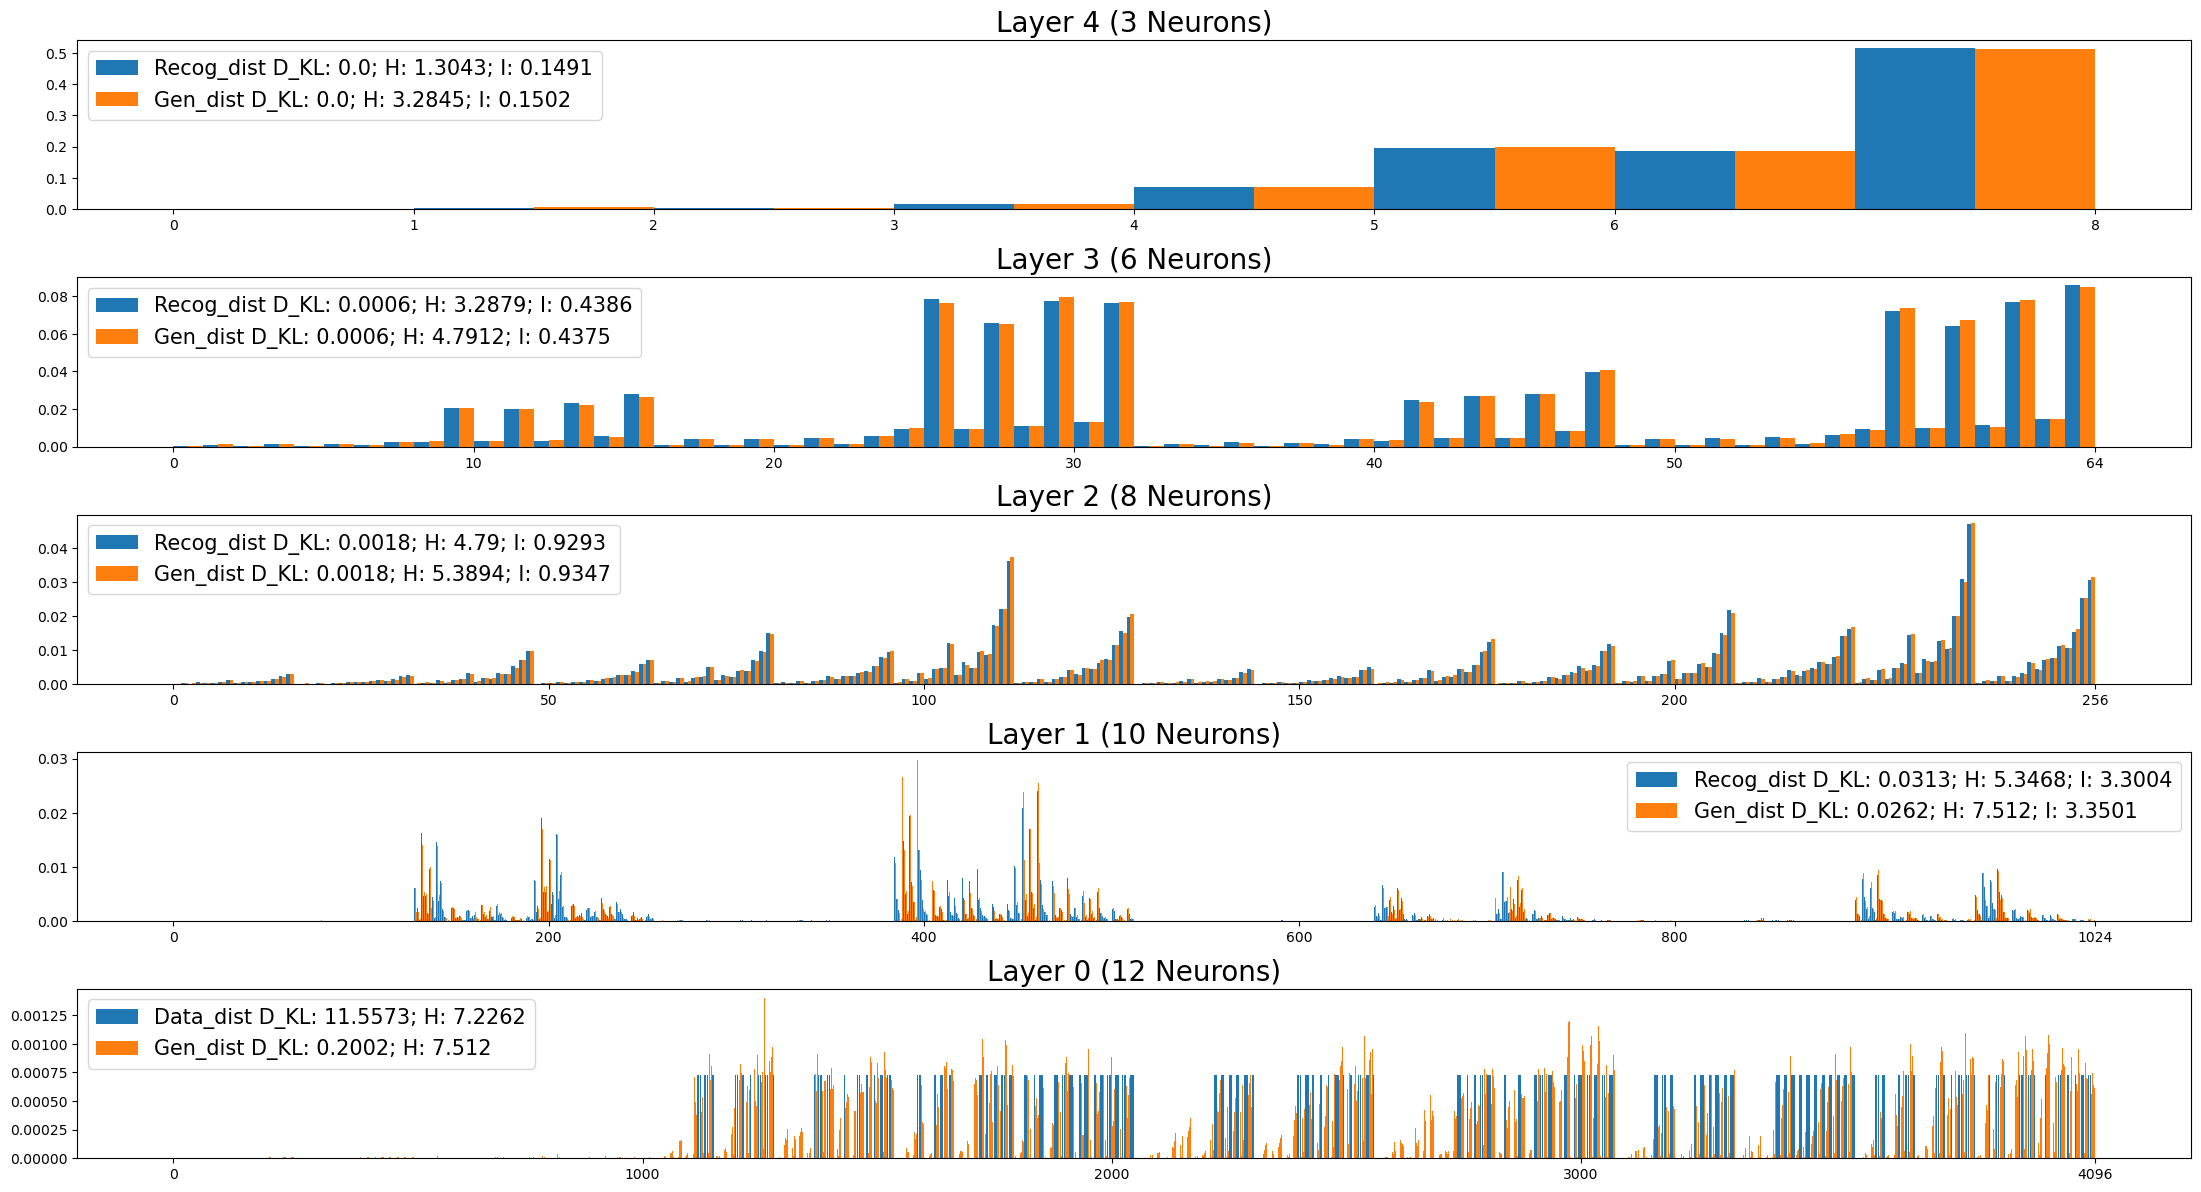

In [205]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)

for i in range(n_layer-1):
    dist_w = wake_ct['Layer '+str(i)+': dist']
    dist_s = sleep_ct['Layer '+str(i)+': dist']
    
    if i > 0:
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        H_YX_w = wake_ct['Layer '+str(i)+': H_YX'].item()
        I_w = H_Y_w - H_YX_w
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w,4)), "H(Y|X): "+str(np.around(H_YX_w,4)),"I_XY: "+str(np.around(I_w,4)))
    
        H_Y_s = sleep_ct['Layer '+str(i-1)+': H_Y'].item()
        H_YX_s = sleep_ct['Layer '+str(i-1)+': H_YX'].item()
        I_s = H_Y_s - H_YX_s
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w,4))+ "; I: "+ str(np.around(I_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s,4))+ "; I: "+ str(np.around(I_s,4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s,4)), "H(Y|X): "+str(np.around(H_YX_s,4)),"I_XY: "+str(np.around(I_s,4)))
    
    else:
        D_KL_w = KL_divergence(dist_s,dist_w).item()
        H_Y_w = wake_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)),"H(Y): "+str(np.around(H_Y_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+str(np.around(H_Y_w,4)))
        
        D_KL_s = KL_divergence(dist_w,dist_s).item()
        H_Y_s = sleep_ct['Layer '+str(i)+': H_Y'].item()
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)),"H(Y): "+str(np.around(H_Y_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+str(np.around(H_Y_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    

plt.tight_layout(pad=1)    
plt.show()

In [201]:
org_data = well_formed_set
new_data = overlap_set
org_data_dist = ground_truth(org_data,dev)
new_data_dist = ground_truth(new_data,dev)

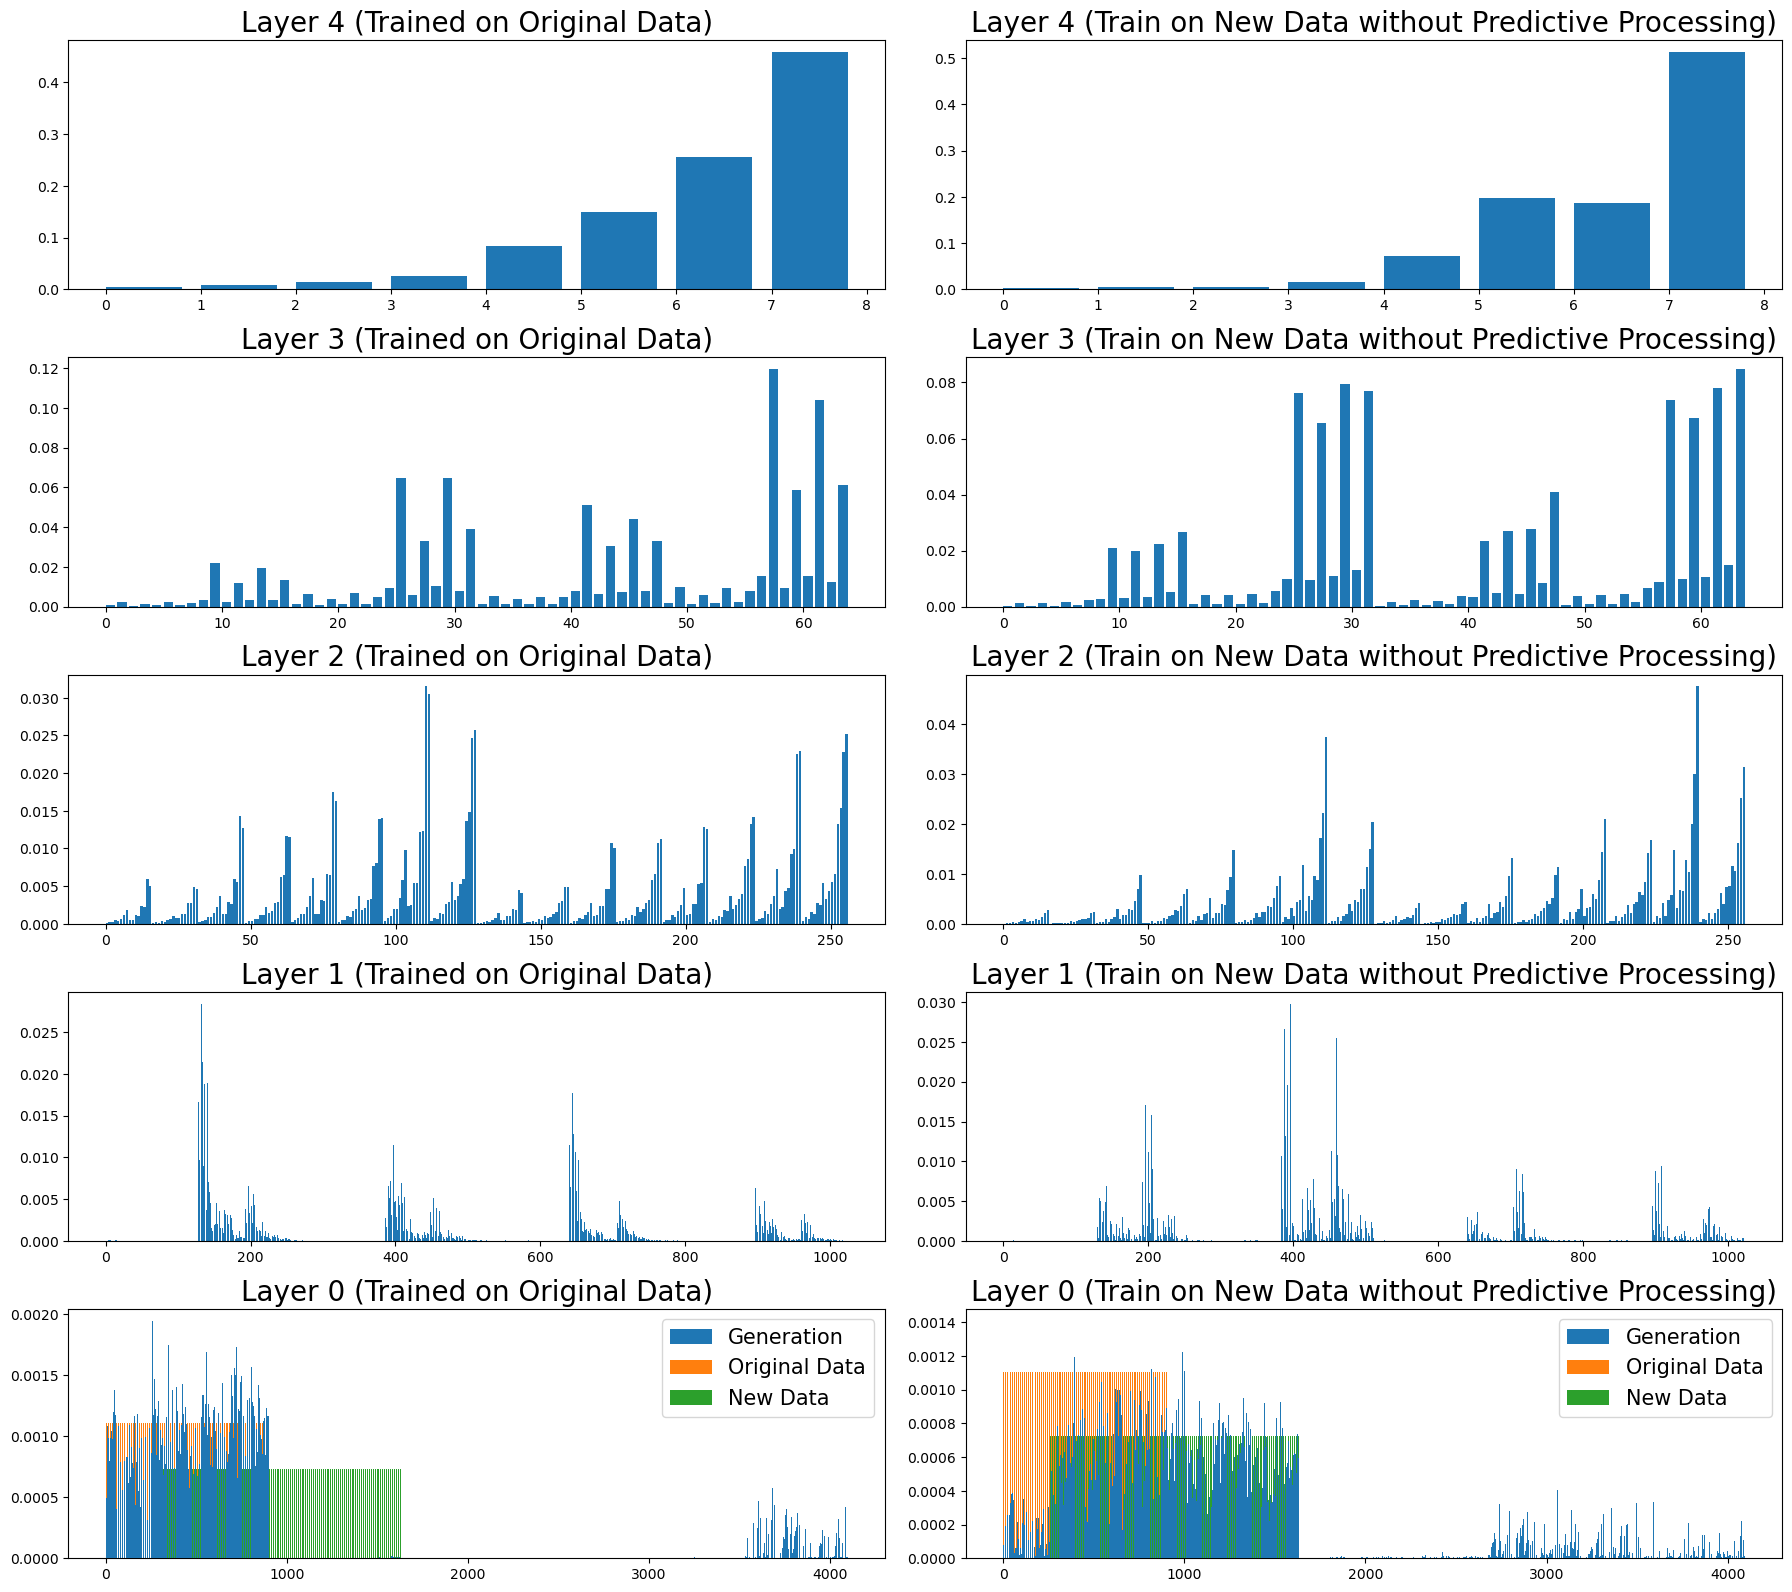

In [207]:
fig, ax = plt.subplots(n_layer-1, 2, figsize=(18, 16))
# fig.suptitle("Predictive Processing",fontsize=25)

dist_pre = torch.ones(1,device=dev)
for i in range(n_layer-1):
    dist_org = org_Dist['Layer_'+str(n_layer-2-i)]
    
    prob_ft, prob_ct = one_step_prob_matrix(n_dz[n_layer-1-i], Theta["Theta_" + str(n_layer-1-i) + str(n_layer-2-i)],dev)
    dist_pre = torch.matmul(dist_pre, prob_ct)
    dist_train = dist_pre
    if i < n_layer-2:
        ax[i,0].bar(np.arange(2**n_dz[n_layer-2-i]),dist_org.to('cpu').numpy(),width=0.8,align='edge')
        ax[i,1].bar(np.arange(2**n_dz[n_layer-2-i]),dist_train.to('cpu').numpy(),width=0.8,align='edge')
    else:
        ax[i,0].bar(np.arange(2**n_dz[n_layer-2-i]),dist_org[order].to('cpu').numpy(),width=0.8,align='edge',label='Generation',zorder=10)
        ax[i,1].bar(np.arange(2**n_dz[n_layer-2-i]),dist_train[order].to('cpu').numpy(),width=0.8,align='edge',label='Generation',zorder=10)
    ax[i,0].set_title("Layer "+str(n_layer-2-i)+' (Trained on Original Data)',fontsize=20)
    ax[i,1].set_title("Layer "+str(n_layer-2-i)+' (Train on New Data without Predictive Processing)',fontsize=20)
    
ax[n_layer-2,0].bar(np.arange(2**n_dz[0]),org_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='Original Data',zorder=0)
ax[n_layer-2,0].bar(np.arange(2**n_dz[0])+0.5,new_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='New Data',zorder=5)
ax[n_layer-2,1].bar(np.arange(2**n_dz[0]),org_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='Original Data',zorder=0)
ax[n_layer-2,1].bar(np.arange(2**n_dz[0])+0.5,new_data_dist[order].to('cpu').numpy(),width=0.5,align='edge',label='New Data',zorder=5)
# ax[n_layer-2,1].set_ylim(0, 0.002)
ax[n_layer-2,0].legend(fontsize=15)
ax[n_layer-2,1].legend(fontsize=15)
plt.tight_layout(pad=1)    
plt.show()

In [208]:
parameters = {'Phi': Phi, 'Theta': Theta}

In [209]:
np.save('Parameters_overlap_set',parameters)